In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import optuna


import warnings
warnings.filterwarnings("ignore")

In [2]:
Train_Original = pd.read_csv("train_BRCpofr.csv")
Test_Original = pd.read_csv("test_koRSKBP.csv")

In [3]:
Train_Original.shape, Test_Original.shape

((89392, 12), (59595, 11))

In [4]:
Train_Original.isna().sum()

id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
cltv              0
dtype: int64

In [5]:
Test_Original.isna().sum()

id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
dtype: int64

In [6]:
Train_Original.dtypes

id                 int64
gender            object
area              object
qualification     object
income            object
marital_status     int64
vintage            int64
claim_amount       int64
num_policies      object
policy            object
type_of_policy    object
cltv               int64
dtype: object

In [7]:
Train_Original.head(2)

id gender   area qualification  income  marital_status  vintage  \
0   1   Male  Urban      Bachelor  5L-10L               1        5   
1   2   Male  Rural   High School  5L-10L               0        8   

   claim_amount num_policies policy type_of_policy    cltv  
0          5790  More than 1      A       Platinum   64308  
1          5080  More than 1      A       Platinum  515400

In [8]:
Train_Original['type_of_policy'].value_counts(normalize=True)

Platinum    0.534679
Silver      0.235032
Gold        0.230289
Name: type_of_policy, dtype: float64

In [9]:
Train_Original['income'].value_counts(normalize=True)

5L-10L           0.589717
2L-5L            0.236688
More than 10L    0.152855
<=2L             0.020740
Name: income, dtype: float64

In [10]:
Train_Original['qualification'].value_counts(normalize=True)

High School    0.517351
Bachelor       0.440744
Others         0.041905
Name: qualification, dtype: float64

In [11]:
Train_Original['num_policies'].value_counts(normalize=True)

More than 1    0.674143
1              0.325857
Name: num_policies, dtype: float64

<AxesSubplot:xlabel='income', ylabel='cltv'>

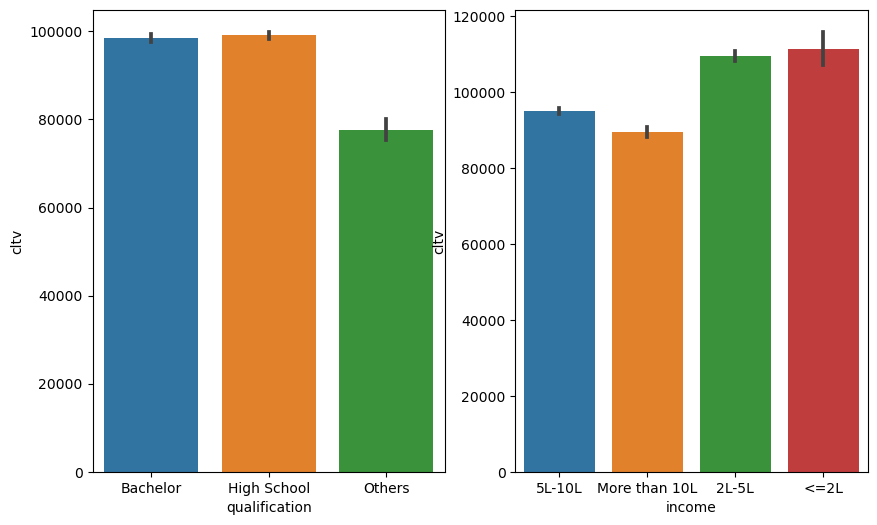

In [12]:
fig,ax = plt.subplots(1,2,figsize=(10,6))
sns.barplot(Train_Original['qualification'],y=Train_Original['cltv'],ax=ax[0])
sns.barplot(Train_Original['income'],y=Train_Original['cltv'],ax=ax[1])

**Inference** - As Qualification and high income is not affecting cltv scores we can do One Hot Encoding instead of Label Encoding, as there is no need for ordered label  while converting Category into continous data

In [13]:
Train_Original.describe()

id  marital_status       vintage  claim_amount           cltv
count  89392.000000    89392.000000  89392.000000  89392.000000   89392.000000
mean   44696.500000        0.575488      4.595669   4351.502416   97952.828978
std    25805.391969        0.494272      2.290446   3262.359775   90613.814793
min        1.000000        0.000000      0.000000      0.000000   24828.000000
25%    22348.750000        0.000000      3.000000   2406.000000   52836.000000
50%    44696.500000        1.000000      5.000000   4089.000000   66396.000000
75%    67044.250000        1.000000      6.000000   6094.000000  103440.000000
max    89392.000000        1.000000      8.000000  31894.000000  724068.000000

In [14]:
Train_Original.dtypes[Train_Original.dtypes=='int64']

id                int64
marital_status    int64
vintage           int64
claim_amount      int64
cltv              int64
dtype: object

In [15]:
num_cols = ['vintage','claim_amount','cltv']

In [16]:
def Univariant_Numeric(data,var_group):
    size=len(var_group)
    plt.figure(figsize=(28*size,15),dpi=200)
    for i,j in enumerate(var_group):
        mini=data[j].min()
        maxi=data[j].max()
        mean=data[j].mean()
        median=data[j].median()
        rang = data[j].max()-data[j].mean()
        std_dev = data[j].std()
        skew = data[j].skew()
        kurt = data[j].kurtosis()
        
        points = mean+std_dev,mean-std_dev
        
        plt.subplot(1,size,i+1)
        sns.kdeplot(data[j],shade=True)
        sns.scatterplot([mean],0,label='mean',color='red')
        sns.lineplot(points,[0,0],color='black',label='Points')
        sns.scatterplot([median],0,label='median',color='green')
        sns.scatterplot([mini,maxi],[0,0], label='min/max',color='blue')
        
        plt.xlabel('{}'.format(j),fontsize=25)
        plt.ylabel("Density")
        
        plt.title('skew={}; kurtosis={}, mean={},std_dev={},median={}'.format(round(skew,2),round(kurt,2),
                                                                             round(mean,2),(round(points[0],2),
                                                                            round(points[1],2)),round(median,2)),
                 fontsize=25)
        print('{} -skew={}, kurtosis={}, mean={},std_dev={},median={}'.format(j,round(skew,2),round(kurt,2),
                                                                             round(mean,2),(round(points[0],2),
                                                                            round(points[1],2)),round(median,2)))
        

vintage -skew=-0.38, kurtosis=-0.94, mean=4.6,std_dev=(6.89, 2.31),median=5.0
claim_amount -skew=1.04, kurtosis=3.23, mean=4351.5,std_dev=(7613.86, 1089.14),median=4089.0
cltv -skew=2.75, kurtosis=8.33, mean=97952.83,std_dev=(188566.64, 7339.01),median=66396.0


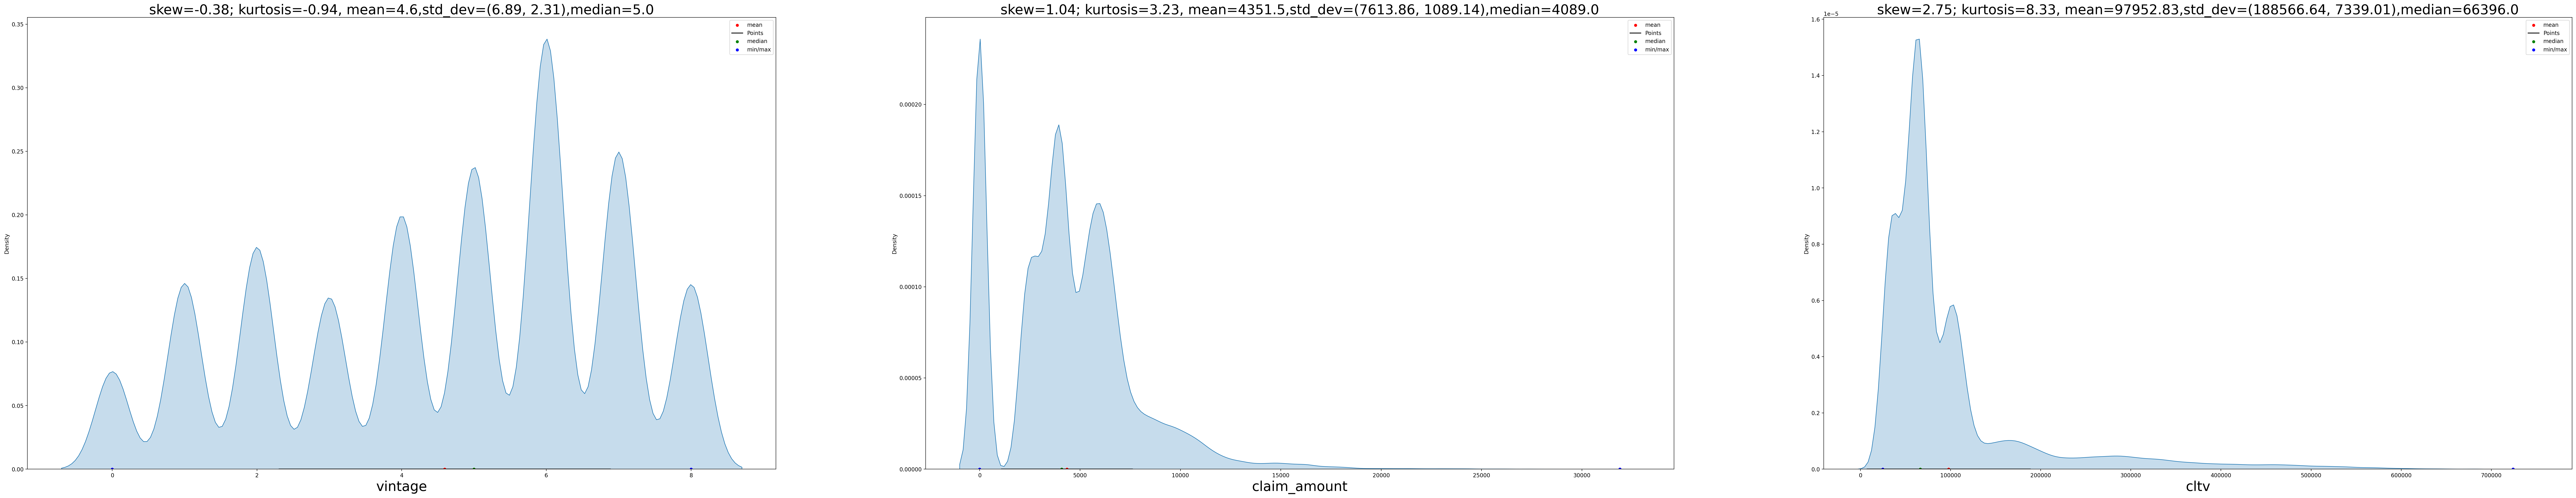

In [17]:
Univariant_Numeric(Train_Original,num_cols)

<AxesSubplot:>

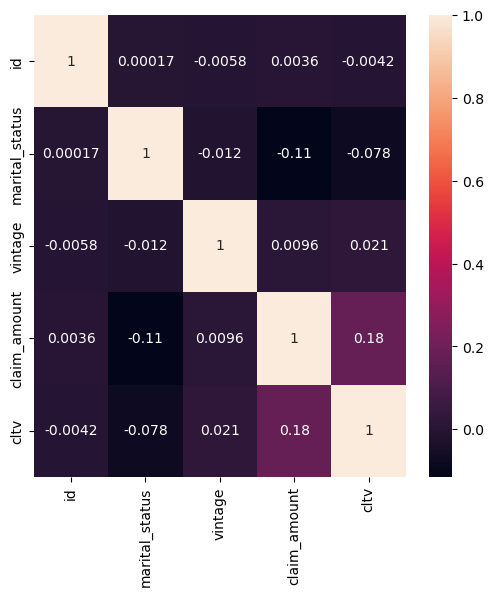

In [18]:
f,ax=plt.subplots(figsize=(6,6))
sns.heatmap(Train_Original.corr(),annot=True)

**INFERENCE**
<br>
**Vintage**
Skewness is -0.38 i.e between the range(-0.5 to 0.5) we can say it is symetrically distributed
Kurtosis is -0.94 which indicates very less likely to have extreme outliers

**Claim_Amount**
skew is 1.04 indictating a bit righ skewness 
kurtosis is 3.34 indicting likely to have outliers

**CLTV**
skew is 2.75 - right skewness
kurtosis is 8.33 - high prone to outliers

**To do**
1) COnvert marital_status to category
2) Convert object to category
3) One Hot Encoding

In [19]:
Train_Original.dtypes[Train_Original.dtypes=='object']

gender            object
area              object
qualification     object
income            object
num_policies      object
policy            object
type_of_policy    object
dtype: object

In [20]:
Train_Original['area'].value_counts()

Urban    62455
Rural    26937
Name: area, dtype: int64

In [21]:
def Transform_data(data):
    data['marital_status'] = data['marital_status'].astype('category')
    data['gender'] = data['gender'].astype('category')
    data['area'] = data['area'].astype('category')
    data['qualification'] = data['qualification'].astype('category')
    data['income'] = data['income'].astype('category')
    data['num_policies']=data['num_policies'].astype('category')
    data['policy'] = data['policy'].astype('category')
    data['type_of_policy']=data['type_of_policy'].astype('category')
    
    dummie = pd.get_dummies(data,columns=['marital_status','gender','num_policies','area','qualification','income','policy','type_of_policy'])
    return dummie
    
    

In [22]:
Train_encoded = Transform_data(Train_Original)
Test_encoded = Transform_data(Test_Original)

In [23]:
Train_encoded.shape, Test_encoded.shape

((89392, 25), (59595, 24))

In [24]:
Train_encoded.head()

id  vintage  claim_amount    cltv  marital_status_0  marital_status_1  \
0   1        5          5790   64308                 0                 1   
1   2        8          5080  515400                 1                 0   
2   3        8          2599   64212                 0                 1   
3   4        7             0   97920                 1                 0   
4   5        6          3508   59736                 0                 1   

   gender_Female  gender_Male  num_policies_1  num_policies_More than 1  ...  \
0              0            1               0                         1  ...   
1              0            1               0                         1  ...   
2              0            1               0                         1  ...   
3              1            0               0                         1  ...   
4              0            1               0                         1  ...   

   income_2L-5L  income_5L-10L  income_<=2L  income_More than 10L  policy_A  \
0             0              1            0                     0         1   
1             0              1            0                     0         1   
2             0              1            0                     0         1   
3             0              1            0                     0         1   
4             0              0            0                     1         1   

   policy_B  policy_C  type_of_policy_Gold  type_of_policy_Platinum  \
0         0         0                    0                        1   
1         0         0                    0                        1   
2         0         0                    0                        1   
3         0         0                    0                        1   
4         0         0                    1                        0   

   type_of_policy_Silver  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 25 columns]

In [25]:
# Segreggating X and Y Variable
X = Train_encoded.drop('cltv',axis=1)
Y=Train_encoded['cltv']
X.shape,Y.shape

((89392, 24), (89392,))

In [26]:
#Splitting dataset
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=1,test_size=0.25,)

In [37]:
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train_scaled.head(2)

X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns)


In [ ]:
X_train_scaled.shape,X_test_scaled.shape

In [96]:
X_train.head()

id  vintage  claim_amount  marital_status_0  marital_status_1  \
2623    2624        0             0                 0                 1   
22149  22150        7          6806                 0                 1   
32493  32494        2             0                 0                 1   
28906  28907        2          2616                 1                 0   
71941  71942        1             0                 1                 0   

       gender_Female  gender_Male  num_policies_1  num_policies_More than 1  \
2623               0            1               1                         0   
22149              1            0               0                         1   
32493              1            0               0                         1   
28906              0            1               1                         0   
71941              1            0               0                         1   

       area_Rural  ...  income_2L-5L  income_5L-10L  income_<=2L  \
2623            1  ...             0              0            0   
22149           0  ...             0              1            0   
32493           0  ...             0              1            0   
28906           0  ...             0              1            0   
71941           1  ...             0              0            0   

       income_More than 10L  policy_A  policy_B  policy_C  \
2623                      1         0         1         0   
22149                     0         1         0         0   
32493                     0         1         0         0   
28906                     0         0         1         0   
71941                     1         0         1         0   

       type_of_policy_Gold  type_of_policy_Platinum  type_of_policy_Silver  
2623                     0                        0                      1  
22149                    0                        1                      0  
32493                    0                        1                      0  
28906                    0                        1                      0  
71941                    0                        0                      1  

[5 rows x 24 columns]

### Baseline Regression Model

In [38]:
def base_model(model):
    lr = model
    lr.fit(X_train_scaled,Y_train)
    predict = lr.predict(X_test_scaled)
    r2 = r2_score(Y_test,predict)
    print(f"R2 Score for  {model} is {r2}")

In [39]:
base_model(LinearRegression())

R2 Score for  LinearRegression() is 0.15254588713870065


In [40]:
base_model(DecisionTreeRegressor())

R2 Score for  DecisionTreeRegressor() is -0.877878048533244


In [41]:
base_model(KNeighborsRegressor())

R2 Score for  KNeighborsRegressor() is -0.007830876359117944


In [150]:
base_model(CatBoostRegressor())

Learning rate set to 0.079569
0:	learn: 90083.9491649	total: 7.56ms	remaining: 7.55s
1:	learn: 89172.4881135	total: 15.9ms	remaining: 7.94s
2:	learn: 88393.6780989	total: 23.3ms	remaining: 7.75s
3:	learn: 87729.5576754	total: 31.4ms	remaining: 7.83s
4:	learn: 87137.2769839	total: 39ms	remaining: 7.75s
5:	learn: 86646.6208093	total: 47.2ms	remaining: 7.83s
6:	learn: 86208.0533758	total: 54.6ms	remaining: 7.75s
7:	learn: 85839.4345131	total: 62.8ms	remaining: 7.78s
8:	learn: 85517.4203895	total: 70.2ms	remaining: 7.73s
9:	learn: 85254.3915088	total: 77.7ms	remaining: 7.69s
10:	learn: 85009.9764444	total: 85.1ms	remaining: 7.65s
11:	learn: 84790.6076711	total: 93.5ms	remaining: 7.7s
12:	learn: 84609.5070571	total: 103ms	remaining: 7.79s
13:	learn: 84455.8485855	total: 113ms	remaining: 7.95s
14:	learn: 84326.5616940	total: 122ms	remaining: 7.99s
15:	learn: 84216.8624010	total: 130ms	remaining: 7.98s
16:	learn: 84111.2874821	total: 138ms	remaining: 7.96s
17:	learn: 84026.0848731	total: 146m

158:	learn: 82702.8868866	total: 1.58s	remaining: 8.37s
159:	learn: 82696.5998267	total: 1.59s	remaining: 8.37s
160:	learn: 82693.2015371	total: 1.6s	remaining: 8.36s
161:	learn: 82686.9978532	total: 1.62s	remaining: 8.36s
162:	learn: 82681.1862555	total: 1.63s	remaining: 8.36s
163:	learn: 82675.2092955	total: 1.64s	remaining: 8.36s
164:	learn: 82671.5182006	total: 1.65s	remaining: 8.36s
165:	learn: 82666.5020350	total: 1.66s	remaining: 8.35s
166:	learn: 82662.9393517	total: 1.67s	remaining: 8.34s
167:	learn: 82656.0323276	total: 1.68s	remaining: 8.33s
168:	learn: 82649.6716019	total: 1.69s	remaining: 8.31s
169:	learn: 82643.4083609	total: 1.7s	remaining: 8.3s
170:	learn: 82638.3221652	total: 1.71s	remaining: 8.29s
171:	learn: 82631.7225716	total: 1.72s	remaining: 8.28s
172:	learn: 82627.5162347	total: 1.73s	remaining: 8.27s
173:	learn: 82621.9709328	total: 1.74s	remaining: 8.27s
174:	learn: 82616.5313584	total: 1.75s	remaining: 8.26s
175:	learn: 82613.2536813	total: 1.76s	remaining: 8

316:	learn: 81939.8183249	total: 3.21s	remaining: 6.93s
317:	learn: 81934.5285421	total: 3.23s	remaining: 6.92s
318:	learn: 81931.2649310	total: 3.24s	remaining: 6.91s
319:	learn: 81928.3186389	total: 3.25s	remaining: 6.91s
320:	learn: 81925.4853612	total: 3.26s	remaining: 6.89s
321:	learn: 81920.9917947	total: 3.27s	remaining: 6.89s
322:	learn: 81916.9226672	total: 3.28s	remaining: 6.88s
323:	learn: 81910.1772373	total: 3.29s	remaining: 6.87s
324:	learn: 81906.4699104	total: 3.3s	remaining: 6.86s
325:	learn: 81902.3933305	total: 3.31s	remaining: 6.85s
326:	learn: 81899.7127851	total: 3.32s	remaining: 6.84s
327:	learn: 81896.2200472	total: 3.33s	remaining: 6.83s
328:	learn: 81889.6343471	total: 3.35s	remaining: 6.82s
329:	learn: 81885.3241587	total: 3.35s	remaining: 6.81s
330:	learn: 81881.4080971	total: 3.37s	remaining: 6.8s
331:	learn: 81879.2685116	total: 3.38s	remaining: 6.79s
332:	learn: 81875.3540958	total: 3.38s	remaining: 6.78s
333:	learn: 81870.1968674	total: 3.4s	remaining: 6

468:	learn: 81292.3809368	total: 4.78s	remaining: 5.41s
469:	learn: 81288.4985643	total: 4.79s	remaining: 5.4s
470:	learn: 81283.2778824	total: 4.8s	remaining: 5.39s
471:	learn: 81278.6748359	total: 4.81s	remaining: 5.38s
472:	learn: 81275.8959271	total: 4.82s	remaining: 5.37s
473:	learn: 81272.2191786	total: 4.83s	remaining: 5.36s
474:	learn: 81269.3978325	total: 4.84s	remaining: 5.35s
475:	learn: 81265.5528715	total: 4.85s	remaining: 5.34s
476:	learn: 81261.7689224	total: 4.86s	remaining: 5.33s
477:	learn: 81258.5294617	total: 4.87s	remaining: 5.32s
478:	learn: 81255.6230373	total: 4.88s	remaining: 5.31s
479:	learn: 81252.0348529	total: 4.89s	remaining: 5.3s
480:	learn: 81250.0764976	total: 4.9s	remaining: 5.29s
481:	learn: 81245.9961798	total: 4.91s	remaining: 5.28s
482:	learn: 81241.9719744	total: 4.92s	remaining: 5.27s
483:	learn: 81237.9967107	total: 4.93s	remaining: 5.26s
484:	learn: 81233.3850362	total: 4.94s	remaining: 5.25s
485:	learn: 81227.9128574	total: 4.95s	remaining: 5.

624:	learn: 80718.5978708	total: 6.37s	remaining: 3.82s
625:	learn: 80714.5750512	total: 6.38s	remaining: 3.81s
626:	learn: 80711.3250879	total: 6.39s	remaining: 3.8s
627:	learn: 80707.7203130	total: 6.4s	remaining: 3.79s
628:	learn: 80701.8386749	total: 6.41s	remaining: 3.78s
629:	learn: 80698.3144544	total: 6.42s	remaining: 3.77s
630:	learn: 80693.1016756	total: 6.43s	remaining: 3.76s
631:	learn: 80688.2599478	total: 6.43s	remaining: 3.75s
632:	learn: 80685.1406609	total: 6.45s	remaining: 3.74s
633:	learn: 80681.0941311	total: 6.46s	remaining: 3.73s
634:	learn: 80673.8697886	total: 6.47s	remaining: 3.72s
635:	learn: 80671.0710837	total: 6.47s	remaining: 3.71s
636:	learn: 80667.7180095	total: 6.48s	remaining: 3.69s
637:	learn: 80664.0456486	total: 6.49s	remaining: 3.68s
638:	learn: 80659.2225710	total: 6.5s	remaining: 3.67s
639:	learn: 80657.1195177	total: 6.51s	remaining: 3.66s
640:	learn: 80653.7392993	total: 6.52s	remaining: 3.65s
641:	learn: 80649.7980512	total: 6.53s	remaining: 3

781:	learn: 80173.4458173	total: 8.03s	remaining: 2.24s
782:	learn: 80168.7825841	total: 8.04s	remaining: 2.23s
783:	learn: 80166.1105811	total: 8.05s	remaining: 2.22s
784:	learn: 80161.6731066	total: 8.06s	remaining: 2.21s
785:	learn: 80157.8196774	total: 8.07s	remaining: 2.2s
786:	learn: 80154.7479124	total: 8.08s	remaining: 2.19s
787:	learn: 80151.8643182	total: 8.09s	remaining: 2.18s
788:	learn: 80148.8688105	total: 8.1s	remaining: 2.17s
789:	learn: 80144.5692981	total: 8.11s	remaining: 2.16s
790:	learn: 80139.3838497	total: 8.12s	remaining: 2.15s
791:	learn: 80136.0785105	total: 8.13s	remaining: 2.14s
792:	learn: 80132.0704692	total: 8.14s	remaining: 2.13s
793:	learn: 80129.6348890	total: 8.15s	remaining: 2.12s
794:	learn: 80127.3871680	total: 8.16s	remaining: 2.1s
795:	learn: 80124.2039825	total: 8.17s	remaining: 2.09s
796:	learn: 80121.2420783	total: 8.18s	remaining: 2.08s
797:	learn: 80118.1997670	total: 8.19s	remaining: 2.07s
798:	learn: 80111.3213917	total: 8.2s	remaining: 2.

932:	learn: 79671.2318349	total: 9.57s	remaining: 688ms
933:	learn: 79667.9028729	total: 9.59s	remaining: 677ms
934:	learn: 79664.7873429	total: 9.6s	remaining: 667ms
935:	learn: 79662.2484702	total: 9.61s	remaining: 657ms
936:	learn: 79658.4196501	total: 9.62s	remaining: 647ms
937:	learn: 79654.6107864	total: 9.63s	remaining: 637ms
938:	learn: 79651.8601302	total: 9.64s	remaining: 627ms
939:	learn: 79649.4218926	total: 9.65s	remaining: 616ms
940:	learn: 79645.2827854	total: 9.66s	remaining: 606ms
941:	learn: 79641.9501514	total: 9.68s	remaining: 596ms
942:	learn: 79638.3514211	total: 9.69s	remaining: 586ms
943:	learn: 79635.7443573	total: 9.7s	remaining: 575ms
944:	learn: 79632.2036273	total: 9.71s	remaining: 565ms
945:	learn: 79628.3085221	total: 9.72s	remaining: 555ms
946:	learn: 79624.7456099	total: 9.73s	remaining: 545ms
947:	learn: 79621.3194169	total: 9.74s	remaining: 534ms
948:	learn: 79618.0284420	total: 9.75s	remaining: 524ms
949:	learn: 79615.6988951	total: 9.76s	remaining: 

In [151]:
base_model(lgb.LGBMRegressor())

R2 Score for  LGBMRegressor() is 0.1343448899172378


In [140]:
# using crossvalidation
def cv_score(ml_model,randome_state=1,):
    i=1
    r_scores=[]
    
    kf = KFold(n_splits=5,random_state=1,shuffle=True)
    for train_id,test_id in kf.split(X_train_scaled,Y_train):
        print("\n{} of kfold{}".format(i,kf.n_splits))
        xtrain,xtest = X_train_scaled.iloc[train_id],X_train_scaled.iloc[test_id]
        ytrain,ytest = Y_train.iloc[train_id], Y_train.iloc[test_id]
        
        model=ml_model
        model.fit(xtrain,ytrain)
        predict = model.predict(xtest)
        
        r2 = r2_score(predict,ytest)
        print("R2 score for {} is {}".format(ml_model,r2))
        
        r_scores.append(r2)
        i+=1
    print("\nMean R2 Score is",np.array(r_scores).mean())

In [141]:
LR_scores = cv_score(LinearRegression())


1 of kfold5
R2 score for LinearRegression() is -1.4714585535968867

2 of kfold5
R2 score for LinearRegression() is -1.3449925029315875

3 of kfold5
R2 score for LinearRegression() is -1.7268713784015528

4 of kfold5
R2 score for LinearRegression() is -1.4347445850996765

5 of kfold5
R2 score for LinearRegression() is -1.3245622306648626

Mean R2 Score is -1.4605258501389131


In [153]:
DT_scores = cv_score(lgb.LGBMRegressor())


1 of kfold5
R2 score for LGBMRegressor() is -3.976728166062088

2 of kfold5
R2 score for LGBMRegressor() is -2.7408701569041547

3 of kfold5
R2 score for LGBMRegressor() is -2.4459143371857768

4 of kfold5
R2 score for LGBMRegressor() is -2.4106608167390804

5 of kfold5
R2 score for LGBMRegressor() is -2.382464552206975

Mean R2 Score is -2.791327605819615


In [154]:
Kn_scores =cv_score(CatBoostRegressor())


1 of kfold5
Learning rate set to 0.076813
0:	learn: 89857.6071490	total: 8.2ms	remaining: 8.19s
1:	learn: 88985.7487457	total: 15.7ms	remaining: 7.84s
2:	learn: 88226.5425748	total: 22.1ms	remaining: 7.33s
3:	learn: 87573.5336728	total: 28.8ms	remaining: 7.16s
4:	learn: 86988.9159250	total: 35.5ms	remaining: 7.07s
5:	learn: 86502.1969361	total: 41.9ms	remaining: 6.94s
6:	learn: 86074.0249925	total: 48.3ms	remaining: 6.86s
7:	learn: 85703.0596457	total: 54.7ms	remaining: 6.79s
8:	learn: 85434.4939880	total: 59ms	remaining: 6.5s
9:	learn: 85135.0262831	total: 65.3ms	remaining: 6.47s
10:	learn: 84905.8299314	total: 70.5ms	remaining: 6.34s
11:	learn: 84690.7198196	total: 76.7ms	remaining: 6.32s
12:	learn: 84496.6534416	total: 83.1ms	remaining: 6.31s
13:	learn: 84328.2350465	total: 89.6ms	remaining: 6.31s
14:	learn: 84187.6871948	total: 96ms	remaining: 6.3s
15:	learn: 84065.1679181	total: 102ms	remaining: 6.27s
16:	learn: 83961.0606083	total: 108ms	remaining: 6.25s
17:	learn: 83868.5095286

168:	learn: 82273.2266654	total: 1.18s	remaining: 5.8s
169:	learn: 82265.8629954	total: 1.19s	remaining: 5.8s
170:	learn: 82259.7915729	total: 1.2s	remaining: 5.8s
171:	learn: 82254.2802670	total: 1.2s	remaining: 5.79s
172:	learn: 82248.7880222	total: 1.21s	remaining: 5.79s
173:	learn: 82243.6434602	total: 1.22s	remaining: 5.78s
174:	learn: 82238.4797110	total: 1.23s	remaining: 5.78s
175:	learn: 82230.4502998	total: 1.23s	remaining: 5.77s
176:	learn: 82219.5461081	total: 1.24s	remaining: 5.77s
177:	learn: 82214.6738039	total: 1.25s	remaining: 5.76s
178:	learn: 82208.9308764	total: 1.25s	remaining: 5.75s
179:	learn: 82200.8167769	total: 1.26s	remaining: 5.74s
180:	learn: 82190.5334403	total: 1.27s	remaining: 5.74s
181:	learn: 82182.6369802	total: 1.27s	remaining: 5.73s
182:	learn: 82175.1948065	total: 1.28s	remaining: 5.72s
183:	learn: 82168.8433012	total: 1.29s	remaining: 5.71s
184:	learn: 82164.4065209	total: 1.29s	remaining: 5.7s
185:	learn: 82157.6094085	total: 1.3s	remaining: 5.69s

342:	learn: 81258.0882817	total: 2.38s	remaining: 4.57s
343:	learn: 81252.2301305	total: 2.39s	remaining: 4.56s
344:	learn: 81247.6319419	total: 2.4s	remaining: 4.55s
345:	learn: 81242.4784328	total: 2.41s	remaining: 4.55s
346:	learn: 81238.2293798	total: 2.41s	remaining: 4.54s
347:	learn: 81232.5680482	total: 2.42s	remaining: 4.54s
348:	learn: 81226.1036625	total: 2.43s	remaining: 4.53s
349:	learn: 81219.8511301	total: 2.43s	remaining: 4.52s
350:	learn: 81212.2054740	total: 2.44s	remaining: 4.51s
351:	learn: 81205.1723916	total: 2.45s	remaining: 4.5s
352:	learn: 81199.9986611	total: 2.45s	remaining: 4.5s
353:	learn: 81195.9804292	total: 2.46s	remaining: 4.49s
354:	learn: 81191.9484887	total: 2.47s	remaining: 4.48s
355:	learn: 81186.5578734	total: 2.47s	remaining: 4.47s
356:	learn: 81178.8793990	total: 2.48s	remaining: 4.46s
357:	learn: 81170.9551981	total: 2.48s	remaining: 4.46s
358:	learn: 81166.3667215	total: 2.49s	remaining: 4.45s
359:	learn: 81162.4575720	total: 2.5s	remaining: 4.

500:	learn: 80452.7878237	total: 3.42s	remaining: 3.41s
501:	learn: 80445.8102915	total: 3.43s	remaining: 3.4s
502:	learn: 80440.3263269	total: 3.44s	remaining: 3.4s
503:	learn: 80436.3536655	total: 3.45s	remaining: 3.39s
504:	learn: 80432.5195811	total: 3.46s	remaining: 3.39s
505:	learn: 80429.4169814	total: 3.46s	remaining: 3.38s
506:	learn: 80424.9015832	total: 3.47s	remaining: 3.38s
507:	learn: 80420.1726450	total: 3.48s	remaining: 3.37s
508:	learn: 80416.8474832	total: 3.48s	remaining: 3.36s
509:	learn: 80413.1645019	total: 3.49s	remaining: 3.35s
510:	learn: 80407.6443265	total: 3.5s	remaining: 3.35s
511:	learn: 80404.4224356	total: 3.5s	remaining: 3.34s
512:	learn: 80399.6943891	total: 3.51s	remaining: 3.33s
513:	learn: 80393.8924049	total: 3.52s	remaining: 3.33s
514:	learn: 80390.8118844	total: 3.53s	remaining: 3.32s
515:	learn: 80386.5855028	total: 3.54s	remaining: 3.32s
516:	learn: 80382.8847392	total: 3.54s	remaining: 3.31s
517:	learn: 80377.4060823	total: 3.55s	remaining: 3.

664:	learn: 79739.7184996	total: 4.67s	remaining: 2.35s
665:	learn: 79736.1150817	total: 4.67s	remaining: 2.34s
666:	learn: 79730.9308478	total: 4.68s	remaining: 2.34s
667:	learn: 79727.7650482	total: 4.69s	remaining: 2.33s
668:	learn: 79723.3860157	total: 4.69s	remaining: 2.32s
669:	learn: 79719.1358864	total: 4.7s	remaining: 2.31s
670:	learn: 79714.4118440	total: 4.71s	remaining: 2.31s
671:	learn: 79711.0754529	total: 4.71s	remaining: 2.3s
672:	learn: 79707.5199990	total: 4.72s	remaining: 2.29s
673:	learn: 79704.3660331	total: 4.73s	remaining: 2.29s
674:	learn: 79699.0422698	total: 4.73s	remaining: 2.28s
675:	learn: 79695.6380319	total: 4.74s	remaining: 2.27s
676:	learn: 79690.9802726	total: 4.75s	remaining: 2.26s
677:	learn: 79687.6950581	total: 4.75s	remaining: 2.26s
678:	learn: 79682.3715737	total: 4.76s	remaining: 2.25s
679:	learn: 79677.7932609	total: 4.76s	remaining: 2.24s
680:	learn: 79674.9980641	total: 4.77s	remaining: 2.23s
681:	learn: 79671.4378709	total: 4.78s	remaining: 

817:	learn: 79105.7389469	total: 5.68s	remaining: 1.26s
818:	learn: 79102.7687357	total: 5.68s	remaining: 1.26s
819:	learn: 79097.1328627	total: 5.69s	remaining: 1.25s
820:	learn: 79093.3269588	total: 5.7s	remaining: 1.24s
821:	learn: 79089.1536384	total: 5.71s	remaining: 1.24s
822:	learn: 79084.1698260	total: 5.71s	remaining: 1.23s
823:	learn: 79079.0035700	total: 5.72s	remaining: 1.22s
824:	learn: 79075.8975450	total: 5.72s	remaining: 1.21s
825:	learn: 79071.7673940	total: 5.73s	remaining: 1.21s
826:	learn: 79069.3742386	total: 5.74s	remaining: 1.2s
827:	learn: 79066.0869220	total: 5.74s	remaining: 1.19s
828:	learn: 79060.5412614	total: 5.75s	remaining: 1.19s
829:	learn: 79057.8555797	total: 5.75s	remaining: 1.18s
830:	learn: 79055.2791218	total: 5.76s	remaining: 1.17s
831:	learn: 79051.7377829	total: 5.77s	remaining: 1.16s
832:	learn: 79049.0639545	total: 5.77s	remaining: 1.16s
833:	learn: 79045.4002488	total: 5.78s	remaining: 1.15s
834:	learn: 79042.8513586	total: 5.79s	remaining: 

971:	learn: 78540.7865773	total: 6.7s	remaining: 193ms
972:	learn: 78536.6702183	total: 6.71s	remaining: 186ms
973:	learn: 78533.8397886	total: 6.71s	remaining: 179ms
974:	learn: 78529.6902037	total: 6.72s	remaining: 172ms
975:	learn: 78527.1650549	total: 6.73s	remaining: 166ms
976:	learn: 78524.2619262	total: 6.74s	remaining: 159ms
977:	learn: 78520.4757528	total: 6.75s	remaining: 152ms
978:	learn: 78517.1309569	total: 6.75s	remaining: 145ms
979:	learn: 78513.7687784	total: 6.76s	remaining: 138ms
980:	learn: 78511.2766713	total: 6.77s	remaining: 131ms
981:	learn: 78506.2242038	total: 6.78s	remaining: 124ms
982:	learn: 78502.1349594	total: 6.78s	remaining: 117ms
983:	learn: 78497.6147675	total: 6.79s	remaining: 110ms
984:	learn: 78494.8932638	total: 6.8s	remaining: 104ms
985:	learn: 78492.6181101	total: 6.8s	remaining: 96.6ms
986:	learn: 78489.1230031	total: 6.81s	remaining: 89.7ms
987:	learn: 78485.0907303	total: 6.82s	remaining: 82.8ms
988:	learn: 78483.1060503	total: 6.82s	remaining

139:	learn: 82582.8692259	total: 934ms	remaining: 5.74s
140:	learn: 82577.7226585	total: 942ms	remaining: 5.74s
141:	learn: 82571.6971860	total: 950ms	remaining: 5.74s
142:	learn: 82564.4921327	total: 959ms	remaining: 5.75s
143:	learn: 82552.8466422	total: 966ms	remaining: 5.74s
144:	learn: 82548.7570016	total: 974ms	remaining: 5.74s
145:	learn: 82541.1818071	total: 981ms	remaining: 5.74s
146:	learn: 82535.5664363	total: 989ms	remaining: 5.74s
147:	learn: 82525.3091574	total: 995ms	remaining: 5.73s
148:	learn: 82520.5919506	total: 1s	remaining: 5.73s
149:	learn: 82516.4537541	total: 1.01s	remaining: 5.72s
150:	learn: 82510.7972504	total: 1.01s	remaining: 5.71s
151:	learn: 82505.9006249	total: 1.02s	remaining: 5.7s
152:	learn: 82501.1478974	total: 1.03s	remaining: 5.69s
153:	learn: 82495.4944410	total: 1.03s	remaining: 5.68s
154:	learn: 82484.3515890	total: 1.04s	remaining: 5.67s
155:	learn: 82475.0458848	total: 1.05s	remaining: 5.66s
156:	learn: 82465.7170153	total: 1.05s	remaining: 5.

288:	learn: 81663.9331091	total: 1.96s	remaining: 4.83s
289:	learn: 81656.8862994	total: 1.97s	remaining: 4.82s
290:	learn: 81651.0019720	total: 1.98s	remaining: 4.82s
291:	learn: 81643.0809474	total: 1.99s	remaining: 4.82s
292:	learn: 81637.0902097	total: 2s	remaining: 4.82s
293:	learn: 81631.9952465	total: 2s	remaining: 4.82s
294:	learn: 81624.4826739	total: 2.01s	remaining: 4.81s
295:	learn: 81619.9144688	total: 2.02s	remaining: 4.8s
296:	learn: 81615.0457578	total: 2.05s	remaining: 4.86s
297:	learn: 81610.2070744	total: 2.06s	remaining: 4.86s
298:	learn: 81603.8573258	total: 2.07s	remaining: 4.86s
299:	learn: 81597.1857050	total: 2.08s	remaining: 4.85s
300:	learn: 81591.6241534	total: 2.08s	remaining: 4.84s
301:	learn: 81587.9127358	total: 2.09s	remaining: 4.83s
302:	learn: 81582.4748131	total: 2.1s	remaining: 4.83s
303:	learn: 81579.6770259	total: 2.1s	remaining: 4.82s
304:	learn: 81573.3075613	total: 2.11s	remaining: 4.81s
305:	learn: 81565.4446817	total: 2.12s	remaining: 4.8s
30

451:	learn: 80836.2229264	total: 3.19s	remaining: 3.87s
452:	learn: 80832.1889550	total: 3.2s	remaining: 3.87s
453:	learn: 80827.7231582	total: 3.21s	remaining: 3.86s
454:	learn: 80823.9321284	total: 3.22s	remaining: 3.85s
455:	learn: 80818.6800519	total: 3.22s	remaining: 3.84s
456:	learn: 80814.8904485	total: 3.23s	remaining: 3.84s
457:	learn: 80810.4494726	total: 3.24s	remaining: 3.83s
458:	learn: 80807.1184171	total: 3.24s	remaining: 3.82s
459:	learn: 80800.8648651	total: 3.25s	remaining: 3.81s
460:	learn: 80796.5229042	total: 3.25s	remaining: 3.81s
461:	learn: 80791.7614642	total: 3.26s	remaining: 3.8s
462:	learn: 80785.5699182	total: 3.27s	remaining: 3.79s
463:	learn: 80782.8615645	total: 3.27s	remaining: 3.78s
464:	learn: 80777.7266872	total: 3.28s	remaining: 3.77s
465:	learn: 80773.6339183	total: 3.29s	remaining: 3.77s
466:	learn: 80768.9373649	total: 3.29s	remaining: 3.76s
467:	learn: 80765.8929262	total: 3.3s	remaining: 3.75s
468:	learn: 80761.5334026	total: 3.31s	remaining: 3

620:	learn: 80083.1310073	total: 4.42s	remaining: 2.7s
621:	learn: 80079.5951505	total: 4.43s	remaining: 2.69s
622:	learn: 80074.9061260	total: 4.43s	remaining: 2.68s
623:	learn: 80071.5784260	total: 4.44s	remaining: 2.68s
624:	learn: 80067.9288412	total: 4.45s	remaining: 2.67s
625:	learn: 80062.8134310	total: 4.45s	remaining: 2.66s
626:	learn: 80060.3846427	total: 4.46s	remaining: 2.65s
627:	learn: 80056.4009918	total: 4.47s	remaining: 2.65s
628:	learn: 80053.4447777	total: 4.48s	remaining: 2.64s
629:	learn: 80049.3092326	total: 4.48s	remaining: 2.63s
630:	learn: 80042.1899953	total: 4.5s	remaining: 2.63s
631:	learn: 80038.1075372	total: 4.5s	remaining: 2.62s
632:	learn: 80032.7827143	total: 4.51s	remaining: 2.62s
633:	learn: 80028.6987435	total: 4.52s	remaining: 2.61s
634:	learn: 80023.9623911	total: 4.53s	remaining: 2.6s
635:	learn: 80018.8273008	total: 4.54s	remaining: 2.6s
636:	learn: 80015.1905665	total: 4.54s	remaining: 2.59s
637:	learn: 80010.5634209	total: 4.55s	remaining: 2.5

770:	learn: 79443.6857518	total: 5.43s	remaining: 1.61s
771:	learn: 79441.6904121	total: 5.43s	remaining: 1.6s
772:	learn: 79438.6580581	total: 5.44s	remaining: 1.6s
773:	learn: 79434.0186664	total: 5.45s	remaining: 1.59s
774:	learn: 79431.3871448	total: 5.46s	remaining: 1.58s
775:	learn: 79427.7699980	total: 5.46s	remaining: 1.58s
776:	learn: 79423.8306026	total: 5.47s	remaining: 1.57s
777:	learn: 79416.7428799	total: 5.48s	remaining: 1.56s
778:	learn: 79411.7894519	total: 5.49s	remaining: 1.56s
779:	learn: 79408.3133681	total: 5.49s	remaining: 1.55s
780:	learn: 79404.9134869	total: 5.5s	remaining: 1.54s
781:	learn: 79402.1291647	total: 5.5s	remaining: 1.53s
782:	learn: 79399.2132227	total: 5.51s	remaining: 1.53s
783:	learn: 79394.9353080	total: 5.52s	remaining: 1.52s
784:	learn: 79392.8232783	total: 5.52s	remaining: 1.51s
785:	learn: 79388.6939159	total: 5.53s	remaining: 1.5s
786:	learn: 79383.4980166	total: 5.54s	remaining: 1.5s
787:	learn: 79376.8254590	total: 5.54s	remaining: 1.49

945:	learn: 78748.0627436	total: 6.64s	remaining: 379ms
946:	learn: 78745.4139422	total: 6.65s	remaining: 372ms
947:	learn: 78742.3139390	total: 6.66s	remaining: 365ms
948:	learn: 78739.9130704	total: 6.66s	remaining: 358ms
949:	learn: 78736.6217141	total: 6.67s	remaining: 351ms
950:	learn: 78733.9729305	total: 6.68s	remaining: 344ms
951:	learn: 78729.2820886	total: 6.68s	remaining: 337ms
952:	learn: 78725.6362749	total: 6.69s	remaining: 330ms
953:	learn: 78722.0928440	total: 6.7s	remaining: 323ms
954:	learn: 78720.2540238	total: 6.7s	remaining: 316ms
955:	learn: 78717.3192101	total: 6.71s	remaining: 309ms
956:	learn: 78713.0250883	total: 6.71s	remaining: 302ms
957:	learn: 78707.5574514	total: 6.72s	remaining: 295ms
958:	learn: 78705.0900784	total: 6.73s	remaining: 288ms
959:	learn: 78700.1949674	total: 6.73s	remaining: 281ms
960:	learn: 78697.5704749	total: 6.74s	remaining: 274ms
961:	learn: 78692.6040879	total: 6.75s	remaining: 267ms
962:	learn: 78687.9443816	total: 6.75s	remaining: 

107:	learn: 82715.4926086	total: 752ms	remaining: 6.21s
108:	learn: 82712.0839704	total: 760ms	remaining: 6.21s
109:	learn: 82707.6511308	total: 768ms	remaining: 6.21s
110:	learn: 82702.0433257	total: 777ms	remaining: 6.22s
111:	learn: 82693.7750942	total: 783ms	remaining: 6.21s
112:	learn: 82685.7714878	total: 790ms	remaining: 6.2s
113:	learn: 82682.7733825	total: 797ms	remaining: 6.19s
114:	learn: 82676.5315229	total: 804ms	remaining: 6.19s
115:	learn: 82672.4927169	total: 811ms	remaining: 6.18s
116:	learn: 82666.7237843	total: 817ms	remaining: 6.16s
117:	learn: 82655.5332342	total: 823ms	remaining: 6.15s
118:	learn: 82649.4820622	total: 830ms	remaining: 6.14s
119:	learn: 82642.5990920	total: 836ms	remaining: 6.13s
120:	learn: 82637.5413943	total: 843ms	remaining: 6.12s
121:	learn: 82630.3518916	total: 849ms	remaining: 6.11s
122:	learn: 82621.6784931	total: 856ms	remaining: 6.1s
123:	learn: 82613.3904430	total: 863ms	remaining: 6.1s
124:	learn: 82606.6872538	total: 870ms	remaining: 6

283:	learn: 81669.6207032	total: 1.96s	remaining: 4.95s
284:	learn: 81660.5326918	total: 1.97s	remaining: 4.94s
285:	learn: 81657.7367456	total: 1.98s	remaining: 4.94s
286:	learn: 81651.3672765	total: 1.99s	remaining: 4.93s
287:	learn: 81643.0990318	total: 1.99s	remaining: 4.93s
288:	learn: 81634.9350370	total: 2s	remaining: 4.92s
289:	learn: 81628.2325053	total: 2s	remaining: 4.91s
290:	learn: 81623.5026407	total: 2.01s	remaining: 4.9s
291:	learn: 81617.7518296	total: 2.02s	remaining: 4.89s
292:	learn: 81614.0833066	total: 2.02s	remaining: 4.89s
293:	learn: 81609.5997601	total: 2.03s	remaining: 4.88s
294:	learn: 81602.1122182	total: 2.04s	remaining: 4.87s
295:	learn: 81594.5423924	total: 2.04s	remaining: 4.86s
296:	learn: 81589.5511083	total: 2.05s	remaining: 4.86s
297:	learn: 81581.6472277	total: 2.06s	remaining: 4.85s
298:	learn: 81578.1208081	total: 2.06s	remaining: 4.84s
299:	learn: 81571.5875014	total: 2.07s	remaining: 4.83s
300:	learn: 81567.2281840	total: 2.08s	remaining: 4.83s

461:	learn: 80796.4208337	total: 3.19s	remaining: 3.71s
462:	learn: 80791.0314372	total: 3.2s	remaining: 3.71s
463:	learn: 80786.3529513	total: 3.21s	remaining: 3.7s
464:	learn: 80781.7032104	total: 3.21s	remaining: 3.7s
465:	learn: 80776.3509660	total: 3.22s	remaining: 3.69s
466:	learn: 80771.9285517	total: 3.23s	remaining: 3.68s
467:	learn: 80768.3781916	total: 3.23s	remaining: 3.67s
468:	learn: 80764.2980217	total: 3.24s	remaining: 3.67s
469:	learn: 80758.9483104	total: 3.25s	remaining: 3.66s
470:	learn: 80752.2697461	total: 3.25s	remaining: 3.65s
471:	learn: 80745.7599396	total: 3.26s	remaining: 3.65s
472:	learn: 80739.7723244	total: 3.27s	remaining: 3.64s
473:	learn: 80735.7035783	total: 3.27s	remaining: 3.63s
474:	learn: 80730.3560861	total: 3.28s	remaining: 3.63s
475:	learn: 80724.9429959	total: 3.29s	remaining: 3.62s
476:	learn: 80719.6437148	total: 3.29s	remaining: 3.61s
477:	learn: 80717.0806086	total: 3.3s	remaining: 3.6s
478:	learn: 80712.4034834	total: 3.31s	remaining: 3.6

614:	learn: 80124.9045841	total: 4.21s	remaining: 2.64s
615:	learn: 80119.8616591	total: 4.22s	remaining: 2.63s
616:	learn: 80115.3637029	total: 4.23s	remaining: 2.62s
617:	learn: 80111.6275957	total: 4.24s	remaining: 2.62s
618:	learn: 80108.5367934	total: 4.24s	remaining: 2.61s
619:	learn: 80104.6166913	total: 4.25s	remaining: 2.6s
620:	learn: 80101.2680406	total: 4.26s	remaining: 2.6s
621:	learn: 80094.5988932	total: 4.26s	remaining: 2.59s
622:	learn: 80091.5797423	total: 4.27s	remaining: 2.58s
623:	learn: 80087.4963661	total: 4.28s	remaining: 2.58s
624:	learn: 80085.8461911	total: 4.28s	remaining: 2.57s
625:	learn: 80079.9544876	total: 4.29s	remaining: 2.56s
626:	learn: 80076.6524978	total: 4.3s	remaining: 2.56s
627:	learn: 80072.3552026	total: 4.3s	remaining: 2.55s
628:	learn: 80066.2101952	total: 4.31s	remaining: 2.54s
629:	learn: 80062.8583123	total: 4.32s	remaining: 2.54s
630:	learn: 80057.4262664	total: 4.33s	remaining: 2.53s
631:	learn: 80053.6440788	total: 4.33s	remaining: 2.

789:	learn: 79421.2382733	total: 5.42s	remaining: 1.44s
790:	learn: 79417.7683736	total: 5.43s	remaining: 1.44s
791:	learn: 79411.5662086	total: 5.44s	remaining: 1.43s
792:	learn: 79408.9788677	total: 5.45s	remaining: 1.42s
793:	learn: 79406.5007913	total: 5.46s	remaining: 1.42s
794:	learn: 79404.3256084	total: 5.46s	remaining: 1.41s
795:	learn: 79401.0340583	total: 5.47s	remaining: 1.4s
796:	learn: 79398.2156749	total: 5.48s	remaining: 1.39s
797:	learn: 79393.5826931	total: 5.48s	remaining: 1.39s
798:	learn: 79391.0428267	total: 5.49s	remaining: 1.38s
799:	learn: 79388.7695073	total: 5.5s	remaining: 1.37s
800:	learn: 79382.9626889	total: 5.5s	remaining: 1.37s
801:	learn: 79380.3470605	total: 5.51s	remaining: 1.36s
802:	learn: 79374.2665453	total: 5.52s	remaining: 1.35s
803:	learn: 79371.3538897	total: 5.52s	remaining: 1.35s
804:	learn: 79367.6275938	total: 5.53s	remaining: 1.34s
805:	learn: 79361.8464981	total: 5.54s	remaining: 1.33s
806:	learn: 79357.8063547	total: 5.54s	remaining: 1

938:	learn: 78846.6989930	total: 6.45s	remaining: 419ms
939:	learn: 78844.4446830	total: 6.45s	remaining: 412ms
940:	learn: 78842.2631106	total: 6.46s	remaining: 405ms
941:	learn: 78837.3009587	total: 6.47s	remaining: 398ms
942:	learn: 78831.2708694	total: 6.48s	remaining: 392ms
943:	learn: 78827.3870014	total: 6.48s	remaining: 385ms
944:	learn: 78821.9847334	total: 6.49s	remaining: 378ms
945:	learn: 78818.9628829	total: 6.5s	remaining: 371ms
946:	learn: 78815.8204583	total: 6.5s	remaining: 364ms
947:	learn: 78809.4121015	total: 6.51s	remaining: 357ms
948:	learn: 78805.5735744	total: 6.52s	remaining: 350ms
949:	learn: 78803.0869311	total: 6.53s	remaining: 343ms
950:	learn: 78798.5094383	total: 6.53s	remaining: 337ms
951:	learn: 78794.1647833	total: 6.54s	remaining: 330ms
952:	learn: 78788.7236660	total: 6.55s	remaining: 323ms
953:	learn: 78784.2546119	total: 6.55s	remaining: 316ms
954:	learn: 78782.2685159	total: 6.56s	remaining: 309ms
955:	learn: 78778.9935216	total: 6.57s	remaining: 

105:	learn: 83505.0774446	total: 723ms	remaining: 6.1s
106:	learn: 83496.1209247	total: 730ms	remaining: 6.1s
107:	learn: 83490.7498861	total: 738ms	remaining: 6.09s
108:	learn: 83486.6331864	total: 746ms	remaining: 6.09s
109:	learn: 83478.5278590	total: 753ms	remaining: 6.09s
110:	learn: 83471.7611963	total: 759ms	remaining: 6.08s
111:	learn: 83466.9313980	total: 766ms	remaining: 6.07s
112:	learn: 83463.3590270	total: 773ms	remaining: 6.07s
113:	learn: 83459.0945845	total: 779ms	remaining: 6.06s
114:	learn: 83453.2986766	total: 786ms	remaining: 6.05s
115:	learn: 83449.0606162	total: 793ms	remaining: 6.04s
116:	learn: 83444.8892604	total: 799ms	remaining: 6.03s
117:	learn: 83439.1704831	total: 806ms	remaining: 6.03s
118:	learn: 83432.1567314	total: 814ms	remaining: 6.02s
119:	learn: 83425.8200423	total: 820ms	remaining: 6.01s
120:	learn: 83421.1399805	total: 826ms	remaining: 6s
121:	learn: 83416.5482283	total: 833ms	remaining: 5.99s
122:	learn: 83403.9360816	total: 840ms	remaining: 5.9

277:	learn: 82442.0699453	total: 1.96s	remaining: 5.08s
278:	learn: 82436.4978993	total: 1.96s	remaining: 5.08s
279:	learn: 82431.3943616	total: 1.97s	remaining: 5.07s
280:	learn: 82425.6410399	total: 1.98s	remaining: 5.07s
281:	learn: 82420.2743111	total: 1.99s	remaining: 5.06s
282:	learn: 82412.5944875	total: 2s	remaining: 5.06s
283:	learn: 82408.0624591	total: 2s	remaining: 5.05s
284:	learn: 82402.8417395	total: 2.01s	remaining: 5.04s
285:	learn: 82395.2394036	total: 2.02s	remaining: 5.04s
286:	learn: 82390.9088259	total: 2.02s	remaining: 5.03s
287:	learn: 82386.1544969	total: 2.03s	remaining: 5.02s
288:	learn: 82381.5484252	total: 2.04s	remaining: 5.01s
289:	learn: 82374.1997324	total: 2.04s	remaining: 5s
290:	learn: 82369.5354395	total: 2.05s	remaining: 5s
291:	learn: 82364.0784806	total: 2.06s	remaining: 4.99s
292:	learn: 82359.3067241	total: 2.06s	remaining: 4.98s
293:	learn: 82353.8888338	total: 2.07s	remaining: 4.98s
294:	learn: 82349.4278960	total: 2.08s	remaining: 4.97s
295:

425:	learn: 81666.8022348	total: 2.97s	remaining: 4s
426:	learn: 81662.5794476	total: 2.98s	remaining: 4s
427:	learn: 81656.2808442	total: 2.99s	remaining: 3.99s
428:	learn: 81650.6211308	total: 2.99s	remaining: 3.99s
429:	learn: 81646.5314546	total: 3s	remaining: 3.98s
430:	learn: 81640.7945882	total: 3.01s	remaining: 3.97s
431:	learn: 81635.2965167	total: 3.02s	remaining: 3.97s
432:	learn: 81631.7496043	total: 3.02s	remaining: 3.96s
433:	learn: 81627.1492221	total: 3.03s	remaining: 3.95s
434:	learn: 81622.3389906	total: 3.04s	remaining: 3.94s
435:	learn: 81616.9295794	total: 3.04s	remaining: 3.94s
436:	learn: 81613.5250562	total: 3.05s	remaining: 3.93s
437:	learn: 81609.9492989	total: 3.06s	remaining: 3.92s
438:	learn: 81605.9238249	total: 3.06s	remaining: 3.92s
439:	learn: 81603.1861315	total: 3.07s	remaining: 3.91s
440:	learn: 81600.0660535	total: 3.08s	remaining: 3.9s
441:	learn: 81596.4517297	total: 3.08s	remaining: 3.89s
442:	learn: 81593.8969602	total: 3.09s	remaining: 3.89s
44

594:	learn: 80890.6370056	total: 4.18s	remaining: 2.85s
595:	learn: 80884.6608110	total: 4.19s	remaining: 2.84s
596:	learn: 80880.0338054	total: 4.2s	remaining: 2.83s
597:	learn: 80875.9165489	total: 4.21s	remaining: 2.83s
598:	learn: 80872.7806398	total: 4.21s	remaining: 2.82s
599:	learn: 80869.0495238	total: 4.22s	remaining: 2.81s
600:	learn: 80865.5897814	total: 4.23s	remaining: 2.81s
601:	learn: 80861.5441044	total: 4.24s	remaining: 2.8s
602:	learn: 80858.3406839	total: 4.24s	remaining: 2.79s
603:	learn: 80852.9306552	total: 4.25s	remaining: 2.79s
604:	learn: 80849.0079609	total: 4.26s	remaining: 2.78s
605:	learn: 80844.6929390	total: 4.26s	remaining: 2.77s
606:	learn: 80840.9787159	total: 4.27s	remaining: 2.77s
607:	learn: 80835.7868052	total: 4.28s	remaining: 2.76s
608:	learn: 80832.5448784	total: 4.28s	remaining: 2.75s
609:	learn: 80826.4578491	total: 4.29s	remaining: 2.74s
610:	learn: 80822.5773372	total: 4.3s	remaining: 2.74s
611:	learn: 80818.5757152	total: 4.3s	remaining: 2.

767:	learn: 80172.0068994	total: 5.39s	remaining: 1.63s
768:	learn: 80168.4614914	total: 5.4s	remaining: 1.62s
769:	learn: 80166.1411137	total: 5.41s	remaining: 1.61s
770:	learn: 80161.7909838	total: 5.42s	remaining: 1.61s
771:	learn: 80157.0517863	total: 5.42s	remaining: 1.6s
772:	learn: 80154.1990866	total: 5.43s	remaining: 1.59s
773:	learn: 80150.0689143	total: 5.44s	remaining: 1.59s
774:	learn: 80147.0687599	total: 5.45s	remaining: 1.58s
775:	learn: 80142.1577931	total: 5.45s	remaining: 1.57s
776:	learn: 80140.4849572	total: 5.46s	remaining: 1.57s
777:	learn: 80136.2889952	total: 5.47s	remaining: 1.56s
778:	learn: 80133.3251861	total: 5.47s	remaining: 1.55s
779:	learn: 80129.3838821	total: 5.48s	remaining: 1.54s
780:	learn: 80126.0003181	total: 5.49s	remaining: 1.54s
781:	learn: 80122.2273668	total: 5.49s	remaining: 1.53s
782:	learn: 80119.9175089	total: 5.5s	remaining: 1.52s
783:	learn: 80117.2530939	total: 5.51s	remaining: 1.52s
784:	learn: 80112.6018690	total: 5.51s	remaining: 1

943:	learn: 79517.7069228	total: 6.64s	remaining: 394ms
944:	learn: 79512.7190232	total: 6.65s	remaining: 387ms
945:	learn: 79508.4803068	total: 6.65s	remaining: 380ms
946:	learn: 79505.2177179	total: 6.66s	remaining: 373ms
947:	learn: 79502.7119751	total: 6.67s	remaining: 366ms
948:	learn: 79500.5041314	total: 6.68s	remaining: 359ms
949:	learn: 79496.8343263	total: 6.68s	remaining: 352ms
950:	learn: 79494.5182438	total: 6.69s	remaining: 345ms
951:	learn: 79490.8917683	total: 6.7s	remaining: 338ms
952:	learn: 79488.1337322	total: 6.7s	remaining: 331ms
953:	learn: 79485.4458480	total: 6.71s	remaining: 324ms
954:	learn: 79481.9240496	total: 6.71s	remaining: 316ms
955:	learn: 79476.5014084	total: 6.72s	remaining: 309ms
956:	learn: 79473.1214884	total: 6.73s	remaining: 302ms
957:	learn: 79468.8689326	total: 6.74s	remaining: 295ms
958:	learn: 79466.5605590	total: 6.74s	remaining: 288ms
959:	learn: 79464.8002580	total: 6.75s	remaining: 281ms
960:	learn: 79460.2611821	total: 6.76s	remaining: 

105:	learn: 82928.7833219	total: 753ms	remaining: 6.35s
106:	learn: 82920.5335404	total: 761ms	remaining: 6.35s
107:	learn: 82911.9198980	total: 769ms	remaining: 6.35s
108:	learn: 82906.4925153	total: 778ms	remaining: 6.36s
109:	learn: 82898.6807806	total: 784ms	remaining: 6.34s
110:	learn: 82894.4647555	total: 791ms	remaining: 6.33s
111:	learn: 82886.0429168	total: 797ms	remaining: 6.32s
112:	learn: 82880.6690700	total: 805ms	remaining: 6.32s
113:	learn: 82874.5809990	total: 811ms	remaining: 6.3s
114:	learn: 82868.7500608	total: 818ms	remaining: 6.29s
115:	learn: 82863.9230596	total: 825ms	remaining: 6.28s
116:	learn: 82859.9844066	total: 831ms	remaining: 6.27s
117:	learn: 82854.2030667	total: 838ms	remaining: 6.26s
118:	learn: 82847.6455157	total: 844ms	remaining: 6.25s
119:	learn: 82842.0323495	total: 851ms	remaining: 6.24s
120:	learn: 82833.0735412	total: 858ms	remaining: 6.24s
121:	learn: 82828.1513516	total: 865ms	remaining: 6.23s
122:	learn: 82820.4989174	total: 872ms	remaining:

252:	learn: 82047.0215568	total: 1.79s	remaining: 5.27s
253:	learn: 82042.8535465	total: 1.79s	remaining: 5.27s
254:	learn: 82035.5503640	total: 1.8s	remaining: 5.26s
255:	learn: 82029.3898027	total: 1.81s	remaining: 5.26s
256:	learn: 82025.1554127	total: 1.82s	remaining: 5.25s
257:	learn: 82018.8829560	total: 1.82s	remaining: 5.25s
258:	learn: 82013.2525089	total: 1.83s	remaining: 5.24s
259:	learn: 82007.7443319	total: 1.84s	remaining: 5.24s
260:	learn: 82001.5689127	total: 1.85s	remaining: 5.23s
261:	learn: 81997.3514123	total: 1.85s	remaining: 5.22s
262:	learn: 81991.9636206	total: 1.86s	remaining: 5.21s
263:	learn: 81989.0058887	total: 1.87s	remaining: 5.21s
264:	learn: 81984.2863372	total: 1.87s	remaining: 5.2s
265:	learn: 81977.2077665	total: 1.88s	remaining: 5.19s
266:	learn: 81971.5355096	total: 1.89s	remaining: 5.19s
267:	learn: 81964.0621307	total: 1.9s	remaining: 5.18s
268:	learn: 81958.3894582	total: 1.91s	remaining: 5.18s
269:	learn: 81952.2938105	total: 1.91s	remaining: 5

428:	learn: 81140.8107548	total: 3.04s	remaining: 4.04s
429:	learn: 81138.3111312	total: 3.04s	remaining: 4.04s
430:	learn: 81134.9173125	total: 3.05s	remaining: 4.03s
431:	learn: 81131.3699817	total: 3.06s	remaining: 4.02s
432:	learn: 81126.4669504	total: 3.08s	remaining: 4.04s
433:	learn: 81120.1046637	total: 3.1s	remaining: 4.04s
434:	learn: 81113.2131694	total: 3.1s	remaining: 4.03s
435:	learn: 81106.9497761	total: 3.11s	remaining: 4.02s
436:	learn: 81102.8786804	total: 3.12s	remaining: 4.02s
437:	learn: 81099.8806004	total: 3.13s	remaining: 4.01s
438:	learn: 81096.2490057	total: 3.13s	remaining: 4s
439:	learn: 81091.7510332	total: 3.14s	remaining: 4s
440:	learn: 81086.2806283	total: 3.15s	remaining: 3.99s
441:	learn: 81081.8187194	total: 3.15s	remaining: 3.98s
442:	learn: 81078.9020599	total: 3.16s	remaining: 3.98s
443:	learn: 81075.8756916	total: 3.17s	remaining: 3.97s
444:	learn: 81069.7627932	total: 3.18s	remaining: 3.96s
445:	learn: 81065.2023780	total: 3.18s	remaining: 3.95s


598:	learn: 80375.5419711	total: 4.27s	remaining: 2.86s
599:	learn: 80368.5221105	total: 4.28s	remaining: 2.85s
600:	learn: 80364.2263170	total: 4.29s	remaining: 2.84s
601:	learn: 80359.5506334	total: 4.29s	remaining: 2.84s
602:	learn: 80356.6727568	total: 4.3s	remaining: 2.83s
603:	learn: 80352.8992098	total: 4.31s	remaining: 2.82s
604:	learn: 80350.3895938	total: 4.32s	remaining: 2.82s
605:	learn: 80345.8237090	total: 4.32s	remaining: 2.81s
606:	learn: 80341.5622975	total: 4.33s	remaining: 2.8s
607:	learn: 80336.9112802	total: 4.33s	remaining: 2.79s
608:	learn: 80332.8765718	total: 4.34s	remaining: 2.79s
609:	learn: 80327.0235679	total: 4.35s	remaining: 2.78s
610:	learn: 80320.7575313	total: 4.36s	remaining: 2.77s
611:	learn: 80317.3852331	total: 4.36s	remaining: 2.77s
612:	learn: 80311.1953393	total: 4.37s	remaining: 2.76s
613:	learn: 80306.9578039	total: 4.38s	remaining: 2.75s
614:	learn: 80303.2468726	total: 4.38s	remaining: 2.74s
615:	learn: 80301.3418225	total: 4.39s	remaining: 

769:	learn: 79679.2825245	total: 5.49s	remaining: 1.64s
770:	learn: 79675.6473678	total: 5.5s	remaining: 1.63s
771:	learn: 79671.7860136	total: 5.51s	remaining: 1.63s
772:	learn: 79669.3041212	total: 5.51s	remaining: 1.62s
773:	learn: 79665.1390995	total: 5.52s	remaining: 1.61s
774:	learn: 79661.1981927	total: 5.53s	remaining: 1.6s
775:	learn: 79657.5718453	total: 5.54s	remaining: 1.6s
776:	learn: 79655.3168665	total: 5.54s	remaining: 1.59s
777:	learn: 79653.6895289	total: 5.55s	remaining: 1.58s
778:	learn: 79650.1768236	total: 5.55s	remaining: 1.58s
779:	learn: 79646.2915795	total: 5.56s	remaining: 1.57s
780:	learn: 79642.0608858	total: 5.57s	remaining: 1.56s
781:	learn: 79639.8344819	total: 5.58s	remaining: 1.55s
782:	learn: 79637.2849071	total: 5.58s	remaining: 1.55s
783:	learn: 79632.2864557	total: 5.59s	remaining: 1.54s
784:	learn: 79629.5047384	total: 5.6s	remaining: 1.53s
785:	learn: 79625.7102093	total: 5.6s	remaining: 1.52s
786:	learn: 79621.7951678	total: 5.61s	remaining: 1.5

943:	learn: 79037.4558625	total: 6.74s	remaining: 400ms
944:	learn: 79033.6011309	total: 6.75s	remaining: 393ms
945:	learn: 79029.8236532	total: 6.76s	remaining: 386ms
946:	learn: 79027.3427720	total: 6.76s	remaining: 379ms
947:	learn: 79022.0767152	total: 6.77s	remaining: 372ms
948:	learn: 79019.2748185	total: 6.78s	remaining: 364ms
949:	learn: 79014.0182200	total: 6.79s	remaining: 357ms
950:	learn: 79008.5654221	total: 6.79s	remaining: 350ms
951:	learn: 79004.1419038	total: 6.8s	remaining: 343ms
952:	learn: 79001.6503466	total: 6.81s	remaining: 336ms
953:	learn: 78998.9393794	total: 6.82s	remaining: 329ms
954:	learn: 78995.3199745	total: 6.82s	remaining: 321ms
955:	learn: 78991.8386468	total: 6.83s	remaining: 314ms
956:	learn: 78989.0708676	total: 6.83s	remaining: 307ms
957:	learn: 78982.7334871	total: 6.84s	remaining: 300ms
958:	learn: 78978.9137416	total: 6.85s	remaining: 293ms
959:	learn: 78974.1487001	total: 6.86s	remaining: 286ms
960:	learn: 78971.3385172	total: 6.86s	remaining:

**Inferenence**
We will be choosing our base model as Liner Regression and CatboostRegressor and hypertune the parameters accordingly

### Linear Regression

In [42]:
def model_score(model_name):
    model=model_name
    model.fit(X_train_scaled,Y_train)
    pred = model.predict(X_test_scaled)
    r2=r2_score(Y_test,pred)
    return r2

In [43]:
model_score(LinearRegression())

0.15254588713870065

**Using Test File**

In [208]:
model=LinearRegression()
model.fit(X_train_scaled,Y_train)
pred = model.predict(Test_encoded)

In [209]:
sub2=pd.DataFrame()
sub2['id']=Test_Original['id']
sub2['cltv']=pred
sub2

id           cltv
0       89393  102900.669381
1       89394  129061.528277
2       89395  101850.335875
3       89396   88408.309578
4       89397  147595.006169
...       ...            ...
59590  148983   34799.043571
59591  148984   58605.522206
59592  148985  111101.138364
59593  148986  114441.690492
59594  148987  113714.328668

[59595 rows x 2 columns]

In [211]:
sub2.to_csv(r"C:\Users\admin\Desktop\Analytics vidhya\Data Hacks Practice\4) Jan_JOB- Lifetime Customer Value Prediction\submissionLinear.csv",index=False,header=True)

### CatboostRegressor

In [44]:
def model_score(params):
    model=CatBoostRegressor(**params)
    model.fit(X_train_scaled,Y_train)
    predict = model.predict(X_test_scaled)
    r2=r2_score(Y_test,predict)
    return r2

In [45]:
def objective(trial):
    params = {"iterations": trial.suggest_int('iterations', 200, 1000,step=20),
                 "max_depth": int(trial.suggest_float('max_depth', 2, 8, step=1)),
                 "learning_rate":trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
                 "l2_leaf_reg":trial.suggest_float('l2_leaf_reg',1,10,step=2),
                 "od_type" : trial.suggest_categorical("od_type",['Iter','IncToDec']),
                 "od_wait":trial.suggest_int("od_wait",100,300,step=2)
             }
    return model_score(params)

In [46]:
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective, n_trials= 100,show_progress_bar = True)
trial = study2.best_trial

[I 2023-01-21 16:00:17,655] A new study created in memory with name: no-name-8a3cbc05-4146-4296-b474-0181219e9c5a


  0%|          | 0/100 [00:00<?, ?it/s]

0:	learn: 91138.1393574	total: 18.4ms	remaining: 12.9s
1:	learn: 91121.0669496	total: 31.7ms	remaining: 11s
2:	learn: 91104.5325845	total: 45.1ms	remaining: 10.5s
3:	learn: 91087.8918827	total: 60.4ms	remaining: 10.5s
4:	learn: 91070.8732309	total: 74.1ms	remaining: 10.3s
5:	learn: 91053.9621728	total: 86.5ms	remaining: 10s
6:	learn: 91037.2004104	total: 98.9ms	remaining: 9.79s
7:	learn: 91020.5758705	total: 112ms	remaining: 9.68s
8:	learn: 91004.1398583	total: 126ms	remaining: 9.7s
9:	learn: 90987.9210842	total: 139ms	remaining: 9.6s
10:	learn: 90971.6041073	total: 153ms	remaining: 9.61s
11:	learn: 90955.0793681	total: 167ms	remaining: 9.57s
12:	learn: 90938.6725958	total: 180ms	remaining: 9.51s
13:	learn: 90922.3968115	total: 192ms	remaining: 9.4s
14:	learn: 90906.0230024	total: 204ms	remaining: 9.32s
15:	learn: 90889.6353003	total: 217ms	remaining: 9.26s
16:	learn: 90873.3557097	total: 230ms	remaining: 9.25s
17:	learn: 90857.2231868	total: 246ms	remaining: 9.32s
18:	learn: 90841.382

155:	learn: 88934.3821916	total: 1.9s	remaining: 6.63s
156:	learn: 88922.3630380	total: 1.92s	remaining: 6.63s
157:	learn: 88910.5835793	total: 1.93s	remaining: 6.62s
158:	learn: 88898.6823091	total: 1.94s	remaining: 6.61s
159:	learn: 88886.9977516	total: 1.96s	remaining: 6.6s
160:	learn: 88875.0933206	total: 1.97s	remaining: 6.59s
161:	learn: 88863.2235751	total: 1.98s	remaining: 6.58s
162:	learn: 88851.5621793	total: 1.99s	remaining: 6.56s
163:	learn: 88839.9776589	total: 2s	remaining: 6.55s
164:	learn: 88828.3585225	total: 2.02s	remaining: 6.54s
165:	learn: 88816.5965679	total: 2.03s	remaining: 6.53s
166:	learn: 88804.8536129	total: 2.04s	remaining: 6.51s
167:	learn: 88793.5392205	total: 2.05s	remaining: 6.5s
168:	learn: 88781.6055189	total: 2.07s	remaining: 6.49s
169:	learn: 88769.9714069	total: 2.08s	remaining: 6.48s
170:	learn: 88758.3702373	total: 2.09s	remaining: 6.47s
171:	learn: 88746.6663572	total: 2.11s	remaining: 6.46s
172:	learn: 88735.1996809	total: 2.12s	remaining: 6.46

314:	learn: 87338.1260773	total: 3.95s	remaining: 4.82s
315:	learn: 87329.6787780	total: 3.96s	remaining: 4.81s
316:	learn: 87321.7025574	total: 3.97s	remaining: 4.8s
317:	learn: 87313.4823999	total: 3.98s	remaining: 4.78s
318:	learn: 87305.3143107	total: 3.99s	remaining: 4.77s
319:	learn: 87296.9643105	total: 4s	remaining: 4.76s
320:	learn: 87288.6633158	total: 4.02s	remaining: 4.74s
321:	learn: 87280.6057144	total: 4.03s	remaining: 4.73s
322:	learn: 87272.4282985	total: 4.04s	remaining: 4.72s
323:	learn: 87264.3870115	total: 4.05s	remaining: 4.71s
324:	learn: 87256.1853652	total: 4.07s	remaining: 4.69s
325:	learn: 87248.1071354	total: 4.08s	remaining: 4.68s
326:	learn: 87239.9310688	total: 4.09s	remaining: 4.67s
327:	learn: 87231.8119453	total: 4.11s	remaining: 4.66s
328:	learn: 87223.6759335	total: 4.12s	remaining: 4.64s
329:	learn: 87215.5432188	total: 4.13s	remaining: 4.63s
330:	learn: 87207.5851096	total: 4.15s	remaining: 4.63s
331:	learn: 87199.5952550	total: 4.16s	remaining: 4.

470:	learn: 86241.1763099	total: 6.01s	remaining: 2.92s
471:	learn: 86235.1347492	total: 6.02s	remaining: 2.91s
472:	learn: 86229.1856104	total: 6.03s	remaining: 2.89s
473:	learn: 86223.4627831	total: 6.04s	remaining: 2.88s
474:	learn: 86217.7347724	total: 6.05s	remaining: 2.87s
475:	learn: 86211.8643389	total: 6.07s	remaining: 2.85s
476:	learn: 86205.9663653	total: 6.08s	remaining: 2.84s
477:	learn: 86199.9560881	total: 6.09s	remaining: 2.83s
478:	learn: 86194.0977166	total: 6.11s	remaining: 2.82s
479:	learn: 86188.1898597	total: 6.12s	remaining: 2.8s
480:	learn: 86182.4167077	total: 6.13s	remaining: 2.79s
481:	learn: 86176.5527508	total: 6.14s	remaining: 2.78s
482:	learn: 86170.5398997	total: 6.16s	remaining: 2.77s
483:	learn: 86164.8163910	total: 6.17s	remaining: 2.75s
484:	learn: 86159.1459970	total: 6.18s	remaining: 2.74s
485:	learn: 86153.4485025	total: 6.2s	remaining: 2.73s
486:	learn: 86147.7635560	total: 6.21s	remaining: 2.72s
487:	learn: 86142.0655381	total: 6.22s	remaining: 

620:	learn: 85489.6797138	total: 7.89s	remaining: 1s
621:	learn: 85485.4918571	total: 7.9s	remaining: 991ms
622:	learn: 85481.3682955	total: 7.91s	remaining: 978ms
623:	learn: 85477.0882954	total: 7.92s	remaining: 964ms
624:	learn: 85472.8546283	total: 7.93s	remaining: 952ms
625:	learn: 85468.8430765	total: 7.94s	remaining: 939ms
626:	learn: 85464.7663301	total: 7.96s	remaining: 926ms
627:	learn: 85460.6620071	total: 7.97s	remaining: 913ms
628:	learn: 85456.3732774	total: 7.98s	remaining: 901ms
629:	learn: 85452.1525045	total: 7.99s	remaining: 888ms
630:	learn: 85447.8487653	total: 8s	remaining: 875ms
631:	learn: 85443.7377176	total: 8.02s	remaining: 863ms
632:	learn: 85439.6023330	total: 8.03s	remaining: 850ms
633:	learn: 85435.4546478	total: 8.04s	remaining: 837ms
634:	learn: 85431.2764065	total: 8.05s	remaining: 824ms
635:	learn: 85427.1582529	total: 8.07s	remaining: 812ms
636:	learn: 85422.9239862	total: 8.08s	remaining: 799ms
637:	learn: 85418.7674108	total: 8.09s	remaining: 786ms

87:	learn: 87734.8660870	total: 705ms	remaining: 6.03s
88:	learn: 87707.1911927	total: 712ms	remaining: 6.01s
89:	learn: 87680.2124692	total: 719ms	remaining: 5.99s
90:	learn: 87652.6219504	total: 724ms	remaining: 5.96s
91:	learn: 87626.0422705	total: 730ms	remaining: 5.93s
92:	learn: 87599.6674401	total: 736ms	remaining: 5.91s
93:	learn: 87573.4959390	total: 744ms	remaining: 5.9s
94:	learn: 87547.7065677	total: 752ms	remaining: 5.9s
95:	learn: 87521.9245724	total: 760ms	remaining: 5.89s
96:	learn: 87496.3415019	total: 767ms	remaining: 5.88s
97:	learn: 87470.3197478	total: 775ms	remaining: 5.87s
98:	learn: 87444.1687006	total: 783ms	remaining: 5.86s
99:	learn: 87418.5612762	total: 790ms	remaining: 5.85s
100:	learn: 87393.2799284	total: 799ms	remaining: 5.84s
101:	learn: 87367.9977818	total: 805ms	remaining: 5.82s
102:	learn: 87343.1167971	total: 811ms	remaining: 5.8s
103:	learn: 87318.0619136	total: 817ms	remaining: 5.78s
104:	learn: 87293.0664172	total: 824ms	remaining: 5.76s
105:	lea

252:	learn: 85088.9655481	total: 1.91s	remaining: 4.44s
253:	learn: 85080.5091887	total: 1.92s	remaining: 4.43s
254:	learn: 85072.4343528	total: 1.93s	remaining: 4.42s
255:	learn: 85064.0136805	total: 1.93s	remaining: 4.41s
256:	learn: 85055.7801610	total: 1.94s	remaining: 4.4s
257:	learn: 85047.8791418	total: 1.95s	remaining: 4.39s
258:	learn: 85039.6390557	total: 1.95s	remaining: 4.38s
259:	learn: 85031.6539615	total: 1.96s	remaining: 4.37s
260:	learn: 85023.9235010	total: 1.97s	remaining: 4.36s
261:	learn: 85016.0575800	total: 1.97s	remaining: 4.35s
262:	learn: 85008.2336309	total: 1.98s	remaining: 4.34s
263:	learn: 85000.7639942	total: 1.99s	remaining: 4.33s
264:	learn: 84993.1440792	total: 1.99s	remaining: 4.33s
265:	learn: 84985.6814257	total: 2s	remaining: 4.32s
266:	learn: 84978.3699539	total: 2.01s	remaining: 4.31s
267:	learn: 84971.0153418	total: 2.02s	remaining: 4.3s
268:	learn: 84963.6227077	total: 2.02s	remaining: 4.3s
269:	learn: 84956.1807976	total: 2.03s	remaining: 4.29

409:	learn: 84295.8556080	total: 3.15s	remaining: 3.31s
410:	learn: 84293.0067178	total: 3.16s	remaining: 3.3s
411:	learn: 84290.1805434	total: 3.17s	remaining: 3.29s
412:	learn: 84287.5026430	total: 3.18s	remaining: 3.28s
413:	learn: 84284.5626640	total: 3.18s	remaining: 3.27s
414:	learn: 84281.7372274	total: 3.19s	remaining: 3.27s
415:	learn: 84278.9177619	total: 3.19s	remaining: 3.26s
416:	learn: 84276.2113498	total: 3.2s	remaining: 3.25s
417:	learn: 84273.4833118	total: 3.21s	remaining: 3.24s
418:	learn: 84270.6250500	total: 3.21s	remaining: 3.23s
419:	learn: 84267.8444274	total: 3.22s	remaining: 3.22s
420:	learn: 84265.0881544	total: 3.23s	remaining: 3.21s
421:	learn: 84262.5496894	total: 3.23s	remaining: 3.2s
422:	learn: 84259.7215823	total: 3.24s	remaining: 3.19s
423:	learn: 84257.0867893	total: 3.24s	remaining: 3.18s
424:	learn: 84254.2605410	total: 3.25s	remaining: 3.17s
425:	learn: 84251.6607925	total: 3.26s	remaining: 3.17s
426:	learn: 84248.8617369	total: 3.26s	remaining: 3

566:	learn: 84001.7414138	total: 4.36s	remaining: 2.1s
567:	learn: 84000.3873378	total: 4.37s	remaining: 2.09s
568:	learn: 83999.1348098	total: 4.37s	remaining: 2.08s
569:	learn: 83997.9693691	total: 4.38s	remaining: 2.07s
570:	learn: 83996.8938647	total: 4.39s	remaining: 2.07s
571:	learn: 83995.7483360	total: 4.39s	remaining: 2.06s
572:	learn: 83994.4521796	total: 4.4s	remaining: 2.05s
573:	learn: 83993.2259388	total: 4.41s	remaining: 2.04s
574:	learn: 83992.0002579	total: 4.42s	remaining: 2.04s
575:	learn: 83990.6916364	total: 4.42s	remaining: 2.03s
576:	learn: 83989.4215792	total: 4.43s	remaining: 2.02s
577:	learn: 83988.2586294	total: 4.44s	remaining: 2.01s
578:	learn: 83986.9664008	total: 4.45s	remaining: 2s
579:	learn: 83985.8288516	total: 4.45s	remaining: 2s
580:	learn: 83985.0457985	total: 4.46s	remaining: 1.99s
581:	learn: 83983.7699114	total: 4.47s	remaining: 1.98s
582:	learn: 83982.6847344	total: 4.48s	remaining: 1.97s
583:	learn: 83981.5775703	total: 4.49s	remaining: 1.97s


721:	learn: 83857.6842624	total: 5.56s	remaining: 909ms
722:	learn: 83856.8786500	total: 5.57s	remaining: 901ms
723:	learn: 83856.2449748	total: 5.58s	remaining: 893ms
724:	learn: 83855.4029286	total: 5.58s	remaining: 885ms
725:	learn: 83854.6600037	total: 5.59s	remaining: 878ms
726:	learn: 83854.0788008	total: 5.6s	remaining: 870ms
727:	learn: 83853.4528781	total: 5.61s	remaining: 863ms
728:	learn: 83852.6747219	total: 5.61s	remaining: 855ms
729:	learn: 83851.8867505	total: 5.62s	remaining: 847ms
730:	learn: 83851.1822090	total: 5.63s	remaining: 839ms
731:	learn: 83850.4813503	total: 5.63s	remaining: 831ms
732:	learn: 83849.7902908	total: 5.64s	remaining: 823ms
733:	learn: 83848.9698519	total: 5.65s	remaining: 816ms
734:	learn: 83848.2538626	total: 5.66s	remaining: 808ms
735:	learn: 83847.5618475	total: 5.66s	remaining: 800ms
736:	learn: 83846.8673079	total: 5.67s	remaining: 793ms
737:	learn: 83846.1951497	total: 5.68s	remaining: 785ms
738:	learn: 83845.4836056	total: 5.69s	remaining:

27:	learn: 82535.8485667	total: 681ms	remaining: 5.64s
28:	learn: 82515.6578413	total: 704ms	remaining: 5.61s
29:	learn: 82462.5609576	total: 727ms	remaining: 5.58s
30:	learn: 82459.5429671	total: 741ms	remaining: 5.47s
31:	learn: 82429.0162349	total: 764ms	remaining: 5.45s
32:	learn: 82406.4948958	total: 788ms	remaining: 5.42s
33:	learn: 82388.5349722	total: 813ms	remaining: 5.41s
34:	learn: 82362.5563032	total: 842ms	remaining: 5.42s
35:	learn: 82334.7213260	total: 865ms	remaining: 5.38s
36:	learn: 82307.4871671	total: 883ms	remaining: 5.32s
37:	learn: 82284.2132915	total: 901ms	remaining: 5.26s
38:	learn: 82265.1816955	total: 918ms	remaining: 5.2s
39:	learn: 82243.3533812	total: 934ms	remaining: 5.13s
40:	learn: 82205.4524152	total: 951ms	remaining: 5.08s
41:	learn: 82181.8871084	total: 967ms	remaining: 5.02s
42:	learn: 82158.7605303	total: 986ms	remaining: 4.97s
43:	learn: 82119.8326720	total: 1.01s	remaining: 4.95s
44:	learn: 82102.0755895	total: 1.03s	remaining: 4.92s
45:	learn: 

177:	learn: 79025.8568605	total: 4.27s	remaining: 1.97s
178:	learn: 78998.0535919	total: 4.3s	remaining: 1.94s
179:	learn: 78982.5308359	total: 4.32s	remaining: 1.92s
180:	learn: 78966.6274477	total: 4.35s	remaining: 1.9s
181:	learn: 78941.5322604	total: 4.37s	remaining: 1.87s
182:	learn: 78911.2905450	total: 4.39s	remaining: 1.85s
183:	learn: 78884.0478361	total: 4.42s	remaining: 1.82s
184:	learn: 78875.6677367	total: 4.44s	remaining: 1.8s
185:	learn: 78856.5659089	total: 4.47s	remaining: 1.78s
186:	learn: 78841.6631326	total: 4.49s	remaining: 1.75s
187:	learn: 78829.5036680	total: 4.52s	remaining: 1.73s
188:	learn: 78820.0496612	total: 4.54s	remaining: 1.71s
189:	learn: 78804.6390263	total: 4.57s	remaining: 1.68s
190:	learn: 78788.7606183	total: 4.59s	remaining: 1.66s
191:	learn: 78768.3381336	total: 4.62s	remaining: 1.64s
192:	learn: 78752.7049055	total: 4.65s	remaining: 1.61s
193:	learn: 78735.4880562	total: 4.67s	remaining: 1.59s
194:	learn: 78718.7832974	total: 4.7s	remaining: 1.

62:	learn: 83518.1087212	total: 620ms	remaining: 2.92s
63:	learn: 83515.5145806	total: 631ms	remaining: 2.92s
64:	learn: 83514.6881843	total: 639ms	remaining: 2.9s
65:	learn: 83512.3321541	total: 648ms	remaining: 2.89s
66:	learn: 83509.8307411	total: 658ms	remaining: 2.88s
67:	learn: 83508.3543151	total: 667ms	remaining: 2.86s
68:	learn: 83505.7298037	total: 676ms	remaining: 2.85s
69:	learn: 83504.5340251	total: 684ms	remaining: 2.83s
70:	learn: 83502.9911470	total: 693ms	remaining: 2.82s
71:	learn: 83500.6335205	total: 700ms	remaining: 2.8s
72:	learn: 83497.7533717	total: 710ms	remaining: 2.79s
73:	learn: 83496.2545767	total: 719ms	remaining: 2.78s
74:	learn: 83494.3460382	total: 728ms	remaining: 2.76s
75:	learn: 83493.1336149	total: 738ms	remaining: 2.76s
76:	learn: 83490.6559037	total: 747ms	remaining: 2.75s
77:	learn: 83489.1493759	total: 756ms	remaining: 2.73s
78:	learn: 83486.8395255	total: 765ms	remaining: 2.72s
79:	learn: 83485.4562409	total: 774ms	remaining: 2.71s
80:	learn: 8

229:	learn: 83262.3498117	total: 2.05s	remaining: 1.16s
230:	learn: 83261.7325624	total: 2.06s	remaining: 1.15s
231:	learn: 83260.7057689	total: 2.07s	remaining: 1.14s
232:	learn: 83259.8503501	total: 2.08s	remaining: 1.13s
233:	learn: 83258.8121663	total: 2.08s	remaining: 1.12s
234:	learn: 83257.7648252	total: 2.09s	remaining: 1.11s
235:	learn: 83257.0236585	total: 2.1s	remaining: 1.1s
236:	learn: 83255.6216491	total: 2.11s	remaining: 1.09s
237:	learn: 83254.3653112	total: 2.12s	remaining: 1.08s
238:	learn: 83253.5038993	total: 2.13s	remaining: 1.08s
239:	learn: 83251.9266614	total: 2.14s	remaining: 1.07s
240:	learn: 83251.1584974	total: 2.15s	remaining: 1.06s
241:	learn: 83249.8878633	total: 2.16s	remaining: 1.05s
242:	learn: 83248.0572261	total: 2.17s	remaining: 1.04s
243:	learn: 83246.5486378	total: 2.17s	remaining: 1.03s
244:	learn: 83245.2695581	total: 2.18s	remaining: 1.02s
245:	learn: 83244.3586963	total: 2.19s	remaining: 1.02s
246:	learn: 83243.3160155	total: 2.2s	remaining: 1

21:	learn: 86806.5224790	total: 213ms	remaining: 2.5s
22:	learn: 86691.5073457	total: 223ms	remaining: 2.49s
23:	learn: 86575.4827914	total: 233ms	remaining: 2.48s
24:	learn: 86471.3193821	total: 241ms	remaining: 2.46s
25:	learn: 86361.8867515	total: 250ms	remaining: 2.44s
26:	learn: 86257.1851224	total: 259ms	remaining: 2.42s
27:	learn: 86158.0134495	total: 268ms	remaining: 2.41s
28:	learn: 86065.5756898	total: 276ms	remaining: 2.39s
29:	learn: 85972.7815259	total: 286ms	remaining: 2.38s
30:	learn: 85884.1538882	total: 295ms	remaining: 2.37s
31:	learn: 85801.1532723	total: 305ms	remaining: 2.36s
32:	learn: 85720.4205549	total: 315ms	remaining: 2.36s
33:	learn: 85648.9873753	total: 323ms	remaining: 2.34s
34:	learn: 85573.5559856	total: 332ms	remaining: 2.33s
35:	learn: 85500.8831103	total: 340ms	remaining: 2.31s
36:	learn: 85430.8796822	total: 349ms	remaining: 2.29s
37:	learn: 85366.2737012	total: 358ms	remaining: 2.28s
38:	learn: 85302.9643119	total: 367ms	remaining: 2.27s
39:	learn: 

187:	learn: 83584.1178987	total: 1.62s	remaining: 792ms
188:	learn: 83582.9923086	total: 1.63s	remaining: 783ms
189:	learn: 83581.8807638	total: 1.64s	remaining: 775ms
190:	learn: 83580.7914452	total: 1.64s	remaining: 766ms
191:	learn: 83579.2306628	total: 1.65s	remaining: 757ms
192:	learn: 83578.0798500	total: 1.66s	remaining: 749ms
193:	learn: 83577.1910029	total: 1.67s	remaining: 740ms
194:	learn: 83576.2811139	total: 1.68s	remaining: 732ms
195:	learn: 83575.0789295	total: 1.69s	remaining: 723ms
196:	learn: 83574.1239585	total: 1.7s	remaining: 715ms
197:	learn: 83572.9802258	total: 1.7s	remaining: 706ms
198:	learn: 83572.1874531	total: 1.71s	remaining: 698ms
199:	learn: 83571.4464263	total: 1.72s	remaining: 689ms
200:	learn: 83570.2620388	total: 1.73s	remaining: 680ms
201:	learn: 83568.6019346	total: 1.74s	remaining: 672ms
202:	learn: 83567.4069831	total: 1.75s	remaining: 663ms
203:	learn: 83566.2915222	total: 1.76s	remaining: 655ms
204:	learn: 83565.3422347	total: 1.77s	remaining: 

52:	learn: 89065.6006718	total: 415ms	remaining: 7.42s
53:	learn: 89033.1744838	total: 423ms	remaining: 7.4s
54:	learn: 89000.2462275	total: 430ms	remaining: 7.4s
55:	learn: 88968.2398807	total: 439ms	remaining: 7.4s
56:	learn: 88935.9191618	total: 447ms	remaining: 7.39s
57:	learn: 88903.4001678	total: 455ms	remaining: 7.38s
58:	learn: 88871.2776361	total: 463ms	remaining: 7.38s
59:	learn: 88839.3540686	total: 471ms	remaining: 7.38s
60:	learn: 88807.9739281	total: 479ms	remaining: 7.37s
61:	learn: 88776.7408486	total: 487ms	remaining: 7.36s
62:	learn: 88745.7173677	total: 494ms	remaining: 7.34s
63:	learn: 88715.3023223	total: 501ms	remaining: 7.33s
64:	learn: 88685.0916566	total: 509ms	remaining: 7.32s
65:	learn: 88654.3894945	total: 517ms	remaining: 7.31s
66:	learn: 88624.5694872	total: 524ms	remaining: 7.3s
67:	learn: 88594.2179097	total: 533ms	remaining: 7.3s
68:	learn: 88564.7847327	total: 541ms	remaining: 7.3s
69:	learn: 88534.9590633	total: 548ms	remaining: 7.28s
70:	learn: 88505

215:	learn: 85743.8576268	total: 1.63s	remaining: 5.92s
216:	learn: 85732.2703703	total: 1.64s	remaining: 5.91s
217:	learn: 85721.0584768	total: 1.65s	remaining: 5.9s
218:	learn: 85709.9242775	total: 1.65s	remaining: 5.89s
219:	learn: 85698.5351696	total: 1.66s	remaining: 5.88s
220:	learn: 85687.3047967	total: 1.67s	remaining: 5.87s
221:	learn: 85676.3837067	total: 1.67s	remaining: 5.86s
222:	learn: 85665.2333936	total: 1.68s	remaining: 5.86s
223:	learn: 85654.0436872	total: 1.69s	remaining: 5.85s
224:	learn: 85643.1303950	total: 1.7s	remaining: 5.84s
225:	learn: 85632.1231776	total: 1.7s	remaining: 5.83s
226:	learn: 85621.1294684	total: 1.71s	remaining: 5.83s
227:	learn: 85610.4356360	total: 1.72s	remaining: 5.82s
228:	learn: 85599.8111559	total: 1.72s	remaining: 5.8s
229:	learn: 85589.1479933	total: 1.73s	remaining: 5.8s
230:	learn: 85578.6244248	total: 1.74s	remaining: 5.79s
231:	learn: 85568.1452067	total: 1.75s	remaining: 5.78s
232:	learn: 85557.9560083	total: 1.75s	remaining: 5.7

376:	learn: 84584.1711730	total: 2.83s	remaining: 4.68s
377:	learn: 84579.8747304	total: 2.84s	remaining: 4.67s
378:	learn: 84575.7835598	total: 2.85s	remaining: 4.67s
379:	learn: 84571.6168452	total: 2.85s	remaining: 4.66s
380:	learn: 84567.5782492	total: 2.86s	remaining: 4.65s
381:	learn: 84563.5679711	total: 2.87s	remaining: 4.64s
382:	learn: 84559.5858136	total: 2.88s	remaining: 4.64s
383:	learn: 84555.8408418	total: 2.88s	remaining: 4.63s
384:	learn: 84551.6318619	total: 2.89s	remaining: 4.62s
385:	learn: 84547.7208022	total: 2.9s	remaining: 4.61s
386:	learn: 84543.6218865	total: 2.9s	remaining: 4.6s
387:	learn: 84539.7290594	total: 2.91s	remaining: 4.59s
388:	learn: 84535.7673242	total: 2.92s	remaining: 4.59s
389:	learn: 84531.7565956	total: 2.93s	remaining: 4.58s
390:	learn: 84527.9610173	total: 2.94s	remaining: 4.57s
391:	learn: 84524.1582660	total: 2.94s	remaining: 4.56s
392:	learn: 84520.2258600	total: 2.95s	remaining: 4.55s
393:	learn: 84516.4699020	total: 2.96s	remaining: 4

533:	learn: 84147.9831109	total: 4.04s	remaining: 3.53s
534:	learn: 84146.2271050	total: 4.05s	remaining: 3.52s
535:	learn: 84144.3995329	total: 4.05s	remaining: 3.51s
536:	learn: 84142.6087947	total: 4.06s	remaining: 3.5s
537:	learn: 84140.8870869	total: 4.07s	remaining: 3.49s
538:	learn: 84139.1661641	total: 4.07s	remaining: 3.48s
539:	learn: 84137.4732664	total: 4.08s	remaining: 3.48s
540:	learn: 84135.7971833	total: 4.09s	remaining: 3.47s
541:	learn: 84134.1035643	total: 4.1s	remaining: 3.46s
542:	learn: 84132.4127919	total: 4.1s	remaining: 3.45s
543:	learn: 84130.7480518	total: 4.11s	remaining: 3.44s
544:	learn: 84129.0552241	total: 4.12s	remaining: 3.44s
545:	learn: 84127.5791724	total: 4.12s	remaining: 3.43s
546:	learn: 84125.8632647	total: 4.13s	remaining: 3.42s
547:	learn: 84124.2118861	total: 4.14s	remaining: 3.41s
548:	learn: 84122.5076127	total: 4.15s	remaining: 3.41s
549:	learn: 84120.9000473	total: 4.15s	remaining: 3.4s
550:	learn: 84119.3063242	total: 4.16s	remaining: 3.

696:	learn: 83949.1049382	total: 5.25s	remaining: 2.28s
697:	learn: 83948.2187776	total: 5.26s	remaining: 2.27s
698:	learn: 83947.2825538	total: 5.27s	remaining: 2.27s
699:	learn: 83946.4418858	total: 5.28s	remaining: 2.26s
700:	learn: 83945.4335702	total: 5.28s	remaining: 2.25s
701:	learn: 83944.5152856	total: 5.29s	remaining: 2.25s
702:	learn: 83943.6483665	total: 5.3s	remaining: 2.24s
703:	learn: 83942.6520646	total: 5.31s	remaining: 2.23s
704:	learn: 83941.6627841	total: 5.31s	remaining: 2.22s
705:	learn: 83940.6804754	total: 5.32s	remaining: 2.22s
706:	learn: 83939.8544961	total: 5.33s	remaining: 2.21s
707:	learn: 83938.9110783	total: 5.34s	remaining: 2.2s
708:	learn: 83938.0538701	total: 5.35s	remaining: 2.19s
709:	learn: 83937.1906943	total: 5.35s	remaining: 2.19s
710:	learn: 83936.3955924	total: 5.36s	remaining: 2.18s
711:	learn: 83935.6434075	total: 5.37s	remaining: 2.17s
712:	learn: 83934.8006567	total: 5.38s	remaining: 2.16s
713:	learn: 83934.0085624	total: 5.38s	remaining: 

848:	learn: 83839.3606509	total: 6.46s	remaining: 1.15s
849:	learn: 83838.8111900	total: 6.47s	remaining: 1.14s
850:	learn: 83838.2444006	total: 6.47s	remaining: 1.13s
851:	learn: 83837.6467527	total: 6.48s	remaining: 1.13s
852:	learn: 83836.9823649	total: 6.49s	remaining: 1.12s
853:	learn: 83836.3449495	total: 6.49s	remaining: 1.11s
854:	learn: 83835.7962249	total: 6.5s	remaining: 1.1s
855:	learn: 83835.2743716	total: 6.5s	remaining: 1.09s
856:	learn: 83834.6432176	total: 6.51s	remaining: 1.09s
857:	learn: 83834.1075649	total: 6.52s	remaining: 1.08s
858:	learn: 83833.6338436	total: 6.53s	remaining: 1.07s
859:	learn: 83833.0107641	total: 6.53s	remaining: 1.06s
860:	learn: 83832.3917137	total: 6.54s	remaining: 1.05s
861:	learn: 83831.8251321	total: 6.55s	remaining: 1.05s
862:	learn: 83831.2604533	total: 6.55s	remaining: 1.04s
863:	learn: 83830.6766629	total: 6.56s	remaining: 1.03s
864:	learn: 83830.0088367	total: 6.57s	remaining: 1.02s
865:	learn: 83829.3650568	total: 6.58s	remaining: 1

0:	learn: 89540.4546565	total: 15.6ms	remaining: 9.98s
1:	learn: 88233.1663453	total: 29.8ms	remaining: 9.49s
2:	learn: 87246.2418454	total: 43.6ms	remaining: 9.27s
3:	learn: 86484.1545524	total: 58.3ms	remaining: 9.27s
4:	learn: 85848.8313013	total: 75ms	remaining: 9.52s
5:	learn: 85354.2550145	total: 88.5ms	remaining: 9.35s
6:	learn: 84972.5422998	total: 102ms	remaining: 9.24s
7:	learn: 84675.7446454	total: 116ms	remaining: 9.16s
8:	learn: 84451.2094427	total: 129ms	remaining: 9.08s
9:	learn: 84264.6622826	total: 142ms	remaining: 8.95s
10:	learn: 84114.9269390	total: 155ms	remaining: 8.88s
11:	learn: 83996.6837231	total: 167ms	remaining: 8.72s
12:	learn: 83905.0772647	total: 178ms	remaining: 8.6s
13:	learn: 83834.8117467	total: 191ms	remaining: 8.53s
14:	learn: 83773.8721908	total: 204ms	remaining: 8.48s
15:	learn: 83723.8028775	total: 217ms	remaining: 8.46s
16:	learn: 83681.8801156	total: 231ms	remaining: 8.47s
17:	learn: 83649.5982676	total: 245ms	remaining: 8.45s
18:	learn: 83619.

162:	learn: 82688.5148806	total: 2.04s	remaining: 5.96s
163:	learn: 82685.2362826	total: 2.05s	remaining: 5.95s
164:	learn: 82681.4805486	total: 2.06s	remaining: 5.94s
165:	learn: 82676.0987348	total: 2.07s	remaining: 5.92s
166:	learn: 82670.1986974	total: 2.09s	remaining: 5.91s
167:	learn: 82665.6007532	total: 2.1s	remaining: 5.9s
168:	learn: 82657.8408410	total: 2.11s	remaining: 5.89s
169:	learn: 82652.6058915	total: 2.13s	remaining: 5.88s
170:	learn: 82645.3005105	total: 2.14s	remaining: 5.87s
171:	learn: 82639.9478803	total: 2.15s	remaining: 5.85s
172:	learn: 82635.0773219	total: 2.16s	remaining: 5.84s
173:	learn: 82629.0548998	total: 2.18s	remaining: 5.83s
174:	learn: 82624.4819645	total: 2.19s	remaining: 5.82s
175:	learn: 82618.6764554	total: 2.2s	remaining: 5.8s
176:	learn: 82615.4500644	total: 2.21s	remaining: 5.79s
177:	learn: 82610.7892271	total: 2.23s	remaining: 5.78s
178:	learn: 82606.3370814	total: 2.24s	remaining: 5.76s
179:	learn: 82599.6051695	total: 2.25s	remaining: 5.

325:	learn: 81934.4110556	total: 4.1s	remaining: 3.95s
326:	learn: 81931.8653923	total: 4.13s	remaining: 3.96s
327:	learn: 81928.6055829	total: 4.16s	remaining: 3.96s
328:	learn: 81925.8978019	total: 4.19s	remaining: 3.96s
329:	learn: 81922.7109862	total: 4.21s	remaining: 3.96s
330:	learn: 81918.5727199	total: 4.24s	remaining: 3.96s
331:	learn: 81914.3590187	total: 4.25s	remaining: 3.94s
332:	learn: 81909.5223682	total: 4.26s	remaining: 3.93s
333:	learn: 81907.0562487	total: 4.28s	remaining: 3.92s
334:	learn: 81902.6108982	total: 4.29s	remaining: 3.9s
335:	learn: 81898.9070564	total: 4.3s	remaining: 3.89s
336:	learn: 81895.5777556	total: 4.32s	remaining: 3.88s
337:	learn: 81891.2828157	total: 4.33s	remaining: 3.87s
338:	learn: 81886.9299545	total: 4.35s	remaining: 3.86s
339:	learn: 81884.3203424	total: 4.36s	remaining: 3.85s
340:	learn: 81880.1713172	total: 4.37s	remaining: 3.83s
341:	learn: 81875.5807695	total: 4.38s	remaining: 3.82s
342:	learn: 81871.8749628	total: 4.4s	remaining: 3.

481:	learn: 81333.3984099	total: 6.18s	remaining: 2.03s
482:	learn: 81328.9563590	total: 6.2s	remaining: 2.01s
483:	learn: 81325.6832425	total: 6.21s	remaining: 2s
484:	learn: 81323.3809785	total: 6.22s	remaining: 1.99s
485:	learn: 81320.7409705	total: 6.23s	remaining: 1.98s
486:	learn: 81317.9264432	total: 6.25s	remaining: 1.96s
487:	learn: 81315.4436261	total: 6.26s	remaining: 1.95s
488:	learn: 81310.6784959	total: 6.27s	remaining: 1.94s
489:	learn: 81306.7166316	total: 6.29s	remaining: 1.92s
490:	learn: 81303.2710982	total: 6.3s	remaining: 1.91s
491:	learn: 81299.5388353	total: 6.31s	remaining: 1.9s
492:	learn: 81296.1300028	total: 6.32s	remaining: 1.89s
493:	learn: 81292.7907223	total: 6.34s	remaining: 1.87s
494:	learn: 81289.1354606	total: 6.35s	remaining: 1.86s
495:	learn: 81286.1478326	total: 6.36s	remaining: 1.85s
496:	learn: 81283.7003298	total: 6.38s	remaining: 1.83s
497:	learn: 81279.8782362	total: 6.39s	remaining: 1.82s
498:	learn: 81277.1711515	total: 6.4s	remaining: 1.81s

628:	learn: 80833.3101625	total: 8.05s	remaining: 141ms
629:	learn: 80828.2081645	total: 8.06s	remaining: 128ms
630:	learn: 80825.9520230	total: 8.08s	remaining: 115ms
631:	learn: 80824.3058741	total: 8.09s	remaining: 102ms
632:	learn: 80821.5689128	total: 8.1s	remaining: 89.6ms
633:	learn: 80819.1407644	total: 8.11s	remaining: 76.8ms
634:	learn: 80814.4840752	total: 8.13s	remaining: 64ms
635:	learn: 80813.4228281	total: 8.14s	remaining: 51.2ms
636:	learn: 80811.2924625	total: 8.15s	remaining: 38.4ms
637:	learn: 80807.1730352	total: 8.16s	remaining: 25.6ms
638:	learn: 80804.3478285	total: 8.18s	remaining: 12.8ms
639:	learn: 80800.3673108	total: 8.19s	remaining: 0us
[I 2023-01-21 16:01:03,447] Trial 6 finished with value: 0.15199894960480032 and parameters: {'iterations': 640, 'max_depth': 5.0, 'learning_rate': 0.12516147575217906, 'l2_leaf_reg': 3.0, 'od_type': 'Iter', 'od_wait': 200}. Best is trial 4 with value: 0.16069971943566608.
0:	learn: 91122.4193173	total: 11.4ms	remaining: 9.1

135:	learn: 87866.7844577	total: 1.03s	remaining: 5.02s
136:	learn: 87849.2087546	total: 1.03s	remaining: 5.01s
137:	learn: 87832.0299306	total: 1.04s	remaining: 4.99s
138:	learn: 87814.4880210	total: 1.04s	remaining: 4.97s
139:	learn: 87797.2654749	total: 1.05s	remaining: 4.96s
140:	learn: 87780.3156915	total: 1.06s	remaining: 4.95s
141:	learn: 87762.9905450	total: 1.06s	remaining: 4.93s
142:	learn: 87745.8646668	total: 1.07s	remaining: 4.92s
143:	learn: 87729.1422679	total: 1.08s	remaining: 4.92s
144:	learn: 87712.2744087	total: 1.09s	remaining: 4.94s
145:	learn: 87695.7023235	total: 1.1s	remaining: 4.94s
146:	learn: 87678.8612021	total: 1.11s	remaining: 4.94s
147:	learn: 87662.0622620	total: 1.12s	remaining: 4.93s
148:	learn: 87645.3369958	total: 1.13s	remaining: 4.92s
149:	learn: 87629.0597178	total: 1.13s	remaining: 4.91s
150:	learn: 87612.8592535	total: 1.14s	remaining: 4.91s
151:	learn: 87596.3197997	total: 1.15s	remaining: 4.9s
152:	learn: 87580.0079966	total: 1.16s	remaining: 

299:	learn: 85834.3460289	total: 2.25s	remaining: 3.75s
300:	learn: 85825.9183231	total: 2.26s	remaining: 3.75s
301:	learn: 85817.9808147	total: 2.27s	remaining: 3.74s
302:	learn: 85809.6427637	total: 2.27s	remaining: 3.73s
303:	learn: 85801.2985205	total: 2.28s	remaining: 3.72s
304:	learn: 85792.9698008	total: 2.29s	remaining: 3.71s
305:	learn: 85784.6350470	total: 2.29s	remaining: 3.71s
306:	learn: 85776.3673081	total: 2.3s	remaining: 3.7s
307:	learn: 85768.3729891	total: 2.31s	remaining: 3.69s
308:	learn: 85760.6749698	total: 2.32s	remaining: 3.68s
309:	learn: 85752.7523688	total: 2.32s	remaining: 3.67s
310:	learn: 85744.6798244	total: 2.33s	remaining: 3.67s
311:	learn: 85736.8297759	total: 2.34s	remaining: 3.66s
312:	learn: 85728.8314034	total: 2.35s	remaining: 3.65s
313:	learn: 85720.8743689	total: 2.35s	remaining: 3.65s
314:	learn: 85712.9095088	total: 2.36s	remaining: 3.64s
315:	learn: 85705.1982981	total: 2.37s	remaining: 3.63s
316:	learn: 85697.3256790	total: 2.38s	remaining: 

458:	learn: 84878.5957455	total: 3.46s	remaining: 2.57s
459:	learn: 84874.3430680	total: 3.47s	remaining: 2.57s
460:	learn: 84870.5522505	total: 3.48s	remaining: 2.56s
461:	learn: 84866.5387382	total: 3.48s	remaining: 2.55s
462:	learn: 84862.4955179	total: 3.49s	remaining: 2.54s
463:	learn: 84858.3237020	total: 3.5s	remaining: 2.53s
464:	learn: 84854.3615903	total: 3.5s	remaining: 2.52s
465:	learn: 84850.2412099	total: 3.51s	remaining: 2.51s
466:	learn: 84846.3140103	total: 3.52s	remaining: 2.51s
467:	learn: 84842.1831389	total: 3.52s	remaining: 2.5s
468:	learn: 84838.2907870	total: 3.53s	remaining: 2.49s
469:	learn: 84834.2634333	total: 3.53s	remaining: 2.48s
470:	learn: 84830.2618831	total: 3.54s	remaining: 2.47s
471:	learn: 84826.2493437	total: 3.55s	remaining: 2.46s
472:	learn: 84822.2018947	total: 3.55s	remaining: 2.46s
473:	learn: 84818.3407974	total: 3.56s	remaining: 2.45s
474:	learn: 84814.3577625	total: 3.57s	remaining: 2.44s
475:	learn: 84810.5103515	total: 3.57s	remaining: 2

610:	learn: 84410.8634707	total: 4.65s	remaining: 1.44s
611:	learn: 84408.7875754	total: 4.66s	remaining: 1.43s
612:	learn: 84406.5436449	total: 4.67s	remaining: 1.42s
613:	learn: 84404.3693988	total: 4.67s	remaining: 1.42s
614:	learn: 84402.2259545	total: 4.68s	remaining: 1.41s
615:	learn: 84400.0929671	total: 4.69s	remaining: 1.4s
616:	learn: 84397.9276893	total: 4.7s	remaining: 1.39s
617:	learn: 84395.7930085	total: 4.71s	remaining: 1.39s
618:	learn: 84393.6872230	total: 4.71s	remaining: 1.38s
619:	learn: 84391.5900163	total: 4.72s	remaining: 1.37s
620:	learn: 84389.3930695	total: 4.73s	remaining: 1.36s
621:	learn: 84387.3356706	total: 4.74s	remaining: 1.36s
622:	learn: 84385.2421537	total: 4.75s	remaining: 1.35s
623:	learn: 84383.1588513	total: 4.76s	remaining: 1.34s
624:	learn: 84381.0597394	total: 4.76s	remaining: 1.33s
625:	learn: 84378.9942295	total: 4.78s	remaining: 1.33s
626:	learn: 84376.9421211	total: 4.78s	remaining: 1.32s
627:	learn: 84374.9113028	total: 4.79s	remaining: 

763:	learn: 84156.0884034	total: 5.86s	remaining: 276ms
764:	learn: 84154.8594980	total: 5.86s	remaining: 268ms
765:	learn: 84153.5517216	total: 5.87s	remaining: 261ms
766:	learn: 84152.2462702	total: 5.88s	remaining: 253ms
767:	learn: 84150.9753217	total: 5.88s	remaining: 245ms
768:	learn: 84149.6824782	total: 5.89s	remaining: 238ms
769:	learn: 84148.7847500	total: 5.9s	remaining: 230ms
770:	learn: 84147.5610602	total: 5.91s	remaining: 222ms
771:	learn: 84146.2808335	total: 5.92s	remaining: 215ms
772:	learn: 84145.0852497	total: 5.92s	remaining: 207ms
773:	learn: 84143.8892378	total: 5.93s	remaining: 199ms
774:	learn: 84142.6031015	total: 5.94s	remaining: 192ms
775:	learn: 84141.3705982	total: 5.95s	remaining: 184ms
776:	learn: 84140.1878004	total: 5.95s	remaining: 176ms
777:	learn: 84138.9783739	total: 5.96s	remaining: 169ms
778:	learn: 84137.7858552	total: 5.97s	remaining: 161ms
779:	learn: 84136.6188848	total: 5.97s	remaining: 153ms
780:	learn: 84135.3773412	total: 5.98s	remaining:

119:	learn: 88416.0109814	total: 1.01s	remaining: 4.7s
120:	learn: 88398.1712082	total: 1.01s	remaining: 4.69s
121:	learn: 88380.3849372	total: 1.02s	remaining: 4.67s
122:	learn: 88362.5739304	total: 1.03s	remaining: 4.65s
123:	learn: 88345.2775991	total: 1.03s	remaining: 4.64s
124:	learn: 88327.6140206	total: 1.04s	remaining: 4.62s
125:	learn: 88310.4567483	total: 1.05s	remaining: 4.61s
126:	learn: 88292.9410053	total: 1.05s	remaining: 4.59s
127:	learn: 88275.9215209	total: 1.06s	remaining: 4.58s
128:	learn: 88258.6412478	total: 1.07s	remaining: 4.56s
129:	learn: 88241.3548983	total: 1.08s	remaining: 4.55s
130:	learn: 88224.5380046	total: 1.08s	remaining: 4.54s
131:	learn: 88207.4722134	total: 1.09s	remaining: 4.53s
132:	learn: 88190.4216100	total: 1.1s	remaining: 4.52s
133:	learn: 88173.4421142	total: 1.11s	remaining: 4.54s
134:	learn: 88156.6319629	total: 1.12s	remaining: 4.54s
135:	learn: 88139.7852443	total: 1.13s	remaining: 4.53s
136:	learn: 88123.0579380	total: 1.14s	remaining: 

281:	learn: 86295.5163365	total: 2.2s	remaining: 3.1s
282:	learn: 86286.1341566	total: 2.21s	remaining: 3.1s
283:	learn: 86276.8108605	total: 2.21s	remaining: 3.09s
284:	learn: 86267.5350903	total: 2.22s	remaining: 3.08s
285:	learn: 86258.4845003	total: 2.23s	remaining: 3.07s
286:	learn: 86249.2316968	total: 2.24s	remaining: 3.06s
287:	learn: 86240.0676474	total: 2.24s	remaining: 3.05s
288:	learn: 86231.1256828	total: 2.25s	remaining: 3.05s
289:	learn: 86222.0122617	total: 2.26s	remaining: 3.04s
290:	learn: 86213.1428743	total: 2.27s	remaining: 3.03s
291:	learn: 86204.0428459	total: 2.28s	remaining: 3.02s
292:	learn: 86195.0422622	total: 2.28s	remaining: 3.02s
293:	learn: 86186.2789786	total: 2.29s	remaining: 3.01s
294:	learn: 86177.3594681	total: 2.3s	remaining: 3s
295:	learn: 86168.5145737	total: 2.31s	remaining: 2.99s
296:	learn: 86159.8554653	total: 2.31s	remaining: 2.98s
297:	learn: 86150.9715368	total: 2.32s	remaining: 2.97s
298:	learn: 86142.1254538	total: 2.32s	remaining: 2.96s

445:	learn: 85175.6622092	total: 3.39s	remaining: 1.78s
446:	learn: 85170.7491882	total: 3.4s	remaining: 1.77s
447:	learn: 85165.9143367	total: 3.41s	remaining: 1.76s
448:	learn: 85161.1682336	total: 3.42s	remaining: 1.76s
449:	learn: 85156.5310743	total: 3.42s	remaining: 1.75s
450:	learn: 85151.9138946	total: 3.43s	remaining: 1.74s
451:	learn: 85147.1029732	total: 3.44s	remaining: 1.73s
452:	learn: 85142.2642249	total: 3.44s	remaining: 1.73s
453:	learn: 85137.6085572	total: 3.45s	remaining: 1.72s
454:	learn: 85132.8209248	total: 3.46s	remaining: 1.71s
455:	learn: 85128.1270712	total: 3.46s	remaining: 1.7s
456:	learn: 85123.5260199	total: 3.47s	remaining: 1.69s
457:	learn: 85118.7939684	total: 3.48s	remaining: 1.69s
458:	learn: 85114.3137881	total: 3.48s	remaining: 1.68s
459:	learn: 85109.6076015	total: 3.49s	remaining: 1.67s
460:	learn: 85104.9216875	total: 3.5s	remaining: 1.66s
461:	learn: 85100.4936186	total: 3.5s	remaining: 1.65s
462:	learn: 85095.9967291	total: 3.51s	remaining: 1.

613:	learn: 84575.4431726	total: 4.58s	remaining: 493ms
614:	learn: 84572.9239724	total: 4.59s	remaining: 486ms
615:	learn: 84570.4156883	total: 4.6s	remaining: 478ms
616:	learn: 84567.8598850	total: 4.61s	remaining: 471ms
617:	learn: 84565.3667560	total: 4.61s	remaining: 463ms
618:	learn: 84562.8893192	total: 4.62s	remaining: 455ms
619:	learn: 84560.3083824	total: 4.63s	remaining: 448ms
620:	learn: 84557.7299397	total: 4.63s	remaining: 440ms
621:	learn: 84555.3141014	total: 4.64s	remaining: 433ms
622:	learn: 84552.8651045	total: 4.65s	remaining: 426ms
623:	learn: 84550.4267214	total: 4.66s	remaining: 418ms
624:	learn: 84547.9593210	total: 4.67s	remaining: 411ms
625:	learn: 84545.5398294	total: 4.67s	remaining: 403ms
626:	learn: 84543.1260331	total: 4.68s	remaining: 396ms
627:	learn: 84540.7186134	total: 4.69s	remaining: 388ms
628:	learn: 84538.3260089	total: 4.7s	remaining: 381ms
629:	learn: 84535.7925570	total: 4.71s	remaining: 373ms
630:	learn: 84533.3116393	total: 4.71s	remaining: 

76:	learn: 85994.3955990	total: 835ms	remaining: 4.8s
77:	learn: 85958.6396791	total: 843ms	remaining: 4.78s
78:	learn: 85924.5228037	total: 853ms	remaining: 4.76s
79:	learn: 85889.8887047	total: 866ms	remaining: 4.76s
80:	learn: 85856.1850645	total: 878ms	remaining: 4.76s
81:	learn: 85824.0098299	total: 887ms	remaining: 4.74s
82:	learn: 85791.6127306	total: 898ms	remaining: 4.73s
83:	learn: 85758.8465012	total: 907ms	remaining: 4.71s
84:	learn: 85726.5018592	total: 916ms	remaining: 4.68s
85:	learn: 85697.4808920	total: 924ms	remaining: 4.66s
86:	learn: 85667.6107607	total: 933ms	remaining: 4.64s
87:	learn: 85638.5510518	total: 943ms	remaining: 4.63s
88:	learn: 85608.6642724	total: 952ms	remaining: 4.61s
89:	learn: 85580.0719281	total: 961ms	remaining: 4.59s
90:	learn: 85552.1087200	total: 969ms	remaining: 4.57s
91:	learn: 85524.5358060	total: 977ms	remaining: 4.55s
92:	learn: 85497.0338128	total: 986ms	remaining: 4.53s
93:	learn: 85470.5453955	total: 994ms	remaining: 4.5s
94:	learn: 8

240:	learn: 83824.8206853	total: 2.48s	remaining: 2.87s
241:	learn: 83821.9238350	total: 2.49s	remaining: 2.86s
242:	learn: 83818.2871036	total: 2.49s	remaining: 2.84s
243:	learn: 83814.7451200	total: 2.5s	remaining: 2.83s
244:	learn: 83811.6838731	total: 2.51s	remaining: 2.82s
245:	learn: 83808.0642895	total: 2.52s	remaining: 2.81s
246:	learn: 83804.9718570	total: 2.53s	remaining: 2.79s
247:	learn: 83801.5484247	total: 2.54s	remaining: 2.78s
248:	learn: 83798.3472956	total: 2.55s	remaining: 2.77s
249:	learn: 83795.8122226	total: 2.56s	remaining: 2.76s
250:	learn: 83792.7468853	total: 2.57s	remaining: 2.75s
251:	learn: 83789.4523510	total: 2.58s	remaining: 2.74s
252:	learn: 83786.3055565	total: 2.59s	remaining: 2.73s
253:	learn: 83783.1671617	total: 2.6s	remaining: 2.72s
254:	learn: 83780.1521810	total: 2.61s	remaining: 2.71s
255:	learn: 83777.3268274	total: 2.62s	remaining: 2.7s
256:	learn: 83774.7484828	total: 2.63s	remaining: 2.69s
257:	learn: 83771.8986270	total: 2.64s	remaining: 2

404:	learn: 83565.4236538	total: 4.13s	remaining: 1.17s
405:	learn: 83564.5463007	total: 4.15s	remaining: 1.16s
406:	learn: 83563.7791808	total: 4.16s	remaining: 1.15s
407:	learn: 83563.2708842	total: 4.17s	remaining: 1.14s
408:	learn: 83562.5829063	total: 4.18s	remaining: 1.13s
409:	learn: 83561.9490419	total: 4.18s	remaining: 1.12s
410:	learn: 83561.0876945	total: 4.2s	remaining: 1.11s
411:	learn: 83560.4852888	total: 4.21s	remaining: 1.1s
412:	learn: 83559.6947065	total: 4.22s	remaining: 1.09s
413:	learn: 83558.9528727	total: 4.23s	remaining: 1.08s
414:	learn: 83558.1881887	total: 4.24s	remaining: 1.07s
415:	learn: 83557.6277629	total: 4.25s	remaining: 1.06s
416:	learn: 83557.1063267	total: 4.25s	remaining: 1.05s
417:	learn: 83556.5845204	total: 4.26s	remaining: 1.04s
418:	learn: 83555.9099794	total: 4.27s	remaining: 1.03s
419:	learn: 83555.1463006	total: 4.28s	remaining: 1.02s
420:	learn: 83554.5774752	total: 4.29s	remaining: 1.01s
421:	learn: 83554.0065812	total: 4.3s	remaining: 9

35:	learn: 91094.2268628	total: 650ms	remaining: 7.65s
36:	learn: 91092.5475337	total: 666ms	remaining: 7.61s
37:	learn: 91090.8861790	total: 681ms	remaining: 7.56s
38:	learn: 91089.1822071	total: 699ms	remaining: 7.54s
39:	learn: 91087.4914987	total: 717ms	remaining: 7.52s
40:	learn: 91085.7949836	total: 738ms	remaining: 7.54s
41:	learn: 91084.0814869	total: 758ms	remaining: 7.55s
42:	learn: 91082.4623444	total: 773ms	remaining: 7.5s
43:	learn: 91080.7494602	total: 786ms	remaining: 7.43s
44:	learn: 91079.0568205	total: 800ms	remaining: 7.38s
45:	learn: 91077.3593189	total: 815ms	remaining: 7.33s
46:	learn: 91075.7383708	total: 827ms	remaining: 7.27s
47:	learn: 91074.0489419	total: 841ms	remaining: 7.22s
48:	learn: 91072.3629982	total: 856ms	remaining: 7.18s
49:	learn: 91070.6838209	total: 871ms	remaining: 7.14s
50:	learn: 91069.0019750	total: 888ms	remaining: 7.12s
51:	learn: 91067.3343046	total: 906ms	remaining: 7.11s
52:	learn: 91065.6448669	total: 923ms	remaining: 7.09s
53:	learn: 

192:	learn: 90835.9682033	total: 3.38s	remaining: 4.68s
193:	learn: 90834.3881866	total: 3.4s	remaining: 4.66s
194:	learn: 90832.7544419	total: 3.41s	remaining: 4.64s
195:	learn: 90831.1426395	total: 3.43s	remaining: 4.62s
196:	learn: 90829.5545792	total: 3.44s	remaining: 4.59s
197:	learn: 90827.9011243	total: 3.46s	remaining: 4.58s
198:	learn: 90826.2821347	total: 3.48s	remaining: 4.56s
199:	learn: 90824.6698399	total: 3.49s	remaining: 4.54s
200:	learn: 90823.0537955	total: 3.51s	remaining: 4.53s
201:	learn: 90821.4217415	total: 3.53s	remaining: 4.51s
202:	learn: 90819.7859120	total: 3.55s	remaining: 4.49s
203:	learn: 90818.1893806	total: 3.56s	remaining: 4.47s
204:	learn: 90816.5854667	total: 3.58s	remaining: 4.46s
205:	learn: 90814.9597689	total: 3.6s	remaining: 4.44s
206:	learn: 90813.3208933	total: 3.62s	remaining: 4.43s
207:	learn: 90811.6838502	total: 3.64s	remaining: 4.41s
208:	learn: 90810.0875203	total: 3.66s	remaining: 4.39s
209:	learn: 90808.4635462	total: 3.68s	remaining: 

340:	learn: 90599.9393820	total: 6.12s	remaining: 2.14s
341:	learn: 90598.4128824	total: 6.14s	remaining: 2.12s
342:	learn: 90596.8705313	total: 6.16s	remaining: 2.1s
343:	learn: 90595.3155497	total: 6.17s	remaining: 2.08s
344:	learn: 90593.7196255	total: 6.19s	remaining: 2.06s
345:	learn: 90592.1509147	total: 6.2s	remaining: 2.04s
346:	learn: 90590.5788525	total: 6.21s	remaining: 2.02s
347:	learn: 90588.9971669	total: 6.23s	remaining: 2s
348:	learn: 90587.4334103	total: 6.24s	remaining: 1.99s
349:	learn: 90585.9055555	total: 6.26s	remaining: 1.97s
350:	learn: 90584.3656561	total: 6.27s	remaining: 1.95s
351:	learn: 90582.8361423	total: 6.28s	remaining: 1.93s
352:	learn: 90581.2761964	total: 6.29s	remaining: 1.91s
353:	learn: 90579.7248698	total: 6.3s	remaining: 1.89s
354:	learn: 90578.1296535	total: 6.32s	remaining: 1.87s
355:	learn: 90576.5673713	total: 6.33s	remaining: 1.85s
356:	learn: 90574.9918173	total: 6.35s	remaining: 1.83s
357:	learn: 90573.3902248	total: 6.37s	remaining: 1.81

38:	learn: 85917.8023468	total: 417ms	remaining: 4.5s
39:	learn: 85848.2746188	total: 428ms	remaining: 4.49s
40:	learn: 85781.1304522	total: 437ms	remaining: 4.47s
41:	learn: 85717.9174154	total: 448ms	remaining: 4.46s
42:	learn: 85655.6760603	total: 456ms	remaining: 4.43s
43:	learn: 85595.6767039	total: 466ms	remaining: 4.4s
44:	learn: 85534.8963687	total: 475ms	remaining: 4.38s
45:	learn: 85478.5439330	total: 486ms	remaining: 4.37s
46:	learn: 85424.7493394	total: 495ms	remaining: 4.35s
47:	learn: 85370.3059884	total: 505ms	remaining: 4.33s
48:	learn: 85319.5871612	total: 515ms	remaining: 4.32s
49:	learn: 85269.6175249	total: 526ms	remaining: 4.32s
50:	learn: 85219.5870354	total: 538ms	remaining: 4.31s
51:	learn: 85173.7944193	total: 548ms	remaining: 4.3s
52:	learn: 85126.7328838	total: 559ms	remaining: 4.29s
53:	learn: 85083.1281139	total: 568ms	remaining: 4.27s
54:	learn: 85040.9762283	total: 578ms	remaining: 4.25s
55:	learn: 84998.5163419	total: 587ms	remaining: 4.24s
56:	learn: 84

199:	learn: 83568.0426413	total: 2.05s	remaining: 2.66s
200:	learn: 83566.2009474	total: 2.06s	remaining: 2.65s
201:	learn: 83564.6432812	total: 2.07s	remaining: 2.64s
202:	learn: 83563.0182038	total: 2.08s	remaining: 2.63s
203:	learn: 83561.9650424	total: 2.09s	remaining: 2.62s
204:	learn: 83560.0741963	total: 2.1s	remaining: 2.61s
205:	learn: 83559.0437969	total: 2.11s	remaining: 2.6s
206:	learn: 83557.3145648	total: 2.12s	remaining: 2.59s
207:	learn: 83555.8996561	total: 2.13s	remaining: 2.58s
208:	learn: 83554.9915442	total: 2.14s	remaining: 2.58s
209:	learn: 83553.6700488	total: 2.16s	remaining: 2.57s
210:	learn: 83551.8510190	total: 2.17s	remaining: 2.56s
211:	learn: 83550.6299266	total: 2.18s	remaining: 2.54s
212:	learn: 83549.5745234	total: 2.19s	remaining: 2.54s
213:	learn: 83548.4169823	total: 2.19s	remaining: 2.52s
214:	learn: 83547.3058239	total: 2.21s	remaining: 2.51s
215:	learn: 83546.2957820	total: 2.21s	remaining: 2.5s
216:	learn: 83545.3849001	total: 2.23s	remaining: 2

355:	learn: 83443.2541614	total: 3.69s	remaining: 1.08s
356:	learn: 83442.6679371	total: 3.71s	remaining: 1.07s
357:	learn: 83442.4974051	total: 3.71s	remaining: 1.06s
358:	learn: 83442.1805141	total: 3.72s	remaining: 1.05s
359:	learn: 83441.7941785	total: 3.73s	remaining: 1.04s
360:	learn: 83441.0940852	total: 3.74s	remaining: 1.03s
361:	learn: 83440.5141355	total: 3.75s	remaining: 1.01s
362:	learn: 83439.9019769	total: 3.76s	remaining: 1s
363:	learn: 83439.4729910	total: 3.77s	remaining: 995ms
364:	learn: 83438.9643959	total: 3.79s	remaining: 985ms
365:	learn: 83438.6704412	total: 3.79s	remaining: 975ms
366:	learn: 83437.9353945	total: 3.81s	remaining: 964ms
367:	learn: 83437.5632306	total: 3.82s	remaining: 954ms
368:	learn: 83436.7234216	total: 3.83s	remaining: 944ms
369:	learn: 83436.1340252	total: 3.84s	remaining: 933ms
370:	learn: 83435.7212711	total: 3.85s	remaining: 923ms
371:	learn: 83435.2862882	total: 3.86s	remaining: 913ms
372:	learn: 83434.8354396	total: 3.87s	remaining: 9

58:	learn: 83980.0414274	total: 639ms	remaining: 4.56s
59:	learn: 83963.7473954	total: 652ms	remaining: 4.56s
60:	learn: 83947.3493863	total: 662ms	remaining: 4.54s
61:	learn: 83930.2723801	total: 670ms	remaining: 4.51s
62:	learn: 83914.2983272	total: 679ms	remaining: 4.49s
63:	learn: 83898.8317879	total: 688ms	remaining: 4.47s
64:	learn: 83884.7873984	total: 698ms	remaining: 4.45s
65:	learn: 83871.4293278	total: 707ms	remaining: 4.43s
66:	learn: 83858.1203905	total: 717ms	remaining: 4.42s
67:	learn: 83845.0103007	total: 726ms	remaining: 4.4s
68:	learn: 83832.9598906	total: 735ms	remaining: 4.38s
69:	learn: 83820.4565376	total: 745ms	remaining: 4.36s
70:	learn: 83808.6934753	total: 754ms	remaining: 4.34s
71:	learn: 83797.7890631	total: 762ms	remaining: 4.32s
72:	learn: 83786.8394290	total: 770ms	remaining: 4.29s
73:	learn: 83777.9659082	total: 777ms	remaining: 4.26s
74:	learn: 83768.0049723	total: 786ms	remaining: 4.24s
75:	learn: 83758.2733556	total: 794ms	remaining: 4.22s
76:	learn: 

206:	learn: 83446.6052208	total: 2.09s	remaining: 2.76s
207:	learn: 83445.7643319	total: 2.1s	remaining: 2.75s
208:	learn: 83444.9105492	total: 2.12s	remaining: 2.74s
209:	learn: 83444.1840973	total: 2.12s	remaining: 2.73s
210:	learn: 83442.9138687	total: 2.13s	remaining: 2.72s
211:	learn: 83441.8120323	total: 2.14s	remaining: 2.71s
212:	learn: 83441.0888914	total: 2.15s	remaining: 2.69s
213:	learn: 83440.2306744	total: 2.16s	remaining: 2.68s
214:	learn: 83439.4390225	total: 2.17s	remaining: 2.67s
215:	learn: 83438.7001445	total: 2.18s	remaining: 2.66s
216:	learn: 83438.0221341	total: 2.19s	remaining: 2.65s
217:	learn: 83437.0937172	total: 2.19s	remaining: 2.64s
218:	learn: 83436.4864405	total: 2.2s	remaining: 2.63s
219:	learn: 83435.3617128	total: 2.22s	remaining: 2.62s
220:	learn: 83434.5253455	total: 2.23s	remaining: 2.62s
221:	learn: 83434.0034446	total: 2.24s	remaining: 2.61s
222:	learn: 83433.3002663	total: 2.25s	remaining: 2.59s
223:	learn: 83432.1499266	total: 2.26s	remaining: 

371:	learn: 83326.3895331	total: 3.75s	remaining: 1.09s
372:	learn: 83325.5541886	total: 3.76s	remaining: 1.08s
373:	learn: 83324.9395008	total: 3.77s	remaining: 1.07s
374:	learn: 83324.4121858	total: 3.78s	remaining: 1.06s
375:	learn: 83323.7252438	total: 3.79s	remaining: 1.05s
376:	learn: 83322.9683585	total: 3.8s	remaining: 1.04s
377:	learn: 83322.1851050	total: 3.81s	remaining: 1.03s
378:	learn: 83321.0698001	total: 3.82s	remaining: 1.02s
379:	learn: 83320.4166623	total: 3.83s	remaining: 1.01s
380:	learn: 83319.6435134	total: 3.84s	remaining: 998ms
381:	learn: 83318.7915137	total: 3.85s	remaining: 987ms
382:	learn: 83317.8224492	total: 3.86s	remaining: 977ms
383:	learn: 83316.6933046	total: 3.87s	remaining: 967ms
384:	learn: 83315.6348796	total: 3.88s	remaining: 957ms
385:	learn: 83314.9733398	total: 3.89s	remaining: 947ms
386:	learn: 83314.4167417	total: 3.9s	remaining: 938ms
387:	learn: 83313.8073875	total: 3.91s	remaining: 928ms
388:	learn: 83312.7054558	total: 3.92s	remaining: 

39:	learn: 84594.0018473	total: 649ms	remaining: 6.16s
40:	learn: 84541.6821069	total: 668ms	remaining: 6.17s
41:	learn: 84492.3335094	total: 682ms	remaining: 6.14s
42:	learn: 84444.0205322	total: 694ms	remaining: 6.08s
43:	learn: 84404.3529661	total: 704ms	remaining: 6.02s
44:	learn: 84360.8280699	total: 715ms	remaining: 5.96s
45:	learn: 84320.1932668	total: 730ms	remaining: 5.93s
46:	learn: 84285.2620814	total: 745ms	remaining: 5.91s
47:	learn: 84248.6277767	total: 758ms	remaining: 5.88s
48:	learn: 84213.3721058	total: 769ms	remaining: 5.82s
49:	learn: 84179.0279714	total: 779ms	remaining: 5.76s
50:	learn: 84146.3493062	total: 789ms	remaining: 5.71s
51:	learn: 84116.5936218	total: 800ms	remaining: 5.66s
52:	learn: 84086.6519890	total: 810ms	remaining: 5.61s
53:	learn: 84060.5712333	total: 821ms	remaining: 5.56s
54:	learn: 84030.2753971	total: 831ms	remaining: 5.51s
55:	learn: 84005.7335187	total: 841ms	remaining: 5.46s
56:	learn: 83981.1023876	total: 851ms	remaining: 5.42s
57:	learn:

188:	learn: 83247.6385263	total: 2.74s	remaining: 3.35s
189:	learn: 83244.9863306	total: 2.75s	remaining: 3.33s
190:	learn: 83242.8889141	total: 2.77s	remaining: 3.31s
191:	learn: 83240.8006688	total: 2.78s	remaining: 3.3s
192:	learn: 83238.9876465	total: 2.79s	remaining: 3.28s
193:	learn: 83236.3419624	total: 2.8s	remaining: 3.27s
194:	learn: 83234.1667387	total: 2.82s	remaining: 3.26s
195:	learn: 83232.3732412	total: 2.83s	remaining: 3.24s
196:	learn: 83230.0085532	total: 2.85s	remaining: 3.22s
197:	learn: 83228.3613130	total: 2.86s	remaining: 3.2s
198:	learn: 83226.5889249	total: 2.87s	remaining: 3.19s
199:	learn: 83225.2967996	total: 2.88s	remaining: 3.17s
200:	learn: 83224.0423246	total: 2.89s	remaining: 3.15s
201:	learn: 83221.8933214	total: 2.9s	remaining: 3.13s
202:	learn: 83220.6891936	total: 2.92s	remaining: 3.12s
203:	learn: 83218.6886392	total: 2.93s	remaining: 3.11s
204:	learn: 83216.7472791	total: 2.95s	remaining: 3.09s
205:	learn: 83215.8363161	total: 2.96s	remaining: 3.

344:	learn: 82969.9550921	total: 5.04s	remaining: 1.1s
345:	learn: 82968.0844311	total: 5.06s	remaining: 1.08s
346:	learn: 82966.0781306	total: 5.07s	remaining: 1.07s
347:	learn: 82964.0758939	total: 5.08s	remaining: 1.05s
348:	learn: 82962.5959603	total: 5.09s	remaining: 1.04s
349:	learn: 82960.0423463	total: 5.11s	remaining: 1.02s
350:	learn: 82958.6179904	total: 5.12s	remaining: 1.01s
351:	learn: 82957.7052167	total: 5.14s	remaining: 993ms
352:	learn: 82955.7636298	total: 5.15s	remaining: 978ms
353:	learn: 82953.9926592	total: 5.17s	remaining: 963ms
354:	learn: 82952.8849872	total: 5.18s	remaining: 949ms
355:	learn: 82951.6190155	total: 5.2s	remaining: 934ms
356:	learn: 82950.0958146	total: 5.21s	remaining: 920ms
357:	learn: 82948.6084099	total: 5.22s	remaining: 905ms
358:	learn: 82947.1250182	total: 5.24s	remaining: 890ms
359:	learn: 82945.0759273	total: 5.25s	remaining: 876ms
360:	learn: 82943.5228129	total: 5.27s	remaining: 861ms
361:	learn: 82941.5669953	total: 5.28s	remaining: 

72:	learn: 83865.7957272	total: 864ms	remaining: 5.53s
73:	learn: 83854.7506118	total: 872ms	remaining: 5.49s
74:	learn: 83842.8018683	total: 881ms	remaining: 5.46s
75:	learn: 83830.9472142	total: 891ms	remaining: 5.44s
76:	learn: 83820.9763642	total: 901ms	remaining: 5.42s
77:	learn: 83809.6988851	total: 911ms	remaining: 5.4s
78:	learn: 83800.0834442	total: 921ms	remaining: 5.37s
79:	learn: 83790.2664791	total: 929ms	remaining: 5.34s
80:	learn: 83780.3514752	total: 936ms	remaining: 5.3s
81:	learn: 83773.1221820	total: 944ms	remaining: 5.27s
82:	learn: 83766.1341030	total: 953ms	remaining: 5.25s
83:	learn: 83758.0799316	total: 961ms	remaining: 5.21s
84:	learn: 83749.3494917	total: 968ms	remaining: 5.18s
85:	learn: 83742.1129375	total: 976ms	remaining: 5.15s
86:	learn: 83735.1559352	total: 985ms	remaining: 5.13s
87:	learn: 83727.6193578	total: 992ms	remaining: 5.1s
88:	learn: 83721.5995066	total: 1000ms	remaining: 5.07s
89:	learn: 83715.0030436	total: 1.01s	remaining: 5.04s
90:	learn: 8

234:	learn: 83441.3297012	total: 2.48s	remaining: 3.21s
235:	learn: 83440.6078046	total: 2.49s	remaining: 3.2s
236:	learn: 83439.2602189	total: 2.5s	remaining: 3.19s
237:	learn: 83438.2649846	total: 2.51s	remaining: 3.19s
238:	learn: 83436.9350648	total: 2.52s	remaining: 3.18s
239:	learn: 83436.1722092	total: 2.54s	remaining: 3.17s
240:	learn: 83435.2478048	total: 2.55s	remaining: 3.16s
241:	learn: 83434.6278116	total: 2.56s	remaining: 3.15s
242:	learn: 83433.8102461	total: 2.57s	remaining: 3.14s
243:	learn: 83433.1808071	total: 2.58s	remaining: 3.13s
244:	learn: 83432.8622972	total: 2.58s	remaining: 3.11s
245:	learn: 83431.8623346	total: 2.6s	remaining: 3.1s
246:	learn: 83431.1201660	total: 2.61s	remaining: 3.09s
247:	learn: 83430.6525668	total: 2.62s	remaining: 3.08s
248:	learn: 83430.0319410	total: 2.63s	remaining: 3.07s
249:	learn: 83429.4284730	total: 2.63s	remaining: 3.06s
250:	learn: 83428.8455373	total: 2.64s	remaining: 3.04s
251:	learn: 83427.9096882	total: 2.65s	remaining: 3.

396:	learn: 83329.6979277	total: 4.11s	remaining: 1.48s
397:	learn: 83328.8900545	total: 4.12s	remaining: 1.47s
398:	learn: 83328.4815995	total: 4.13s	remaining: 1.46s
399:	learn: 83328.0484680	total: 4.13s	remaining: 1.45s
400:	learn: 83327.2071762	total: 4.14s	remaining: 1.44s
401:	learn: 83326.4357715	total: 4.15s	remaining: 1.42s
402:	learn: 83325.8962428	total: 4.16s	remaining: 1.41s
403:	learn: 83325.3909571	total: 4.17s	remaining: 1.4s
404:	learn: 83324.6197481	total: 4.18s	remaining: 1.39s
405:	learn: 83324.0200093	total: 4.19s	remaining: 1.38s
406:	learn: 83323.3330290	total: 4.2s	remaining: 1.37s
407:	learn: 83322.3819663	total: 4.21s	remaining: 1.36s
408:	learn: 83321.6559432	total: 4.21s	remaining: 1.35s
409:	learn: 83320.5430111	total: 4.23s	remaining: 1.34s
410:	learn: 83319.9302292	total: 4.24s	remaining: 1.33s
411:	learn: 83319.2127664	total: 4.25s	remaining: 1.32s
412:	learn: 83318.6367399	total: 4.26s	remaining: 1.31s
413:	learn: 83318.1682467	total: 4.27s	remaining: 

0:	learn: 91015.9991411	total: 16.4ms	remaining: 9.17s
1:	learn: 90879.8594973	total: 32ms	remaining: 8.92s
2:	learn: 90749.6400229	total: 44.5ms	remaining: 8.26s
3:	learn: 90616.6145687	total: 57.3ms	remaining: 7.96s
4:	learn: 90485.8494867	total: 69.4ms	remaining: 7.71s
5:	learn: 90357.9930795	total: 81.7ms	remaining: 7.54s
6:	learn: 90235.7284875	total: 93.4ms	remaining: 7.38s
7:	learn: 90113.8221385	total: 106ms	remaining: 7.29s
8:	learn: 89993.3583351	total: 124ms	remaining: 7.57s
9:	learn: 89875.6143045	total: 135ms	remaining: 7.44s
10:	learn: 89761.6035679	total: 149ms	remaining: 7.44s
11:	learn: 89647.8683648	total: 161ms	remaining: 7.35s
12:	learn: 89534.3832160	total: 173ms	remaining: 7.27s
13:	learn: 89425.1965221	total: 184ms	remaining: 7.19s
14:	learn: 89321.4228033	total: 196ms	remaining: 7.12s
15:	learn: 89215.7620453	total: 207ms	remaining: 7.03s
16:	learn: 89113.7207010	total: 219ms	remaining: 6.98s
17:	learn: 89014.1156275	total: 231ms	remaining: 6.96s
18:	learn: 8891

153:	learn: 84075.7237127	total: 1.64s	remaining: 4.33s
154:	learn: 84067.0467937	total: 1.65s	remaining: 4.32s
155:	learn: 84059.1402152	total: 1.66s	remaining: 4.3s
156:	learn: 84050.6771947	total: 1.67s	remaining: 4.29s
157:	learn: 84042.3727638	total: 1.68s	remaining: 4.27s
158:	learn: 84034.1267982	total: 1.69s	remaining: 4.25s
159:	learn: 84027.4966627	total: 1.7s	remaining: 4.24s
160:	learn: 84019.8420866	total: 1.71s	remaining: 4.23s
161:	learn: 84013.1109643	total: 1.72s	remaining: 4.22s
162:	learn: 84005.8236054	total: 1.73s	remaining: 4.2s
163:	learn: 83998.2363307	total: 1.74s	remaining: 4.19s
164:	learn: 83990.5134454	total: 1.75s	remaining: 4.18s
165:	learn: 83983.5935948	total: 1.76s	remaining: 4.17s
166:	learn: 83976.3303475	total: 1.77s	remaining: 4.16s
167:	learn: 83969.4390043	total: 1.78s	remaining: 4.15s
168:	learn: 83962.5044558	total: 1.79s	remaining: 4.13s
169:	learn: 83956.2138552	total: 1.8s	remaining: 4.13s
170:	learn: 83949.7480279	total: 1.81s	remaining: 4.

315:	learn: 83574.1043506	total: 3.32s	remaining: 2.56s
316:	learn: 83573.0297121	total: 3.33s	remaining: 2.55s
317:	learn: 83571.7901542	total: 3.34s	remaining: 2.54s
318:	learn: 83570.8411159	total: 3.35s	remaining: 2.53s
319:	learn: 83570.0791602	total: 3.35s	remaining: 2.52s
320:	learn: 83569.3510073	total: 3.36s	remaining: 2.5s
321:	learn: 83568.3870878	total: 3.37s	remaining: 2.49s
322:	learn: 83567.4157645	total: 3.38s	remaining: 2.48s
323:	learn: 83566.4400820	total: 3.39s	remaining: 2.47s
324:	learn: 83565.6648657	total: 3.4s	remaining: 2.46s
325:	learn: 83564.7161880	total: 3.42s	remaining: 2.45s
326:	learn: 83563.8872133	total: 3.43s	remaining: 2.44s
327:	learn: 83562.9368430	total: 3.44s	remaining: 2.43s
328:	learn: 83561.8586800	total: 3.45s	remaining: 2.42s
329:	learn: 83561.1637938	total: 3.46s	remaining: 2.41s
330:	learn: 83560.0507529	total: 3.47s	remaining: 2.4s
331:	learn: 83559.1265623	total: 3.48s	remaining: 2.39s
332:	learn: 83558.1934221	total: 3.49s	remaining: 2

474:	learn: 83478.0557332	total: 4.96s	remaining: 888ms
475:	learn: 83477.4752206	total: 4.97s	remaining: 878ms
476:	learn: 83477.1746707	total: 4.98s	remaining: 867ms
477:	learn: 83476.7224385	total: 4.99s	remaining: 856ms
478:	learn: 83476.2116455	total: 5s	remaining: 846ms
479:	learn: 83475.7345068	total: 5.01s	remaining: 835ms
480:	learn: 83475.1493209	total: 5.02s	remaining: 825ms
481:	learn: 83474.8381100	total: 5.03s	remaining: 814ms
482:	learn: 83474.5322148	total: 5.04s	remaining: 804ms
483:	learn: 83474.0869741	total: 5.05s	remaining: 793ms
484:	learn: 83473.4542242	total: 5.06s	remaining: 783ms
485:	learn: 83473.1153377	total: 5.07s	remaining: 773ms
486:	learn: 83473.0168775	total: 5.08s	remaining: 762ms
487:	learn: 83472.7053184	total: 5.09s	remaining: 752ms
488:	learn: 83472.3011625	total: 5.11s	remaining: 741ms
489:	learn: 83471.8454826	total: 5.12s	remaining: 731ms
490:	learn: 83471.4287705	total: 5.13s	remaining: 720ms
491:	learn: 83471.1848998	total: 5.14s	remaining: 7

66:	learn: 90733.4312865	total: 830ms	remaining: 3.63s
67:	learn: 90727.3919928	total: 844ms	remaining: 3.63s
68:	learn: 90721.2202889	total: 857ms	remaining: 3.62s
69:	learn: 90715.1242897	total: 871ms	remaining: 3.61s
70:	learn: 90708.8429856	total: 888ms	remaining: 3.62s
71:	learn: 90702.7485235	total: 902ms	remaining: 3.61s
72:	learn: 90696.7171491	total: 914ms	remaining: 3.59s
73:	learn: 90690.6120901	total: 926ms	remaining: 3.58s
74:	learn: 90684.5101000	total: 939ms	remaining: 3.57s
75:	learn: 90678.6129527	total: 950ms	remaining: 3.55s
76:	learn: 90672.6080625	total: 961ms	remaining: 3.53s
77:	learn: 90666.6162644	total: 970ms	remaining: 3.51s
78:	learn: 90660.4638698	total: 981ms	remaining: 3.49s
79:	learn: 90654.4372244	total: 994ms	remaining: 3.48s
80:	learn: 90648.4234736	total: 1.01s	remaining: 3.47s
81:	learn: 90642.3351379	total: 1.02s	remaining: 3.45s
82:	learn: 90636.2698817	total: 1.03s	remaining: 3.43s
83:	learn: 90630.1663461	total: 1.04s	remaining: 3.41s
84:	learn:

228:	learn: 89806.0196408	total: 2.9s	remaining: 1.66s
229:	learn: 89800.7832252	total: 2.91s	remaining: 1.65s
230:	learn: 89795.4969069	total: 2.95s	remaining: 1.65s
231:	learn: 89790.2599022	total: 2.97s	remaining: 1.64s
232:	learn: 89784.8704277	total: 2.98s	remaining: 1.62s
233:	learn: 89779.4474678	total: 2.99s	remaining: 1.61s
234:	learn: 89774.1308659	total: 3.01s	remaining: 1.6s
235:	learn: 89768.8375776	total: 3.02s	remaining: 1.59s
236:	learn: 89763.4158633	total: 3.03s	remaining: 1.57s
237:	learn: 89757.9830478	total: 3.04s	remaining: 1.56s
238:	learn: 89752.6499647	total: 3.06s	remaining: 1.55s
239:	learn: 89747.3911687	total: 3.07s	remaining: 1.54s
240:	learn: 89742.0707953	total: 3.09s	remaining: 1.53s
241:	learn: 89736.7454911	total: 3.11s	remaining: 1.51s
242:	learn: 89731.4782385	total: 3.12s	remaining: 1.5s
243:	learn: 89726.0975602	total: 3.13s	remaining: 1.49s
244:	learn: 89720.8227450	total: 3.15s	remaining: 1.48s
245:	learn: 89715.5597751	total: 3.16s	remaining: 1

31:	learn: 88084.2422823	total: 248ms	remaining: 4.25s
32:	learn: 88012.3436198	total: 255ms	remaining: 4.23s
33:	learn: 87945.2085883	total: 265ms	remaining: 4.25s
34:	learn: 87875.3591028	total: 274ms	remaining: 4.27s
35:	learn: 87808.4114219	total: 283ms	remaining: 4.28s
36:	learn: 87739.9775318	total: 293ms	remaining: 4.29s
37:	learn: 87673.2222087	total: 300ms	remaining: 4.29s
38:	learn: 87607.0154316	total: 311ms	remaining: 4.31s
39:	learn: 87542.1659967	total: 318ms	remaining: 4.29s
40:	learn: 87479.9347242	total: 328ms	remaining: 4.3s
41:	learn: 87421.3839227	total: 336ms	remaining: 4.3s
42:	learn: 87361.5020134	total: 342ms	remaining: 4.28s
43:	learn: 87302.0307191	total: 349ms	remaining: 4.25s
44:	learn: 87242.9673468	total: 356ms	remaining: 4.24s
45:	learn: 87183.9502639	total: 363ms	remaining: 4.21s
46:	learn: 87127.1790637	total: 369ms	remaining: 4.19s
47:	learn: 87070.7993334	total: 376ms	remaining: 4.17s
48:	learn: 87016.5907684	total: 384ms	remaining: 4.16s
49:	learn: 8

186:	learn: 84063.3602643	total: 1.47s	remaining: 3.08s
187:	learn: 84057.0970358	total: 1.48s	remaining: 3.08s
188:	learn: 84051.6052983	total: 1.48s	remaining: 3.06s
189:	learn: 84045.6596852	total: 1.49s	remaining: 3.05s
190:	learn: 84040.5355038	total: 1.5s	remaining: 3.04s
191:	learn: 84034.4168929	total: 1.5s	remaining: 3.04s
192:	learn: 84028.9280939	total: 1.51s	remaining: 3.03s
193:	learn: 84023.4284738	total: 1.52s	remaining: 3.02s
194:	learn: 84018.5889687	total: 1.53s	remaining: 3.01s
195:	learn: 84013.3324182	total: 1.53s	remaining: 3.01s
196:	learn: 84007.8501668	total: 1.54s	remaining: 3s
197:	learn: 84002.7127956	total: 1.55s	remaining: 2.99s
198:	learn: 83997.6784805	total: 1.56s	remaining: 2.98s
199:	learn: 83992.5328222	total: 1.56s	remaining: 2.98s
200:	learn: 83987.6289683	total: 1.57s	remaining: 2.97s
201:	learn: 83982.5396291	total: 1.58s	remaining: 2.96s
202:	learn: 83977.5427938	total: 1.59s	remaining: 2.95s
203:	learn: 83972.6801412	total: 1.6s	remaining: 2.95

353:	learn: 83650.8867605	total: 2.9s	remaining: 1.85s
354:	learn: 83649.6390535	total: 2.91s	remaining: 1.84s
355:	learn: 83648.4205718	total: 2.92s	remaining: 1.83s
356:	learn: 83647.5667172	total: 2.92s	remaining: 1.83s
357:	learn: 83646.6938351	total: 2.93s	remaining: 1.82s
358:	learn: 83645.8883019	total: 2.94s	remaining: 1.81s
359:	learn: 83645.1879870	total: 2.95s	remaining: 1.8s
360:	learn: 83644.4879597	total: 2.96s	remaining: 1.79s
361:	learn: 83643.3500963	total: 2.96s	remaining: 1.78s
362:	learn: 83642.2233102	total: 2.97s	remaining: 1.78s
363:	learn: 83641.2791573	total: 2.98s	remaining: 1.77s
364:	learn: 83640.6816833	total: 2.99s	remaining: 1.76s
365:	learn: 83639.5869672	total: 3s	remaining: 1.75s
366:	learn: 83638.7255611	total: 3.01s	remaining: 1.75s
367:	learn: 83638.0050490	total: 3.02s	remaining: 1.74s
368:	learn: 83637.1148052	total: 3.02s	remaining: 1.73s
369:	learn: 83636.2270016	total: 3.03s	remaining: 1.72s
370:	learn: 83635.5974474	total: 3.04s	remaining: 1.7

513:	learn: 83555.2310591	total: 4.3s	remaining: 553ms
514:	learn: 83554.8843504	total: 4.31s	remaining: 545ms
515:	learn: 83554.5115548	total: 4.32s	remaining: 536ms
516:	learn: 83554.0823881	total: 4.33s	remaining: 528ms
517:	learn: 83553.8020154	total: 4.34s	remaining: 519ms
518:	learn: 83553.3909683	total: 4.34s	remaining: 511ms
519:	learn: 83553.0497121	total: 4.35s	remaining: 502ms
520:	learn: 83552.6718514	total: 4.36s	remaining: 494ms
521:	learn: 83552.3830213	total: 4.37s	remaining: 486ms
522:	learn: 83552.1381941	total: 4.38s	remaining: 477ms
523:	learn: 83551.9528693	total: 4.39s	remaining: 469ms
524:	learn: 83551.7041560	total: 4.39s	remaining: 460ms
525:	learn: 83551.2496009	total: 4.4s	remaining: 452ms
526:	learn: 83551.0175588	total: 4.41s	remaining: 444ms
527:	learn: 83550.6699783	total: 4.42s	remaining: 436ms
528:	learn: 83550.3809440	total: 4.43s	remaining: 427ms
529:	learn: 83549.9677930	total: 4.44s	remaining: 419ms
530:	learn: 83549.6540434	total: 4.45s	remaining: 

86:	learn: 90345.4575918	total: 1.32s	remaining: 10.2s
87:	learn: 90336.5310089	total: 1.34s	remaining: 10.2s
88:	learn: 90327.7614590	total: 1.35s	remaining: 10.2s
89:	learn: 90318.9925814	total: 1.37s	remaining: 10.2s
90:	learn: 90310.3509566	total: 1.38s	remaining: 10.2s
91:	learn: 90301.4288056	total: 1.4s	remaining: 10.1s
92:	learn: 90292.6920713	total: 1.41s	remaining: 10.1s
93:	learn: 90284.0901879	total: 1.42s	remaining: 10.1s
94:	learn: 90275.2416591	total: 1.44s	remaining: 10.1s
95:	learn: 90266.4058498	total: 1.45s	remaining: 10.1s
96:	learn: 90257.5076691	total: 1.47s	remaining: 10s
97:	learn: 90248.7829125	total: 1.49s	remaining: 10s
98:	learn: 90240.1729144	total: 1.5s	remaining: 10s
99:	learn: 90231.4471071	total: 1.52s	remaining: 10s
100:	learn: 90222.8255380	total: 1.53s	remaining: 9.98s
101:	learn: 90214.1183755	total: 1.55s	remaining: 9.99s
102:	learn: 90205.6945394	total: 1.56s	remaining: 9.96s
103:	learn: 90197.1233916	total: 1.58s	remaining: 9.95s
104:	learn: 9018

243:	learn: 89097.1845340	total: 3.62s	remaining: 7.66s
244:	learn: 89090.1464047	total: 3.63s	remaining: 7.64s
245:	learn: 89083.0562181	total: 3.65s	remaining: 7.62s
246:	learn: 89075.8659242	total: 3.66s	remaining: 7.6s
247:	learn: 89068.7600908	total: 3.67s	remaining: 7.58s
248:	learn: 89061.6022388	total: 3.69s	remaining: 7.57s
249:	learn: 89054.3304471	total: 3.7s	remaining: 7.55s
250:	learn: 89047.2046752	total: 3.72s	remaining: 7.54s
251:	learn: 89040.0191950	total: 3.73s	remaining: 7.52s
252:	learn: 89032.9004779	total: 3.75s	remaining: 7.51s
253:	learn: 89025.7560431	total: 3.76s	remaining: 7.49s
254:	learn: 89018.4897980	total: 3.78s	remaining: 7.48s
255:	learn: 89011.3483266	total: 3.79s	remaining: 7.47s
256:	learn: 89004.1771311	total: 3.81s	remaining: 7.46s
257:	learn: 88997.0826999	total: 3.82s	remaining: 7.44s
258:	learn: 88990.4805654	total: 3.84s	remaining: 7.42s
259:	learn: 88983.4227362	total: 3.85s	remaining: 7.41s
260:	learn: 88976.4662757	total: 3.87s	remaining: 

401:	learn: 88069.6495813	total: 5.96s	remaining: 5.31s
402:	learn: 88063.8095711	total: 5.97s	remaining: 5.29s
403:	learn: 88057.9613923	total: 5.98s	remaining: 5.27s
404:	learn: 88052.0740521	total: 6s	remaining: 5.26s
405:	learn: 88046.1295331	total: 6.01s	remaining: 5.24s
406:	learn: 88040.2645358	total: 6.02s	remaining: 5.22s
407:	learn: 88034.2920418	total: 6.04s	remaining: 5.21s
408:	learn: 88028.4323662	total: 6.05s	remaining: 5.19s
409:	learn: 88022.4715101	total: 6.06s	remaining: 5.18s
410:	learn: 88016.6827903	total: 6.08s	remaining: 5.16s
411:	learn: 88010.7654794	total: 6.09s	remaining: 5.14s
412:	learn: 88005.1704202	total: 6.11s	remaining: 5.13s
413:	learn: 87999.1893355	total: 6.12s	remaining: 5.12s
414:	learn: 87993.4263890	total: 6.13s	remaining: 5.1s
415:	learn: 87987.5537338	total: 6.15s	remaining: 5.08s
416:	learn: 87981.6684141	total: 6.17s	remaining: 5.07s
417:	learn: 87975.9645662	total: 6.18s	remaining: 5.06s
418:	learn: 87970.2986266	total: 6.2s	remaining: 5.0

551:	learn: 87268.2912245	total: 8.05s	remaining: 3.03s
552:	learn: 87263.6695104	total: 8.07s	remaining: 3.02s
553:	learn: 87258.7776303	total: 8.08s	remaining: 3s
554:	learn: 87253.8930606	total: 8.09s	remaining: 2.99s
555:	learn: 87249.0866256	total: 8.11s	remaining: 2.97s
556:	learn: 87244.3052310	total: 8.12s	remaining: 2.96s
557:	learn: 87239.6234326	total: 8.13s	remaining: 2.94s
558:	learn: 87234.8321541	total: 8.15s	remaining: 2.93s
559:	learn: 87230.1162749	total: 8.16s	remaining: 2.92s
560:	learn: 87225.1446572	total: 8.18s	remaining: 2.9s
561:	learn: 87220.4042652	total: 8.19s	remaining: 2.88s
562:	learn: 87215.5712363	total: 8.21s	remaining: 2.87s
563:	learn: 87210.9234565	total: 8.22s	remaining: 2.86s
564:	learn: 87206.1607162	total: 8.23s	remaining: 2.84s
565:	learn: 87201.4194838	total: 8.24s	remaining: 2.83s
566:	learn: 87196.7823511	total: 8.26s	remaining: 2.81s
567:	learn: 87192.1229054	total: 8.27s	remaining: 2.8s
568:	learn: 87187.3325302	total: 8.29s	remaining: 2.7

704:	learn: 86599.6268867	total: 10.3s	remaining: 805ms
705:	learn: 86595.7385382	total: 10.3s	remaining: 791ms
706:	learn: 86591.8190146	total: 10.3s	remaining: 776ms
707:	learn: 86587.9282237	total: 10.4s	remaining: 761ms
708:	learn: 86583.8317166	total: 10.4s	remaining: 746ms
709:	learn: 86579.8429884	total: 10.4s	remaining: 731ms
710:	learn: 86575.8054533	total: 10.4s	remaining: 717ms
711:	learn: 86571.9128744	total: 10.4s	remaining: 702ms
712:	learn: 86567.9084772	total: 10.4s	remaining: 687ms
713:	learn: 86564.0074692	total: 10.4s	remaining: 673ms
714:	learn: 86560.2709901	total: 10.5s	remaining: 658ms
715:	learn: 86556.3791798	total: 10.5s	remaining: 644ms
716:	learn: 86552.4288460	total: 10.5s	remaining: 629ms
717:	learn: 86548.6318479	total: 10.5s	remaining: 614ms
718:	learn: 86544.6747301	total: 10.5s	remaining: 600ms
719:	learn: 86540.8016454	total: 10.5s	remaining: 585ms
720:	learn: 86536.8443941	total: 10.6s	remaining: 571ms
721:	learn: 86532.9565577	total: 10.6s	remaining

102:	learn: 84483.4214677	total: 1.04s	remaining: 8.03s
103:	learn: 84464.8397576	total: 1.05s	remaining: 8.01s
104:	learn: 84447.3729451	total: 1.05s	remaining: 7.97s
105:	learn: 84429.9891653	total: 1.06s	remaining: 7.94s
106:	learn: 84413.0074838	total: 1.07s	remaining: 7.91s
107:	learn: 84397.3746626	total: 1.08s	remaining: 7.89s
108:	learn: 84382.0049302	total: 1.09s	remaining: 7.88s
109:	learn: 84367.0938611	total: 1.09s	remaining: 7.87s
110:	learn: 84351.8463253	total: 1.1s	remaining: 7.85s
111:	learn: 84336.7699039	total: 1.11s	remaining: 7.83s
112:	learn: 84322.7984008	total: 1.12s	remaining: 7.82s
113:	learn: 84308.8993553	total: 1.13s	remaining: 7.82s
114:	learn: 84295.9978872	total: 1.14s	remaining: 7.81s
115:	learn: 84281.1293469	total: 1.15s	remaining: 7.8s
116:	learn: 84267.1720577	total: 1.16s	remaining: 7.79s
117:	learn: 84253.6553060	total: 1.17s	remaining: 7.79s
118:	learn: 84240.2204050	total: 1.18s	remaining: 7.77s
119:	learn: 84227.9742346	total: 1.19s	remaining: 

264:	learn: 83588.4405390	total: 2.67s	remaining: 6.4s
265:	learn: 83587.3937900	total: 2.68s	remaining: 6.39s
266:	learn: 83586.3593704	total: 2.69s	remaining: 6.38s
267:	learn: 83585.2586827	total: 2.7s	remaining: 6.37s
268:	learn: 83584.0086016	total: 2.71s	remaining: 6.35s
269:	learn: 83582.8637603	total: 2.72s	remaining: 6.34s
270:	learn: 83581.8480923	total: 2.73s	remaining: 6.33s
271:	learn: 83580.6119646	total: 2.74s	remaining: 6.32s
272:	learn: 83579.6808574	total: 2.75s	remaining: 6.31s
273:	learn: 83578.4603874	total: 2.75s	remaining: 6.29s
274:	learn: 83577.5366322	total: 2.76s	remaining: 6.28s
275:	learn: 83576.3887057	total: 2.77s	remaining: 6.28s
276:	learn: 83575.1981246	total: 2.79s	remaining: 6.27s
277:	learn: 83574.1681643	total: 2.79s	remaining: 6.25s
278:	learn: 83572.9742274	total: 2.81s	remaining: 6.25s
279:	learn: 83572.1524416	total: 2.82s	remaining: 6.24s
280:	learn: 83571.2872628	total: 2.83s	remaining: 6.23s
281:	learn: 83570.3509660	total: 2.84s	remaining: 

423:	learn: 83476.5313536	total: 4.33s	remaining: 4.86s
424:	learn: 83476.0274384	total: 4.35s	remaining: 4.86s
425:	learn: 83475.4021926	total: 4.36s	remaining: 4.86s
426:	learn: 83474.9483286	total: 4.38s	remaining: 4.85s
427:	learn: 83474.5726149	total: 4.39s	remaining: 4.84s
428:	learn: 83474.1223062	total: 4.4s	remaining: 4.83s
429:	learn: 83473.4480386	total: 4.41s	remaining: 4.82s
430:	learn: 83473.0484112	total: 4.42s	remaining: 4.81s
431:	learn: 83472.7479177	total: 4.43s	remaining: 4.8s
432:	learn: 83472.4181439	total: 4.44s	remaining: 4.79s
433:	learn: 83471.9834746	total: 4.45s	remaining: 4.78s
434:	learn: 83471.7501245	total: 4.46s	remaining: 4.77s
435:	learn: 83471.3686776	total: 4.47s	remaining: 4.76s
436:	learn: 83470.9425689	total: 4.48s	remaining: 4.75s
437:	learn: 83470.4860847	total: 4.49s	remaining: 4.73s
438:	learn: 83470.1908816	total: 4.5s	remaining: 4.72s
439:	learn: 83469.6293235	total: 4.51s	remaining: 4.71s
440:	learn: 83469.2157171	total: 4.51s	remaining: 4

581:	learn: 83414.2062911	total: 5.95s	remaining: 3.25s
582:	learn: 83413.9306209	total: 5.96s	remaining: 3.24s
583:	learn: 83413.6752571	total: 5.97s	remaining: 3.23s
584:	learn: 83413.3421438	total: 5.98s	remaining: 3.22s
585:	learn: 83412.9974525	total: 5.99s	remaining: 3.21s
586:	learn: 83412.6639208	total: 5.99s	remaining: 3.2s
587:	learn: 83412.0911172	total: 6s	remaining: 3.19s
588:	learn: 83411.7667800	total: 6.01s	remaining: 3.17s
589:	learn: 83411.3811995	total: 6.02s	remaining: 3.17s
590:	learn: 83411.0157995	total: 6.03s	remaining: 3.15s
591:	learn: 83410.5789931	total: 6.04s	remaining: 3.14s
592:	learn: 83410.3805668	total: 6.05s	remaining: 3.13s
593:	learn: 83409.8994693	total: 6.07s	remaining: 3.12s
594:	learn: 83409.6227617	total: 6.08s	remaining: 3.11s
595:	learn: 83409.2928031	total: 6.08s	remaining: 3.1s
596:	learn: 83408.9072266	total: 6.09s	remaining: 3.09s
597:	learn: 83408.5237704	total: 6.11s	remaining: 3.08s
598:	learn: 83408.0730314	total: 6.12s	remaining: 3.0

747:	learn: 83361.6627880	total: 7.59s	remaining: 1.54s
748:	learn: 83361.3685073	total: 7.61s	remaining: 1.53s
749:	learn: 83361.1558214	total: 7.62s	remaining: 1.52s
750:	learn: 83360.7772680	total: 7.63s	remaining: 1.51s
751:	learn: 83360.5127989	total: 7.63s	remaining: 1.5s
752:	learn: 83360.0853490	total: 7.64s	remaining: 1.49s
753:	learn: 83359.8416225	total: 7.65s	remaining: 1.48s
754:	learn: 83359.5446056	total: 7.66s	remaining: 1.47s
755:	learn: 83359.3156458	total: 7.67s	remaining: 1.46s
756:	learn: 83359.0200960	total: 7.68s	remaining: 1.45s
757:	learn: 83358.8990766	total: 7.69s	remaining: 1.44s
758:	learn: 83358.5654379	total: 7.7s	remaining: 1.43s
759:	learn: 83358.5085161	total: 7.71s	remaining: 1.42s
760:	learn: 83358.2332405	total: 7.72s	remaining: 1.41s
761:	learn: 83357.8051049	total: 7.73s	remaining: 1.4s
762:	learn: 83357.4404566	total: 7.74s	remaining: 1.39s
763:	learn: 83356.9966753	total: 7.75s	remaining: 1.38s
764:	learn: 83356.7270996	total: 7.75s	remaining: 1

0:	learn: 90235.8115160	total: 15.3ms	remaining: 14.4s
1:	learn: 89404.4556106	total: 33.2ms	remaining: 15.6s
2:	learn: 88698.7264055	total: 49.8ms	remaining: 15.6s
3:	learn: 88088.8564380	total: 62.8ms	remaining: 14.7s
4:	learn: 87524.4629690	total: 76ms	remaining: 14.2s
5:	learn: 87031.5862886	total: 89.8ms	remaining: 14s
6:	learn: 86603.8202821	total: 108ms	remaining: 14.4s
7:	learn: 86232.1829213	total: 125ms	remaining: 14.5s
8:	learn: 85924.7633849	total: 139ms	remaining: 14.4s
9:	learn: 85641.8969639	total: 151ms	remaining: 14.1s
10:	learn: 85391.9547947	total: 161ms	remaining: 13.6s
11:	learn: 85164.3703184	total: 171ms	remaining: 13.2s
12:	learn: 84966.0950678	total: 180ms	remaining: 12.9s
13:	learn: 84801.3297957	total: 189ms	remaining: 12.5s
14:	learn: 84660.1419293	total: 198ms	remaining: 12.2s
15:	learn: 84530.9521523	total: 210ms	remaining: 12.1s
16:	learn: 84416.3997086	total: 222ms	remaining: 12.1s
17:	learn: 84318.2603887	total: 235ms	remaining: 12s
18:	learn: 84229.137

155:	learn: 83128.7182502	total: 1.65s	remaining: 8.3s
156:	learn: 83125.6972547	total: 1.66s	remaining: 8.29s
157:	learn: 83123.3385701	total: 1.67s	remaining: 8.28s
158:	learn: 83119.3994623	total: 1.68s	remaining: 8.26s
159:	learn: 83116.5995749	total: 1.69s	remaining: 8.24s
160:	learn: 83113.5185993	total: 1.7s	remaining: 8.22s
161:	learn: 83110.7789717	total: 1.71s	remaining: 8.2s
162:	learn: 83107.1843880	total: 1.72s	remaining: 8.18s
163:	learn: 83102.4152315	total: 1.73s	remaining: 8.17s
164:	learn: 83101.5829274	total: 1.74s	remaining: 8.15s
165:	learn: 83099.7102022	total: 1.74s	remaining: 8.13s
166:	learn: 83096.4424717	total: 1.75s	remaining: 8.12s
167:	learn: 83093.9887310	total: 1.76s	remaining: 8.1s
168:	learn: 83090.2090303	total: 1.77s	remaining: 8.09s
169:	learn: 83087.0113559	total: 1.78s	remaining: 8.06s
170:	learn: 83082.5328346	total: 1.79s	remaining: 8.04s
171:	learn: 83080.2993775	total: 1.8s	remaining: 8.02s
172:	learn: 83077.2370778	total: 1.8s	remaining: 8s
1

313:	learn: 82667.3889074	total: 3.32s	remaining: 6.62s
314:	learn: 82664.5120725	total: 3.33s	remaining: 6.61s
315:	learn: 82662.1635840	total: 3.34s	remaining: 6.6s
316:	learn: 82659.7509844	total: 3.35s	remaining: 6.59s
317:	learn: 82658.2390639	total: 3.36s	remaining: 6.57s
318:	learn: 82656.2465406	total: 3.37s	remaining: 6.57s
319:	learn: 82653.9968561	total: 3.38s	remaining: 6.56s
320:	learn: 82651.2849002	total: 3.4s	remaining: 6.55s
321:	learn: 82649.0407158	total: 3.41s	remaining: 6.54s
322:	learn: 82646.0202158	total: 3.42s	remaining: 6.54s
323:	learn: 82643.6916740	total: 3.43s	remaining: 6.53s
324:	learn: 82641.5931416	total: 3.44s	remaining: 6.52s
325:	learn: 82639.8668111	total: 3.46s	remaining: 6.51s
326:	learn: 82638.3225775	total: 3.47s	remaining: 6.5s
327:	learn: 82634.9146057	total: 3.48s	remaining: 6.5s
328:	learn: 82631.8295960	total: 3.49s	remaining: 6.49s
329:	learn: 82629.7341285	total: 3.5s	remaining: 6.47s
330:	learn: 82626.8609794	total: 3.52s	remaining: 6.4

462:	learn: 82299.7589526	total: 5.2s	remaining: 5.36s
463:	learn: 82297.1576898	total: 5.21s	remaining: 5.35s
464:	learn: 82294.8206486	total: 5.23s	remaining: 5.34s
465:	learn: 82293.1606139	total: 5.24s	remaining: 5.33s
466:	learn: 82290.1510952	total: 5.25s	remaining: 5.32s
467:	learn: 82288.0346650	total: 5.26s	remaining: 5.31s
468:	learn: 82286.2365137	total: 5.28s	remaining: 5.3s
469:	learn: 82283.8667904	total: 5.29s	remaining: 5.29s
470:	learn: 82281.5384737	total: 5.3s	remaining: 5.28s
471:	learn: 82279.3198795	total: 5.32s	remaining: 5.27s
472:	learn: 82277.6577875	total: 5.33s	remaining: 5.26s
473:	learn: 82274.4723454	total: 5.34s	remaining: 5.25s
474:	learn: 82271.6661861	total: 5.36s	remaining: 5.24s
475:	learn: 82269.4210155	total: 5.37s	remaining: 5.23s
476:	learn: 82268.1467938	total: 5.38s	remaining: 5.22s
477:	learn: 82265.2409152	total: 5.39s	remaining: 5.21s
478:	learn: 82262.7420727	total: 5.41s	remaining: 5.2s
479:	learn: 82261.4443439	total: 5.42s	remaining: 5.

621:	learn: 81948.9478062	total: 7.33s	remaining: 3.75s
622:	learn: 81946.9409456	total: 7.35s	remaining: 3.74s
623:	learn: 81943.8748425	total: 7.36s	remaining: 3.73s
624:	learn: 81941.6671312	total: 7.38s	remaining: 3.72s
625:	learn: 81940.3521517	total: 7.39s	remaining: 3.71s
626:	learn: 81938.2670647	total: 7.4s	remaining: 3.69s
627:	learn: 81936.4168578	total: 7.42s	remaining: 3.68s
628:	learn: 81934.0878188	total: 7.43s	remaining: 3.67s
629:	learn: 81931.8967243	total: 7.44s	remaining: 3.66s
630:	learn: 81929.4749490	total: 7.45s	remaining: 3.65s
631:	learn: 81926.9934686	total: 7.46s	remaining: 3.64s
632:	learn: 81924.7724410	total: 7.48s	remaining: 3.63s
633:	learn: 81921.9756360	total: 7.49s	remaining: 3.62s
634:	learn: 81919.7051633	total: 7.5s	remaining: 3.6s
635:	learn: 81916.9349158	total: 7.52s	remaining: 3.59s
636:	learn: 81914.5463773	total: 7.53s	remaining: 3.58s
637:	learn: 81911.7876935	total: 7.54s	remaining: 3.57s
638:	learn: 81910.3442521	total: 7.55s	remaining: 3

779:	learn: 81641.7735616	total: 9.2s	remaining: 1.89s
780:	learn: 81639.6645825	total: 9.21s	remaining: 1.88s
781:	learn: 81637.5697342	total: 9.22s	remaining: 1.86s
782:	learn: 81633.7467885	total: 9.23s	remaining: 1.85s
783:	learn: 81632.7145936	total: 9.24s	remaining: 1.84s
784:	learn: 81629.7161048	total: 9.25s	remaining: 1.83s
785:	learn: 81627.6850995	total: 9.26s	remaining: 1.81s
786:	learn: 81625.7481340	total: 9.28s	remaining: 1.8s
787:	learn: 81623.3552773	total: 9.29s	remaining: 1.79s
788:	learn: 81622.3169160	total: 9.31s	remaining: 1.78s
789:	learn: 81620.9905402	total: 9.32s	remaining: 1.77s
790:	learn: 81617.1481118	total: 9.33s	remaining: 1.76s
791:	learn: 81615.2484566	total: 9.35s	remaining: 1.75s
792:	learn: 81613.1717813	total: 9.35s	remaining: 1.73s
793:	learn: 81610.8731130	total: 9.36s	remaining: 1.72s
794:	learn: 81609.0010620	total: 9.37s	remaining: 1.71s
795:	learn: 81607.2062665	total: 9.38s	remaining: 1.7s
796:	learn: 81605.6296759	total: 9.39s	remaining: 1

931:	learn: 81346.7129919	total: 10.9s	remaining: 93.4ms
932:	learn: 81345.1160683	total: 10.9s	remaining: 81.7ms
933:	learn: 81343.7678158	total: 10.9s	remaining: 70.1ms
934:	learn: 81342.5208157	total: 10.9s	remaining: 58.4ms
935:	learn: 81341.2289185	total: 10.9s	remaining: 46.7ms
936:	learn: 81340.1178509	total: 10.9s	remaining: 35ms
937:	learn: 81338.0839622	total: 11s	remaining: 23.4ms
938:	learn: 81336.3303227	total: 11s	remaining: 11.7ms
939:	learn: 81334.9683074	total: 11s	remaining: 0us
[I 2023-01-21 16:02:41,841] Trial 20 finished with value: 0.15464501395372154 and parameters: {'iterations': 940, 'max_depth': 5.0, 'learning_rate': 0.069532892371932, 'l2_leaf_reg': 5.0, 'od_type': 'Iter', 'od_wait': 150}. Best is trial 19 with value: 0.16125348572795573.
0:	learn: 90992.6795096	total: 16ms	remaining: 14s
1:	learn: 90834.0515488	total: 31.1ms	remaining: 13.6s
2:	learn: 90683.9143540	total: 44.5ms	remaining: 13s
3:	learn: 90529.8908722	total: 76.3ms	remaining: 16.7s
4:	learn: 

135:	learn: 84035.5783597	total: 1.45s	remaining: 7.93s
136:	learn: 84026.5057898	total: 1.46s	remaining: 7.91s
137:	learn: 84017.7716790	total: 1.47s	remaining: 7.9s
138:	learn: 84009.1788777	total: 1.48s	remaining: 7.89s
139:	learn: 84001.3357417	total: 1.49s	remaining: 7.87s
140:	learn: 83993.6077055	total: 1.5s	remaining: 7.84s
141:	learn: 83985.9900974	total: 1.5s	remaining: 7.81s
142:	learn: 83977.4303989	total: 1.51s	remaining: 7.79s
143:	learn: 83969.6731603	total: 1.52s	remaining: 7.76s
144:	learn: 83962.6188941	total: 1.53s	remaining: 7.74s
145:	learn: 83955.5440020	total: 1.53s	remaining: 7.72s
146:	learn: 83947.8252794	total: 1.54s	remaining: 7.7s
147:	learn: 83941.5857339	total: 1.55s	remaining: 7.68s
148:	learn: 83934.5241176	total: 1.56s	remaining: 7.66s
149:	learn: 83927.2274336	total: 1.57s	remaining: 7.65s
150:	learn: 83921.1734093	total: 1.58s	remaining: 7.64s
151:	learn: 83914.1720064	total: 1.59s	remaining: 7.63s
152:	learn: 83907.8144978	total: 1.6s	remaining: 7.6

293:	learn: 83552.9194450	total: 3.1s	remaining: 6.18s
294:	learn: 83552.0188551	total: 3.11s	remaining: 6.17s
295:	learn: 83551.2659000	total: 3.12s	remaining: 6.16s
296:	learn: 83550.4434377	total: 3.13s	remaining: 6.15s
297:	learn: 83549.3339673	total: 3.14s	remaining: 6.13s
298:	learn: 83548.5785972	total: 3.15s	remaining: 6.12s
299:	learn: 83547.6371939	total: 3.16s	remaining: 6.11s
300:	learn: 83546.9183875	total: 3.17s	remaining: 6.1s
301:	learn: 83545.8343578	total: 3.18s	remaining: 6.09s
302:	learn: 83545.0500196	total: 3.19s	remaining: 6.08s
303:	learn: 83544.4198589	total: 3.21s	remaining: 6.07s
304:	learn: 83543.4130568	total: 3.22s	remaining: 6.06s
305:	learn: 83542.6201607	total: 3.23s	remaining: 6.05s
306:	learn: 83541.6449317	total: 3.24s	remaining: 6.04s
307:	learn: 83540.5064253	total: 3.25s	remaining: 6.03s
308:	learn: 83539.7794103	total: 3.26s	remaining: 6.02s
309:	learn: 83538.6532345	total: 3.27s	remaining: 6.01s
310:	learn: 83537.8387013	total: 3.28s	remaining: 

459:	learn: 83456.3248112	total: 4.75s	remaining: 4.33s
460:	learn: 83455.9507027	total: 4.76s	remaining: 4.32s
461:	learn: 83455.4846733	total: 4.77s	remaining: 4.31s
462:	learn: 83454.9191763	total: 4.78s	remaining: 4.3s
463:	learn: 83454.5440821	total: 4.79s	remaining: 4.29s
464:	learn: 83454.1999902	total: 4.8s	remaining: 4.28s
465:	learn: 83453.9911251	total: 4.81s	remaining: 4.27s
466:	learn: 83453.4893724	total: 4.82s	remaining: 4.26s
467:	learn: 83453.1386785	total: 4.83s	remaining: 4.25s
468:	learn: 83452.6537877	total: 4.83s	remaining: 4.24s
469:	learn: 83452.2633084	total: 4.84s	remaining: 4.23s
470:	learn: 83451.9214606	total: 4.86s	remaining: 4.22s
471:	learn: 83451.6081199	total: 4.86s	remaining: 4.2s
472:	learn: 83451.2853379	total: 4.87s	remaining: 4.19s
473:	learn: 83450.9393216	total: 4.88s	remaining: 4.18s
474:	learn: 83450.7225211	total: 4.89s	remaining: 4.17s
475:	learn: 83450.1265776	total: 4.9s	remaining: 4.16s
476:	learn: 83449.8267552	total: 4.91s	remaining: 4.

621:	learn: 83396.4208584	total: 6.17s	remaining: 2.56s
622:	learn: 83396.2824710	total: 6.18s	remaining: 2.55s
623:	learn: 83395.9800190	total: 6.19s	remaining: 2.54s
624:	learn: 83395.4918348	total: 6.2s	remaining: 2.53s
625:	learn: 83395.2727943	total: 6.21s	remaining: 2.52s
626:	learn: 83394.9504269	total: 6.22s	remaining: 2.51s
627:	learn: 83394.6734538	total: 6.23s	remaining: 2.5s
628:	learn: 83394.2177170	total: 6.24s	remaining: 2.49s
629:	learn: 83394.0269150	total: 6.25s	remaining: 2.48s
630:	learn: 83393.7318128	total: 6.26s	remaining: 2.47s
631:	learn: 83393.4869881	total: 6.27s	remaining: 2.46s
632:	learn: 83393.1360383	total: 6.28s	remaining: 2.45s
633:	learn: 83392.8049545	total: 6.29s	remaining: 2.44s
634:	learn: 83392.2314159	total: 6.3s	remaining: 2.43s
635:	learn: 83392.0278081	total: 6.31s	remaining: 2.42s
636:	learn: 83391.5604389	total: 6.32s	remaining: 2.41s
637:	learn: 83391.2404704	total: 6.33s	remaining: 2.4s
638:	learn: 83390.9291997	total: 6.33s	remaining: 2.

782:	learn: 83346.0273319	total: 7.83s	remaining: 970ms
783:	learn: 83345.8524448	total: 7.84s	remaining: 960ms
784:	learn: 83345.4988410	total: 7.87s	remaining: 952ms
785:	learn: 83345.2076928	total: 7.88s	remaining: 942ms
786:	learn: 83344.9016445	total: 7.89s	remaining: 932ms
787:	learn: 83344.6135463	total: 7.9s	remaining: 922ms
788:	learn: 83344.3358643	total: 7.91s	remaining: 912ms
789:	learn: 83344.0308047	total: 7.91s	remaining: 902ms
790:	learn: 83343.4913622	total: 7.92s	remaining: 891ms
791:	learn: 83343.3564190	total: 7.93s	remaining: 881ms
792:	learn: 83343.0821355	total: 7.94s	remaining: 871ms
793:	learn: 83342.7640126	total: 7.95s	remaining: 861ms
794:	learn: 83342.2920987	total: 7.96s	remaining: 851ms
795:	learn: 83342.1105854	total: 7.96s	remaining: 841ms
796:	learn: 83341.7144174	total: 7.97s	remaining: 831ms
797:	learn: 83341.3808627	total: 7.99s	remaining: 821ms
798:	learn: 83341.0358341	total: 7.99s	remaining: 810ms
799:	learn: 83340.6407129	total: 8s	remaining: 80

56:	learn: 85241.2951965	total: 421ms	remaining: 6.23s
57:	learn: 85200.6819318	total: 429ms	remaining: 6.22s
58:	learn: 85161.1496407	total: 436ms	remaining: 6.21s
59:	learn: 85121.1846350	total: 443ms	remaining: 6.2s
60:	learn: 85083.9043708	total: 451ms	remaining: 6.2s
61:	learn: 85047.9762917	total: 478ms	remaining: 6.47s
62:	learn: 85014.1100090	total: 489ms	remaining: 6.5s
63:	learn: 84978.8261235	total: 498ms	remaining: 6.5s
64:	learn: 84946.1992937	total: 505ms	remaining: 6.49s
65:	learn: 84913.2056180	total: 513ms	remaining: 6.49s
66:	learn: 84881.3080793	total: 521ms	remaining: 6.48s
67:	learn: 84849.6334858	total: 531ms	remaining: 6.5s
68:	learn: 84821.0028208	total: 539ms	remaining: 6.49s
69:	learn: 84790.6956745	total: 547ms	remaining: 6.48s
70:	learn: 84761.2809607	total: 553ms	remaining: 6.46s
71:	learn: 84735.0453623	total: 560ms	remaining: 6.43s
72:	learn: 84707.1303223	total: 566ms	remaining: 6.41s
73:	learn: 84681.0769092	total: 573ms	remaining: 6.39s
74:	learn: 8465

216:	learn: 83645.8429882	total: 1.63s	remaining: 5.13s
217:	learn: 83644.9753604	total: 1.64s	remaining: 5.13s
218:	learn: 83643.0188439	total: 1.65s	remaining: 5.13s
219:	learn: 83641.5573834	total: 1.66s	remaining: 5.13s
220:	learn: 83639.9252955	total: 1.67s	remaining: 5.13s
221:	learn: 83638.3618424	total: 1.68s	remaining: 5.13s
222:	learn: 83637.3392122	total: 1.69s	remaining: 5.13s
223:	learn: 83635.9651429	total: 1.7s	remaining: 5.13s
224:	learn: 83634.5028562	total: 1.71s	remaining: 5.12s
225:	learn: 83633.2675338	total: 1.72s	remaining: 5.13s
226:	learn: 83632.0805413	total: 1.73s	remaining: 5.12s
227:	learn: 83630.4615628	total: 1.74s	remaining: 5.12s
228:	learn: 83628.9228592	total: 1.75s	remaining: 5.12s
229:	learn: 83627.7193471	total: 1.76s	remaining: 5.12s
230:	learn: 83626.0156449	total: 1.77s	remaining: 5.12s
231:	learn: 83624.7506412	total: 1.78s	remaining: 5.11s
232:	learn: 83623.6033379	total: 1.78s	remaining: 5.11s
233:	learn: 83622.3791102	total: 1.79s	remaining:

378:	learn: 83520.6618378	total: 3.03s	remaining: 4.16s
379:	learn: 83520.0494621	total: 3.04s	remaining: 4.15s
380:	learn: 83519.7778881	total: 3.04s	remaining: 4.14s
381:	learn: 83519.4055223	total: 3.05s	remaining: 4.13s
382:	learn: 83518.8832150	total: 3.06s	remaining: 4.13s
383:	learn: 83518.4373897	total: 3.06s	remaining: 4.12s
384:	learn: 83518.1258598	total: 3.07s	remaining: 4.11s
385:	learn: 83517.7902686	total: 3.08s	remaining: 4.1s
386:	learn: 83517.5899712	total: 3.09s	remaining: 4.09s
387:	learn: 83517.1774879	total: 3.1s	remaining: 4.09s
388:	learn: 83516.5577923	total: 3.11s	remaining: 4.08s
389:	learn: 83516.3131434	total: 3.12s	remaining: 4.07s
390:	learn: 83515.8446671	total: 3.12s	remaining: 4.07s
391:	learn: 83515.6137880	total: 3.13s	remaining: 4.06s
392:	learn: 83515.1960830	total: 3.14s	remaining: 4.05s
393:	learn: 83514.9870478	total: 3.15s	remaining: 4.04s
394:	learn: 83514.2792849	total: 3.16s	remaining: 4.04s
395:	learn: 83513.8234648	total: 3.17s	remaining: 

538:	learn: 83470.8182841	total: 4.46s	remaining: 2.98s
539:	learn: 83470.4591726	total: 4.47s	remaining: 2.98s
540:	learn: 83470.2826029	total: 4.48s	remaining: 2.97s
541:	learn: 83470.0406279	total: 4.49s	remaining: 2.96s
542:	learn: 83469.8882367	total: 4.5s	remaining: 2.96s
543:	learn: 83469.5156879	total: 4.5s	remaining: 2.95s
544:	learn: 83469.2910004	total: 4.51s	remaining: 2.94s
545:	learn: 83469.0030828	total: 4.52s	remaining: 2.93s
546:	learn: 83468.6927487	total: 4.53s	remaining: 2.92s
547:	learn: 83468.4937713	total: 4.54s	remaining: 2.92s
548:	learn: 83468.1280551	total: 4.55s	remaining: 2.91s
549:	learn: 83467.9588440	total: 4.56s	remaining: 2.9s
550:	learn: 83467.6186011	total: 4.57s	remaining: 2.89s
551:	learn: 83467.2961197	total: 4.57s	remaining: 2.88s
552:	learn: 83467.0856884	total: 4.58s	remaining: 2.88s
553:	learn: 83466.8912380	total: 4.59s	remaining: 2.87s
554:	learn: 83466.6444706	total: 4.6s	remaining: 2.86s
555:	learn: 83466.5569973	total: 4.61s	remaining: 2.

702:	learn: 83428.9571267	total: 5.9s	remaining: 1.65s
703:	learn: 83428.5441046	total: 5.91s	remaining: 1.65s
704:	learn: 83428.2941707	total: 5.92s	remaining: 1.64s
705:	learn: 83427.8265405	total: 5.93s	remaining: 1.63s
706:	learn: 83427.6738157	total: 5.93s	remaining: 1.62s
707:	learn: 83427.4276927	total: 5.94s	remaining: 1.61s
708:	learn: 83427.1618955	total: 5.95s	remaining: 1.6s
709:	learn: 83426.9601719	total: 5.96s	remaining: 1.59s
710:	learn: 83426.7586282	total: 5.96s	remaining: 1.58s
711:	learn: 83426.5886851	total: 5.97s	remaining: 1.58s
712:	learn: 83426.3896394	total: 5.98s	remaining: 1.57s
713:	learn: 83426.2333662	total: 5.99s	remaining: 1.56s
714:	learn: 83425.9599926	total: 6s	remaining: 1.55s
715:	learn: 83425.6351950	total: 6.01s	remaining: 1.54s
716:	learn: 83425.3218868	total: 6.01s	remaining: 1.53s
717:	learn: 83425.0981110	total: 6.02s	remaining: 1.53s
718:	learn: 83424.8332483	total: 6.03s	remaining: 1.52s
719:	learn: 83424.6476956	total: 6.04s	remaining: 1.5

863:	learn: 83385.1979619	total: 7.33s	remaining: 306ms
864:	learn: 83384.9503680	total: 7.34s	remaining: 297ms
865:	learn: 83384.6538903	total: 7.35s	remaining: 289ms
866:	learn: 83384.2577168	total: 7.36s	remaining: 280ms
867:	learn: 83384.1031095	total: 7.37s	remaining: 272ms
868:	learn: 83383.5153480	total: 7.38s	remaining: 263ms
869:	learn: 83383.1757492	total: 7.38s	remaining: 255ms
870:	learn: 83382.7861228	total: 7.39s	remaining: 246ms
871:	learn: 83382.6044130	total: 7.41s	remaining: 238ms
872:	learn: 83382.3459897	total: 7.42s	remaining: 229ms
873:	learn: 83382.1225389	total: 7.43s	remaining: 221ms
874:	learn: 83381.8426504	total: 7.44s	remaining: 212ms
875:	learn: 83381.6837798	total: 7.45s	remaining: 204ms
876:	learn: 83381.2796084	total: 7.46s	remaining: 196ms
877:	learn: 83380.9681411	total: 7.46s	remaining: 187ms
878:	learn: 83380.7558957	total: 7.47s	remaining: 179ms
879:	learn: 83380.5988599	total: 7.48s	remaining: 170ms
880:	learn: 83380.4420387	total: 7.49s	remaining

113:	learn: 83523.2601488	total: 1.05s	remaining: 7.22s
114:	learn: 83521.5840835	total: 1.06s	remaining: 7.22s
115:	learn: 83519.9450446	total: 1.07s	remaining: 7.21s
116:	learn: 83519.2938821	total: 1.07s	remaining: 7.19s
117:	learn: 83518.0606813	total: 1.08s	remaining: 7.18s
118:	learn: 83516.2994483	total: 1.09s	remaining: 7.16s
119:	learn: 83514.5382735	total: 1.1s	remaining: 7.14s
120:	learn: 83513.6459686	total: 1.11s	remaining: 7.14s
121:	learn: 83512.3780436	total: 1.12s	remaining: 7.14s
122:	learn: 83511.4849113	total: 1.13s	remaining: 7.14s
123:	learn: 83510.0501133	total: 1.14s	remaining: 7.13s
124:	learn: 83508.8891063	total: 1.15s	remaining: 7.11s
125:	learn: 83508.2635769	total: 1.16s	remaining: 7.11s
126:	learn: 83507.0213225	total: 1.17s	remaining: 7.11s
127:	learn: 83504.6647079	total: 1.18s	remaining: 7.1s
128:	learn: 83503.5325542	total: 1.19s	remaining: 7.09s
129:	learn: 83502.8830868	total: 1.2s	remaining: 7.08s
130:	learn: 83501.7523116	total: 1.2s	remaining: 7.

276:	learn: 83374.9595686	total: 2.48s	remaining: 5.57s
277:	learn: 83374.0058039	total: 2.49s	remaining: 5.56s
278:	learn: 83373.3685327	total: 2.49s	remaining: 5.55s
279:	learn: 83371.4212886	total: 2.5s	remaining: 5.54s
280:	learn: 83370.2907088	total: 2.51s	remaining: 5.52s
281:	learn: 83369.6595448	total: 2.51s	remaining: 5.51s
282:	learn: 83368.6689932	total: 2.52s	remaining: 5.5s
283:	learn: 83367.7372447	total: 2.53s	remaining: 5.49s
284:	learn: 83366.9709701	total: 2.54s	remaining: 5.48s
285:	learn: 83365.9930436	total: 2.55s	remaining: 5.47s
286:	learn: 83365.2283361	total: 2.56s	remaining: 5.46s
287:	learn: 83363.9550334	total: 2.56s	remaining: 5.45s
288:	learn: 83363.2169289	total: 2.57s	remaining: 5.44s
289:	learn: 83362.5695798	total: 2.58s	remaining: 5.43s
290:	learn: 83361.9708724	total: 2.59s	remaining: 5.42s
291:	learn: 83361.0946710	total: 2.6s	remaining: 5.42s
292:	learn: 83360.6452607	total: 2.61s	remaining: 5.41s
293:	learn: 83360.1124713	total: 2.62s	remaining: 5

437:	learn: 83251.2832470	total: 3.9s	remaining: 4.12s
438:	learn: 83250.5763619	total: 3.91s	remaining: 4.11s
439:	learn: 83249.7003930	total: 3.92s	remaining: 4.1s
440:	learn: 83249.2139194	total: 3.93s	remaining: 4.09s
441:	learn: 83248.6059031	total: 3.94s	remaining: 4.08s
442:	learn: 83248.3361331	total: 3.94s	remaining: 4.07s
443:	learn: 83247.8922577	total: 3.95s	remaining: 4.06s
444:	learn: 83247.4139509	total: 3.96s	remaining: 4.05s
445:	learn: 83246.5425317	total: 3.97s	remaining: 4.04s
446:	learn: 83245.7439281	total: 3.98s	remaining: 4.03s
447:	learn: 83244.7634898	total: 3.98s	remaining: 4.02s
448:	learn: 83244.1965499	total: 3.99s	remaining: 4.01s
449:	learn: 83243.6027013	total: 4s	remaining: 4s
450:	learn: 83243.0159444	total: 4.01s	remaining: 4s
451:	learn: 83242.5014414	total: 4.02s	remaining: 3.99s
452:	learn: 83241.8629884	total: 4.03s	remaining: 3.98s
453:	learn: 83241.1509170	total: 4.04s	remaining: 3.97s
454:	learn: 83240.4947805	total: 4.05s	remaining: 3.96s
455

601:	learn: 83142.7588306	total: 5.33s	remaining: 2.64s
602:	learn: 83142.0378094	total: 5.33s	remaining: 2.63s
603:	learn: 83141.5593091	total: 5.34s	remaining: 2.62s
604:	learn: 83140.8819464	total: 5.35s	remaining: 2.61s
605:	learn: 83140.0334677	total: 5.36s	remaining: 2.6s
606:	learn: 83139.3403609	total: 5.36s	remaining: 2.59s
607:	learn: 83138.7256426	total: 5.37s	remaining: 2.58s
608:	learn: 83138.1227747	total: 5.38s	remaining: 2.57s
609:	learn: 83137.5511733	total: 5.39s	remaining: 2.56s
610:	learn: 83137.1649062	total: 5.39s	remaining: 2.55s
611:	learn: 83136.5045535	total: 5.41s	remaining: 2.54s
612:	learn: 83136.0939878	total: 5.41s	remaining: 2.53s
613:	learn: 83135.6265560	total: 5.42s	remaining: 2.52s
614:	learn: 83135.0138244	total: 5.43s	remaining: 2.52s
615:	learn: 83134.4331433	total: 5.44s	remaining: 2.51s
616:	learn: 83133.8227657	total: 5.45s	remaining: 2.5s
617:	learn: 83133.4277208	total: 5.46s	remaining: 2.49s
618:	learn: 83132.9398826	total: 5.46s	remaining: 

766:	learn: 83047.2008527	total: 6.76s	remaining: 1.17s
767:	learn: 83046.5821748	total: 6.77s	remaining: 1.16s
768:	learn: 83046.1969434	total: 6.77s	remaining: 1.15s
769:	learn: 83045.5603595	total: 6.78s	remaining: 1.14s
770:	learn: 83045.0936662	total: 6.79s	remaining: 1.14s
771:	learn: 83044.5734438	total: 6.8s	remaining: 1.13s
772:	learn: 83043.7304709	total: 6.8s	remaining: 1.12s
773:	learn: 83043.4035657	total: 6.81s	remaining: 1.11s
774:	learn: 83043.0223729	total: 6.82s	remaining: 1.1s
775:	learn: 83042.3132846	total: 6.83s	remaining: 1.09s
776:	learn: 83041.6087329	total: 6.84s	remaining: 1.08s
777:	learn: 83041.1221607	total: 6.85s	remaining: 1.07s
778:	learn: 83040.6189561	total: 6.86s	remaining: 1.06s
779:	learn: 83040.0285832	total: 6.87s	remaining: 1.06s
780:	learn: 83039.4274006	total: 6.88s	remaining: 1.05s
781:	learn: 83038.9605931	total: 6.88s	remaining: 1.04s
782:	learn: 83038.3851147	total: 6.89s	remaining: 1.03s
783:	learn: 83038.0723152	total: 6.9s	remaining: 1.

18:	learn: 89783.8818373	total: 212ms	remaining: 9.83s
19:	learn: 89720.5270184	total: 222ms	remaining: 9.76s
20:	learn: 89655.8994026	total: 230ms	remaining: 9.63s
21:	learn: 89593.6733290	total: 237ms	remaining: 9.46s
22:	learn: 89532.4959637	total: 244ms	remaining: 9.31s
23:	learn: 89469.4186148	total: 250ms	remaining: 9.14s
24:	learn: 89410.8912804	total: 257ms	remaining: 8.99s
25:	learn: 89349.7639531	total: 266ms	remaining: 8.94s
26:	learn: 89288.8744516	total: 275ms	remaining: 8.89s
27:	learn: 89230.6706213	total: 284ms	remaining: 8.83s
28:	learn: 89173.8284534	total: 294ms	remaining: 8.82s
29:	learn: 89114.7941489	total: 302ms	remaining: 8.76s
30:	learn: 89056.4780773	total: 311ms	remaining: 8.71s
31:	learn: 89000.3244370	total: 320ms	remaining: 8.69s
32:	learn: 88944.1481125	total: 329ms	remaining: 8.65s
33:	learn: 88891.1375881	total: 339ms	remaining: 8.63s
34:	learn: 88836.3838533	total: 348ms	remaining: 8.6s
35:	learn: 88781.7222000	total: 357ms	remaining: 8.56s
36:	learn: 

188:	learn: 84730.3668243	total: 1.65s	remaining: 6.22s
189:	learn: 84720.6001998	total: 1.66s	remaining: 6.22s
190:	learn: 84709.9722837	total: 1.67s	remaining: 6.21s
191:	learn: 84699.5308934	total: 1.68s	remaining: 6.2s
192:	learn: 84689.5416980	total: 1.69s	remaining: 6.19s
193:	learn: 84679.8776863	total: 1.7s	remaining: 6.17s
194:	learn: 84670.3724861	total: 1.7s	remaining: 6.16s
195:	learn: 84660.4926982	total: 1.71s	remaining: 6.15s
196:	learn: 84650.7617048	total: 1.72s	remaining: 6.14s
197:	learn: 84641.2871914	total: 1.73s	remaining: 6.13s
198:	learn: 84631.7159976	total: 1.74s	remaining: 6.12s
199:	learn: 84622.0614131	total: 1.75s	remaining: 6.11s
200:	learn: 84612.9114988	total: 1.75s	remaining: 6.1s
201:	learn: 84603.5959035	total: 1.76s	remaining: 6.09s
202:	learn: 84594.3280858	total: 1.77s	remaining: 6.08s
203:	learn: 84585.0590047	total: 1.78s	remaining: 6.07s
204:	learn: 84576.0837751	total: 1.79s	remaining: 6.06s
205:	learn: 84566.5751848	total: 1.8s	remaining: 6.0

349:	learn: 83886.7663694	total: 3.11s	remaining: 4.88s
350:	learn: 83884.4123214	total: 3.12s	remaining: 4.87s
351:	learn: 83882.0859307	total: 3.12s	remaining: 4.86s
352:	learn: 83879.7569427	total: 3.13s	remaining: 4.85s
353:	learn: 83877.4011861	total: 3.14s	remaining: 4.84s
354:	learn: 83875.1198233	total: 3.15s	remaining: 4.83s
355:	learn: 83872.8662952	total: 3.15s	remaining: 4.82s
356:	learn: 83870.5867095	total: 3.16s	remaining: 4.81s
357:	learn: 83868.5771450	total: 3.19s	remaining: 4.83s
358:	learn: 83866.5748742	total: 3.2s	remaining: 4.82s
359:	learn: 83864.8491002	total: 3.21s	remaining: 4.81s
360:	learn: 83863.1477306	total: 3.21s	remaining: 4.8s
361:	learn: 83860.9239341	total: 3.22s	remaining: 4.79s
362:	learn: 83858.7267713	total: 3.23s	remaining: 4.78s
363:	learn: 83856.6418928	total: 3.24s	remaining: 4.76s
364:	learn: 83854.5309345	total: 3.24s	remaining: 4.76s
365:	learn: 83852.3358636	total: 3.25s	remaining: 4.75s
366:	learn: 83850.1990269	total: 3.26s	remaining: 

500:	learn: 83684.7222991	total: 4.53s	remaining: 3.61s
501:	learn: 83683.7402902	total: 4.54s	remaining: 3.6s
502:	learn: 83683.3344301	total: 4.55s	remaining: 3.59s
503:	learn: 83682.4943298	total: 4.56s	remaining: 3.58s
504:	learn: 83681.8353915	total: 4.56s	remaining: 3.57s
505:	learn: 83680.9551918	total: 4.57s	remaining: 3.56s
506:	learn: 83680.1225874	total: 4.58s	remaining: 3.55s
507:	learn: 83679.3798942	total: 4.59s	remaining: 3.54s
508:	learn: 83678.8060234	total: 4.6s	remaining: 3.53s
509:	learn: 83677.9853062	total: 4.61s	remaining: 3.53s
510:	learn: 83677.3054506	total: 4.62s	remaining: 3.52s
511:	learn: 83676.6215384	total: 4.63s	remaining: 3.51s
512:	learn: 83675.8209327	total: 4.64s	remaining: 3.5s
513:	learn: 83675.2483713	total: 4.65s	remaining: 3.49s
514:	learn: 83674.4496408	total: 4.66s	remaining: 3.48s
515:	learn: 83673.7609521	total: 4.67s	remaining: 3.48s
516:	learn: 83672.8770817	total: 4.68s	remaining: 3.47s
517:	learn: 83672.1894989	total: 4.69s	remaining: 3

651:	learn: 83601.8316443	total: 5.96s	remaining: 2.27s
652:	learn: 83601.5292081	total: 5.97s	remaining: 2.26s
653:	learn: 83601.2364487	total: 5.97s	remaining: 2.25s
654:	learn: 83600.7367486	total: 5.98s	remaining: 2.24s
655:	learn: 83600.4543447	total: 5.99s	remaining: 2.23s
656:	learn: 83600.1389968	total: 6s	remaining: 2.22s
657:	learn: 83599.7374628	total: 6.01s	remaining: 2.21s
658:	learn: 83599.2442692	total: 6.02s	remaining: 2.2s
659:	learn: 83598.9604571	total: 6.03s	remaining: 2.19s
660:	learn: 83598.4735726	total: 6.03s	remaining: 2.18s
661:	learn: 83597.9891223	total: 6.04s	remaining: 2.17s
662:	learn: 83597.5502610	total: 6.05s	remaining: 2.16s
663:	learn: 83597.2922012	total: 6.06s	remaining: 2.15s
664:	learn: 83596.8169414	total: 6.07s	remaining: 2.15s
665:	learn: 83596.4527609	total: 6.08s	remaining: 2.14s
666:	learn: 83596.0526464	total: 6.09s	remaining: 2.13s
667:	learn: 83595.5417643	total: 6.1s	remaining: 2.12s
668:	learn: 83595.2091902	total: 6.11s	remaining: 2.1

819:	learn: 83553.1155600	total: 7.38s	remaining: 720ms
820:	learn: 83553.0008522	total: 7.39s	remaining: 711ms
821:	learn: 83552.7586589	total: 7.4s	remaining: 702ms
822:	learn: 83552.5645908	total: 7.41s	remaining: 693ms
823:	learn: 83552.3058655	total: 7.41s	remaining: 684ms
824:	learn: 83552.1274794	total: 7.42s	remaining: 674ms
825:	learn: 83551.7668238	total: 7.43s	remaining: 665ms
826:	learn: 83551.4103225	total: 7.43s	remaining: 656ms
827:	learn: 83551.2249578	total: 7.45s	remaining: 647ms
828:	learn: 83550.8761446	total: 7.46s	remaining: 639ms
829:	learn: 83550.6894082	total: 7.46s	remaining: 630ms
830:	learn: 83550.4456706	total: 7.47s	remaining: 621ms
831:	learn: 83550.2796875	total: 7.48s	remaining: 612ms
832:	learn: 83549.9964362	total: 7.49s	remaining: 602ms
833:	learn: 83549.7818829	total: 7.5s	remaining: 593ms
834:	learn: 83549.5331723	total: 7.5s	remaining: 584ms
835:	learn: 83549.4198195	total: 7.51s	remaining: 575ms
836:	learn: 83549.2455498	total: 7.52s	remaining: 5

78:	learn: 84795.5350994	total: 813ms	remaining: 9.48s
79:	learn: 84767.5069163	total: 821ms	remaining: 9.45s
80:	learn: 84741.2661269	total: 830ms	remaining: 9.41s
81:	learn: 84717.4219279	total: 838ms	remaining: 9.38s
82:	learn: 84692.7563146	total: 847ms	remaining: 9.36s
83:	learn: 84667.8191021	total: 856ms	remaining: 9.33s
84:	learn: 84642.7141849	total: 864ms	remaining: 9.3s
85:	learn: 84622.0741105	total: 872ms	remaining: 9.26s
86:	learn: 84598.1461339	total: 879ms	remaining: 9.22s
87:	learn: 84577.0838947	total: 886ms	remaining: 9.18s
88:	learn: 84555.0311280	total: 894ms	remaining: 9.15s
89:	learn: 84534.6579572	total: 901ms	remaining: 9.11s
90:	learn: 84514.3509193	total: 909ms	remaining: 9.08s
91:	learn: 84493.6251490	total: 918ms	remaining: 9.06s
92:	learn: 84474.2468940	total: 928ms	remaining: 9.05s
93:	learn: 84455.8053839	total: 938ms	remaining: 9.04s
94:	learn: 84437.0686550	total: 948ms	remaining: 9.03s
95:	learn: 84419.1685861	total: 957ms	remaining: 9.02s
96:	learn: 

237:	learn: 83587.4448465	total: 2.45s	remaining: 7.84s
238:	learn: 83586.1003900	total: 2.46s	remaining: 7.84s
239:	learn: 83585.2021992	total: 2.47s	remaining: 7.83s
240:	learn: 83583.8466997	total: 2.48s	remaining: 7.81s
241:	learn: 83582.9585081	total: 2.49s	remaining: 7.79s
242:	learn: 83581.8728279	total: 2.5s	remaining: 7.78s
243:	learn: 83580.4398300	total: 2.51s	remaining: 7.77s
244:	learn: 83579.4857845	total: 2.52s	remaining: 7.76s
245:	learn: 83578.2636404	total: 2.53s	remaining: 7.75s
246:	learn: 83577.2497328	total: 2.54s	remaining: 7.74s
247:	learn: 83575.7630448	total: 2.55s	remaining: 7.72s
248:	learn: 83574.5010111	total: 2.56s	remaining: 7.71s
249:	learn: 83573.6730055	total: 2.57s	remaining: 7.7s
250:	learn: 83572.1962680	total: 2.58s	remaining: 7.69s
251:	learn: 83571.2970703	total: 2.59s	remaining: 7.68s
252:	learn: 83569.9958164	total: 2.6s	remaining: 7.67s
253:	learn: 83568.9651851	total: 2.61s	remaining: 7.66s
254:	learn: 83567.6703519	total: 2.62s	remaining: 7

390:	learn: 83470.4536094	total: 4.13s	remaining: 6.43s
391:	learn: 83469.9715583	total: 4.15s	remaining: 6.44s
392:	learn: 83469.6434578	total: 4.17s	remaining: 6.44s
393:	learn: 83469.1956114	total: 4.18s	remaining: 6.44s
394:	learn: 83468.6426671	total: 4.2s	remaining: 6.44s
395:	learn: 83468.0346540	total: 4.21s	remaining: 6.43s
396:	learn: 83467.6824148	total: 4.22s	remaining: 6.42s
397:	learn: 83467.1619253	total: 4.23s	remaining: 6.41s
398:	learn: 83466.6521989	total: 4.24s	remaining: 6.39s
399:	learn: 83466.1414067	total: 4.26s	remaining: 6.39s
400:	learn: 83465.6092660	total: 4.27s	remaining: 6.38s
401:	learn: 83465.1755189	total: 4.28s	remaining: 6.36s
402:	learn: 83464.6966786	total: 4.29s	remaining: 6.35s
403:	learn: 83464.2661985	total: 4.3s	remaining: 6.34s
404:	learn: 83463.7635527	total: 4.31s	remaining: 6.33s
405:	learn: 83463.5149277	total: 4.32s	remaining: 6.31s
406:	learn: 83463.2877198	total: 4.32s	remaining: 6.3s
407:	learn: 83462.9394782	total: 4.33s	remaining: 6

539:	learn: 83409.8430575	total: 5.75s	remaining: 4.9s
540:	learn: 83409.4651773	total: 5.76s	remaining: 4.89s
541:	learn: 83408.9900223	total: 5.77s	remaining: 4.88s
542:	learn: 83408.6351658	total: 5.78s	remaining: 4.87s
543:	learn: 83408.2712379	total: 5.79s	remaining: 4.86s
544:	learn: 83407.7715433	total: 5.8s	remaining: 4.84s
545:	learn: 83407.5345763	total: 5.81s	remaining: 4.83s
546:	learn: 83407.1688268	total: 5.83s	remaining: 4.82s
547:	learn: 83406.5236816	total: 5.83s	remaining: 4.81s
548:	learn: 83406.3385802	total: 5.84s	remaining: 4.8s
549:	learn: 83405.9058111	total: 5.86s	remaining: 4.79s
550:	learn: 83405.5400138	total: 5.87s	remaining: 4.78s
551:	learn: 83404.9187220	total: 5.88s	remaining: 4.77s
552:	learn: 83404.6047926	total: 5.89s	remaining: 4.76s
553:	learn: 83404.2812680	total: 5.9s	remaining: 4.75s
554:	learn: 83404.0023865	total: 5.91s	remaining: 4.74s
555:	learn: 83403.4353247	total: 5.92s	remaining: 4.73s
556:	learn: 83403.1226191	total: 5.93s	remaining: 4.

706:	learn: 83352.5841580	total: 7.57s	remaining: 3.14s
707:	learn: 83352.3970688	total: 7.58s	remaining: 3.13s
708:	learn: 83352.0493753	total: 7.59s	remaining: 3.12s
709:	learn: 83351.7063041	total: 7.6s	remaining: 3.1s
710:	learn: 83351.3278730	total: 7.62s	remaining: 3.1s
711:	learn: 83350.8266717	total: 7.63s	remaining: 3.08s
712:	learn: 83350.4020612	total: 7.64s	remaining: 3.07s
713:	learn: 83350.1202861	total: 7.65s	remaining: 3.06s
714:	learn: 83349.8954394	total: 7.66s	remaining: 3.05s
715:	learn: 83349.5277470	total: 7.67s	remaining: 3.04s
716:	learn: 83349.1925348	total: 7.68s	remaining: 3.03s
717:	learn: 83348.9370544	total: 7.69s	remaining: 3.02s
718:	learn: 83348.6127259	total: 7.7s	remaining: 3.01s
719:	learn: 83348.2378060	total: 7.71s	remaining: 3s
720:	learn: 83347.8759444	total: 7.72s	remaining: 2.99s
721:	learn: 83347.6110419	total: 7.73s	remaining: 2.98s
722:	learn: 83347.0041972	total: 7.74s	remaining: 2.97s
723:	learn: 83346.6731785	total: 7.75s	remaining: 2.96s

864:	learn: 83297.1472994	total: 9.21s	remaining: 1.44s
865:	learn: 83296.5418718	total: 9.23s	remaining: 1.43s
866:	learn: 83295.8316515	total: 9.24s	remaining: 1.42s
867:	learn: 83295.5837992	total: 9.25s	remaining: 1.41s
868:	learn: 83294.9581057	total: 9.26s	remaining: 1.4s
869:	learn: 83294.6488883	total: 9.27s	remaining: 1.38s
870:	learn: 83294.3864401	total: 9.28s	remaining: 1.37s
871:	learn: 83293.7658007	total: 9.29s	remaining: 1.36s
872:	learn: 83293.2536758	total: 9.3s	remaining: 1.35s
873:	learn: 83292.9009307	total: 9.31s	remaining: 1.34s
874:	learn: 83292.3865461	total: 9.32s	remaining: 1.33s
875:	learn: 83292.1084752	total: 9.33s	remaining: 1.32s
876:	learn: 83291.8416821	total: 9.34s	remaining: 1.31s
877:	learn: 83291.2538791	total: 9.35s	remaining: 1.3s
878:	learn: 83290.8271050	total: 9.36s	remaining: 1.29s
879:	learn: 83290.5379501	total: 9.37s	remaining: 1.28s
880:	learn: 83289.8584587	total: 9.38s	remaining: 1.27s
881:	learn: 83289.5894189	total: 9.39s	remaining: 1

14:	learn: 85538.8108598	total: 232ms	remaining: 12.8s
15:	learn: 85370.2625821	total: 245ms	remaining: 12.6s
16:	learn: 85219.1297523	total: 256ms	remaining: 12.4s
17:	learn: 85083.3683172	total: 269ms	remaining: 12.3s
18:	learn: 84960.9847033	total: 283ms	remaining: 12.2s
19:	learn: 84840.3341613	total: 294ms	remaining: 12s
20:	learn: 84728.5224357	total: 306ms	remaining: 11.9s
21:	learn: 84633.1983173	total: 319ms	remaining: 11.9s
22:	learn: 84544.6581038	total: 332ms	remaining: 11.8s
23:	learn: 84462.4435009	total: 343ms	remaining: 11.7s
24:	learn: 84387.4126907	total: 355ms	remaining: 11.6s
25:	learn: 84311.3282800	total: 367ms	remaining: 11.5s
26:	learn: 84247.6507258	total: 380ms	remaining: 11.4s
27:	learn: 84191.2510221	total: 391ms	remaining: 11.3s
28:	learn: 84141.1065952	total: 404ms	remaining: 11.3s
29:	learn: 84090.8874676	total: 416ms	remaining: 11.2s
30:	learn: 84046.3772757	total: 430ms	remaining: 11.2s
31:	learn: 84008.9679799	total: 443ms	remaining: 11.2s
32:	learn: 8

177:	learn: 83218.6156093	total: 2.33s	remaining: 8.66s
178:	learn: 83217.5847845	total: 2.34s	remaining: 8.64s
179:	learn: 83215.6390374	total: 2.35s	remaining: 8.63s
180:	learn: 83213.0637634	total: 2.38s	remaining: 8.67s
181:	learn: 83211.7833456	total: 2.4s	remaining: 8.67s
182:	learn: 83210.7378849	total: 2.41s	remaining: 8.66s
183:	learn: 83208.5933400	total: 2.43s	remaining: 8.66s
184:	learn: 83206.9101357	total: 2.44s	remaining: 8.65s
185:	learn: 83204.3240211	total: 2.46s	remaining: 8.64s
186:	learn: 83201.9887955	total: 2.49s	remaining: 8.7s
187:	learn: 83199.9321470	total: 2.51s	remaining: 8.69s
188:	learn: 83198.4957726	total: 2.52s	remaining: 8.69s
189:	learn: 83196.5801490	total: 2.54s	remaining: 8.69s
190:	learn: 83194.9807283	total: 2.56s	remaining: 8.7s
191:	learn: 83193.6882432	total: 2.57s	remaining: 8.69s
192:	learn: 83191.0171786	total: 2.59s	remaining: 8.68s
193:	learn: 83189.8492556	total: 2.6s	remaining: 8.67s
194:	learn: 83188.7551714	total: 2.62s	remaining: 8.

339:	learn: 82879.0134030	total: 4.41s	remaining: 6.49s
340:	learn: 82876.1059791	total: 4.42s	remaining: 6.47s
341:	learn: 82874.3809651	total: 4.43s	remaining: 6.46s
342:	learn: 82873.2703964	total: 4.45s	remaining: 6.44s
343:	learn: 82871.1159221	total: 4.46s	remaining: 6.43s
344:	learn: 82869.9525064	total: 4.47s	remaining: 6.41s
345:	learn: 82868.7009951	total: 4.48s	remaining: 6.39s
346:	learn: 82867.2241307	total: 4.49s	remaining: 6.37s
347:	learn: 82865.8327262	total: 4.5s	remaining: 6.36s
348:	learn: 82863.0885225	total: 4.5s	remaining: 6.34s
349:	learn: 82860.3585769	total: 4.51s	remaining: 6.32s
350:	learn: 82857.2909564	total: 4.52s	remaining: 6.3s
351:	learn: 82854.8768170	total: 4.53s	remaining: 6.28s
352:	learn: 82852.5969610	total: 4.54s	remaining: 6.27s
353:	learn: 82850.6518712	total: 4.58s	remaining: 6.29s
354:	learn: 82849.0305618	total: 4.6s	remaining: 6.28s
355:	learn: 82847.5867039	total: 4.61s	remaining: 6.27s
356:	learn: 82845.1993136	total: 4.62s	remaining: 6.

493:	learn: 82585.6776954	total: 6.26s	remaining: 4.39s
494:	learn: 82583.6456966	total: 6.28s	remaining: 4.38s
495:	learn: 82582.6590482	total: 6.29s	remaining: 4.36s
496:	learn: 82580.4580524	total: 6.3s	remaining: 4.35s
497:	learn: 82577.9760837	total: 6.32s	remaining: 4.34s
498:	learn: 82576.3649094	total: 6.33s	remaining: 4.32s
499:	learn: 82574.4332492	total: 6.34s	remaining: 4.31s
500:	learn: 82572.9839672	total: 6.35s	remaining: 4.29s
501:	learn: 82571.4594991	total: 6.36s	remaining: 4.28s
502:	learn: 82570.1137706	total: 6.37s	remaining: 4.27s
503:	learn: 82569.2059910	total: 6.38s	remaining: 4.25s
504:	learn: 82567.7193868	total: 6.39s	remaining: 4.24s
505:	learn: 82566.2690739	total: 6.4s	remaining: 4.23s
506:	learn: 82563.0860420	total: 6.42s	remaining: 4.21s
507:	learn: 82561.0022170	total: 6.43s	remaining: 4.2s
508:	learn: 82558.8994686	total: 6.44s	remaining: 4.19s
509:	learn: 82556.7570590	total: 6.46s	remaining: 4.18s
510:	learn: 82555.5002806	total: 6.47s	remaining: 4

645:	learn: 82319.3751011	total: 8.15s	remaining: 2.45s
646:	learn: 82318.3001506	total: 8.16s	remaining: 2.43s
647:	learn: 82316.7980855	total: 8.17s	remaining: 2.42s
648:	learn: 82315.7397399	total: 8.18s	remaining: 2.41s
649:	learn: 82313.8405716	total: 8.19s	remaining: 2.39s
650:	learn: 82312.0359901	total: 8.21s	remaining: 2.38s
651:	learn: 82310.6362471	total: 8.22s	remaining: 2.37s
652:	learn: 82309.0105594	total: 8.23s	remaining: 2.36s
653:	learn: 82307.6986078	total: 8.24s	remaining: 2.34s
654:	learn: 82305.5505200	total: 8.25s	remaining: 2.33s
655:	learn: 82304.1031762	total: 8.27s	remaining: 2.32s
656:	learn: 82302.8545903	total: 8.28s	remaining: 2.31s
657:	learn: 82301.2055908	total: 8.29s	remaining: 2.29s
658:	learn: 82299.9765843	total: 8.3s	remaining: 2.28s
659:	learn: 82298.6708794	total: 8.31s	remaining: 2.27s
660:	learn: 82297.0819869	total: 8.32s	remaining: 2.25s
661:	learn: 82295.3405277	total: 8.34s	remaining: 2.24s
662:	learn: 82294.1165891	total: 8.35s	remaining:

792:	learn: 82086.9605591	total: 10s	remaining: 594ms
793:	learn: 82085.9591869	total: 10s	remaining: 581ms
794:	learn: 82084.2118429	total: 10s	remaining: 569ms
795:	learn: 82082.8898560	total: 10.1s	remaining: 556ms
796:	learn: 82081.1771949	total: 10.1s	remaining: 543ms
797:	learn: 82079.6742501	total: 10.1s	remaining: 531ms
798:	learn: 82078.8302057	total: 10.1s	remaining: 518ms
799:	learn: 82076.7434634	total: 10.1s	remaining: 505ms
800:	learn: 82074.4476215	total: 10.1s	remaining: 493ms
801:	learn: 82072.7494007	total: 10.1s	remaining: 480ms
802:	learn: 82072.0012885	total: 10.1s	remaining: 468ms
803:	learn: 82070.0871331	total: 10.2s	remaining: 455ms
804:	learn: 82068.5920280	total: 10.2s	remaining: 442ms
805:	learn: 82067.2709795	total: 10.2s	remaining: 430ms
806:	learn: 82065.1901561	total: 10.2s	remaining: 417ms
807:	learn: 82063.1253756	total: 10.2s	remaining: 404ms
808:	learn: 82060.0610731	total: 10.2s	remaining: 392ms
809:	learn: 82059.1447621	total: 10.2s	remaining: 379m

107:	learn: 86116.1961095	total: 1.06s	remaining: 6.2s
108:	learn: 86091.0364904	total: 1.07s	remaining: 6.19s
109:	learn: 86066.8732052	total: 1.08s	remaining: 6.18s
110:	learn: 86043.4900943	total: 1.09s	remaining: 6.16s
111:	learn: 86020.0763651	total: 1.1s	remaining: 6.16s
112:	learn: 85996.2337288	total: 1.11s	remaining: 6.14s
113:	learn: 85972.3134352	total: 1.12s	remaining: 6.13s
114:	learn: 85948.5493218	total: 1.13s	remaining: 6.12s
115:	learn: 85925.8728908	total: 1.13s	remaining: 6.1s
116:	learn: 85905.8225844	total: 1.14s	remaining: 6.09s
117:	learn: 85884.3932512	total: 1.15s	remaining: 6.08s
118:	learn: 85861.9759845	total: 1.16s	remaining: 6.07s
119:	learn: 85839.3982923	total: 1.17s	remaining: 6.06s
120:	learn: 85817.3524596	total: 1.18s	remaining: 6.04s
121:	learn: 85795.9027455	total: 1.19s	remaining: 6.04s
122:	learn: 85774.5873325	total: 1.2s	remaining: 6.02s
123:	learn: 85753.0654045	total: 1.21s	remaining: 6.01s
124:	learn: 85732.0660644	total: 1.22s	remaining: 5.

262:	learn: 84209.6342778	total: 2.5s	remaining: 4.54s
263:	learn: 84204.6158577	total: 2.52s	remaining: 4.53s
264:	learn: 84199.7504841	total: 2.52s	remaining: 4.52s
265:	learn: 84194.5075048	total: 2.53s	remaining: 4.51s
266:	learn: 84189.6899554	total: 2.54s	remaining: 4.5s
267:	learn: 84185.2144404	total: 2.55s	remaining: 4.49s
268:	learn: 84180.4014009	total: 2.56s	remaining: 4.48s
269:	learn: 84175.1216039	total: 2.57s	remaining: 4.47s
270:	learn: 84170.1573342	total: 2.58s	remaining: 4.46s
271:	learn: 84165.4535632	total: 2.58s	remaining: 4.44s
272:	learn: 84160.5940918	total: 2.59s	remaining: 4.43s
273:	learn: 84155.7730060	total: 2.6s	remaining: 4.42s
274:	learn: 84151.1665442	total: 2.61s	remaining: 4.41s
275:	learn: 84146.5357569	total: 2.62s	remaining: 4.4s
276:	learn: 84142.1097555	total: 2.63s	remaining: 4.39s
277:	learn: 84137.6796444	total: 2.64s	remaining: 4.38s
278:	learn: 84133.3731053	total: 2.65s	remaining: 4.37s
279:	learn: 84128.5159066	total: 2.66s	remaining: 4.

416:	learn: 83777.8125195	total: 3.95s	remaining: 3.06s
417:	learn: 83776.6379995	total: 3.97s	remaining: 3.06s
418:	learn: 83775.1309578	total: 3.98s	remaining: 3.05s
419:	learn: 83773.7508487	total: 3.99s	remaining: 3.04s
420:	learn: 83772.2626656	total: 4s	remaining: 3.03s
421:	learn: 83770.9570828	total: 4.02s	remaining: 3.03s
422:	learn: 83769.4497996	total: 4.03s	remaining: 3.02s
423:	learn: 83768.1454783	total: 4.04s	remaining: 3.01s
424:	learn: 83766.6852132	total: 4.07s	remaining: 3.01s
425:	learn: 83765.2139230	total: 4.09s	remaining: 3.01s
426:	learn: 83764.1040211	total: 4.1s	remaining: 3s
427:	learn: 83762.7437575	total: 4.11s	remaining: 2.99s
428:	learn: 83761.6800874	total: 4.11s	remaining: 2.98s
429:	learn: 83760.4442853	total: 4.12s	remaining: 2.97s
430:	learn: 83759.1103382	total: 4.13s	remaining: 2.96s
431:	learn: 83757.8686284	total: 4.14s	remaining: 2.95s
432:	learn: 83756.5192770	total: 4.16s	remaining: 2.95s
433:	learn: 83755.6273001	total: 4.17s	remaining: 2.94s

581:	learn: 83638.5682262	total: 5.62s	remaining: 1.53s
582:	learn: 83638.0751642	total: 5.63s	remaining: 1.52s
583:	learn: 83637.5233403	total: 5.64s	remaining: 1.51s
584:	learn: 83637.0070704	total: 5.65s	remaining: 1.5s
585:	learn: 83636.5811357	total: 5.66s	remaining: 1.49s
586:	learn: 83636.0919305	total: 5.67s	remaining: 1.48s
587:	learn: 83635.4889575	total: 5.67s	remaining: 1.47s
588:	learn: 83634.9538946	total: 5.68s	remaining: 1.46s
589:	learn: 83634.5960072	total: 5.7s	remaining: 1.45s
590:	learn: 83633.9351996	total: 5.7s	remaining: 1.44s
591:	learn: 83633.2363828	total: 5.71s	remaining: 1.43s
592:	learn: 83632.8112706	total: 5.72s	remaining: 1.42s
593:	learn: 83632.2108063	total: 5.73s	remaining: 1.41s
594:	learn: 83631.6830476	total: 5.75s	remaining: 1.4s
595:	learn: 83631.2785245	total: 5.75s	remaining: 1.39s
596:	learn: 83630.7124910	total: 5.76s	remaining: 1.38s
597:	learn: 83630.3588170	total: 5.77s	remaining: 1.37s
598:	learn: 83629.7080661	total: 5.78s	remaining: 1.

730:	learn: 83578.9881036	total: 6.84s	remaining: 84.2ms
731:	learn: 83578.7473876	total: 6.85s	remaining: 74.8ms
732:	learn: 83578.5463096	total: 6.86s	remaining: 65.5ms
733:	learn: 83578.3179463	total: 6.86s	remaining: 56.1ms
734:	learn: 83578.0519853	total: 6.87s	remaining: 46.7ms
735:	learn: 83577.6760874	total: 6.88s	remaining: 37.4ms
736:	learn: 83577.4256663	total: 6.89s	remaining: 28ms
737:	learn: 83577.0755638	total: 6.89s	remaining: 18.7ms
738:	learn: 83576.6768088	total: 6.9s	remaining: 9.34ms
739:	learn: 83576.4254754	total: 6.91s	remaining: 0us
[I 2023-01-21 16:03:46,186] Trial 27 finished with value: 0.15998749955046176 and parameters: {'iterations': 740, 'max_depth': 3.0, 'learning_rate': 0.005807022846731713, 'l2_leaf_reg': 3.0, 'od_type': 'Iter', 'od_wait': 300}. Best is trial 19 with value: 0.16125348572795573.
0:	learn: 90595.5982590	total: 10.9ms	remaining: 9.58s
1:	learn: 90078.4388716	total: 22.1ms	remaining: 9.72s
2:	learn: 89612.1718175	total: 29.7ms	remaining: 

142:	learn: 83442.6955825	total: 1.42s	remaining: 7.34s
143:	learn: 83441.3172272	total: 1.43s	remaining: 7.33s
144:	learn: 83440.5018322	total: 1.44s	remaining: 7.32s
145:	learn: 83439.6561740	total: 1.45s	remaining: 7.31s
146:	learn: 83438.7435357	total: 1.46s	remaining: 7.29s
147:	learn: 83437.7253870	total: 1.47s	remaining: 7.28s
148:	learn: 83436.7733813	total: 1.48s	remaining: 7.26s
149:	learn: 83435.0658799	total: 1.49s	remaining: 7.25s
150:	learn: 83433.5446052	total: 1.5s	remaining: 7.24s
151:	learn: 83432.3782203	total: 1.51s	remaining: 7.22s
152:	learn: 83431.5778966	total: 1.52s	remaining: 7.22s
153:	learn: 83429.1706381	total: 1.53s	remaining: 7.21s
154:	learn: 83427.9244239	total: 1.54s	remaining: 7.2s
155:	learn: 83426.4159467	total: 1.55s	remaining: 7.19s
156:	learn: 83425.0463179	total: 1.56s	remaining: 7.17s
157:	learn: 83423.8476985	total: 1.57s	remaining: 7.17s
158:	learn: 83422.5358184	total: 1.58s	remaining: 7.16s
159:	learn: 83421.8204133	total: 1.59s	remaining: 

294:	learn: 83269.3683607	total: 2.87s	remaining: 5.68s
295:	learn: 83268.4605054	total: 2.88s	remaining: 5.67s
296:	learn: 83267.6838058	total: 2.88s	remaining: 5.66s
297:	learn: 83265.7029567	total: 2.89s	remaining: 5.65s
298:	learn: 83263.9992009	total: 2.9s	remaining: 5.64s
299:	learn: 83262.6586397	total: 2.91s	remaining: 5.63s
300:	learn: 83260.9908154	total: 2.92s	remaining: 5.62s
301:	learn: 83260.0581075	total: 2.93s	remaining: 5.6s
302:	learn: 83259.2304400	total: 2.94s	remaining: 5.59s
303:	learn: 83258.3289679	total: 2.94s	remaining: 5.58s
304:	learn: 83256.6803899	total: 2.95s	remaining: 5.57s
305:	learn: 83255.4537728	total: 2.96s	remaining: 5.55s
306:	learn: 83254.2331516	total: 2.97s	remaining: 5.54s
307:	learn: 83253.0043055	total: 2.98s	remaining: 5.53s
308:	learn: 83252.1453831	total: 2.99s	remaining: 5.52s
309:	learn: 83251.2867522	total: 3s	remaining: 5.51s
310:	learn: 83249.7255830	total: 3.01s	remaining: 5.5s
311:	learn: 83248.2091347	total: 3.02s	remaining: 5.49

457:	learn: 83081.8353557	total: 4.51s	remaining: 4.15s
458:	learn: 83080.3469799	total: 4.52s	remaining: 4.14s
459:	learn: 83079.4561205	total: 4.53s	remaining: 4.13s
460:	learn: 83078.3699408	total: 4.54s	remaining: 4.12s
461:	learn: 83077.2974356	total: 4.55s	remaining: 4.12s
462:	learn: 83076.0212443	total: 4.56s	remaining: 4.11s
463:	learn: 83075.0628569	total: 4.57s	remaining: 4.1s
464:	learn: 83074.4048341	total: 4.58s	remaining: 4.09s
465:	learn: 83073.7141622	total: 4.59s	remaining: 4.08s
466:	learn: 83072.4093041	total: 4.6s	remaining: 4.07s
467:	learn: 83071.2909768	total: 4.61s	remaining: 4.06s
468:	learn: 83070.6823984	total: 4.62s	remaining: 4.05s
469:	learn: 83070.1211460	total: 4.63s	remaining: 4.04s
470:	learn: 83069.1938638	total: 4.64s	remaining: 4.03s
471:	learn: 83067.9270087	total: 4.65s	remaining: 4.02s
472:	learn: 83067.1112850	total: 4.66s	remaining: 4.01s
473:	learn: 83065.8457913	total: 4.67s	remaining: 4s
474:	learn: 83064.6444195	total: 4.68s	remaining: 3.9

622:	learn: 82919.6288711	total: 6.36s	remaining: 2.62s
623:	learn: 82919.0240668	total: 6.37s	remaining: 2.61s
624:	learn: 82918.1961500	total: 6.38s	remaining: 2.6s
625:	learn: 82917.1168854	total: 6.39s	remaining: 2.59s
626:	learn: 82916.1392120	total: 6.4s	remaining: 2.58s
627:	learn: 82915.1840702	total: 6.42s	remaining: 2.58s
628:	learn: 82913.9535508	total: 6.43s	remaining: 2.56s
629:	learn: 82913.2074428	total: 6.47s	remaining: 2.57s
630:	learn: 82912.4248950	total: 6.49s	remaining: 2.56s
631:	learn: 82911.6893752	total: 6.5s	remaining: 2.55s
632:	learn: 82910.5542828	total: 6.51s	remaining: 2.54s
633:	learn: 82909.5298237	total: 6.52s	remaining: 2.53s
634:	learn: 82909.0727872	total: 6.53s	remaining: 2.52s
635:	learn: 82908.2657986	total: 6.54s	remaining: 2.51s
636:	learn: 82907.4551680	total: 6.56s	remaining: 2.5s
637:	learn: 82906.4313204	total: 6.57s	remaining: 2.49s
638:	learn: 82905.7583653	total: 6.58s	remaining: 2.48s
639:	learn: 82905.0872837	total: 6.59s	remaining: 2.

787:	learn: 82767.3722302	total: 8.19s	remaining: 956ms
788:	learn: 82766.7366661	total: 8.2s	remaining: 946ms
789:	learn: 82765.9653324	total: 8.21s	remaining: 935ms
790:	learn: 82764.9157339	total: 8.22s	remaining: 925ms
791:	learn: 82764.1398763	total: 8.23s	remaining: 915ms
792:	learn: 82762.1103315	total: 8.24s	remaining: 904ms
793:	learn: 82761.1495162	total: 8.26s	remaining: 894ms
794:	learn: 82760.1765618	total: 8.27s	remaining: 884ms
795:	learn: 82759.2287060	total: 8.28s	remaining: 874ms
796:	learn: 82758.2694480	total: 8.29s	remaining: 863ms
797:	learn: 82757.8137359	total: 8.3s	remaining: 853ms
798:	learn: 82757.1769882	total: 8.31s	remaining: 842ms
799:	learn: 82756.3955731	total: 8.32s	remaining: 832ms
800:	learn: 82755.6615240	total: 8.33s	remaining: 822ms
801:	learn: 82754.6801315	total: 8.34s	remaining: 811ms
802:	learn: 82753.7848964	total: 8.35s	remaining: 801ms
803:	learn: 82752.5652337	total: 8.37s	remaining: 791ms
804:	learn: 82751.7462381	total: 8.37s	remaining: 

61:	learn: 89781.5722094	total: 866ms	remaining: 9.19s
62:	learn: 89761.6856807	total: 882ms	remaining: 9.19s
63:	learn: 89741.6754535	total: 895ms	remaining: 9.17s
64:	learn: 89721.7156597	total: 907ms	remaining: 9.14s
65:	learn: 89702.0074117	total: 920ms	remaining: 9.11s
66:	learn: 89682.3704911	total: 932ms	remaining: 9.08s
67:	learn: 89663.0311606	total: 946ms	remaining: 9.07s
68:	learn: 89643.0921150	total: 960ms	remaining: 9.06s
69:	learn: 89624.1273052	total: 973ms	remaining: 9.04s
70:	learn: 89604.5289902	total: 986ms	remaining: 9.02s
71:	learn: 89584.9035013	total: 997ms	remaining: 8.97s
72:	learn: 89565.1776414	total: 1.01s	remaining: 8.95s
73:	learn: 89545.9496782	total: 1.02s	remaining: 8.93s
74:	learn: 89526.7691280	total: 1.04s	remaining: 8.92s
75:	learn: 89507.2540542	total: 1.05s	remaining: 8.9s
76:	learn: 89488.6258223	total: 1.06s	remaining: 8.88s
77:	learn: 89469.4631992	total: 1.08s	remaining: 8.86s
78:	learn: 89450.6730739	total: 1.09s	remaining: 8.82s
79:	learn: 

214:	learn: 87364.4202231	total: 2.93s	remaining: 6.89s
215:	learn: 87352.0193769	total: 2.95s	remaining: 6.88s
216:	learn: 87339.9996015	total: 2.96s	remaining: 6.86s
217:	learn: 87327.4883176	total: 2.97s	remaining: 6.84s
218:	learn: 87315.4803912	total: 2.98s	remaining: 6.83s
219:	learn: 87303.3243152	total: 3s	remaining: 6.82s
220:	learn: 87291.2337118	total: 3.01s	remaining: 6.8s
221:	learn: 87278.9903847	total: 3.02s	remaining: 6.78s
222:	learn: 87267.1341088	total: 3.04s	remaining: 6.77s
223:	learn: 87254.8548803	total: 3.05s	remaining: 6.75s
224:	learn: 87242.8843085	total: 3.06s	remaining: 6.74s
225:	learn: 87231.4079539	total: 3.08s	remaining: 6.73s
226:	learn: 87219.5951615	total: 3.09s	remaining: 6.71s
227:	learn: 87207.7854766	total: 3.1s	remaining: 6.69s
228:	learn: 87196.0241686	total: 3.11s	remaining: 6.67s
229:	learn: 87184.2586467	total: 3.13s	remaining: 6.66s
230:	learn: 87173.3081614	total: 3.13s	remaining: 6.64s
231:	learn: 87161.5166569	total: 3.15s	remaining: 6.6

369:	learn: 85875.9500842	total: 4.99s	remaining: 4.72s
370:	learn: 85868.5836517	total: 5s	remaining: 4.7s
371:	learn: 85861.1985215	total: 5.01s	remaining: 4.68s
372:	learn: 85853.8934005	total: 5.02s	remaining: 4.67s
373:	learn: 85846.5844816	total: 5.03s	remaining: 4.66s
374:	learn: 85839.2950332	total: 5.05s	remaining: 4.64s
375:	learn: 85832.1054062	total: 5.06s	remaining: 4.63s
376:	learn: 85824.9528213	total: 5.07s	remaining: 4.62s
377:	learn: 85817.7612914	total: 5.09s	remaining: 4.6s
378:	learn: 85810.4686814	total: 5.1s	remaining: 4.59s
379:	learn: 85803.3145843	total: 5.11s	remaining: 4.57s
380:	learn: 85796.4630459	total: 5.12s	remaining: 4.56s
381:	learn: 85789.3667122	total: 5.14s	remaining: 4.54s
382:	learn: 85782.3261103	total: 5.15s	remaining: 4.53s
383:	learn: 85775.2707710	total: 5.17s	remaining: 4.52s
384:	learn: 85768.1934677	total: 5.18s	remaining: 4.51s
385:	learn: 85761.3549295	total: 5.19s	remaining: 4.49s
386:	learn: 85754.4638237	total: 5.2s	remaining: 4.48s

526:	learn: 84972.7383508	total: 7.07s	remaining: 2.59s
527:	learn: 84968.1964200	total: 7.09s	remaining: 2.58s
528:	learn: 84963.7832781	total: 7.1s	remaining: 2.56s
529:	learn: 84959.5367556	total: 7.12s	remaining: 2.55s
530:	learn: 84955.0026229	total: 7.13s	remaining: 2.54s
531:	learn: 84950.6052658	total: 7.14s	remaining: 2.52s
532:	learn: 84946.0125608	total: 7.16s	remaining: 2.51s
533:	learn: 84941.5439420	total: 7.17s	remaining: 2.5s
534:	learn: 84937.2428956	total: 7.18s	remaining: 2.48s
535:	learn: 84932.8081825	total: 7.19s	remaining: 2.47s
536:	learn: 84928.4106460	total: 7.21s	remaining: 2.46s
537:	learn: 84923.9622343	total: 7.22s	remaining: 2.44s
538:	learn: 84919.5293602	total: 7.24s	remaining: 2.43s
539:	learn: 84915.2758630	total: 7.25s	remaining: 2.42s
540:	learn: 84911.2933780	total: 7.26s	remaining: 2.4s
541:	learn: 84907.3576826	total: 7.27s	remaining: 2.39s
542:	learn: 84903.4595364	total: 7.29s	remaining: 2.37s
543:	learn: 84899.2162797	total: 7.3s	remaining: 2.

683:	learn: 84423.7505939	total: 9.13s	remaining: 481ms
684:	learn: 84421.1883854	total: 9.14s	remaining: 467ms
685:	learn: 84418.4374587	total: 9.15s	remaining: 454ms
686:	learn: 84415.8146128	total: 9.17s	remaining: 440ms
687:	learn: 84413.2737251	total: 9.18s	remaining: 427ms
688:	learn: 84410.7612118	total: 9.19s	remaining: 414ms
689:	learn: 84408.1280765	total: 9.2s	remaining: 400ms
690:	learn: 84405.5018393	total: 9.21s	remaining: 387ms
691:	learn: 84402.8726537	total: 9.23s	remaining: 373ms
692:	learn: 84400.3590913	total: 9.24s	remaining: 360ms
693:	learn: 84397.8642589	total: 9.26s	remaining: 347ms
694:	learn: 84395.1189699	total: 9.27s	remaining: 333ms
695:	learn: 84392.3956572	total: 9.28s	remaining: 320ms
696:	learn: 84389.9336483	total: 9.29s	remaining: 307ms
697:	learn: 84387.1932352	total: 9.3s	remaining: 293ms
698:	learn: 84384.7481219	total: 9.32s	remaining: 280ms
699:	learn: 84382.1329008	total: 9.33s	remaining: 267ms
700:	learn: 84379.6073368	total: 9.35s	remaining: 

113:	learn: 89927.8350065	total: 1.68s	remaining: 12.2s
114:	learn: 89918.0927384	total: 1.7s	remaining: 12.2s
115:	learn: 89908.2773532	total: 1.71s	remaining: 12.1s
116:	learn: 89898.2020481	total: 1.72s	remaining: 12.1s
117:	learn: 89888.4721867	total: 1.74s	remaining: 12.1s
118:	learn: 89878.5924327	total: 1.75s	remaining: 12.1s
119:	learn: 89868.9075267	total: 1.76s	remaining: 12s
120:	learn: 89859.1547777	total: 1.77s	remaining: 12s
121:	learn: 89849.5205854	total: 1.78s	remaining: 12s
122:	learn: 89839.5376482	total: 1.8s	remaining: 11.9s
123:	learn: 89830.0297465	total: 1.81s	remaining: 11.9s
124:	learn: 89820.5973027	total: 1.82s	remaining: 11.9s
125:	learn: 89810.8094381	total: 1.83s	remaining: 11.8s
126:	learn: 89801.3587938	total: 1.85s	remaining: 11.8s
127:	learn: 89791.6979658	total: 1.87s	remaining: 11.8s
128:	learn: 89781.8572533	total: 1.88s	remaining: 11.8s
129:	learn: 89772.1642669	total: 1.89s	remaining: 11.8s
130:	learn: 89762.8396897	total: 1.91s	remaining: 11.8s


269:	learn: 88564.2155127	total: 3.76s	remaining: 9.34s
270:	learn: 88556.6304603	total: 3.78s	remaining: 9.32s
271:	learn: 88548.8768136	total: 3.79s	remaining: 9.3s
272:	learn: 88540.9571013	total: 3.8s	remaining: 9.28s
273:	learn: 88533.1634934	total: 3.81s	remaining: 9.26s
274:	learn: 88525.5883991	total: 3.82s	remaining: 9.24s
275:	learn: 88517.9356419	total: 3.83s	remaining: 9.23s
276:	learn: 88510.4538452	total: 3.85s	remaining: 9.21s
277:	learn: 88502.8313976	total: 3.86s	remaining: 9.19s
278:	learn: 88495.2740570	total: 3.87s	remaining: 9.18s
279:	learn: 88487.6790238	total: 3.88s	remaining: 9.16s
280:	learn: 88480.0168061	total: 3.89s	remaining: 9.13s
281:	learn: 88472.2840978	total: 3.9s	remaining: 9.11s
282:	learn: 88464.5271108	total: 3.92s	remaining: 9.09s
283:	learn: 88457.0524813	total: 3.93s	remaining: 9.07s
284:	learn: 88449.4322479	total: 3.94s	remaining: 9.05s
285:	learn: 88441.8119681	total: 3.95s	remaining: 9.03s
286:	learn: 88434.1829164	total: 3.96s	remaining: 9

425:	learn: 87494.8470058	total: 5.85s	remaining: 7.06s
426:	learn: 87488.7753637	total: 5.87s	remaining: 7.05s
427:	learn: 87482.6296381	total: 5.88s	remaining: 7.03s
428:	learn: 87476.6312544	total: 5.89s	remaining: 7.01s
429:	learn: 87470.8059292	total: 5.9s	remaining: 6.99s
430:	learn: 87464.7956270	total: 5.91s	remaining: 6.97s
431:	learn: 87458.6320996	total: 5.92s	remaining: 6.96s
432:	learn: 87452.4995610	total: 5.93s	remaining: 6.94s
433:	learn: 87446.5272489	total: 5.95s	remaining: 6.93s
434:	learn: 87440.5162205	total: 5.96s	remaining: 6.91s
435:	learn: 87434.5004328	total: 5.97s	remaining: 6.9s
436:	learn: 87428.4172227	total: 5.98s	remaining: 6.88s
437:	learn: 87422.3920600	total: 5.99s	remaining: 6.87s
438:	learn: 87416.3524145	total: 6s	remaining: 6.85s
439:	learn: 87410.3314515	total: 6.02s	remaining: 6.84s
440:	learn: 87404.1668195	total: 6.03s	remaining: 6.82s
441:	learn: 87398.3490074	total: 6.04s	remaining: 6.81s
442:	learn: 87392.4838278	total: 6.05s	remaining: 6.7

579:	learn: 86664.7609783	total: 7.72s	remaining: 4.79s
580:	learn: 86660.0494770	total: 7.73s	remaining: 4.78s
581:	learn: 86655.3801196	total: 7.74s	remaining: 4.76s
582:	learn: 86650.6420816	total: 7.75s	remaining: 4.74s
583:	learn: 86645.9033876	total: 7.76s	remaining: 4.73s
584:	learn: 86641.1438139	total: 7.77s	remaining: 4.71s
585:	learn: 86636.5299369	total: 7.78s	remaining: 4.7s
586:	learn: 86631.8868688	total: 7.8s	remaining: 4.69s
587:	learn: 86627.1615057	total: 7.81s	remaining: 4.67s
588:	learn: 86622.5073022	total: 7.82s	remaining: 4.66s
589:	learn: 86618.0370724	total: 7.83s	remaining: 4.64s
590:	learn: 86613.4298796	total: 7.84s	remaining: 4.63s
591:	learn: 86608.8132389	total: 7.85s	remaining: 4.62s
592:	learn: 86604.1182507	total: 7.87s	remaining: 4.6s
593:	learn: 86599.5346754	total: 7.88s	remaining: 4.59s
594:	learn: 86594.7589759	total: 7.89s	remaining: 4.58s
595:	learn: 86590.0696312	total: 7.91s	remaining: 4.56s
596:	learn: 86585.5080432	total: 7.92s	remaining: 4

731:	learn: 86021.2560634	total: 9.56s	remaining: 2.72s
732:	learn: 86017.4609367	total: 9.58s	remaining: 2.7s
733:	learn: 86013.6507023	total: 9.59s	remaining: 2.69s
734:	learn: 86009.8845846	total: 9.6s	remaining: 2.68s
735:	learn: 86006.0460361	total: 9.61s	remaining: 2.66s
736:	learn: 86002.2656483	total: 9.63s	remaining: 2.65s
737:	learn: 85998.5224350	total: 9.64s	remaining: 2.64s
738:	learn: 85994.7929999	total: 9.65s	remaining: 2.63s
739:	learn: 85991.1269764	total: 9.66s	remaining: 2.61s
740:	learn: 85987.4924964	total: 9.68s	remaining: 2.6s
741:	learn: 85983.8422557	total: 9.69s	remaining: 2.58s
742:	learn: 85980.0831410	total: 9.7s	remaining: 2.57s
743:	learn: 85976.5636292	total: 9.72s	remaining: 2.56s
744:	learn: 85972.7317689	total: 9.73s	remaining: 2.55s
745:	learn: 85969.2308792	total: 9.74s	remaining: 2.53s
746:	learn: 85965.5468622	total: 9.75s	remaining: 2.52s
747:	learn: 85961.8847617	total: 9.77s	remaining: 2.51s
748:	learn: 85958.2803409	total: 9.78s	remaining: 2.

883:	learn: 85513.2971935	total: 11.4s	remaining: 724ms
884:	learn: 85510.4685253	total: 11.4s	remaining: 711ms
885:	learn: 85507.4162300	total: 11.5s	remaining: 698ms
886:	learn: 85504.3364775	total: 11.5s	remaining: 685ms
887:	learn: 85501.4475335	total: 11.5s	remaining: 672ms
888:	learn: 85498.6324300	total: 11.5s	remaining: 659ms
889:	learn: 85495.6265257	total: 11.5s	remaining: 646ms
890:	learn: 85492.6385053	total: 11.5s	remaining: 633ms
891:	learn: 85489.7486765	total: 11.5s	remaining: 620ms
892:	learn: 85486.7402501	total: 11.5s	remaining: 607ms
893:	learn: 85483.6722286	total: 11.5s	remaining: 594ms
894:	learn: 85480.7210626	total: 11.6s	remaining: 581ms
895:	learn: 85477.6492847	total: 11.6s	remaining: 568ms
896:	learn: 85474.8362357	total: 11.6s	remaining: 555ms
897:	learn: 85471.8447143	total: 11.6s	remaining: 542ms
898:	learn: 85468.9063391	total: 11.6s	remaining: 529ms
899:	learn: 85465.9688885	total: 11.6s	remaining: 516ms
900:	learn: 85462.9273422	total: 11.6s	remaining

99:	learn: 84350.1461191	total: 845ms	remaining: 7.61s
100:	learn: 84333.9784617	total: 856ms	remaining: 7.62s
101:	learn: 84317.8427876	total: 865ms	remaining: 7.61s
102:	learn: 84301.1543987	total: 874ms	remaining: 7.61s
103:	learn: 84284.8047036	total: 884ms	remaining: 7.62s
104:	learn: 84269.6006630	total: 894ms	remaining: 7.62s
105:	learn: 84254.4282466	total: 902ms	remaining: 7.61s
106:	learn: 84239.6426525	total: 912ms	remaining: 7.61s
107:	learn: 84227.5775829	total: 921ms	remaining: 7.61s
108:	learn: 84214.3480293	total: 931ms	remaining: 7.61s
109:	learn: 84201.4972716	total: 941ms	remaining: 7.62s
110:	learn: 84188.1601618	total: 950ms	remaining: 7.61s
111:	learn: 84175.1992773	total: 959ms	remaining: 7.6s
112:	learn: 84162.1790035	total: 968ms	remaining: 7.59s
113:	learn: 84150.4247194	total: 977ms	remaining: 7.59s
114:	learn: 84138.2071639	total: 987ms	remaining: 7.6s
115:	learn: 84125.3841974	total: 997ms	remaining: 7.6s
116:	learn: 84113.4654881	total: 1s	remaining: 7.59s

251:	learn: 83571.4394896	total: 2.27s	remaining: 6.74s
252:	learn: 83570.1196099	total: 2.28s	remaining: 6.74s
253:	learn: 83569.0207856	total: 2.29s	remaining: 6.73s
254:	learn: 83567.7249453	total: 2.3s	remaining: 6.72s
255:	learn: 83566.3634913	total: 2.31s	remaining: 6.71s
256:	learn: 83565.4369321	total: 2.32s	remaining: 6.71s
257:	learn: 83564.3150209	total: 2.33s	remaining: 6.7s
258:	learn: 83562.9965713	total: 2.34s	remaining: 6.69s
259:	learn: 83561.6714369	total: 2.35s	remaining: 6.68s
260:	learn: 83560.6665497	total: 2.36s	remaining: 6.68s
261:	learn: 83559.7766332	total: 2.37s	remaining: 6.67s
262:	learn: 83558.4863839	total: 2.38s	remaining: 6.67s
263:	learn: 83557.4643940	total: 2.39s	remaining: 6.67s
264:	learn: 83556.6342197	total: 2.4s	remaining: 6.66s
265:	learn: 83555.6751176	total: 2.41s	remaining: 6.65s
266:	learn: 83554.8281491	total: 2.42s	remaining: 6.65s
267:	learn: 83553.8711324	total: 2.43s	remaining: 6.65s
268:	learn: 83552.7511497	total: 2.44s	remaining: 6

400:	learn: 83465.0596861	total: 3.68s	remaining: 5.49s
401:	learn: 83464.6207228	total: 3.69s	remaining: 5.49s
402:	learn: 83464.1428232	total: 3.7s	remaining: 5.48s
403:	learn: 83463.7081495	total: 3.71s	remaining: 5.47s
404:	learn: 83463.2048102	total: 3.72s	remaining: 5.46s
405:	learn: 83462.9538901	total: 3.73s	remaining: 5.45s
406:	learn: 83462.7279144	total: 3.73s	remaining: 5.44s
407:	learn: 83462.3786161	total: 3.74s	remaining: 5.43s
408:	learn: 83461.6752995	total: 3.75s	remaining: 5.42s
409:	learn: 83461.2967444	total: 3.76s	remaining: 5.41s
410:	learn: 83460.8417196	total: 3.77s	remaining: 5.41s
411:	learn: 83460.5144770	total: 3.78s	remaining: 5.4s
412:	learn: 83460.0971868	total: 3.79s	remaining: 5.39s
413:	learn: 83459.6321583	total: 3.81s	remaining: 5.39s
414:	learn: 83459.2677439	total: 3.82s	remaining: 5.38s
415:	learn: 83458.5380902	total: 3.83s	remaining: 5.38s
416:	learn: 83458.2058423	total: 3.84s	remaining: 5.37s
417:	learn: 83457.9155866	total: 3.85s	remaining: 

557:	learn: 83401.9443461	total: 5.1s	remaining: 4.04s
558:	learn: 83401.7785785	total: 5.11s	remaining: 4.03s
559:	learn: 83401.3872488	total: 5.12s	remaining: 4.02s
560:	learn: 83401.0610316	total: 5.13s	remaining: 4.01s
561:	learn: 83400.8309478	total: 5.14s	remaining: 4s
562:	learn: 83400.4924053	total: 5.15s	remaining: 4s
563:	learn: 83400.1594366	total: 5.16s	remaining: 3.98s
564:	learn: 83399.2923900	total: 5.16s	remaining: 3.98s
565:	learn: 83398.8902615	total: 5.17s	remaining: 3.97s
566:	learn: 83398.4365689	total: 5.18s	remaining: 3.96s
567:	learn: 83398.0903059	total: 5.19s	remaining: 3.95s
568:	learn: 83397.6569724	total: 5.2s	remaining: 3.94s
569:	learn: 83397.3468764	total: 5.21s	remaining: 3.93s
570:	learn: 83397.1228187	total: 5.22s	remaining: 3.92s
571:	learn: 83396.4882301	total: 5.23s	remaining: 3.91s
572:	learn: 83396.3145508	total: 5.24s	remaining: 3.9s
573:	learn: 83396.0288012	total: 5.24s	remaining: 3.89s
574:	learn: 83395.8477736	total: 5.25s	remaining: 3.88s
5

720:	learn: 83347.7835690	total: 6.74s	remaining: 2.61s
721:	learn: 83347.5241221	total: 6.75s	remaining: 2.6s
722:	learn: 83346.9149298	total: 6.75s	remaining: 2.59s
723:	learn: 83346.5840654	total: 6.76s	remaining: 2.58s
724:	learn: 83346.3174029	total: 6.77s	remaining: 2.57s
725:	learn: 83345.9737201	total: 6.78s	remaining: 2.56s
726:	learn: 83345.6524076	total: 6.81s	remaining: 2.56s
727:	learn: 83345.2685587	total: 6.83s	remaining: 2.55s
728:	learn: 83344.8250385	total: 6.85s	remaining: 2.55s
729:	learn: 83344.5173324	total: 6.87s	remaining: 2.54s
730:	learn: 83343.7989419	total: 6.89s	remaining: 2.54s
731:	learn: 83343.5430320	total: 6.92s	remaining: 2.53s
732:	learn: 83343.0698038	total: 6.93s	remaining: 2.52s
733:	learn: 83342.7630141	total: 6.95s	remaining: 2.52s
734:	learn: 83342.4944373	total: 6.96s	remaining: 2.51s
735:	learn: 83342.2990033	total: 6.97s	remaining: 2.5s
736:	learn: 83342.1268344	total: 6.98s	remaining: 2.49s
737:	learn: 83341.7819404	total: 6.99s	remaining: 

878:	learn: 83290.4565325	total: 8.6s	remaining: 1.18s
879:	learn: 83290.1657160	total: 8.61s	remaining: 1.17s
880:	learn: 83289.4886527	total: 8.62s	remaining: 1.16s
881:	learn: 83289.2210469	total: 8.63s	remaining: 1.15s
882:	learn: 83288.9113968	total: 8.64s	remaining: 1.15s
883:	learn: 83288.1974267	total: 8.65s	remaining: 1.14s
884:	learn: 83287.7940407	total: 8.66s	remaining: 1.13s
885:	learn: 83287.4543790	total: 8.67s	remaining: 1.11s
886:	learn: 83287.1043013	total: 8.68s	remaining: 1.11s
887:	learn: 83286.8637566	total: 8.69s	remaining: 1.1s
888:	learn: 83286.4673262	total: 8.7s	remaining: 1.09s
889:	learn: 83285.9777901	total: 8.71s	remaining: 1.08s
890:	learn: 83285.5979787	total: 8.72s	remaining: 1.07s
891:	learn: 83285.2384567	total: 8.73s	remaining: 1.06s
892:	learn: 83284.9006735	total: 8.74s	remaining: 1.05s
893:	learn: 83284.4144245	total: 8.75s	remaining: 1.04s
894:	learn: 83283.8746332	total: 8.77s	remaining: 1.03s
895:	learn: 83283.5484017	total: 8.78s	remaining: 1

40:	learn: 86189.8584785	total: 427ms	remaining: 9.57s
41:	learn: 86129.0911969	total: 435ms	remaining: 9.51s
42:	learn: 86066.9153833	total: 445ms	remaining: 9.49s
43:	learn: 86006.1623062	total: 453ms	remaining: 9.42s
44:	learn: 85946.3232557	total: 462ms	remaining: 9.39s
45:	learn: 85886.5038077	total: 471ms	remaining: 9.36s
46:	learn: 85830.4357804	total: 480ms	remaining: 9.33s
47:	learn: 85773.9358820	total: 489ms	remaining: 9.29s
48:	learn: 85720.6573634	total: 498ms	remaining: 9.25s
49:	learn: 85668.4533734	total: 508ms	remaining: 9.25s
50:	learn: 85616.5624143	total: 517ms	remaining: 9.22s
51:	learn: 85565.9569860	total: 528ms	remaining: 9.22s
52:	learn: 85516.8730166	total: 536ms	remaining: 9.18s
53:	learn: 85469.6162695	total: 545ms	remaining: 9.14s
54:	learn: 85423.8162420	total: 555ms	remaining: 9.14s
55:	learn: 85381.1443298	total: 564ms	remaining: 9.1s
56:	learn: 85336.7853521	total: 575ms	remaining: 9.11s
57:	learn: 85295.1818682	total: 583ms	remaining: 9.07s
58:	learn: 

196:	learn: 83691.8962061	total: 1.85s	remaining: 7.17s
197:	learn: 83689.8746542	total: 1.86s	remaining: 7.17s
198:	learn: 83687.9875779	total: 1.87s	remaining: 7.16s
199:	learn: 83686.3284930	total: 1.88s	remaining: 7.15s
200:	learn: 83684.1887302	total: 1.89s	remaining: 7.14s
201:	learn: 83681.8452081	total: 1.9s	remaining: 7.13s
202:	learn: 83679.6140826	total: 1.91s	remaining: 7.12s
203:	learn: 83677.5807015	total: 1.92s	remaining: 7.1s
204:	learn: 83675.6955511	total: 1.93s	remaining: 7.09s
205:	learn: 83673.8446503	total: 1.93s	remaining: 7.08s
206:	learn: 83672.7338776	total: 1.94s	remaining: 7.07s
207:	learn: 83670.9113548	total: 1.95s	remaining: 7.06s
208:	learn: 83668.9997968	total: 1.96s	remaining: 7.04s
209:	learn: 83667.7361612	total: 1.97s	remaining: 7.03s
210:	learn: 83666.0650592	total: 1.98s	remaining: 7.02s
211:	learn: 83663.9452330	total: 1.99s	remaining: 7.01s
212:	learn: 83661.9513814	total: 1.99s	remaining: 6.99s
213:	learn: 83660.1581177	total: 2s	remaining: 6.9

355:	learn: 83536.3934716	total: 3.29s	remaining: 5.59s
356:	learn: 83535.9729287	total: 3.3s	remaining: 5.58s
357:	learn: 83535.6551781	total: 3.31s	remaining: 5.57s
358:	learn: 83535.0651016	total: 3.32s	remaining: 5.56s
359:	learn: 83534.6679320	total: 3.33s	remaining: 5.55s
360:	learn: 83534.2471195	total: 3.34s	remaining: 5.54s
361:	learn: 83533.5841509	total: 3.35s	remaining: 5.53s
362:	learn: 83533.0206556	total: 3.36s	remaining: 5.52s
363:	learn: 83532.2308025	total: 3.37s	remaining: 5.51s
364:	learn: 83531.9080960	total: 3.38s	remaining: 5.5s
365:	learn: 83531.4931886	total: 3.38s	remaining: 5.49s
366:	learn: 83531.1222769	total: 3.4s	remaining: 5.49s
367:	learn: 83530.9044174	total: 3.4s	remaining: 5.48s
368:	learn: 83530.5487306	total: 3.41s	remaining: 5.47s
369:	learn: 83530.1864495	total: 3.42s	remaining: 5.46s
370:	learn: 83529.8763387	total: 3.43s	remaining: 5.45s
371:	learn: 83529.3998148	total: 3.44s	remaining: 5.44s
372:	learn: 83528.9879416	total: 3.45s	remaining: 5.

510:	learn: 83483.5267246	total: 4.71s	remaining: 4.14s
511:	learn: 83483.0889490	total: 4.72s	remaining: 4.13s
512:	learn: 83482.9318314	total: 4.72s	remaining: 4.12s
513:	learn: 83482.8137195	total: 4.74s	remaining: 4.11s
514:	learn: 83482.5392008	total: 4.75s	remaining: 4.1s
515:	learn: 83481.9550583	total: 4.75s	remaining: 4.09s
516:	learn: 83481.4684682	total: 4.76s	remaining: 4.08s
517:	learn: 83481.3291651	total: 4.77s	remaining: 4.07s
518:	learn: 83481.0728466	total: 4.78s	remaining: 4.06s
519:	learn: 83480.7331853	total: 4.79s	remaining: 4.05s
520:	learn: 83480.5105907	total: 4.8s	remaining: 4.04s
521:	learn: 83480.2750017	total: 4.81s	remaining: 4.03s
522:	learn: 83480.0985798	total: 4.82s	remaining: 4.02s
523:	learn: 83479.9210929	total: 4.83s	remaining: 4.01s
524:	learn: 83479.7956327	total: 4.83s	remaining: 4s
525:	learn: 83479.5914905	total: 4.84s	remaining: 4s
526:	learn: 83479.3884939	total: 4.85s	remaining: 3.99s
527:	learn: 83479.1457875	total: 4.86s	remaining: 3.98s


669:	learn: 83443.0372813	total: 6.14s	remaining: 2.66s
670:	learn: 83442.8368785	total: 6.15s	remaining: 2.65s
671:	learn: 83442.5643406	total: 6.16s	remaining: 2.64s
672:	learn: 83442.2554971	total: 6.17s	remaining: 2.63s
673:	learn: 83441.9628460	total: 6.18s	remaining: 2.62s
674:	learn: 83441.7217480	total: 6.19s	remaining: 2.61s
675:	learn: 83441.4748304	total: 6.2s	remaining: 2.6s
676:	learn: 83441.2280757	total: 6.21s	remaining: 2.59s
677:	learn: 83441.0289777	total: 6.21s	remaining: 2.58s
678:	learn: 83440.7891751	total: 6.22s	remaining: 2.57s
679:	learn: 83440.3333020	total: 6.23s	remaining: 2.56s
680:	learn: 83440.1099923	total: 6.23s	remaining: 2.55s
681:	learn: 83439.7252391	total: 6.24s	remaining: 2.54s
682:	learn: 83439.4101041	total: 6.25s	remaining: 2.53s
683:	learn: 83439.1977346	total: 6.26s	remaining: 2.52s
684:	learn: 83439.0054007	total: 6.26s	remaining: 2.51s
685:	learn: 83438.8996481	total: 6.27s	remaining: 2.5s
686:	learn: 83438.6317750	total: 6.28s	remaining: 2

839:	learn: 83398.0171730	total: 7.59s	remaining: 1.08s
840:	learn: 83397.8407386	total: 7.6s	remaining: 1.07s
841:	learn: 83397.6747219	total: 7.61s	remaining: 1.07s
842:	learn: 83397.2876717	total: 7.62s	remaining: 1.06s
843:	learn: 83397.1120500	total: 7.63s	remaining: 1.05s
844:	learn: 83396.9230555	total: 7.64s	remaining: 1.04s
845:	learn: 83396.5929520	total: 7.64s	remaining: 1.03s
846:	learn: 83396.3597412	total: 7.65s	remaining: 1.02s
847:	learn: 83396.0088392	total: 7.66s	remaining: 1.01s
848:	learn: 83395.7494434	total: 7.67s	remaining: 1s
849:	learn: 83395.4513764	total: 7.68s	remaining: 994ms
850:	learn: 83395.2599924	total: 7.69s	remaining: 985ms
851:	learn: 83394.9722487	total: 7.7s	remaining: 976ms
852:	learn: 83394.7622048	total: 7.7s	remaining: 966ms
853:	learn: 83394.4966044	total: 7.71s	remaining: 957ms
854:	learn: 83394.3266853	total: 7.72s	remaining: 948ms
855:	learn: 83393.9149655	total: 7.73s	remaining: 939ms
856:	learn: 83393.5970408	total: 7.74s	remaining: 930m

37:	learn: 89152.7291707	total: 428ms	remaining: 8.81s
38:	learn: 89106.7765091	total: 437ms	remaining: 8.75s
39:	learn: 89062.3183305	total: 447ms	remaining: 8.72s
40:	learn: 89017.7469542	total: 456ms	remaining: 8.65s
41:	learn: 88973.8915834	total: 466ms	remaining: 8.62s
42:	learn: 88929.6333743	total: 477ms	remaining: 8.62s
43:	learn: 88886.7419920	total: 487ms	remaining: 8.6s
44:	learn: 88843.9186836	total: 498ms	remaining: 8.59s
45:	learn: 88801.7239454	total: 508ms	remaining: 8.54s
46:	learn: 88759.5239077	total: 518ms	remaining: 8.53s
47:	learn: 88717.0135707	total: 528ms	remaining: 8.48s
48:	learn: 88675.5366354	total: 537ms	remaining: 8.45s
49:	learn: 88635.6234806	total: 547ms	remaining: 8.42s
50:	learn: 88595.3803526	total: 557ms	remaining: 8.4s
51:	learn: 88555.7793513	total: 567ms	remaining: 8.38s
52:	learn: 88515.5600436	total: 578ms	remaining: 8.36s
53:	learn: 88476.0382316	total: 587ms	remaining: 8.32s
54:	learn: 88436.3528481	total: 597ms	remaining: 8.3s
55:	learn: 88

191:	learn: 85218.5237447	total: 2.06s	remaining: 6.76s
192:	learn: 85206.6291243	total: 2.08s	remaining: 6.75s
193:	learn: 85194.4933338	total: 2.09s	remaining: 6.74s
194:	learn: 85182.3465491	total: 2.1s	remaining: 6.72s
195:	learn: 85169.9342603	total: 2.11s	remaining: 6.71s
196:	learn: 85158.1066886	total: 2.12s	remaining: 6.7s
197:	learn: 85145.7169206	total: 2.13s	remaining: 6.69s
198:	learn: 85133.0288118	total: 2.14s	remaining: 6.68s
199:	learn: 85120.7145629	total: 2.15s	remaining: 6.67s
200:	learn: 85108.7740199	total: 2.16s	remaining: 6.66s
201:	learn: 85096.7007428	total: 2.17s	remaining: 6.65s
202:	learn: 85084.8853344	total: 2.18s	remaining: 6.64s
203:	learn: 85073.0127377	total: 2.19s	remaining: 6.63s
204:	learn: 85061.2448348	total: 2.21s	remaining: 6.62s
205:	learn: 85049.6151225	total: 2.21s	remaining: 6.6s
206:	learn: 85038.0579620	total: 2.22s	remaining: 6.58s
207:	learn: 85027.2850623	total: 2.23s	remaining: 6.57s
208:	learn: 85016.2693597	total: 2.24s	remaining: 6

348:	learn: 84086.0289345	total: 3.69s	remaining: 4.98s
349:	learn: 84082.2625406	total: 3.7s	remaining: 4.97s
350:	learn: 84078.5915375	total: 3.71s	remaining: 4.96s
351:	learn: 84074.7958020	total: 3.72s	remaining: 4.95s
352:	learn: 84071.2620802	total: 3.73s	remaining: 4.94s
353:	learn: 84067.4121460	total: 3.74s	remaining: 4.93s
354:	learn: 84063.6560765	total: 3.75s	remaining: 4.92s
355:	learn: 84060.2090911	total: 3.76s	remaining: 4.91s
356:	learn: 84056.6685407	total: 3.77s	remaining: 4.89s
357:	learn: 84053.0026661	total: 3.78s	remaining: 4.88s
358:	learn: 84049.5041353	total: 3.8s	remaining: 4.87s
359:	learn: 84045.6231233	total: 3.81s	remaining: 4.86s
360:	learn: 84041.8695760	total: 3.82s	remaining: 4.85s
361:	learn: 84038.5342736	total: 3.83s	remaining: 4.84s
362:	learn: 84034.7757660	total: 3.84s	remaining: 4.83s
363:	learn: 84031.5974532	total: 3.85s	remaining: 4.82s
364:	learn: 84028.1539101	total: 3.86s	remaining: 4.81s
365:	learn: 84024.5886391	total: 3.87s	remaining: 

499:	learn: 83740.2584029	total: 5.34s	remaining: 3.42s
500:	learn: 83739.0430452	total: 5.35s	remaining: 3.41s
501:	learn: 83737.9104464	total: 5.36s	remaining: 3.4s
502:	learn: 83736.7784431	total: 5.37s	remaining: 3.38s
503:	learn: 83735.7724067	total: 5.38s	remaining: 3.37s
504:	learn: 83734.3733522	total: 5.39s	remaining: 3.36s
505:	learn: 83732.9931380	total: 5.4s	remaining: 3.35s
506:	learn: 83731.9094754	total: 5.41s	remaining: 3.34s
507:	learn: 83730.5404963	total: 5.42s	remaining: 3.33s
508:	learn: 83729.3449382	total: 5.43s	remaining: 3.32s
509:	learn: 83728.0154326	total: 5.44s	remaining: 3.31s
510:	learn: 83726.7037903	total: 5.45s	remaining: 3.3s
511:	learn: 83725.3029214	total: 5.46s	remaining: 3.29s
512:	learn: 83723.9693367	total: 5.47s	remaining: 3.27s
513:	learn: 83722.8125658	total: 5.48s	remaining: 3.26s
514:	learn: 83721.3847476	total: 5.5s	remaining: 3.25s
515:	learn: 83720.1544186	total: 5.51s	remaining: 3.24s
516:	learn: 83718.8892010	total: 5.52s	remaining: 3.

658:	learn: 83604.8663948	total: 6.98s	remaining: 1.71s
659:	learn: 83604.4241844	total: 6.99s	remaining: 1.69s
660:	learn: 83603.7347109	total: 7s	remaining: 1.68s
661:	learn: 83603.0456459	total: 7.01s	remaining: 1.67s
662:	learn: 83602.5103834	total: 7.01s	remaining: 1.66s
663:	learn: 83602.0365807	total: 7.02s	remaining: 1.65s
664:	learn: 83601.4856847	total: 7.03s	remaining: 1.64s
665:	learn: 83600.8386067	total: 7.04s	remaining: 1.63s
666:	learn: 83600.2135477	total: 7.05s	remaining: 1.62s
667:	learn: 83599.7918256	total: 7.06s	remaining: 1.61s
668:	learn: 83599.3317627	total: 7.07s	remaining: 1.59s
669:	learn: 83598.6606418	total: 7.08s	remaining: 1.58s
670:	learn: 83598.0729077	total: 7.08s	remaining: 1.57s
671:	learn: 83597.5572324	total: 7.1s	remaining: 1.56s
672:	learn: 83597.0704630	total: 7.11s	remaining: 1.55s
673:	learn: 83596.5428772	total: 7.12s	remaining: 1.54s
674:	learn: 83596.1624478	total: 7.13s	remaining: 1.53s
675:	learn: 83595.6710482	total: 7.14s	remaining: 1.

0:	learn: 88492.5917835	total: 12.7ms	remaining: 10.9s
1:	learn: 86835.9264050	total: 22.7ms	remaining: 9.72s
2:	learn: 85729.4218708	total: 30.3ms	remaining: 8.65s
3:	learn: 85039.6507158	total: 39.6ms	remaining: 8.48s
4:	learn: 84578.6650191	total: 48.2ms	remaining: 8.24s
5:	learn: 84285.9634162	total: 58.8ms	remaining: 8.37s
6:	learn: 84105.7708280	total: 68.4ms	remaining: 8.34s
7:	learn: 83959.4943428	total: 78.4ms	remaining: 8.35s
8:	learn: 83847.4068689	total: 87.3ms	remaining: 8.25s
9:	learn: 83778.3648808	total: 94.8ms	remaining: 8.05s
10:	learn: 83726.3902005	total: 102ms	remaining: 7.88s
11:	learn: 83698.9812931	total: 108ms	remaining: 7.65s
12:	learn: 83660.5740331	total: 115ms	remaining: 7.49s
13:	learn: 83638.1500910	total: 122ms	remaining: 7.37s
14:	learn: 83624.0844522	total: 129ms	remaining: 7.24s
15:	learn: 83604.0707252	total: 136ms	remaining: 7.18s
16:	learn: 83592.3768675	total: 144ms	remaining: 7.14s
17:	learn: 83581.3678369	total: 152ms	remaining: 7.09s
18:	learn:

156:	learn: 83077.4284504	total: 1.23s	remaining: 5.52s
157:	learn: 83075.7957705	total: 1.24s	remaining: 5.51s
158:	learn: 83073.4348676	total: 1.25s	remaining: 5.5s
159:	learn: 83071.9608111	total: 1.26s	remaining: 5.5s
160:	learn: 83069.1724355	total: 1.26s	remaining: 5.5s
161:	learn: 83065.7612064	total: 1.27s	remaining: 5.49s
162:	learn: 83063.3678094	total: 1.28s	remaining: 5.48s
163:	learn: 83061.8642369	total: 1.29s	remaining: 5.47s
164:	learn: 83059.8424477	total: 1.29s	remaining: 5.46s
165:	learn: 83056.4620931	total: 1.3s	remaining: 5.45s
166:	learn: 83054.8199883	total: 1.31s	remaining: 5.44s
167:	learn: 83052.3622208	total: 1.32s	remaining: 5.44s
168:	learn: 83049.8252274	total: 1.33s	remaining: 5.44s
169:	learn: 83047.1716512	total: 1.34s	remaining: 5.43s
170:	learn: 83044.8515525	total: 1.35s	remaining: 5.43s
171:	learn: 83041.9635604	total: 1.35s	remaining: 5.42s
172:	learn: 83039.2423487	total: 1.36s	remaining: 5.41s
173:	learn: 83037.1337419	total: 1.37s	remaining: 5.

307:	learn: 82742.4096648	total: 2.46s	remaining: 4.41s
308:	learn: 82738.2592855	total: 2.47s	remaining: 4.41s
309:	learn: 82737.6406611	total: 2.48s	remaining: 4.4s
310:	learn: 82732.0517377	total: 2.49s	remaining: 4.39s
311:	learn: 82729.6162954	total: 2.5s	remaining: 4.39s
312:	learn: 82728.5603733	total: 2.51s	remaining: 4.38s
313:	learn: 82726.9069140	total: 2.51s	remaining: 4.37s
314:	learn: 82725.3947138	total: 2.52s	remaining: 4.36s
315:	learn: 82723.0806935	total: 2.53s	remaining: 4.36s
316:	learn: 82721.1714800	total: 2.54s	remaining: 4.35s
317:	learn: 82718.4892042	total: 2.55s	remaining: 4.34s
318:	learn: 82716.9670775	total: 2.56s	remaining: 4.34s
319:	learn: 82714.7595767	total: 2.56s	remaining: 4.33s
320:	learn: 82713.3228196	total: 2.57s	remaining: 4.32s
321:	learn: 82711.4105563	total: 2.58s	remaining: 4.31s
322:	learn: 82709.0870065	total: 2.59s	remaining: 4.3s
323:	learn: 82707.9160957	total: 2.6s	remaining: 4.29s
324:	learn: 82705.1339704	total: 2.6s	remaining: 4.2

459:	learn: 82456.8819712	total: 3.72s	remaining: 3.23s
460:	learn: 82454.8716579	total: 3.72s	remaining: 3.22s
461:	learn: 82453.3031946	total: 3.73s	remaining: 3.21s
462:	learn: 82450.6657425	total: 3.74s	remaining: 3.2s
463:	learn: 82448.6877150	total: 3.74s	remaining: 3.19s
464:	learn: 82447.5393942	total: 3.75s	remaining: 3.19s
465:	learn: 82446.0794987	total: 3.76s	remaining: 3.18s
466:	learn: 82444.4552939	total: 3.76s	remaining: 3.17s
467:	learn: 82442.8922895	total: 3.77s	remaining: 3.16s
468:	learn: 82441.1344824	total: 3.78s	remaining: 3.15s
469:	learn: 82439.4498120	total: 3.79s	remaining: 3.14s
470:	learn: 82437.5717005	total: 3.79s	remaining: 3.13s
471:	learn: 82436.3087193	total: 3.8s	remaining: 3.12s
472:	learn: 82434.4186321	total: 3.81s	remaining: 3.12s
473:	learn: 82432.7090234	total: 3.81s	remaining: 3.11s
474:	learn: 82431.0592772	total: 3.82s	remaining: 3.1s
475:	learn: 82429.1192254	total: 3.83s	remaining: 3.09s
476:	learn: 82428.0898874	total: 3.83s	remaining: 3

615:	learn: 82220.0115768	total: 4.91s	remaining: 1.95s
616:	learn: 82217.4955490	total: 4.92s	remaining: 1.94s
617:	learn: 82216.3444837	total: 4.93s	remaining: 1.93s
618:	learn: 82214.7798822	total: 4.94s	remaining: 1.92s
619:	learn: 82213.3325388	total: 4.94s	remaining: 1.91s
620:	learn: 82212.0538706	total: 4.95s	remaining: 1.91s
621:	learn: 82211.1935364	total: 4.96s	remaining: 1.9s
622:	learn: 82210.3566088	total: 4.96s	remaining: 1.89s
623:	learn: 82209.2965433	total: 4.97s	remaining: 1.88s
624:	learn: 82207.5346738	total: 4.98s	remaining: 1.87s
625:	learn: 82206.7294812	total: 4.99s	remaining: 1.86s
626:	learn: 82205.0852386	total: 4.99s	remaining: 1.85s
627:	learn: 82204.4599488	total: 5s	remaining: 1.85s
628:	learn: 82202.3294655	total: 5.01s	remaining: 1.84s
629:	learn: 82201.1196165	total: 5.01s	remaining: 1.83s
630:	learn: 82199.3802650	total: 5.02s	remaining: 1.82s
631:	learn: 82198.2684326	total: 5.03s	remaining: 1.81s
632:	learn: 82196.3343846	total: 5.03s	remaining: 1.

764:	learn: 82004.9718652	total: 6.36s	remaining: 790ms
765:	learn: 82003.8476993	total: 6.37s	remaining: 782ms
766:	learn: 82003.0149225	total: 6.38s	remaining: 774ms
767:	learn: 82001.1853843	total: 6.39s	remaining: 765ms
768:	learn: 81999.2127536	total: 6.4s	remaining: 757ms
769:	learn: 81998.1302437	total: 6.4s	remaining: 749ms
770:	learn: 81996.4318146	total: 6.41s	remaining: 740ms
771:	learn: 81995.0201321	total: 6.42s	remaining: 732ms
772:	learn: 81994.4380728	total: 6.43s	remaining: 723ms
773:	learn: 81993.1326212	total: 6.44s	remaining: 715ms
774:	learn: 81992.0700684	total: 6.45s	remaining: 707ms
775:	learn: 81990.8082773	total: 6.46s	remaining: 699ms
776:	learn: 81990.2309836	total: 6.46s	remaining: 691ms
777:	learn: 81989.1058140	total: 6.47s	remaining: 682ms
778:	learn: 81988.1816971	total: 6.48s	remaining: 674ms
779:	learn: 81986.6641472	total: 6.49s	remaining: 666ms
780:	learn: 81985.6375852	total: 6.5s	remaining: 658ms
781:	learn: 81984.8237332	total: 6.51s	remaining: 6

62:	learn: 85187.2581852	total: 411ms	remaining: 4.68s
63:	learn: 85154.2203820	total: 419ms	remaining: 4.68s
64:	learn: 85121.5317237	total: 427ms	remaining: 4.7s
65:	learn: 85089.2093804	total: 434ms	remaining: 4.7s
66:	learn: 85058.7815250	total: 446ms	remaining: 4.75s
67:	learn: 85027.9723822	total: 454ms	remaining: 4.75s
68:	learn: 84998.6375082	total: 461ms	remaining: 4.75s
69:	learn: 84968.8546325	total: 471ms	remaining: 4.78s
70:	learn: 84940.3406280	total: 484ms	remaining: 4.83s
71:	learn: 84913.6877859	total: 492ms	remaining: 4.83s
72:	learn: 84887.3607939	total: 501ms	remaining: 4.86s
73:	learn: 84860.4074026	total: 513ms	remaining: 4.89s
74:	learn: 84834.7795447	total: 526ms	remaining: 4.94s
75:	learn: 84810.5344436	total: 539ms	remaining: 4.99s
76:	learn: 84787.1637584	total: 551ms	remaining: 5.03s
77:	learn: 84762.9344770	total: 565ms	remaining: 5.08s
78:	learn: 84739.8347090	total: 575ms	remaining: 5.11s
79:	learn: 84716.8606833	total: 587ms	remaining: 5.14s
80:	learn: 8

211:	learn: 83800.9455215	total: 1.91s	remaining: 5.13s
212:	learn: 83799.1391562	total: 1.92s	remaining: 5.11s
213:	learn: 83796.7319934	total: 1.93s	remaining: 5.1s
214:	learn: 83794.3260086	total: 1.93s	remaining: 5.08s
215:	learn: 83792.5920235	total: 1.94s	remaining: 5.06s
216:	learn: 83790.3370951	total: 1.95s	remaining: 5.05s
217:	learn: 83788.2238822	total: 1.95s	remaining: 5.03s
218:	learn: 83786.3394908	total: 1.96s	remaining: 5.03s
219:	learn: 83784.2685124	total: 1.97s	remaining: 5.01s
220:	learn: 83782.2172486	total: 1.98s	remaining: 5s
221:	learn: 83780.2274092	total: 1.98s	remaining: 4.98s
222:	learn: 83778.4451357	total: 1.99s	remaining: 4.97s
223:	learn: 83776.9146849	total: 2s	remaining: 4.96s
224:	learn: 83775.8558059	total: 2.01s	remaining: 4.95s
225:	learn: 83774.2310155	total: 2.01s	remaining: 4.94s
226:	learn: 83772.6462876	total: 2.02s	remaining: 4.93s
227:	learn: 83770.9751571	total: 2.03s	remaining: 4.92s
228:	learn: 83768.9576755	total: 2.04s	remaining: 4.9s


374:	learn: 83624.8332814	total: 3.11s	remaining: 3.36s
375:	learn: 83624.0499057	total: 3.12s	remaining: 3.35s
376:	learn: 83623.7077639	total: 3.13s	remaining: 3.34s
377:	learn: 83623.2524553	total: 3.14s	remaining: 3.33s
378:	learn: 83622.4941698	total: 3.14s	remaining: 3.33s
379:	learn: 83622.0149681	total: 3.15s	remaining: 3.32s
380:	learn: 83621.4372131	total: 3.16s	remaining: 3.31s
381:	learn: 83621.1459222	total: 3.17s	remaining: 3.3s
382:	learn: 83620.5188031	total: 3.17s	remaining: 3.29s
383:	learn: 83620.2796711	total: 3.18s	remaining: 3.28s
384:	learn: 83619.8371733	total: 3.19s	remaining: 3.27s
385:	learn: 83619.2784130	total: 3.2s	remaining: 3.26s
386:	learn: 83618.4995985	total: 3.2s	remaining: 3.25s
387:	learn: 83617.8722207	total: 3.21s	remaining: 3.24s
388:	learn: 83617.1518407	total: 3.22s	remaining: 3.23s
389:	learn: 83616.4532837	total: 3.22s	remaining: 3.22s
390:	learn: 83615.6837953	total: 3.23s	remaining: 3.21s
391:	learn: 83615.3937422	total: 3.24s	remaining: 3

544:	learn: 83561.9729614	total: 4.33s	remaining: 1.87s
545:	learn: 83561.9038625	total: 4.34s	remaining: 1.86s
546:	learn: 83561.5733603	total: 4.35s	remaining: 1.85s
547:	learn: 83561.3683696	total: 4.36s	remaining: 1.85s
548:	learn: 83561.0479592	total: 4.37s	remaining: 1.84s
549:	learn: 83560.7015442	total: 4.38s	remaining: 1.83s
550:	learn: 83560.5874974	total: 4.39s	remaining: 1.82s
551:	learn: 83560.4528858	total: 4.39s	remaining: 1.81s
552:	learn: 83559.9923825	total: 4.4s	remaining: 1.81s
553:	learn: 83559.8012943	total: 4.41s	remaining: 1.8s
554:	learn: 83559.4240792	total: 4.42s	remaining: 1.79s
555:	learn: 83559.2016296	total: 4.43s	remaining: 1.78s
556:	learn: 83559.0961491	total: 4.43s	remaining: 1.77s
557:	learn: 83558.9209179	total: 4.44s	remaining: 1.77s
558:	learn: 83558.8148373	total: 4.45s	remaining: 1.76s
559:	learn: 83558.6360527	total: 4.46s	remaining: 1.75s
560:	learn: 83558.4212446	total: 4.46s	remaining: 1.74s
561:	learn: 83558.2200243	total: 4.47s	remaining: 

712:	learn: 83527.7104272	total: 5.54s	remaining: 521ms
713:	learn: 83527.4709609	total: 5.55s	remaining: 514ms
714:	learn: 83527.2600314	total: 5.57s	remaining: 506ms
715:	learn: 83526.8702247	total: 5.58s	remaining: 498ms
716:	learn: 83526.6659375	total: 5.59s	remaining: 491ms
717:	learn: 83526.4093578	total: 5.59s	remaining: 483ms
718:	learn: 83526.2789720	total: 5.61s	remaining: 476ms
719:	learn: 83526.1755009	total: 5.61s	remaining: 468ms
720:	learn: 83526.1189671	total: 5.63s	remaining: 460ms
721:	learn: 83525.8846682	total: 5.63s	remaining: 453ms
722:	learn: 83525.5898131	total: 5.64s	remaining: 445ms
723:	learn: 83525.4003116	total: 5.65s	remaining: 437ms
724:	learn: 83525.2025554	total: 5.66s	remaining: 429ms
725:	learn: 83525.0842576	total: 5.67s	remaining: 422ms
726:	learn: 83524.8480209	total: 5.68s	remaining: 414ms
727:	learn: 83524.7307039	total: 5.69s	remaining: 406ms
728:	learn: 83524.3831383	total: 5.7s	remaining: 398ms
729:	learn: 83524.2828400	total: 5.7s	remaining: 

88:	learn: 85609.6722049	total: 1.05s	remaining: 10.3s
89:	learn: 85580.7685888	total: 1.07s	remaining: 10.4s
90:	learn: 85551.4605990	total: 1.09s	remaining: 10.4s
91:	learn: 85522.7094562	total: 1.11s	remaining: 10.5s
92:	learn: 85493.8746590	total: 1.13s	remaining: 10.5s
93:	learn: 85465.5615492	total: 1.15s	remaining: 10.6s
94:	learn: 85437.5366653	total: 1.16s	remaining: 10.6s
95:	learn: 85410.0872426	total: 1.18s	remaining: 10.6s
96:	learn: 85382.9406668	total: 1.2s	remaining: 10.7s
97:	learn: 85356.2293338	total: 1.22s	remaining: 10.7s
98:	learn: 85330.6202508	total: 1.23s	remaining: 10.7s
99:	learn: 85304.3540717	total: 1.25s	remaining: 10.8s
100:	learn: 85278.7959743	total: 1.27s	remaining: 10.8s
101:	learn: 85255.0884927	total: 1.29s	remaining: 10.8s
102:	learn: 85229.9576029	total: 1.3s	remaining: 10.8s
103:	learn: 85205.1302127	total: 1.32s	remaining: 10.9s
104:	learn: 85182.0390736	total: 1.33s	remaining: 10.9s
105:	learn: 85158.0710347	total: 1.35s	remaining: 10.9s
106:	l

253:	learn: 83738.3976745	total: 3.12s	remaining: 8.67s
254:	learn: 83735.3483713	total: 3.13s	remaining: 8.65s
255:	learn: 83732.4385140	total: 3.14s	remaining: 8.64s
256:	learn: 83729.7164397	total: 3.15s	remaining: 8.63s
257:	learn: 83726.6845718	total: 3.17s	remaining: 8.62s
258:	learn: 83723.5843953	total: 3.18s	remaining: 8.61s
259:	learn: 83720.2638584	total: 3.2s	remaining: 8.6s
260:	learn: 83717.5041453	total: 3.21s	remaining: 8.59s
261:	learn: 83714.5457637	total: 3.22s	remaining: 8.58s
262:	learn: 83711.6744081	total: 3.23s	remaining: 8.57s
263:	learn: 83708.7490981	total: 3.24s	remaining: 8.55s
264:	learn: 83705.5797379	total: 3.26s	remaining: 8.54s
265:	learn: 83703.0267485	total: 3.27s	remaining: 8.53s
266:	learn: 83700.4791833	total: 3.28s	remaining: 8.52s
267:	learn: 83697.9587394	total: 3.29s	remaining: 8.51s
268:	learn: 83695.1902935	total: 3.31s	remaining: 8.49s
269:	learn: 83692.1463261	total: 3.32s	remaining: 8.48s
270:	learn: 83689.4850118	total: 3.33s	remaining: 

415:	learn: 83490.6671533	total: 4.99s	remaining: 6.53s
416:	learn: 83489.8828452	total: 5s	remaining: 6.52s
417:	learn: 83489.4497642	total: 5.01s	remaining: 6.5s
418:	learn: 83488.7501321	total: 5.03s	remaining: 6.49s
419:	learn: 83488.0579262	total: 5.03s	remaining: 6.47s
420:	learn: 83487.2840188	total: 5.04s	remaining: 6.46s
421:	learn: 83486.3904638	total: 5.05s	remaining: 6.44s
422:	learn: 83485.6288673	total: 5.07s	remaining: 6.43s
423:	learn: 83484.9305629	total: 5.08s	remaining: 6.42s
424:	learn: 83484.1175672	total: 5.09s	remaining: 6.41s
425:	learn: 83483.4167473	total: 5.1s	remaining: 6.39s
426:	learn: 83482.7479233	total: 5.11s	remaining: 6.38s
427:	learn: 83482.1055547	total: 5.12s	remaining: 6.36s
428:	learn: 83481.2012174	total: 5.13s	remaining: 6.35s
429:	learn: 83480.4224972	total: 5.14s	remaining: 6.34s
430:	learn: 83479.9624177	total: 5.16s	remaining: 6.33s
431:	learn: 83479.2597702	total: 5.17s	remaining: 6.32s
432:	learn: 83478.3089525	total: 5.18s	remaining: 6.3

576:	learn: 83397.4239703	total: 7.05s	remaining: 4.68s
577:	learn: 83397.0327279	total: 7.06s	remaining: 4.67s
578:	learn: 83396.5627186	total: 7.08s	remaining: 4.66s
579:	learn: 83396.1156375	total: 7.09s	remaining: 4.64s
580:	learn: 83395.6464869	total: 7.1s	remaining: 4.63s
581:	learn: 83395.3428881	total: 7.12s	remaining: 4.62s
582:	learn: 83394.8436886	total: 7.13s	remaining: 4.61s
583:	learn: 83394.4158941	total: 7.14s	remaining: 4.6s
584:	learn: 83393.8768664	total: 7.15s	remaining: 4.58s
585:	learn: 83393.5199164	total: 7.16s	remaining: 4.57s
586:	learn: 83393.1911407	total: 7.18s	remaining: 4.56s
587:	learn: 83392.6637739	total: 7.19s	remaining: 4.55s
588:	learn: 83392.1994890	total: 7.2s	remaining: 4.54s
589:	learn: 83391.7874510	total: 7.21s	remaining: 4.53s
590:	learn: 83391.2925313	total: 7.23s	remaining: 4.51s
591:	learn: 83390.6826528	total: 7.24s	remaining: 4.5s
592:	learn: 83390.1736085	total: 7.25s	remaining: 4.49s
593:	learn: 83389.7022871	total: 7.27s	remaining: 4.

724:	learn: 83334.1640459	total: 8.9s	remaining: 2.88s
725:	learn: 83333.9347703	total: 8.91s	remaining: 2.87s
726:	learn: 83333.3167296	total: 8.93s	remaining: 2.86s
727:	learn: 83332.9072319	total: 8.94s	remaining: 2.85s
728:	learn: 83332.6196909	total: 8.95s	remaining: 2.84s
729:	learn: 83332.1817506	total: 8.96s	remaining: 2.82s
730:	learn: 83331.8632017	total: 8.98s	remaining: 2.81s
731:	learn: 83331.4011728	total: 8.99s	remaining: 2.8s
732:	learn: 83331.1536899	total: 9s	remaining: 2.79s
733:	learn: 83330.6937096	total: 9.02s	remaining: 2.77s
734:	learn: 83330.4074621	total: 9.03s	remaining: 2.76s
735:	learn: 83330.0761593	total: 9.04s	remaining: 2.75s
736:	learn: 83329.5064639	total: 9.05s	remaining: 2.74s
737:	learn: 83328.9778654	total: 9.07s	remaining: 2.73s
738:	learn: 83328.6299408	total: 9.08s	remaining: 2.71s
739:	learn: 83328.0818067	total: 9.09s	remaining: 2.7s
740:	learn: 83327.6989602	total: 9.11s	remaining: 2.69s
741:	learn: 83327.3364788	total: 9.12s	remaining: 2.68

886:	learn: 83267.1864206	total: 10.9s	remaining: 899ms
887:	learn: 83266.8816879	total: 10.9s	remaining: 887ms
888:	learn: 83266.3837509	total: 10.9s	remaining: 874ms
889:	learn: 83266.0838166	total: 11s	remaining: 862ms
890:	learn: 83265.7093740	total: 11s	remaining: 850ms
891:	learn: 83265.4083692	total: 11s	remaining: 837ms
892:	learn: 83265.1657023	total: 11s	remaining: 825ms
893:	learn: 83264.8219854	total: 11s	remaining: 813ms
894:	learn: 83264.2640074	total: 11s	remaining: 801ms
895:	learn: 83264.0068654	total: 11s	remaining: 788ms
896:	learn: 83263.7136798	total: 11.1s	remaining: 776ms
897:	learn: 83263.2142950	total: 11.1s	remaining: 764ms
898:	learn: 83262.7249652	total: 11.1s	remaining: 752ms
899:	learn: 83262.4877009	total: 11.1s	remaining: 739ms
900:	learn: 83262.2011415	total: 11.1s	remaining: 727ms
901:	learn: 83261.8634351	total: 11.1s	remaining: 715ms
902:	learn: 83261.5751705	total: 11.1s	remaining: 702ms
903:	learn: 83261.1505814	total: 11.1s	remaining: 690ms
904:	l

79:	learn: 88092.2510758	total: 1.06s	remaining: 1.59s
80:	learn: 88063.5392857	total: 1.07s	remaining: 1.58s
81:	learn: 88034.7735835	total: 1.09s	remaining: 1.56s
82:	learn: 88006.3893942	total: 1.1s	remaining: 1.55s
83:	learn: 87978.0716189	total: 1.11s	remaining: 1.53s
84:	learn: 87949.6016822	total: 1.12s	remaining: 1.52s
85:	learn: 87921.2350894	total: 1.14s	remaining: 1.51s
86:	learn: 87893.3034724	total: 1.15s	remaining: 1.49s
87:	learn: 87866.1483597	total: 1.16s	remaining: 1.48s
88:	learn: 87838.9393575	total: 1.18s	remaining: 1.47s
89:	learn: 87811.8856908	total: 1.19s	remaining: 1.45s
90:	learn: 87784.5376836	total: 1.2s	remaining: 1.44s
91:	learn: 87757.5550456	total: 1.21s	remaining: 1.42s
92:	learn: 87731.4169571	total: 1.23s	remaining: 1.41s
93:	learn: 87704.4736970	total: 1.24s	remaining: 1.4s
94:	learn: 87677.7559975	total: 1.25s	remaining: 1.38s
95:	learn: 87651.1252642	total: 1.26s	remaining: 1.37s
96:	learn: 87625.1561330	total: 1.28s	remaining: 1.35s
97:	learn: 87

26:	learn: 89320.5384056	total: 660ms	remaining: 15s
27:	learn: 89262.7492604	total: 679ms	remaining: 14.8s
28:	learn: 89203.4768084	total: 700ms	remaining: 14.8s
29:	learn: 89145.6312395	total: 722ms	remaining: 14.7s
30:	learn: 89089.2469456	total: 744ms	remaining: 14.6s
31:	learn: 89032.9939531	total: 766ms	remaining: 14.6s
32:	learn: 88975.7267175	total: 790ms	remaining: 14.5s
33:	learn: 88919.6121117	total: 813ms	remaining: 14.5s
34:	learn: 88867.1166077	total: 828ms	remaining: 14.3s
35:	learn: 88813.0341096	total: 851ms	remaining: 14.3s
36:	learn: 88758.7581295	total: 868ms	remaining: 14.2s
37:	learn: 88705.5925553	total: 884ms	remaining: 14s
38:	learn: 88652.2425281	total: 899ms	remaining: 13.9s
39:	learn: 88599.9686719	total: 915ms	remaining: 13.7s
40:	learn: 88548.5440219	total: 929ms	remaining: 13.6s
41:	learn: 88496.2044065	total: 950ms	remaining: 13.5s
42:	learn: 88444.2741598	total: 972ms	remaining: 13.5s
43:	learn: 88393.7746558	total: 993ms	remaining: 13.5s
44:	learn: 883

182:	learn: 84612.1011616	total: 4.02s	remaining: 10s
183:	learn: 84599.7750028	total: 4.04s	remaining: 10s
184:	learn: 84587.6215510	total: 4.06s	remaining: 9.99s
185:	learn: 84575.0708215	total: 4.08s	remaining: 9.97s
186:	learn: 84562.9716037	total: 4.1s	remaining: 9.94s
187:	learn: 84549.8310832	total: 4.13s	remaining: 9.92s
188:	learn: 84537.4288581	total: 4.15s	remaining: 9.89s
189:	learn: 84524.5651966	total: 4.17s	remaining: 9.87s
190:	learn: 84513.2526971	total: 4.18s	remaining: 9.84s
191:	learn: 84502.8414667	total: 4.2s	remaining: 9.81s
192:	learn: 84491.0752208	total: 4.23s	remaining: 9.79s
193:	learn: 84479.1367807	total: 4.25s	remaining: 9.77s
194:	learn: 84468.0614325	total: 4.27s	remaining: 9.75s
195:	learn: 84456.2756314	total: 4.29s	remaining: 9.72s
196:	learn: 84444.5512027	total: 4.32s	remaining: 9.72s
197:	learn: 84433.6207880	total: 4.34s	remaining: 9.7s
198:	learn: 84424.2956307	total: 4.35s	remaining: 9.65s
199:	learn: 84412.7482861	total: 4.38s	remaining: 9.63s

332:	learn: 83565.5747123	total: 7.17s	remaining: 6.61s
333:	learn: 83561.8370705	total: 7.19s	remaining: 6.59s
334:	learn: 83557.8313080	total: 7.21s	remaining: 6.57s
335:	learn: 83553.7297222	total: 7.24s	remaining: 6.55s
336:	learn: 83549.4900438	total: 7.26s	remaining: 6.53s
337:	learn: 83545.6938540	total: 7.28s	remaining: 6.51s
338:	learn: 83543.4944787	total: 7.29s	remaining: 6.48s
339:	learn: 83540.4665209	total: 7.32s	remaining: 6.46s
340:	learn: 83537.3098691	total: 7.34s	remaining: 6.43s
341:	learn: 83534.7796826	total: 7.36s	remaining: 6.41s
342:	learn: 83531.6809324	total: 7.38s	remaining: 6.39s
343:	learn: 83528.2418754	total: 7.4s	remaining: 6.37s
344:	learn: 83525.4540580	total: 7.42s	remaining: 6.35s
345:	learn: 83522.5197413	total: 7.45s	remaining: 6.33s
346:	learn: 83519.4568619	total: 7.47s	remaining: 6.3s
347:	learn: 83516.1950300	total: 7.49s	remaining: 6.28s
348:	learn: 83512.5363449	total: 7.51s	remaining: 6.26s
349:	learn: 83509.1294922	total: 7.53s	remaining: 

486:	learn: 83207.6167728	total: 10.4s	remaining: 3.28s
487:	learn: 83205.5099201	total: 10.5s	remaining: 3.26s
488:	learn: 83203.9785549	total: 10.5s	remaining: 3.24s
489:	learn: 83202.4429876	total: 10.5s	remaining: 3.22s
490:	learn: 83200.5469117	total: 10.5s	remaining: 3.19s
491:	learn: 83198.2123294	total: 10.6s	remaining: 3.17s
492:	learn: 83196.9132986	total: 10.6s	remaining: 3.15s
493:	learn: 83195.1557689	total: 10.6s	remaining: 3.13s
494:	learn: 83193.6920175	total: 10.6s	remaining: 3.11s
495:	learn: 83192.1332375	total: 10.6s	remaining: 3.09s
496:	learn: 83190.5448588	total: 10.7s	remaining: 3.07s
497:	learn: 83188.9532163	total: 10.7s	remaining: 3.05s
498:	learn: 83187.2798449	total: 10.7s	remaining: 3.02s
499:	learn: 83185.4383197	total: 10.7s	remaining: 3s
500:	learn: 83183.6251813	total: 10.8s	remaining: 2.98s
501:	learn: 83182.5425466	total: 10.8s	remaining: 2.96s
502:	learn: 83181.5660100	total: 10.8s	remaining: 2.94s
503:	learn: 83179.8722016	total: 10.8s	remaining: 2

637:	learn: 82994.3333359	total: 13.7s	remaining: 43ms
638:	learn: 82993.1584031	total: 13.7s	remaining: 21.5ms
639:	learn: 82992.0169774	total: 13.8s	remaining: 0us
[I 2023-01-21 16:05:31,196] Trial 38 finished with value: 0.16125920364035995 and parameters: {'iterations': 640, 'max_depth': 8.0, 'learning_rate': 0.005472358522555212, 'l2_leaf_reg': 1.0, 'od_type': 'Iter', 'od_wait': 300}. Best is trial 36 with value: 0.16136707656381344.
0:	learn: 91061.3825097	total: 23ms	remaining: 14.7s
1:	learn: 90971.2589130	total: 37.5ms	remaining: 12s
2:	learn: 90879.7860466	total: 59.4ms	remaining: 12.6s
3:	learn: 90790.4298780	total: 84.3ms	remaining: 13.4s
4:	learn: 90702.5867793	total: 109ms	remaining: 13.9s
5:	learn: 90615.3467060	total: 131ms	remaining: 13.9s
6:	learn: 90528.2379372	total: 154ms	remaining: 13.9s
7:	learn: 90446.7983874	total: 169ms	remaining: 13.3s
8:	learn: 90364.5997027	total: 181ms	remaining: 12.7s
9:	learn: 90278.9183422	total: 203ms	remaining: 12.8s
10:	learn: 90194.

149:	learn: 84630.5644722	total: 3.11s	remaining: 10.2s
150:	learn: 84615.5342876	total: 3.13s	remaining: 10.2s
151:	learn: 84599.4888682	total: 3.16s	remaining: 10.1s
152:	learn: 84583.9251849	total: 3.18s	remaining: 10.1s
153:	learn: 84567.8439187	total: 3.2s	remaining: 10.1s
154:	learn: 84552.6535894	total: 3.23s	remaining: 10.1s
155:	learn: 84537.5324318	total: 3.25s	remaining: 10.1s
156:	learn: 84522.8257546	total: 3.27s	remaining: 10.1s
157:	learn: 84507.7620235	total: 3.29s	remaining: 10s
158:	learn: 84494.8723558	total: 3.32s	remaining: 10s
159:	learn: 84481.1924269	total: 3.34s	remaining: 10s
160:	learn: 84466.9289179	total: 3.36s	remaining: 10s
161:	learn: 84452.9716965	total: 3.39s	remaining: 9.99s
162:	learn: 84439.1838839	total: 3.41s	remaining: 9.98s
163:	learn: 84425.9143963	total: 3.43s	remaining: 9.96s
164:	learn: 84412.0487139	total: 3.45s	remaining: 9.94s
165:	learn: 84398.5562307	total: 3.48s	remaining: 9.92s
166:	learn: 84385.0523506	total: 3.5s	remaining: 9.91s
16

302:	learn: 83453.1188613	total: 6.38s	remaining: 7.1s
303:	learn: 83449.5383371	total: 6.41s	remaining: 7.08s
304:	learn: 83447.4962157	total: 6.42s	remaining: 7.05s
305:	learn: 83443.2893348	total: 6.44s	remaining: 7.03s
306:	learn: 83439.8438922	total: 6.46s	remaining: 7.01s
307:	learn: 83436.2799500	total: 6.48s	remaining: 6.99s
308:	learn: 83433.2160617	total: 6.5s	remaining: 6.97s
309:	learn: 83430.0563979	total: 6.53s	remaining: 6.95s
310:	learn: 83426.3251652	total: 6.55s	remaining: 6.93s
311:	learn: 83423.2567891	total: 6.57s	remaining: 6.91s
312:	learn: 83421.3341741	total: 6.58s	remaining: 6.88s
313:	learn: 83417.8469407	total: 6.6s	remaining: 6.86s
314:	learn: 83414.2076516	total: 6.63s	remaining: 6.84s
315:	learn: 83410.8805882	total: 6.65s	remaining: 6.82s
316:	learn: 83407.6176865	total: 6.67s	remaining: 6.8s
317:	learn: 83404.3999861	total: 6.69s	remaining: 6.78s
318:	learn: 83401.0736065	total: 6.72s	remaining: 6.76s
319:	learn: 83397.4406056	total: 6.74s	remaining: 6.

452:	learn: 83106.0897593	total: 9.69s	remaining: 4s
453:	learn: 83104.6438411	total: 9.71s	remaining: 3.98s
454:	learn: 83102.9076212	total: 9.73s	remaining: 3.96s
455:	learn: 83101.5719183	total: 9.75s	remaining: 3.94s
456:	learn: 83099.5739460	total: 9.77s	remaining: 3.91s
457:	learn: 83098.1911909	total: 9.8s	remaining: 3.89s
458:	learn: 83096.1463035	total: 9.82s	remaining: 3.87s
459:	learn: 83094.3456100	total: 9.84s	remaining: 3.85s
460:	learn: 83093.2824132	total: 9.86s	remaining: 3.83s
461:	learn: 83091.5335069	total: 9.88s	remaining: 3.81s
462:	learn: 83089.4583837	total: 9.91s	remaining: 3.79s
463:	learn: 83087.9318589	total: 9.94s	remaining: 3.77s
464:	learn: 83086.2669270	total: 9.96s	remaining: 3.75s
465:	learn: 83084.2131505	total: 9.98s	remaining: 3.73s
466:	learn: 83082.2161130	total: 10s	remaining: 3.7s
467:	learn: 83080.8920933	total: 10s	remaining: 3.68s
468:	learn: 83079.6573203	total: 10s	remaining: 3.66s
469:	learn: 83078.1299534	total: 10.1s	remaining: 3.64s
470

604:	learn: 82880.0550043	total: 13s	remaining: 752ms
605:	learn: 82878.4483485	total: 13s	remaining: 731ms
606:	learn: 82877.0181529	total: 13.1s	remaining: 710ms
607:	learn: 82876.0161918	total: 13.1s	remaining: 688ms
608:	learn: 82874.6955592	total: 13.1s	remaining: 667ms
609:	learn: 82872.9386476	total: 13.1s	remaining: 645ms
610:	learn: 82871.2332124	total: 13.1s	remaining: 624ms
611:	learn: 82869.9012159	total: 13.2s	remaining: 602ms
612:	learn: 82868.1287814	total: 13.2s	remaining: 581ms
613:	learn: 82866.9121740	total: 13.2s	remaining: 559ms
614:	learn: 82865.2207902	total: 13.2s	remaining: 538ms
615:	learn: 82865.1784524	total: 13.2s	remaining: 516ms
616:	learn: 82864.0438138	total: 13.3s	remaining: 495ms
617:	learn: 82862.4384961	total: 13.3s	remaining: 473ms
618:	learn: 82861.3634131	total: 13.3s	remaining: 452ms
619:	learn: 82860.2428496	total: 13.3s	remaining: 430ms
620:	learn: 82858.2967065	total: 13.4s	remaining: 409ms
621:	learn: 82856.9786114	total: 13.4s	remaining: 38

117:	learn: 89164.4519486	total: 2.53s	remaining: 11.2s
118:	learn: 89150.1996038	total: 2.55s	remaining: 11.2s
119:	learn: 89135.2626125	total: 2.58s	remaining: 11.2s
120:	learn: 89121.0292230	total: 2.6s	remaining: 11.1s
121:	learn: 89106.7201268	total: 2.63s	remaining: 11.1s
122:	learn: 89092.4402508	total: 2.65s	remaining: 11.1s
123:	learn: 89078.4197339	total: 2.67s	remaining: 11.1s
124:	learn: 89064.4444639	total: 2.69s	remaining: 11.1s
125:	learn: 89049.8181838	total: 2.71s	remaining: 11.1s
126:	learn: 89035.5125362	total: 2.74s	remaining: 11.1s
127:	learn: 89021.0401174	total: 2.76s	remaining: 11s
128:	learn: 89006.9605072	total: 2.79s	remaining: 11s
129:	learn: 88992.8825989	total: 2.81s	remaining: 11s
130:	learn: 88978.5036793	total: 2.83s	remaining: 11s
131:	learn: 88964.5344551	total: 2.85s	remaining: 11s
132:	learn: 88950.7728451	total: 2.88s	remaining: 11s
133:	learn: 88937.7128033	total: 2.89s	remaining: 10.9s
134:	learn: 88924.0748059	total: 2.92s	remaining: 10.9s
135:	

270:	learn: 87323.8684056	total: 5.21s	remaining: 7.1s
271:	learn: 87313.8651850	total: 5.23s	remaining: 7.07s
272:	learn: 87304.1216267	total: 5.24s	remaining: 7.05s
273:	learn: 87294.0260450	total: 5.26s	remaining: 7.03s
274:	learn: 87284.0061315	total: 5.28s	remaining: 7s
275:	learn: 87273.9755808	total: 5.29s	remaining: 6.98s
276:	learn: 87264.1267554	total: 5.31s	remaining: 6.96s
277:	learn: 87254.4538694	total: 5.33s	remaining: 6.94s
278:	learn: 87244.6500708	total: 5.34s	remaining: 6.91s
279:	learn: 87234.8938993	total: 5.36s	remaining: 6.89s
280:	learn: 87225.3169099	total: 5.38s	remaining: 6.88s
281:	learn: 87215.8804655	total: 5.4s	remaining: 6.86s
282:	learn: 87206.3037572	total: 5.42s	remaining: 6.84s
283:	learn: 87196.9960116	total: 5.45s	remaining: 6.83s
284:	learn: 87187.4928135	total: 5.47s	remaining: 6.81s
285:	learn: 87178.2763203	total: 5.49s	remaining: 6.79s
286:	learn: 87168.7385004	total: 5.51s	remaining: 6.78s
287:	learn: 87159.1703571	total: 5.54s	remaining: 6.7

425:	learn: 86055.2878356	total: 7.89s	remaining: 3.97s
426:	learn: 86048.7898434	total: 7.91s	remaining: 3.94s
427:	learn: 86042.2810529	total: 7.92s	remaining: 3.92s
428:	learn: 86035.6691639	total: 7.93s	remaining: 3.9s
429:	learn: 86029.1233477	total: 7.95s	remaining: 3.88s
430:	learn: 86022.8073542	total: 7.96s	remaining: 3.86s
431:	learn: 86015.9865341	total: 7.99s	remaining: 3.84s
432:	learn: 86009.5580706	total: 8s	remaining: 3.83s
433:	learn: 86002.7969745	total: 8.02s	remaining: 3.81s
434:	learn: 85996.0895484	total: 8.03s	remaining: 3.79s
435:	learn: 85989.4309463	total: 8.05s	remaining: 3.77s
436:	learn: 85982.9392368	total: 8.06s	remaining: 3.74s
437:	learn: 85976.2833651	total: 8.07s	remaining: 3.72s
438:	learn: 85970.1696831	total: 8.09s	remaining: 3.7s
439:	learn: 85963.5534080	total: 8.1s	remaining: 3.68s
440:	learn: 85956.9057739	total: 8.12s	remaining: 3.66s
441:	learn: 85950.4640040	total: 8.13s	remaining: 3.64s
442:	learn: 85943.9957401	total: 8.15s	remaining: 3.62

575:	learn: 85214.7251701	total: 10.8s	remaining: 1.2s
576:	learn: 85210.1992799	total: 10.9s	remaining: 1.19s
577:	learn: 85205.5708145	total: 10.9s	remaining: 1.17s
578:	learn: 85201.0587588	total: 10.9s	remaining: 1.15s
579:	learn: 85196.5073253	total: 10.9s	remaining: 1.13s
580:	learn: 85191.8016637	total: 11s	remaining: 1.11s
581:	learn: 85187.2112571	total: 11s	remaining: 1.09s
582:	learn: 85182.6685631	total: 11s	remaining: 1.07s
583:	learn: 85178.0796275	total: 11s	remaining: 1.06s
584:	learn: 85173.5528775	total: 11s	remaining: 1.04s
585:	learn: 85169.0033776	total: 11.1s	remaining: 1.02s
586:	learn: 85165.0786278	total: 11.1s	remaining: 1s
587:	learn: 85160.5820086	total: 11.1s	remaining: 983ms
588:	learn: 85155.7964100	total: 11.1s	remaining: 964ms
589:	learn: 85151.3914911	total: 11.2s	remaining: 945ms
590:	learn: 85146.7196178	total: 11.2s	remaining: 927ms
591:	learn: 85141.9722617	total: 11.2s	remaining: 908ms
592:	learn: 85138.1116385	total: 11.2s	remaining: 889ms
593:	l

86:	learn: 85922.9772003	total: 1.96s	remaining: 12.9s
87:	learn: 85889.5742317	total: 1.98s	remaining: 12.9s
88:	learn: 85860.7138141	total: 1.99s	remaining: 12.8s
89:	learn: 85829.7234139	total: 2.02s	remaining: 12.8s
90:	learn: 85797.8595448	total: 2.04s	remaining: 12.8s
91:	learn: 85765.6557697	total: 2.06s	remaining: 12.7s
92:	learn: 85738.6316122	total: 2.07s	remaining: 12.6s
93:	learn: 85708.1463889	total: 2.1s	remaining: 12.6s
94:	learn: 85681.7545173	total: 2.11s	remaining: 12.5s
95:	learn: 85651.7356586	total: 2.13s	remaining: 12.5s
96:	learn: 85622.1929184	total: 2.15s	remaining: 12.5s
97:	learn: 85591.9200403	total: 2.18s	remaining: 12.5s
98:	learn: 85564.2217751	total: 2.2s	remaining: 12.5s
99:	learn: 85539.3509929	total: 2.21s	remaining: 12.4s
100:	learn: 85511.6550645	total: 2.24s	remaining: 12.4s
101:	learn: 85484.4490567	total: 2.26s	remaining: 12.4s
102:	learn: 85457.3296376	total: 2.28s	remaining: 12.3s
103:	learn: 85430.0101423	total: 2.31s	remaining: 12.3s
104:	lea

236:	learn: 83686.3785407	total: 5.11s	remaining: 9.12s
237:	learn: 83680.0581598	total: 5.13s	remaining: 9.1s
238:	learn: 83674.3244524	total: 5.15s	remaining: 9.07s
239:	learn: 83668.8969868	total: 5.17s	remaining: 9.05s
240:	learn: 83663.2088747	total: 5.2s	remaining: 9.03s
241:	learn: 83657.3829036	total: 5.22s	remaining: 9.01s
242:	learn: 83651.2408927	total: 5.24s	remaining: 8.99s
243:	learn: 83645.7461316	total: 5.26s	remaining: 8.97s
244:	learn: 83640.2025898	total: 5.28s	remaining: 8.95s
245:	learn: 83634.0309784	total: 5.3s	remaining: 8.93s
246:	learn: 83629.4495610	total: 5.32s	remaining: 8.9s
247:	learn: 83625.8142122	total: 5.33s	remaining: 8.86s
248:	learn: 83621.3035059	total: 5.36s	remaining: 8.84s
249:	learn: 83615.2546403	total: 5.38s	remaining: 8.82s
250:	learn: 83611.8619030	total: 5.39s	remaining: 8.78s
251:	learn: 83607.0143569	total: 5.41s	remaining: 8.76s
252:	learn: 83601.8304081	total: 5.43s	remaining: 8.74s
253:	learn: 83596.5713020	total: 5.46s	remaining: 8.

391:	learn: 83181.2225148	total: 8.39s	remaining: 5.74s
392:	learn: 83179.4222249	total: 8.42s	remaining: 5.72s
393:	learn: 83177.7207121	total: 8.44s	remaining: 5.7s
394:	learn: 83177.0316650	total: 8.45s	remaining: 5.67s
395:	learn: 83175.0855195	total: 8.47s	remaining: 5.65s
396:	learn: 83172.7937624	total: 8.49s	remaining: 5.63s
397:	learn: 83171.2315859	total: 8.52s	remaining: 5.61s
398:	learn: 83169.7016603	total: 8.54s	remaining: 5.59s
399:	learn: 83167.6839137	total: 8.56s	remaining: 5.56s
400:	learn: 83165.7707083	total: 8.58s	remaining: 5.54s
401:	learn: 83164.3981778	total: 8.61s	remaining: 5.52s
402:	learn: 83163.9554503	total: 8.62s	remaining: 5.5s
403:	learn: 83161.9911388	total: 8.64s	remaining: 5.47s
404:	learn: 83159.5436771	total: 8.66s	remaining: 5.46s
405:	learn: 83157.5543981	total: 8.69s	remaining: 5.43s
406:	learn: 83155.5173408	total: 8.71s	remaining: 5.41s
407:	learn: 83153.2785872	total: 8.73s	remaining: 5.39s
408:	learn: 83150.5948691	total: 8.75s	remaining: 

545:	learn: 82931.4141388	total: 11.7s	remaining: 2.44s
546:	learn: 82929.9811136	total: 11.7s	remaining: 2.42s
547:	learn: 82928.0374349	total: 11.7s	remaining: 2.4s
548:	learn: 82926.3046370	total: 11.8s	remaining: 2.38s
549:	learn: 82925.3667315	total: 11.8s	remaining: 2.36s
550:	learn: 82924.1573435	total: 11.8s	remaining: 2.33s
551:	learn: 82922.8190875	total: 11.8s	remaining: 2.31s
552:	learn: 82921.2645172	total: 11.8s	remaining: 2.29s
553:	learn: 82920.3959925	total: 11.9s	remaining: 2.27s
554:	learn: 82918.7181505	total: 11.9s	remaining: 2.25s
555:	learn: 82917.2671928	total: 11.9s	remaining: 2.23s
556:	learn: 82915.7137217	total: 11.9s	remaining: 2.21s
557:	learn: 82914.4397440	total: 12s	remaining: 2.19s
558:	learn: 82912.9866176	total: 12s	remaining: 2.17s
559:	learn: 82911.5055308	total: 12s	remaining: 2.14s
560:	learn: 82907.8723114	total: 12s	remaining: 2.12s
561:	learn: 82906.4859617	total: 12.1s	remaining: 2.1s
562:	learn: 82905.1608456	total: 12.1s	remaining: 2.08s
56

35:	learn: 89801.7789866	total: 624ms	remaining: 10.1s
36:	learn: 89767.6811117	total: 642ms	remaining: 10.1s
37:	learn: 89734.0221746	total: 659ms	remaining: 10.1s
38:	learn: 89701.5242959	total: 672ms	remaining: 10s
39:	learn: 89667.8160306	total: 689ms	remaining: 10s
40:	learn: 89634.8800625	total: 707ms	remaining: 9.99s
41:	learn: 89602.2086725	total: 725ms	remaining: 9.98s
42:	learn: 89570.5231207	total: 742ms	remaining: 9.96s
43:	learn: 89537.6995962	total: 762ms	remaining: 9.97s
44:	learn: 89505.4329247	total: 779ms	remaining: 9.96s
45:	learn: 89472.4769527	total: 792ms	remaining: 9.88s
46:	learn: 89440.1323491	total: 804ms	remaining: 9.8s
47:	learn: 89408.8471553	total: 816ms	remaining: 9.73s
48:	learn: 89376.7016225	total: 829ms	remaining: 9.66s
49:	learn: 89345.3403164	total: 841ms	remaining: 9.59s
50:	learn: 89313.6170845	total: 853ms	remaining: 9.52s
51:	learn: 89283.3797369	total: 870ms	remaining: 9.5s
52:	learn: 89251.6916575	total: 887ms	remaining: 9.49s
53:	learn: 89220

187:	learn: 86260.9752353	total: 3.25s	remaining: 7.46s
188:	learn: 86245.4560084	total: 3.27s	remaining: 7.45s
189:	learn: 86230.7936429	total: 3.29s	remaining: 7.43s
190:	learn: 86215.6628642	total: 3.3s	remaining: 7.42s
191:	learn: 86201.2265093	total: 3.32s	remaining: 7.4s
192:	learn: 86187.1762611	total: 3.33s	remaining: 7.37s
193:	learn: 86172.6176926	total: 3.35s	remaining: 7.36s
194:	learn: 86157.8032624	total: 3.37s	remaining: 7.34s
195:	learn: 86144.1271883	total: 3.38s	remaining: 7.32s
196:	learn: 86129.7929010	total: 3.4s	remaining: 7.31s
197:	learn: 86114.9086502	total: 3.42s	remaining: 7.29s
198:	learn: 86100.4769779	total: 3.44s	remaining: 7.28s
199:	learn: 86086.3225929	total: 3.46s	remaining: 7.26s
200:	learn: 86072.4112312	total: 3.48s	remaining: 7.25s
201:	learn: 86058.4280361	total: 3.49s	remaining: 7.23s
202:	learn: 86044.5530067	total: 3.51s	remaining: 7.21s
203:	learn: 86030.6178265	total: 3.53s	remaining: 7.2s
204:	learn: 86017.2380315	total: 3.54s	remaining: 7.

341:	learn: 84685.9896936	total: 5.91s	remaining: 4.8s
342:	learn: 84679.2555184	total: 5.93s	remaining: 4.79s
343:	learn: 84672.7894082	total: 5.94s	remaining: 4.77s
344:	learn: 84666.6498346	total: 5.96s	remaining: 4.75s
345:	learn: 84659.9291530	total: 5.97s	remaining: 4.73s
346:	learn: 84653.4156172	total: 5.99s	remaining: 4.71s
347:	learn: 84646.5869987	total: 6.01s	remaining: 4.7s
348:	learn: 84639.9341715	total: 6.02s	remaining: 4.68s
349:	learn: 84633.8051992	total: 6.04s	remaining: 4.66s
350:	learn: 84627.3501331	total: 6.06s	remaining: 4.64s
351:	learn: 84620.6619359	total: 6.08s	remaining: 4.63s
352:	learn: 84613.9263078	total: 6.09s	remaining: 4.61s
353:	learn: 84607.6766582	total: 6.11s	remaining: 4.59s
354:	learn: 84601.3840962	total: 6.13s	remaining: 4.58s
355:	learn: 84594.8386089	total: 6.15s	remaining: 4.56s
356:	learn: 84588.9402026	total: 6.17s	remaining: 4.54s
357:	learn: 84582.8678637	total: 6.18s	remaining: 4.53s
358:	learn: 84576.5843945	total: 6.2s	remaining: 4

496:	learn: 83975.8230710	total: 8.57s	remaining: 2.12s
497:	learn: 83972.6000310	total: 8.59s	remaining: 2.1s
498:	learn: 83969.5557070	total: 8.6s	remaining: 2.09s
499:	learn: 83966.3976853	total: 8.62s	remaining: 2.07s
500:	learn: 83963.4805737	total: 8.64s	remaining: 2.05s
501:	learn: 83960.4474574	total: 8.65s	remaining: 2.03s
502:	learn: 83957.3387942	total: 8.67s	remaining: 2.02s
503:	learn: 83954.5339566	total: 8.69s	remaining: 2s
504:	learn: 83951.5393402	total: 8.7s	remaining: 1.98s
505:	learn: 83948.6059903	total: 8.72s	remaining: 1.96s
506:	learn: 83945.4808469	total: 8.74s	remaining: 1.95s
507:	learn: 83942.4669593	total: 8.75s	remaining: 1.93s
508:	learn: 83939.6495554	total: 8.77s	remaining: 1.91s
509:	learn: 83936.6447495	total: 8.79s	remaining: 1.9s
510:	learn: 83933.6506110	total: 8.81s	remaining: 1.88s
511:	learn: 83930.8097522	total: 8.82s	remaining: 1.86s
512:	learn: 83928.0878144	total: 8.84s	remaining: 1.84s
513:	learn: 83925.5634524	total: 8.86s	remaining: 1.83s

21:	learn: 89656.0356538	total: 436ms	remaining: 13s
22:	learn: 89595.6094513	total: 454ms	remaining: 13s
23:	learn: 89536.1171118	total: 472ms	remaining: 12.9s
24:	learn: 89475.2262589	total: 490ms	remaining: 12.8s
25:	learn: 89417.1890769	total: 504ms	remaining: 12.7s
26:	learn: 89357.5663486	total: 522ms	remaining: 12.6s
27:	learn: 89298.7423587	total: 542ms	remaining: 12.6s
28:	learn: 89242.4502826	total: 559ms	remaining: 12.6s
29:	learn: 89185.6790366	total: 577ms	remaining: 12.5s
30:	learn: 89129.1736108	total: 594ms	remaining: 12.4s
31:	learn: 89072.6577260	total: 612ms	remaining: 12.4s
32:	learn: 89017.4351536	total: 630ms	remaining: 12.4s
33:	learn: 88964.2557152	total: 643ms	remaining: 12.2s
34:	learn: 88910.3184051	total: 660ms	remaining: 12.2s
35:	learn: 88856.9374499	total: 678ms	remaining: 12.1s
36:	learn: 88803.7680661	total: 694ms	remaining: 12.1s
37:	learn: 88751.4680979	total: 711ms	remaining: 12s
38:	learn: 88701.3766600	total: 724ms	remaining: 11.9s
39:	learn: 88649

180:	learn: 84751.0179791	total: 3.17s	remaining: 8.73s
181:	learn: 84738.6713389	total: 3.19s	remaining: 8.71s
182:	learn: 84725.2234380	total: 3.2s	remaining: 8.7s
183:	learn: 84713.3235333	total: 3.22s	remaining: 8.67s
184:	learn: 84700.8409591	total: 3.23s	remaining: 8.65s
185:	learn: 84687.9955582	total: 3.25s	remaining: 8.64s
186:	learn: 84675.6302204	total: 3.27s	remaining: 8.62s
187:	learn: 84663.1444114	total: 3.29s	remaining: 8.6s
188:	learn: 84651.4783916	total: 3.3s	remaining: 8.58s
189:	learn: 84639.0054799	total: 3.32s	remaining: 8.57s
190:	learn: 84626.7234273	total: 3.34s	remaining: 8.55s
191:	learn: 84615.6692511	total: 3.36s	remaining: 8.53s
192:	learn: 84604.3930034	total: 3.37s	remaining: 8.51s
193:	learn: 84593.3518995	total: 3.39s	remaining: 8.5s
194:	learn: 84581.8934926	total: 3.41s	remaining: 8.48s
195:	learn: 84570.8022394	total: 3.43s	remaining: 8.46s
196:	learn: 84559.1513866	total: 3.44s	remaining: 8.45s
197:	learn: 84548.0552879	total: 3.46s	remaining: 8.4

336:	learn: 83687.1223672	total: 5.87s	remaining: 5.97s
337:	learn: 83683.8531793	total: 5.89s	remaining: 5.96s
338:	learn: 83680.4723370	total: 5.91s	remaining: 5.94s
339:	learn: 83677.5675207	total: 5.93s	remaining: 5.93s
340:	learn: 83674.0374705	total: 5.94s	remaining: 5.91s
341:	learn: 83670.6680277	total: 5.96s	remaining: 5.89s
342:	learn: 83667.6417064	total: 5.98s	remaining: 5.87s
343:	learn: 83664.2009427	total: 6s	remaining: 5.86s
344:	learn: 83661.2204436	total: 6.01s	remaining: 5.84s
345:	learn: 83658.5130793	total: 6.03s	remaining: 5.82s
346:	learn: 83655.8350212	total: 6.05s	remaining: 5.8s
347:	learn: 83653.3025103	total: 6.07s	remaining: 5.79s
348:	learn: 83650.3729500	total: 6.09s	remaining: 5.77s
349:	learn: 83647.0887357	total: 6.1s	remaining: 5.76s
350:	learn: 83644.3297986	total: 6.12s	remaining: 5.74s
351:	learn: 83641.4361487	total: 6.14s	remaining: 5.72s
352:	learn: 83638.8753428	total: 6.16s	remaining: 5.7s
353:	learn: 83636.1829071	total: 6.18s	remaining: 5.69

490:	learn: 83378.9779058	total: 8.57s	remaining: 3.3s
491:	learn: 83377.9287895	total: 8.59s	remaining: 3.28s
492:	learn: 83376.6176012	total: 8.61s	remaining: 3.26s
493:	learn: 83375.3599133	total: 8.62s	remaining: 3.25s
494:	learn: 83373.9753559	total: 8.64s	remaining: 3.23s
495:	learn: 83372.6939130	total: 8.66s	remaining: 3.21s
496:	learn: 83371.6837850	total: 8.68s	remaining: 3.19s
497:	learn: 83370.0568071	total: 8.69s	remaining: 3.18s
498:	learn: 83368.8423695	total: 8.71s	remaining: 3.16s
499:	learn: 83367.3164095	total: 8.73s	remaining: 3.14s
500:	learn: 83366.1831904	total: 8.74s	remaining: 3.12s
501:	learn: 83364.6087171	total: 8.76s	remaining: 3.11s
502:	learn: 83363.2568313	total: 8.78s	remaining: 3.09s
503:	learn: 83362.2897043	total: 8.8s	remaining: 3.07s
504:	learn: 83361.1346070	total: 8.82s	remaining: 3.06s
505:	learn: 83360.1808357	total: 8.84s	remaining: 3.04s
506:	learn: 83359.1555266	total: 8.85s	remaining: 3.02s
507:	learn: 83357.8561266	total: 8.87s	remaining: 

648:	learn: 83224.7233274	total: 11.3s	remaining: 539ms
649:	learn: 83224.0733032	total: 11.3s	remaining: 522ms
650:	learn: 83223.2573090	total: 11.3s	remaining: 505ms
651:	learn: 83222.5284360	total: 11.3s	remaining: 487ms
652:	learn: 83221.6729198	total: 11.4s	remaining: 470ms
653:	learn: 83221.5972863	total: 11.4s	remaining: 452ms
654:	learn: 83220.9057911	total: 11.4s	remaining: 435ms
655:	learn: 83220.2340986	total: 11.4s	remaining: 417ms
656:	learn: 83219.2023721	total: 11.4s	remaining: 400ms
657:	learn: 83218.4470353	total: 11.4s	remaining: 382ms
658:	learn: 83218.3340039	total: 11.4s	remaining: 365ms
659:	learn: 83217.4230999	total: 11.5s	remaining: 347ms
660:	learn: 83216.3357049	total: 11.5s	remaining: 330ms
661:	learn: 83215.4141876	total: 11.5s	remaining: 313ms
662:	learn: 83214.7126925	total: 11.5s	remaining: 295ms
663:	learn: 83214.1328368	total: 11.5s	remaining: 278ms
664:	learn: 83213.1267193	total: 11.6s	remaining: 261ms
665:	learn: 83212.5631576	total: 11.6s	remaining

123:	learn: 86528.0492501	total: 2.31s	remaining: 10.7s
124:	learn: 86505.0418006	total: 2.33s	remaining: 10.7s
125:	learn: 86482.1532958	total: 2.35s	remaining: 10.7s
126:	learn: 86461.0983843	total: 2.37s	remaining: 10.7s
127:	learn: 86438.9725483	total: 2.38s	remaining: 10.7s
128:	learn: 86417.0066881	total: 2.4s	remaining: 10.6s
129:	learn: 86395.5659056	total: 2.42s	remaining: 10.6s
130:	learn: 86373.4705480	total: 2.43s	remaining: 10.6s
131:	learn: 86352.3318619	total: 2.45s	remaining: 10.6s
132:	learn: 86331.7153947	total: 2.47s	remaining: 10.5s
133:	learn: 86311.0644881	total: 2.49s	remaining: 10.5s
134:	learn: 86289.4945519	total: 2.5s	remaining: 10.5s
135:	learn: 86267.7633934	total: 2.52s	remaining: 10.5s
136:	learn: 86248.0840562	total: 2.54s	remaining: 10.4s
137:	learn: 86226.9470823	total: 2.56s	remaining: 10.4s
138:	learn: 86206.8786799	total: 2.57s	remaining: 10.4s
139:	learn: 86185.9272619	total: 2.59s	remaining: 10.4s
140:	learn: 86165.5696909	total: 2.61s	remaining: 

278:	learn: 84428.3927071	total: 5s	remaining: 7.54s
279:	learn: 84421.1698132	total: 5.02s	remaining: 7.53s
280:	learn: 84414.5345578	total: 5.04s	remaining: 7.51s
281:	learn: 84407.1675540	total: 5.05s	remaining: 7.49s
282:	learn: 84399.7010465	total: 5.07s	remaining: 7.47s
283:	learn: 84392.3030719	total: 5.09s	remaining: 7.45s
284:	learn: 84385.4091556	total: 5.1s	remaining: 7.43s
285:	learn: 84378.5798876	total: 5.12s	remaining: 7.41s
286:	learn: 84371.7687129	total: 5.14s	remaining: 7.39s
287:	learn: 84364.3283025	total: 5.16s	remaining: 7.37s
288:	learn: 84357.8941303	total: 5.17s	remaining: 7.35s
289:	learn: 84351.2890001	total: 5.19s	remaining: 7.33s
290:	learn: 84344.2471154	total: 5.21s	remaining: 7.32s
291:	learn: 84338.6283702	total: 5.21s	remaining: 7.29s
292:	learn: 84331.9566124	total: 5.23s	remaining: 7.27s
293:	learn: 84325.2158776	total: 5.25s	remaining: 7.25s
294:	learn: 84318.3352064	total: 5.27s	remaining: 7.23s
295:	learn: 84311.7097717	total: 5.28s	remaining: 7.

434:	learn: 83727.5434167	total: 7.68s	remaining: 4.68s
435:	learn: 83724.9350327	total: 7.69s	remaining: 4.66s
436:	learn: 83722.1153437	total: 7.71s	remaining: 4.64s
437:	learn: 83719.3876077	total: 7.73s	remaining: 4.62s
438:	learn: 83716.9668069	total: 7.75s	remaining: 4.61s
439:	learn: 83714.5007750	total: 7.76s	remaining: 4.59s
440:	learn: 83712.2997279	total: 7.78s	remaining: 4.57s
441:	learn: 83709.6569375	total: 7.8s	remaining: 4.55s
442:	learn: 83707.1635472	total: 7.82s	remaining: 4.54s
443:	learn: 83704.4550846	total: 7.84s	remaining: 4.52s
444:	learn: 83701.8426979	total: 7.85s	remaining: 4.5s
445:	learn: 83699.4464862	total: 7.87s	remaining: 4.48s
446:	learn: 83696.8681158	total: 7.89s	remaining: 4.46s
447:	learn: 83694.4009815	total: 7.91s	remaining: 4.45s
448:	learn: 83691.9703465	total: 7.93s	remaining: 4.43s
449:	learn: 83690.2413281	total: 7.94s	remaining: 4.41s
450:	learn: 83687.7720406	total: 7.95s	remaining: 4.39s
451:	learn: 83685.1918832	total: 7.97s	remaining: 

593:	learn: 83447.7524904	total: 10.4s	remaining: 1.86s
594:	learn: 83447.0164614	total: 10.4s	remaining: 1.84s
595:	learn: 83445.6099798	total: 10.4s	remaining: 1.82s
596:	learn: 83444.4456793	total: 10.5s	remaining: 1.8s
597:	learn: 83443.1561966	total: 10.5s	remaining: 1.79s
598:	learn: 83442.1489753	total: 10.5s	remaining: 1.77s
599:	learn: 83440.8702991	total: 10.5s	remaining: 1.75s
600:	learn: 83439.8851262	total: 10.5s	remaining: 1.73s
601:	learn: 83438.6619263	total: 10.6s	remaining: 1.72s
602:	learn: 83437.6182899	total: 10.6s	remaining: 1.7s
603:	learn: 83436.2105130	total: 10.6s	remaining: 1.68s
604:	learn: 83434.8645577	total: 10.6s	remaining: 1.66s
605:	learn: 83433.6007181	total: 10.6s	remaining: 1.65s
606:	learn: 83432.4543066	total: 10.6s	remaining: 1.63s
607:	learn: 83431.3339236	total: 10.7s	remaining: 1.61s
608:	learn: 83430.5496299	total: 10.7s	remaining: 1.59s
609:	learn: 83429.3597787	total: 10.7s	remaining: 1.58s
610:	learn: 83428.2910274	total: 10.7s	remaining: 

41:	learn: 89874.9962813	total: 845ms	remaining: 11.2s
42:	learn: 89846.7836200	total: 863ms	remaining: 11.2s
43:	learn: 89819.3866598	total: 886ms	remaining: 11.2s
44:	learn: 89791.7621179	total: 909ms	remaining: 11.2s
45:	learn: 89764.9147787	total: 930ms	remaining: 11.2s
46:	learn: 89737.2843098	total: 953ms	remaining: 11.2s
47:	learn: 89710.0078599	total: 976ms	remaining: 11.2s
48:	learn: 89683.2705787	total: 999ms	remaining: 11.2s
49:	learn: 89656.0783919	total: 1.02s	remaining: 11.2s
50:	learn: 89630.4553766	total: 1.04s	remaining: 11.2s
51:	learn: 89603.6052063	total: 1.06s	remaining: 11.2s
52:	learn: 89577.1404673	total: 1.08s	remaining: 11.2s
53:	learn: 89550.4234534	total: 1.1s	remaining: 11.2s
54:	learn: 89523.5259086	total: 1.13s	remaining: 11.2s
55:	learn: 89497.6859503	total: 1.15s	remaining: 11.2s
56:	learn: 89471.1098797	total: 1.17s	remaining: 11.2s
57:	learn: 89445.1115676	total: 1.2s	remaining: 11.2s
58:	learn: 89419.6053384	total: 1.22s	remaining: 11.2s
59:	learn: 8

196:	learn: 86712.4374227	total: 4.21s	remaining: 8.62s
197:	learn: 86698.2276948	total: 4.24s	remaining: 8.6s
198:	learn: 86683.5145338	total: 4.26s	remaining: 8.58s
199:	learn: 86669.1140213	total: 4.28s	remaining: 8.56s
200:	learn: 86654.5752213	total: 4.3s	remaining: 8.54s
201:	learn: 86640.2168617	total: 4.33s	remaining: 8.52s
202:	learn: 86626.3062155	total: 4.35s	remaining: 8.5s
203:	learn: 86612.6599964	total: 4.37s	remaining: 8.48s
204:	learn: 86599.1073234	total: 4.39s	remaining: 8.46s
205:	learn: 86585.6347639	total: 4.41s	remaining: 8.43s
206:	learn: 86571.2688889	total: 4.43s	remaining: 8.41s
207:	learn: 86558.1601082	total: 4.45s	remaining: 8.39s
208:	learn: 86544.5448378	total: 4.47s	remaining: 8.37s
209:	learn: 86530.9660488	total: 4.5s	remaining: 8.35s
210:	learn: 86517.6216428	total: 4.51s	remaining: 8.32s
211:	learn: 86504.3739164	total: 4.54s	remaining: 8.3s
212:	learn: 86490.6898565	total: 4.56s	remaining: 8.28s
213:	learn: 86477.2051829	total: 4.58s	remaining: 8.2

343:	learn: 85150.9014516	total: 7.35s	remaining: 5.47s
344:	learn: 85143.0624704	total: 7.38s	remaining: 5.45s
345:	learn: 85135.2081107	total: 7.4s	remaining: 5.43s
346:	learn: 85127.5013088	total: 7.42s	remaining: 5.41s
347:	learn: 85119.7362424	total: 7.44s	remaining: 5.39s
348:	learn: 85111.9037166	total: 7.46s	remaining: 5.37s
349:	learn: 85104.8219279	total: 7.48s	remaining: 5.34s
350:	learn: 85097.1203582	total: 7.5s	remaining: 5.32s
351:	learn: 85089.2806251	total: 7.52s	remaining: 5.3s
352:	learn: 85081.7878719	total: 7.55s	remaining: 5.28s
353:	learn: 85074.2307253	total: 7.57s	remaining: 5.26s
354:	learn: 85066.7727999	total: 7.59s	remaining: 5.24s
355:	learn: 85059.0405544	total: 7.61s	remaining: 5.22s
356:	learn: 85051.8604195	total: 7.63s	remaining: 5.2s
357:	learn: 85045.0221938	total: 7.66s	remaining: 5.18s
358:	learn: 85037.5513028	total: 7.68s	remaining: 5.16s
359:	learn: 85030.2846428	total: 7.7s	remaining: 5.13s
360:	learn: 85023.5773724	total: 7.72s	remaining: 5.1

491:	learn: 84298.1644450	total: 10.5s	remaining: 2.29s
492:	learn: 84293.9194390	total: 10.5s	remaining: 2.27s
493:	learn: 84289.9096166	total: 10.5s	remaining: 2.25s
494:	learn: 84285.8059583	total: 10.5s	remaining: 2.23s
495:	learn: 84281.5944627	total: 10.5s	remaining: 2.21s
496:	learn: 84277.3605571	total: 10.6s	remaining: 2.19s
497:	learn: 84273.6726880	total: 10.6s	remaining: 2.17s
498:	learn: 84269.2177254	total: 10.6s	remaining: 2.15s
499:	learn: 84264.8974915	total: 10.6s	remaining: 2.13s
500:	learn: 84261.0170268	total: 10.7s	remaining: 2.11s
501:	learn: 84256.7675655	total: 10.7s	remaining: 2.08s
502:	learn: 84252.8075510	total: 10.7s	remaining: 2.06s
503:	learn: 84248.8054385	total: 10.7s	remaining: 2.04s
504:	learn: 84244.4812193	total: 10.8s	remaining: 2.02s
505:	learn: 84240.9265183	total: 10.8s	remaining: 2s
506:	learn: 84236.7262988	total: 10.8s	remaining: 1.98s
507:	learn: 84233.5206108	total: 10.8s	remaining: 1.96s
508:	learn: 84230.1922590	total: 10.8s	remaining: 1

38:	learn: 87995.3130103	total: 915ms	remaining: 15s
39:	learn: 87933.9126522	total: 937ms	remaining: 15s
40:	learn: 87875.8915965	total: 950ms	remaining: 14.8s
41:	learn: 87813.8004514	total: 972ms	remaining: 14.8s
42:	learn: 87753.5057274	total: 994ms	remaining: 14.7s
43:	learn: 87695.4376092	total: 1.01s	remaining: 14.7s
44:	learn: 87641.3385852	total: 1.03s	remaining: 14.5s
45:	learn: 87585.0126947	total: 1.05s	remaining: 14.5s
46:	learn: 87529.9152342	total: 1.07s	remaining: 14.5s
47:	learn: 87474.9012334	total: 1.09s	remaining: 14.4s
48:	learn: 87423.0418638	total: 1.11s	remaining: 14.2s
49:	learn: 87368.9616161	total: 1.13s	remaining: 14.2s
50:	learn: 87316.5294835	total: 1.15s	remaining: 14.2s
51:	learn: 87263.4100696	total: 1.17s	remaining: 14.2s
52:	learn: 87210.1877027	total: 1.19s	remaining: 14.1s
53:	learn: 87158.8504270	total: 1.22s	remaining: 14.1s
54:	learn: 87108.9125388	total: 1.24s	remaining: 14.1s
55:	learn: 87058.4397609	total: 1.26s	remaining: 14.1s
56:	learn: 870

196:	learn: 83889.6592101	total: 4.27s	remaining: 10.5s
197:	learn: 83881.4764689	total: 4.29s	remaining: 10.4s
198:	learn: 83873.3650136	total: 4.31s	remaining: 10.4s
199:	learn: 83864.7848206	total: 4.33s	remaining: 10.4s
200:	learn: 83857.6009382	total: 4.36s	remaining: 10.4s
201:	learn: 83849.5859908	total: 4.38s	remaining: 10.4s
202:	learn: 83842.5046941	total: 4.4s	remaining: 10.3s
203:	learn: 83834.9309912	total: 4.42s	remaining: 10.3s
204:	learn: 83827.7918781	total: 4.45s	remaining: 10.3s
205:	learn: 83819.8507170	total: 4.47s	remaining: 10.3s
206:	learn: 83811.7019458	total: 4.49s	remaining: 10.3s
207:	learn: 83804.5721495	total: 4.51s	remaining: 10.2s
208:	learn: 83797.0646790	total: 4.54s	remaining: 10.2s
209:	learn: 83790.2063049	total: 4.56s	remaining: 10.2s
210:	learn: 83784.0667732	total: 4.58s	remaining: 10.2s
211:	learn: 83776.2667070	total: 4.6s	remaining: 10.2s
212:	learn: 83769.6807901	total: 4.62s	remaining: 10.1s
213:	learn: 83762.5044269	total: 4.64s	remaining: 

349:	learn: 83230.2079456	total: 7.58s	remaining: 7.14s
350:	learn: 83229.2523808	total: 7.59s	remaining: 7.12s
351:	learn: 83225.8210876	total: 7.62s	remaining: 7.1s
352:	learn: 83225.1037151	total: 7.63s	remaining: 7.07s
353:	learn: 83222.7822527	total: 7.65s	remaining: 7.04s
354:	learn: 83220.7291991	total: 7.67s	remaining: 7.02s
355:	learn: 83218.1491945	total: 7.7s	remaining: 7s
356:	learn: 83215.8019163	total: 7.72s	remaining: 6.98s
357:	learn: 83212.8923027	total: 7.74s	remaining: 6.96s
358:	learn: 83211.0017021	total: 7.76s	remaining: 6.94s
359:	learn: 83209.3907164	total: 7.79s	remaining: 6.92s
360:	learn: 83207.4434480	total: 7.81s	remaining: 6.9s
361:	learn: 83204.6602518	total: 7.83s	remaining: 6.88s
362:	learn: 83202.6699700	total: 7.85s	remaining: 6.86s
363:	learn: 83200.6225819	total: 7.88s	remaining: 6.84s
364:	learn: 83198.3070285	total: 7.9s	remaining: 6.82s
365:	learn: 83196.7924564	total: 7.92s	remaining: 6.8s
366:	learn: 83193.9830074	total: 7.95s	remaining: 6.78s


500:	learn: 82954.4661782	total: 11s	remaining: 3.91s
501:	learn: 82952.5557256	total: 11s	remaining: 3.89s
502:	learn: 82951.4550200	total: 11s	remaining: 3.87s
503:	learn: 82950.1517498	total: 11s	remaining: 3.85s
504:	learn: 82948.1109877	total: 11s	remaining: 3.83s
505:	learn: 82946.6468330	total: 11.1s	remaining: 3.8s
506:	learn: 82945.4554206	total: 11.1s	remaining: 3.78s
507:	learn: 82943.3054585	total: 11.1s	remaining: 3.76s
508:	learn: 82941.8555437	total: 11.1s	remaining: 3.74s
509:	learn: 82940.1813567	total: 11.2s	remaining: 3.72s
510:	learn: 82938.1743770	total: 11.2s	remaining: 3.69s
511:	learn: 82936.3429414	total: 11.2s	remaining: 3.67s
512:	learn: 82934.1397343	total: 11.2s	remaining: 3.65s
513:	learn: 82932.4550023	total: 11.2s	remaining: 3.63s
514:	learn: 82930.4659608	total: 11.3s	remaining: 3.61s
515:	learn: 82928.0985832	total: 11.3s	remaining: 3.59s
516:	learn: 82926.5898703	total: 11.3s	remaining: 3.56s
517:	learn: 82925.0950087	total: 11.3s	remaining: 3.54s
518

651:	learn: 82713.9447491	total: 14.2s	remaining: 611ms
652:	learn: 82713.1098511	total: 14.3s	remaining: 589ms
653:	learn: 82711.8337457	total: 14.3s	remaining: 568ms
654:	learn: 82709.9949884	total: 14.3s	remaining: 546ms
655:	learn: 82708.9707158	total: 14.3s	remaining: 524ms
656:	learn: 82708.9310996	total: 14.3s	remaining: 502ms
657:	learn: 82707.1194338	total: 14.4s	remaining: 480ms
658:	learn: 82705.0683152	total: 14.4s	remaining: 458ms
659:	learn: 82704.1311641	total: 14.4s	remaining: 436ms
660:	learn: 82702.6935335	total: 14.4s	remaining: 414ms
661:	learn: 82700.7090145	total: 14.4s	remaining: 393ms
662:	learn: 82699.2724929	total: 14.5s	remaining: 371ms
663:	learn: 82697.7182321	total: 14.5s	remaining: 349ms
664:	learn: 82696.9319249	total: 14.5s	remaining: 327ms
665:	learn: 82694.3910807	total: 14.5s	remaining: 305ms
666:	learn: 82693.3645269	total: 14.5s	remaining: 284ms
667:	learn: 82691.8619103	total: 14.6s	remaining: 262ms
668:	learn: 82690.0395482	total: 14.6s	remaining

121:	learn: 86020.4331540	total: 2.24s	remaining: 6.94s
122:	learn: 85996.8545496	total: 2.26s	remaining: 6.92s
123:	learn: 85973.7993364	total: 2.27s	remaining: 6.9s
124:	learn: 85950.0220410	total: 2.29s	remaining: 6.88s
125:	learn: 85927.8089279	total: 2.31s	remaining: 6.86s
126:	learn: 85905.5784938	total: 2.33s	remaining: 6.84s
127:	learn: 85883.6155364	total: 2.35s	remaining: 6.82s
128:	learn: 85861.6451715	total: 2.36s	remaining: 6.8s
129:	learn: 85839.2332864	total: 2.38s	remaining: 6.78s
130:	learn: 85818.1680151	total: 2.4s	remaining: 6.76s
131:	learn: 85797.6797626	total: 2.42s	remaining: 6.74s
132:	learn: 85778.4139111	total: 2.43s	remaining: 6.71s
133:	learn: 85757.9151778	total: 2.45s	remaining: 6.69s
134:	learn: 85737.6752159	total: 2.47s	remaining: 6.67s
135:	learn: 85716.3026372	total: 2.49s	remaining: 6.66s
136:	learn: 85695.6316802	total: 2.51s	remaining: 6.64s
137:	learn: 85675.3224576	total: 2.52s	remaining: 6.63s
138:	learn: 85655.8000505	total: 2.54s	remaining: 6

273:	learn: 84092.1833798	total: 4.93s	remaining: 4.07s
274:	learn: 84086.1540314	total: 4.95s	remaining: 4.05s
275:	learn: 84080.8522248	total: 4.96s	remaining: 4.03s
276:	learn: 84075.1538435	total: 4.98s	remaining: 4.01s
277:	learn: 84069.5754559	total: 4.99s	remaining: 3.99s
278:	learn: 84064.3938790	total: 5.01s	remaining: 3.97s
279:	learn: 84058.2480551	total: 5.03s	remaining: 3.95s
280:	learn: 84052.3371094	total: 5.04s	remaining: 3.93s
281:	learn: 84046.5555753	total: 5.06s	remaining: 3.91s
282:	learn: 84040.5653724	total: 5.08s	remaining: 3.9s
283:	learn: 84035.0507532	total: 5.1s	remaining: 3.88s
284:	learn: 84029.4381315	total: 5.12s	remaining: 3.86s
285:	learn: 84023.4027930	total: 5.13s	remaining: 3.84s
286:	learn: 84017.9787118	total: 5.15s	remaining: 3.82s
287:	learn: 84012.5608810	total: 5.17s	remaining: 3.8s
288:	learn: 84007.1278186	total: 5.19s	remaining: 3.79s
289:	learn: 84001.7245379	total: 5.2s	remaining: 3.77s
290:	learn: 83996.5883923	total: 5.22s	remaining: 3.

430:	learn: 83539.8404195	total: 7.66s	remaining: 1.23s
431:	learn: 83537.8572962	total: 7.67s	remaining: 1.21s
432:	learn: 83535.9610309	total: 7.69s	remaining: 1.19s
433:	learn: 83533.8037652	total: 7.71s	remaining: 1.17s
434:	learn: 83532.7017972	total: 7.72s	remaining: 1.15s
435:	learn: 83530.8359463	total: 7.74s	remaining: 1.14s
436:	learn: 83528.7956534	total: 7.76s	remaining: 1.12s
437:	learn: 83526.7697947	total: 7.78s	remaining: 1.1s
438:	learn: 83524.7613172	total: 7.79s	remaining: 1.08s
439:	learn: 83522.9915604	total: 7.81s	remaining: 1.06s
440:	learn: 83521.0841134	total: 7.83s	remaining: 1.05s
441:	learn: 83519.1105611	total: 7.85s	remaining: 1.03s
442:	learn: 83517.2703796	total: 7.87s	remaining: 1.01s
443:	learn: 83515.0711756	total: 7.88s	remaining: 994ms
444:	learn: 83513.5930688	total: 7.9s	remaining: 977ms
445:	learn: 83512.4639693	total: 7.91s	remaining: 958ms
446:	learn: 83510.3368516	total: 7.93s	remaining: 940ms
447:	learn: 83508.5265453	total: 7.95s	remaining: 

82:	learn: 83719.5541613	total: 1.53s	remaining: 13.2s
83:	learn: 83707.4373954	total: 1.55s	remaining: 13.2s
84:	learn: 83695.3650136	total: 1.57s	remaining: 13.2s
85:	learn: 83683.1627784	total: 1.58s	remaining: 13.2s
86:	learn: 83672.0020376	total: 1.6s	remaining: 13.1s
87:	learn: 83661.2080091	total: 1.62s	remaining: 13.1s
88:	learn: 83649.2550033	total: 1.64s	remaining: 13.1s
89:	learn: 83637.5045478	total: 1.66s	remaining: 13.1s
90:	learn: 83626.1255619	total: 1.67s	remaining: 13s
91:	learn: 83616.0598023	total: 1.69s	remaining: 13s
92:	learn: 83604.5718468	total: 1.71s	remaining: 13s
93:	learn: 83592.3796044	total: 1.72s	remaining: 13s
94:	learn: 83582.1475963	total: 1.74s	remaining: 12.9s
95:	learn: 83572.7237379	total: 1.76s	remaining: 12.9s
96:	learn: 83563.8362869	total: 1.78s	remaining: 12.9s
97:	learn: 83553.5680383	total: 1.79s	remaining: 12.9s
98:	learn: 83545.8502953	total: 1.81s	remaining: 12.8s
99:	learn: 83536.9150603	total: 1.83s	remaining: 12.8s
100:	learn: 83529.4

239:	learn: 83010.1196564	total: 4.27s	remaining: 9.96s
240:	learn: 83007.7671208	total: 4.29s	remaining: 9.94s
241:	learn: 83004.3346492	total: 4.3s	remaining: 9.92s
242:	learn: 83001.7316005	total: 4.32s	remaining: 9.9s
243:	learn: 82999.2577486	total: 4.34s	remaining: 9.88s
244:	learn: 82995.8290211	total: 4.35s	remaining: 9.86s
245:	learn: 82993.4599492	total: 4.37s	remaining: 9.84s
246:	learn: 82989.8366374	total: 4.39s	remaining: 9.82s
247:	learn: 82987.0154417	total: 4.41s	remaining: 9.81s
248:	learn: 82985.6855289	total: 4.42s	remaining: 9.79s
249:	learn: 82983.4268350	total: 4.44s	remaining: 9.77s
250:	learn: 82980.2186707	total: 4.46s	remaining: 9.75s
251:	learn: 82977.3694672	total: 4.47s	remaining: 9.73s
252:	learn: 82974.5754842	total: 4.5s	remaining: 9.72s
253:	learn: 82972.5869124	total: 4.51s	remaining: 9.7s
254:	learn: 82970.4933298	total: 4.53s	remaining: 9.69s
255:	learn: 82967.5258499	total: 4.55s	remaining: 9.67s
256:	learn: 82965.6918404	total: 4.57s	remaining: 9.

393:	learn: 82620.9742661	total: 6.96s	remaining: 7.18s
394:	learn: 82617.9945518	total: 6.98s	remaining: 7.16s
395:	learn: 82616.5663019	total: 7s	remaining: 7.14s
396:	learn: 82613.6938505	total: 7.02s	remaining: 7.13s
397:	learn: 82610.1349041	total: 7.04s	remaining: 7.11s
398:	learn: 82608.3307276	total: 7.05s	remaining: 7.09s
399:	learn: 82605.2617741	total: 7.07s	remaining: 7.07s
400:	learn: 82603.6820777	total: 7.09s	remaining: 7.05s
401:	learn: 82600.1299120	total: 7.11s	remaining: 7.04s
402:	learn: 82598.1442768	total: 7.13s	remaining: 7.02s
403:	learn: 82594.6692085	total: 7.14s	remaining: 7s
404:	learn: 82593.4381334	total: 7.16s	remaining: 6.99s
405:	learn: 82591.1942619	total: 7.18s	remaining: 6.97s
406:	learn: 82588.2778455	total: 7.2s	remaining: 6.95s
407:	learn: 82585.3422768	total: 7.22s	remaining: 6.93s
408:	learn: 82583.7619770	total: 7.24s	remaining: 6.92s
409:	learn: 82581.8404131	total: 7.25s	remaining: 6.9s
410:	learn: 82578.5066654	total: 7.27s	remaining: 6.88s


549:	learn: 82242.3816756	total: 9.7s	remaining: 4.41s
550:	learn: 82240.4089021	total: 9.72s	remaining: 4.39s
551:	learn: 82236.6009631	total: 9.74s	remaining: 4.38s
552:	learn: 82233.7471176	total: 9.75s	remaining: 4.36s
553:	learn: 82232.1167563	total: 9.77s	remaining: 4.34s
554:	learn: 82229.5456327	total: 9.79s	remaining: 4.32s
555:	learn: 82226.4980434	total: 9.8s	remaining: 4.3s
556:	learn: 82224.0109085	total: 9.82s	remaining: 4.28s
557:	learn: 82222.1918341	total: 9.84s	remaining: 4.27s
558:	learn: 82219.9182457	total: 9.86s	remaining: 4.25s
559:	learn: 82218.6738885	total: 9.87s	remaining: 4.23s
560:	learn: 82215.7178814	total: 9.89s	remaining: 4.21s
561:	learn: 82213.0187705	total: 9.91s	remaining: 4.2s
562:	learn: 82210.6607582	total: 9.93s	remaining: 4.18s
563:	learn: 82208.3328220	total: 9.94s	remaining: 4.16s
564:	learn: 82206.4013371	total: 9.96s	remaining: 4.14s
565:	learn: 82203.6205715	total: 9.97s	remaining: 4.12s
566:	learn: 82201.8713066	total: 9.99s	remaining: 4.

704:	learn: 81874.1809445	total: 12.4s	remaining: 1.68s
705:	learn: 81871.1579831	total: 12.5s	remaining: 1.66s
706:	learn: 81868.2926989	total: 12.5s	remaining: 1.64s
707:	learn: 81866.9032399	total: 12.5s	remaining: 1.62s
708:	learn: 81864.0829490	total: 12.5s	remaining: 1.6s
709:	learn: 81862.5135418	total: 12.5s	remaining: 1.59s
710:	learn: 81860.6505701	total: 12.5s	remaining: 1.57s
711:	learn: 81857.9183729	total: 12.6s	remaining: 1.55s
712:	learn: 81854.9444649	total: 12.6s	remaining: 1.53s
713:	learn: 81851.6491564	total: 12.6s	remaining: 1.52s
714:	learn: 81849.0247592	total: 12.6s	remaining: 1.5s
715:	learn: 81847.4299573	total: 12.6s	remaining: 1.48s
716:	learn: 81845.0898883	total: 12.6s	remaining: 1.46s
717:	learn: 81841.6151899	total: 12.7s	remaining: 1.45s
718:	learn: 81838.4141459	total: 12.7s	remaining: 1.43s
719:	learn: 81836.1204183	total: 12.7s	remaining: 1.41s
720:	learn: 81834.3667893	total: 12.7s	remaining: 1.39s
721:	learn: 81831.2723760	total: 12.7s	remaining: 

53:	learn: 89998.3191300	total: 846ms	remaining: 5.74s
54:	learn: 89978.5184362	total: 858ms	remaining: 5.7s
55:	learn: 89958.6313341	total: 868ms	remaining: 5.64s
56:	learn: 89939.3216205	total: 878ms	remaining: 5.59s
57:	learn: 89919.2817442	total: 888ms	remaining: 5.54s
58:	learn: 89899.8226089	total: 898ms	remaining: 5.5s
59:	learn: 89881.4467670	total: 906ms	remaining: 5.43s
60:	learn: 89861.8945652	total: 915ms	remaining: 5.39s
61:	learn: 89843.2503195	total: 926ms	remaining: 5.34s
62:	learn: 89824.4671265	total: 936ms	remaining: 5.3s
63:	learn: 89805.4354537	total: 946ms	remaining: 5.26s
64:	learn: 89786.3292528	total: 956ms	remaining: 5.22s
65:	learn: 89767.6190632	total: 964ms	remaining: 5.17s
66:	learn: 89749.1053255	total: 973ms	remaining: 5.13s
67:	learn: 89730.4411972	total: 984ms	remaining: 5.09s
68:	learn: 89711.6803189	total: 994ms	remaining: 5.05s
69:	learn: 89692.9210532	total: 1s	remaining: 5.02s
70:	learn: 89673.7011317	total: 1.01s	remaining: 4.98s
71:	learn: 89655

216:	learn: 87469.2614738	total: 2.53s	remaining: 2.37s
217:	learn: 87457.1151198	total: 2.55s	remaining: 2.36s
218:	learn: 87445.0268268	total: 2.56s	remaining: 2.35s
219:	learn: 87432.8818007	total: 2.58s	remaining: 2.34s
220:	learn: 87421.2813582	total: 2.59s	remaining: 2.33s
221:	learn: 87409.4742090	total: 2.6s	remaining: 2.32s
222:	learn: 87397.6849336	total: 2.62s	remaining: 2.31s
223:	learn: 87385.9039523	total: 2.63s	remaining: 2.31s
224:	learn: 87374.2798432	total: 2.65s	remaining: 2.3s
225:	learn: 87362.7995036	total: 2.66s	remaining: 2.29s
226:	learn: 87351.1120892	total: 2.68s	remaining: 2.28s
227:	learn: 87339.3218196	total: 2.69s	remaining: 2.27s
228:	learn: 87327.6270254	total: 2.71s	remaining: 2.26s
229:	learn: 87316.1828761	total: 2.72s	remaining: 2.25s
230:	learn: 87304.7575248	total: 2.74s	remaining: 2.24s
231:	learn: 87293.1191175	total: 2.75s	remaining: 2.23s
232:	learn: 87281.6854592	total: 2.77s	remaining: 2.22s
233:	learn: 87270.5127299	total: 2.78s	remaining: 

377:	learn: 85942.9199336	total: 4.82s	remaining: 535ms
378:	learn: 85935.3805928	total: 4.83s	remaining: 523ms
379:	learn: 85927.9285481	total: 4.84s	remaining: 510ms
380:	learn: 85921.0239239	total: 4.85s	remaining: 497ms
381:	learn: 85913.7369881	total: 4.86s	remaining: 484ms
382:	learn: 85907.1316780	total: 4.87s	remaining: 470ms
383:	learn: 85900.0571269	total: 4.88s	remaining: 458ms
384:	learn: 85892.9887362	total: 4.89s	remaining: 445ms
385:	learn: 85885.6631619	total: 4.91s	remaining: 432ms
386:	learn: 85878.3477269	total: 4.92s	remaining: 419ms
387:	learn: 85871.3368984	total: 4.93s	remaining: 407ms
388:	learn: 85864.5624972	total: 4.94s	remaining: 394ms
389:	learn: 85857.1569472	total: 4.96s	remaining: 381ms
390:	learn: 85850.7781299	total: 4.96s	remaining: 368ms
391:	learn: 85843.8075616	total: 4.98s	remaining: 356ms
392:	learn: 85836.8665113	total: 4.99s	remaining: 343ms
393:	learn: 85829.9090284	total: 5.01s	remaining: 331ms
394:	learn: 85822.7868056	total: 5.02s	remaining

102:	learn: 85055.4142907	total: 2.3s	remaining: 10.2s
103:	learn: 85030.4620449	total: 2.32s	remaining: 10.2s
104:	learn: 85005.0460074	total: 2.35s	remaining: 10.2s
105:	learn: 84981.8745344	total: 2.37s	remaining: 10.1s
106:	learn: 84956.5783736	total: 2.39s	remaining: 10.1s
107:	learn: 84933.8074591	total: 2.4s	remaining: 10.1s
108:	learn: 84910.5901273	total: 2.43s	remaining: 10s
109:	learn: 84886.5736183	total: 2.45s	remaining: 10s
110:	learn: 84864.2904804	total: 2.47s	remaining: 9.99s
111:	learn: 84841.0008827	total: 2.49s	remaining: 9.97s
112:	learn: 84818.9600204	total: 2.52s	remaining: 9.96s
113:	learn: 84797.1276996	total: 2.54s	remaining: 9.94s
114:	learn: 84775.6476341	total: 2.56s	remaining: 9.91s
115:	learn: 84755.0173266	total: 2.58s	remaining: 9.89s
116:	learn: 84734.8437089	total: 2.61s	remaining: 9.88s
117:	learn: 84714.7021071	total: 2.63s	remaining: 9.85s
118:	learn: 84694.6956026	total: 2.65s	remaining: 9.83s
119:	learn: 84675.3698969	total: 2.67s	remaining: 9.8s

249:	learn: 83474.2354207	total: 5.42s	remaining: 6.73s
250:	learn: 83469.9413579	total: 5.45s	remaining: 6.71s
251:	learn: 83465.2808515	total: 5.47s	remaining: 6.68s
252:	learn: 83461.5642314	total: 5.49s	remaining: 6.66s
253:	learn: 83459.2149382	total: 5.5s	remaining: 6.63s
254:	learn: 83455.5730545	total: 5.52s	remaining: 6.61s
255:	learn: 83451.4899069	total: 5.54s	remaining: 6.58s
256:	learn: 83447.3505654	total: 5.57s	remaining: 6.56s
257:	learn: 83443.7144921	total: 5.59s	remaining: 6.54s
258:	learn: 83439.4208244	total: 5.61s	remaining: 6.52s
259:	learn: 83435.4801850	total: 5.63s	remaining: 6.5s
260:	learn: 83431.8753452	total: 5.65s	remaining: 6.48s
261:	learn: 83428.4174412	total: 5.67s	remaining: 6.45s
262:	learn: 83424.4676406	total: 5.7s	remaining: 6.43s
263:	learn: 83421.1246030	total: 5.72s	remaining: 6.41s
264:	learn: 83417.8402443	total: 5.74s	remaining: 6.39s
265:	learn: 83413.3569975	total: 5.76s	remaining: 6.37s
266:	learn: 83410.1115659	total: 5.78s	remaining: 6

402:	learn: 83109.5101977	total: 8.78s	remaining: 3.42s
403:	learn: 83107.7067607	total: 8.8s	remaining: 3.4s
404:	learn: 83106.0671381	total: 8.82s	remaining: 3.38s
405:	learn: 83105.8021086	total: 8.83s	remaining: 3.35s
406:	learn: 83105.3410061	total: 8.85s	remaining: 3.33s
407:	learn: 83104.3057838	total: 8.87s	remaining: 3.3s
408:	learn: 83102.2821256	total: 8.89s	remaining: 3.28s
409:	learn: 83100.2052171	total: 8.92s	remaining: 3.26s
410:	learn: 83100.0570664	total: 8.92s	remaining: 3.23s
411:	learn: 83098.2713873	total: 8.95s	remaining: 3.21s
412:	learn: 83096.7059000	total: 8.97s	remaining: 3.19s
413:	learn: 83095.0667362	total: 8.99s	remaining: 3.17s
414:	learn: 83093.7659367	total: 9.01s	remaining: 3.15s
415:	learn: 83092.1490724	total: 9.03s	remaining: 3.13s
416:	learn: 83090.7096319	total: 9.05s	remaining: 3.1s
417:	learn: 83088.9719275	total: 9.08s	remaining: 3.08s
418:	learn: 83087.5960867	total: 9.1s	remaining: 3.06s
419:	learn: 83086.3032143	total: 9.12s	remaining: 3.0

557:	learn: 82900.1149649	total: 11.9s	remaining: 42.8ms
558:	learn: 82898.6210597	total: 12s	remaining: 21.4ms
559:	learn: 82897.1381442	total: 12s	remaining: 0us
[I 2023-01-21 16:08:00,641] Trial 50 finished with value: 0.16135779048658838 and parameters: {'iterations': 560, 'max_depth': 8.0, 'learning_rate': 0.00830058550936843, 'l2_leaf_reg': 9.0, 'od_type': 'IncToDec', 'od_wait': 100}. Best is trial 39 with value: 0.16140630253417998.
0:	learn: 91055.7200943	total: 25.2ms	remaining: 14.1s
1:	learn: 90958.9559747	total: 41.3ms	remaining: 11.5s
2:	learn: 90862.1460844	total: 69.7ms	remaining: 12.9s
3:	learn: 90769.2686163	total: 101ms	remaining: 14.1s
4:	learn: 90676.6294049	total: 130ms	remaining: 14.5s
5:	learn: 90584.2652990	total: 149ms	remaining: 13.7s
6:	learn: 90491.7413184	total: 165ms	remaining: 13.1s
7:	learn: 90404.9340041	total: 177ms	remaining: 12.2s
8:	learn: 90318.0959767	total: 189ms	remaining: 11.6s
9:	learn: 90228.5548858	total: 208ms	remaining: 11.4s
10:	learn: 90

141:	learn: 84636.6890450	total: 2.94s	remaining: 8.67s
142:	learn: 84619.6532240	total: 2.97s	remaining: 8.66s
143:	learn: 84603.8677446	total: 3s	remaining: 8.68s
144:	learn: 84587.4467054	total: 3.04s	remaining: 8.71s
145:	learn: 84572.6918642	total: 3.08s	remaining: 8.74s
146:	learn: 84556.3639287	total: 3.12s	remaining: 8.77s
147:	learn: 84542.0481304	total: 3.15s	remaining: 8.77s
148:	learn: 84526.2390616	total: 3.22s	remaining: 8.88s
149:	learn: 84510.8085577	total: 3.31s	remaining: 9.05s
150:	learn: 84496.5888886	total: 3.34s	remaining: 9.06s
151:	learn: 84481.5390582	total: 3.37s	remaining: 9.04s
152:	learn: 84466.5457327	total: 3.4s	remaining: 9.03s
153:	learn: 84452.0350695	total: 3.44s	remaining: 9.06s
154:	learn: 84437.7842182	total: 3.46s	remaining: 9.05s
155:	learn: 84424.9659718	total: 3.48s	remaining: 9.02s
156:	learn: 84410.6770934	total: 3.5s	remaining: 8.99s
157:	learn: 84397.2595684	total: 3.52s	remaining: 8.95s
158:	learn: 84383.0605187	total: 3.54s	remaining: 8.9

297:	learn: 83455.1911958	total: 6.35s	remaining: 5.6s
298:	learn: 83452.0814992	total: 6.36s	remaining: 5.57s
299:	learn: 83448.0356136	total: 6.37s	remaining: 5.54s
300:	learn: 83444.7474682	total: 6.38s	remaining: 5.51s
301:	learn: 83441.8617090	total: 6.39s	remaining: 5.48s
302:	learn: 83438.5197637	total: 6.41s	remaining: 5.45s
303:	learn: 83435.5099616	total: 6.42s	remaining: 5.42s
304:	learn: 83433.9299624	total: 6.42s	remaining: 5.39s
305:	learn: 83430.7103040	total: 6.43s	remaining: 5.36s
306:	learn: 83427.9627390	total: 6.45s	remaining: 5.33s
307:	learn: 83424.9517186	total: 6.46s	remaining: 5.3s
308:	learn: 83421.6802977	total: 6.47s	remaining: 5.27s
309:	learn: 83418.4647068	total: 6.48s	remaining: 5.24s
310:	learn: 83415.2868216	total: 6.49s	remaining: 5.21s
311:	learn: 83412.4926529	total: 6.5s	remaining: 5.19s
312:	learn: 83409.1687081	total: 6.52s	remaining: 5.16s
313:	learn: 83406.6061014	total: 6.53s	remaining: 5.13s
314:	learn: 83403.8164356	total: 6.54s	remaining: 5

454:	learn: 83143.4003101	total: 8.66s	remaining: 2s
455:	learn: 83141.8781945	total: 8.68s	remaining: 1.98s
456:	learn: 83141.0191361	total: 8.69s	remaining: 1.96s
457:	learn: 83139.1745172	total: 8.71s	remaining: 1.94s
458:	learn: 83138.2042841	total: 8.72s	remaining: 1.92s
459:	learn: 83136.5644975	total: 8.73s	remaining: 1.9s
460:	learn: 83135.3606914	total: 8.75s	remaining: 1.88s
461:	learn: 83133.9338716	total: 8.76s	remaining: 1.86s
462:	learn: 83131.3271413	total: 8.77s	remaining: 1.84s
463:	learn: 83130.5378202	total: 8.79s	remaining: 1.82s
464:	learn: 83129.3367258	total: 8.8s	remaining: 1.8s
465:	learn: 83127.4631811	total: 8.81s	remaining: 1.78s
466:	learn: 83126.0799756	total: 8.83s	remaining: 1.76s
467:	learn: 83124.5755668	total: 8.84s	remaining: 1.74s
468:	learn: 83123.2795719	total: 8.85s	remaining: 1.72s
469:	learn: 83121.7938012	total: 8.87s	remaining: 1.7s
470:	learn: 83120.8555174	total: 8.89s	remaining: 1.68s
471:	learn: 83120.0046402	total: 8.9s	remaining: 1.66s


38:	learn: 87729.5080839	total: 877ms	remaining: 11.7s
39:	learn: 87664.9130444	total: 903ms	remaining: 11.7s
40:	learn: 87603.4355941	total: 919ms	remaining: 11.6s
41:	learn: 87538.6813600	total: 939ms	remaining: 11.6s
42:	learn: 87476.3581891	total: 998ms	remaining: 12s
43:	learn: 87416.6282597	total: 1.04s	remaining: 12.2s
44:	learn: 87359.7157502	total: 1.06s	remaining: 12.2s
45:	learn: 87301.1195789	total: 1.11s	remaining: 12.4s
46:	learn: 87243.9000744	total: 1.15s	remaining: 12.6s
47:	learn: 87186.9503096	total: 1.18s	remaining: 12.6s
48:	learn: 87132.7351409	total: 1.19s	remaining: 12.4s
49:	learn: 87077.3566710	total: 1.22s	remaining: 12.4s
50:	learn: 87021.9738763	total: 1.24s	remaining: 12.4s
51:	learn: 86966.1912806	total: 1.27s	remaining: 12.4s
52:	learn: 86911.4624904	total: 1.29s	remaining: 12.4s
53:	learn: 86858.8008136	total: 1.31s	remaining: 12.3s
54:	learn: 86808.0893896	total: 1.33s	remaining: 12.2s
55:	learn: 86756.2148421	total: 1.35s	remaining: 12.2s
56:	learn: 8

194:	learn: 83769.1904006	total: 4.7s	remaining: 8.8s
195:	learn: 83761.5877366	total: 4.72s	remaining: 8.77s
196:	learn: 83754.1357383	total: 4.75s	remaining: 8.75s
197:	learn: 83747.3493779	total: 4.78s	remaining: 8.73s
198:	learn: 83741.2521813	total: 4.8s	remaining: 8.71s
199:	learn: 83734.1655862	total: 4.83s	remaining: 8.69s
200:	learn: 83726.9647484	total: 4.85s	remaining: 8.66s
201:	learn: 83720.3834311	total: 4.88s	remaining: 8.65s
202:	learn: 83715.8575179	total: 4.89s	remaining: 8.6s
203:	learn: 83708.9790012	total: 4.92s	remaining: 8.58s
204:	learn: 83702.8920698	total: 4.94s	remaining: 8.55s
205:	learn: 83695.3642061	total: 4.96s	remaining: 8.52s
206:	learn: 83688.7084523	total: 4.98s	remaining: 8.5s
207:	learn: 83683.4486229	total: 5.01s	remaining: 8.48s
208:	learn: 83676.8170181	total: 5.04s	remaining: 8.46s
209:	learn: 83670.5438477	total: 5.06s	remaining: 8.44s
210:	learn: 83664.2612026	total: 5.09s	remaining: 8.42s
211:	learn: 83657.8077205	total: 5.12s	remaining: 8.4

346:	learn: 83208.0108759	total: 8.11s	remaining: 4.98s
347:	learn: 83206.1004322	total: 8.13s	remaining: 4.95s
348:	learn: 83203.5534405	total: 8.16s	remaining: 4.93s
349:	learn: 83201.5658291	total: 8.18s	remaining: 4.91s
350:	learn: 83199.5894110	total: 8.21s	remaining: 4.89s
351:	learn: 83197.8331524	total: 8.23s	remaining: 4.86s
352:	learn: 83197.0858179	total: 8.24s	remaining: 4.83s
353:	learn: 83195.3888988	total: 8.27s	remaining: 4.81s
354:	learn: 83192.5266897	total: 8.29s	remaining: 4.79s
355:	learn: 83190.6887386	total: 8.31s	remaining: 4.76s
356:	learn: 83187.5478372	total: 8.34s	remaining: 4.74s
357:	learn: 83185.7411508	total: 8.36s	remaining: 4.72s
358:	learn: 83184.0181798	total: 8.38s	remaining: 4.69s
359:	learn: 83182.2951767	total: 8.4s	remaining: 4.67s
360:	learn: 83181.0844699	total: 8.43s	remaining: 4.64s
361:	learn: 83179.6018344	total: 8.45s	remaining: 4.62s
362:	learn: 83177.2006832	total: 8.47s	remaining: 4.6s
363:	learn: 83175.4876020	total: 8.49s	remaining: 

502:	learn: 82962.5104485	total: 11.5s	remaining: 1.31s
503:	learn: 82961.3913114	total: 11.6s	remaining: 1.28s
504:	learn: 82960.2914878	total: 11.6s	remaining: 1.26s
505:	learn: 82960.2315737	total: 11.6s	remaining: 1.24s
506:	learn: 82958.1912615	total: 11.6s	remaining: 1.21s
507:	learn: 82956.6268476	total: 11.6s	remaining: 1.19s
508:	learn: 82955.3468306	total: 11.7s	remaining: 1.17s
509:	learn: 82954.4629681	total: 11.7s	remaining: 1.15s
510:	learn: 82952.7360754	total: 11.7s	remaining: 1.12s
511:	learn: 82951.8432550	total: 11.7s	remaining: 1.1s
512:	learn: 82950.2158869	total: 11.7s	remaining: 1.08s
513:	learn: 82948.9793177	total: 11.8s	remaining: 1.05s
514:	learn: 82947.7831317	total: 11.8s	remaining: 1.03s
515:	learn: 82945.8309274	total: 11.8s	remaining: 1.01s
516:	learn: 82943.9189621	total: 11.8s	remaining: 984ms
517:	learn: 82942.6386183	total: 11.9s	remaining: 962ms
518:	learn: 82941.5242676	total: 11.9s	remaining: 939ms
519:	learn: 82940.2160841	total: 11.9s	remaining:

86:	learn: 85297.4450645	total: 1.98s	remaining: 10.3s
87:	learn: 85266.1099205	total: 2.01s	remaining: 10.3s
88:	learn: 85236.7191403	total: 2.03s	remaining: 10.3s
89:	learn: 85208.4234028	total: 2.05s	remaining: 10.3s
90:	learn: 85180.1987145	total: 2.07s	remaining: 10.2s
91:	learn: 85151.3785174	total: 2.1s	remaining: 10.2s
92:	learn: 85123.2558099	total: 2.13s	remaining: 10.3s
93:	learn: 85094.2876368	total: 2.16s	remaining: 10.3s
94:	learn: 85064.8667155	total: 2.19s	remaining: 10.2s
95:	learn: 85038.6501496	total: 2.21s	remaining: 10.2s
96:	learn: 85011.4861434	total: 2.24s	remaining: 10.2s
97:	learn: 84985.2692255	total: 2.26s	remaining: 10.2s
98:	learn: 84959.6899665	total: 2.29s	remaining: 10.2s
99:	learn: 84935.2082454	total: 2.31s	remaining: 10.2s
100:	learn: 84909.7219251	total: 2.34s	remaining: 10.2s
101:	learn: 84884.9251518	total: 2.37s	remaining: 10.2s
102:	learn: 84860.8372640	total: 2.39s	remaining: 10.2s
103:	learn: 84836.9222381	total: 2.42s	remaining: 10.1s
104:	le

234:	learn: 83464.6350349	total: 5.41s	remaining: 7.03s
235:	learn: 83460.6065297	total: 5.44s	remaining: 7s
236:	learn: 83456.5550849	total: 5.46s	remaining: 6.99s
237:	learn: 83452.4547766	total: 5.49s	remaining: 6.96s
238:	learn: 83448.2262485	total: 5.51s	remaining: 6.94s
239:	learn: 83444.4318823	total: 5.53s	remaining: 6.92s
240:	learn: 83439.9467148	total: 5.56s	remaining: 6.89s
241:	learn: 83435.7670443	total: 5.58s	remaining: 6.87s
242:	learn: 83431.8779386	total: 5.6s	remaining: 6.85s
243:	learn: 83428.0241589	total: 5.63s	remaining: 6.82s
244:	learn: 83423.8516082	total: 5.65s	remaining: 6.8s
245:	learn: 83420.4831443	total: 5.67s	remaining: 6.78s
246:	learn: 83416.9532881	total: 5.7s	remaining: 6.76s
247:	learn: 83413.3963585	total: 5.72s	remaining: 6.74s
248:	learn: 83409.8187933	total: 5.75s	remaining: 6.72s
249:	learn: 83406.5536257	total: 5.77s	remaining: 6.7s
250:	learn: 83402.8032803	total: 5.8s	remaining: 6.68s
251:	learn: 83398.8945239	total: 5.82s	remaining: 6.66s


383:	learn: 83089.4022778	total: 8.84s	remaining: 3.59s
384:	learn: 83087.2317374	total: 8.86s	remaining: 3.56s
385:	learn: 83085.5896618	total: 8.87s	remaining: 3.54s
386:	learn: 83083.9431802	total: 8.89s	remaining: 3.52s
387:	learn: 83081.8368668	total: 8.91s	remaining: 3.49s
388:	learn: 83079.8242792	total: 8.93s	remaining: 3.47s
389:	learn: 83078.6772160	total: 8.95s	remaining: 3.44s
390:	learn: 83077.3022984	total: 8.96s	remaining: 3.42s
391:	learn: 83075.6163640	total: 8.98s	remaining: 3.39s
392:	learn: 83074.5380500	total: 9.01s	remaining: 3.37s
393:	learn: 83073.3693706	total: 9.03s	remaining: 3.35s
394:	learn: 83072.1712316	total: 9.05s	remaining: 3.32s
395:	learn: 83070.7761282	total: 9.08s	remaining: 3.3s
396:	learn: 83068.6466604	total: 9.11s	remaining: 3.28s
397:	learn: 83067.4697219	total: 9.13s	remaining: 3.26s
398:	learn: 83064.9801054	total: 9.16s	remaining: 3.24s
399:	learn: 83062.6138761	total: 9.19s	remaining: 3.22s
400:	learn: 83060.3939419	total: 9.22s	remaining:

532:	learn: 82862.7006581	total: 11.6s	remaining: 152ms
533:	learn: 82861.5628728	total: 11.6s	remaining: 130ms
534:	learn: 82860.1219294	total: 11.6s	remaining: 109ms
535:	learn: 82858.5709222	total: 11.6s	remaining: 86.9ms
536:	learn: 82856.8671080	total: 11.7s	remaining: 65.2ms
537:	learn: 82855.1231291	total: 11.7s	remaining: 43.4ms
538:	learn: 82853.5348969	total: 11.7s	remaining: 21.7ms
539:	learn: 82851.7585892	total: 11.7s	remaining: 0us
[I 2023-01-21 16:09:05,323] Trial 53 finished with value: 0.16131307152729857 and parameters: {'iterations': 540, 'max_depth': 8.0, 'learning_rate': 0.008962204698948737, 'l2_leaf_reg': 9.0, 'od_type': 'IncToDec', 'od_wait': 116}. Best is trial 51 with value: 0.16140989089570001.
0:	learn: 91112.7565742	total: 32.2ms	remaining: 14.2s
1:	learn: 91071.3915981	total: 47.8ms	remaining: 10.5s
2:	learn: 91029.7083055	total: 68.3ms	remaining: 9.95s
3:	learn: 90987.6538579	total: 85.4ms	remaining: 9.31s
4:	learn: 90947.1804375	total: 102ms	remaining: 8

142:	learn: 86957.5606738	total: 2.77s	remaining: 5.75s
143:	learn: 86937.9222453	total: 2.79s	remaining: 5.74s
144:	learn: 86917.7951018	total: 2.81s	remaining: 5.72s
145:	learn: 86899.0160366	total: 2.83s	remaining: 5.7s
146:	learn: 86880.1767440	total: 2.85s	remaining: 5.68s
147:	learn: 86861.1234441	total: 2.87s	remaining: 5.66s
148:	learn: 86842.9356006	total: 2.88s	remaining: 5.63s
149:	learn: 86824.1434537	total: 2.9s	remaining: 5.62s
150:	learn: 86805.2635001	total: 2.93s	remaining: 5.6s
151:	learn: 86786.4065696	total: 2.95s	remaining: 5.59s
152:	learn: 86768.1344587	total: 2.97s	remaining: 5.57s
153:	learn: 86749.5994574	total: 2.99s	remaining: 5.56s
154:	learn: 86730.8288384	total: 3.02s	remaining: 5.55s
155:	learn: 86712.5245883	total: 3.04s	remaining: 5.53s
156:	learn: 86695.2846179	total: 3.05s	remaining: 5.5s
157:	learn: 86676.9181826	total: 3.08s	remaining: 5.49s
158:	learn: 86659.1004244	total: 3.1s	remaining: 5.48s
159:	learn: 86641.0677271	total: 3.12s	remaining: 5.4

298:	learn: 84915.1310430	total: 6.09s	remaining: 2.87s
299:	learn: 84907.0575857	total: 6.11s	remaining: 2.85s
300:	learn: 84899.2425033	total: 6.12s	remaining: 2.83s
301:	learn: 84890.9763850	total: 6.14s	remaining: 2.81s
302:	learn: 84882.9232463	total: 6.16s	remaining: 2.79s
303:	learn: 84874.7028064	total: 6.19s	remaining: 2.77s
304:	learn: 84867.1197822	total: 6.2s	remaining: 2.75s
305:	learn: 84859.0246873	total: 6.23s	remaining: 2.73s
306:	learn: 84850.8669467	total: 6.25s	remaining: 2.71s
307:	learn: 84842.8618338	total: 6.27s	remaining: 2.69s
308:	learn: 84835.1837224	total: 6.29s	remaining: 2.67s
309:	learn: 84827.2474814	total: 6.31s	remaining: 2.65s
310:	learn: 84819.2850581	total: 6.33s	remaining: 2.63s
311:	learn: 84811.1990516	total: 6.35s	remaining: 2.61s
312:	learn: 84803.5692939	total: 6.38s	remaining: 2.59s
313:	learn: 84795.6661487	total: 6.4s	remaining: 2.57s
314:	learn: 84787.8772884	total: 6.42s	remaining: 2.55s
315:	learn: 84779.8800833	total: 6.44s	remaining: 

0:	learn: 91025.9167723	total: 35.6ms	remaining: 12.8s
1:	learn: 90899.2185059	total: 69ms	remaining: 12.4s
2:	learn: 90773.8879415	total: 98.9ms	remaining: 11.8s
3:	learn: 90651.0600053	total: 131ms	remaining: 11.7s
4:	learn: 90529.1681586	total: 162ms	remaining: 11.5s
5:	learn: 90409.5116470	total: 193ms	remaining: 11.4s
6:	learn: 90295.2049851	total: 223ms	remaining: 11.2s
7:	learn: 90179.9179458	total: 248ms	remaining: 10.9s
8:	learn: 90066.1333747	total: 272ms	remaining: 10.6s
9:	learn: 89953.7578756	total: 294ms	remaining: 10.3s
10:	learn: 89844.4138196	total: 315ms	remaining: 10s
11:	learn: 89739.4586049	total: 330ms	remaining: 9.56s
12:	learn: 89634.5552634	total: 350ms	remaining: 9.33s
13:	learn: 89531.7288220	total: 370ms	remaining: 9.14s
14:	learn: 89427.2254940	total: 389ms	remaining: 8.96s
15:	learn: 89327.8241218	total: 408ms	remaining: 8.77s
16:	learn: 89227.9640896	total: 426ms	remaining: 8.59s
17:	learn: 89132.6207691	total: 442ms	remaining: 8.41s
18:	learn: 89037.2878

160:	learn: 83954.6268671	total: 2.94s	remaining: 3.64s
161:	learn: 83946.4253084	total: 2.96s	remaining: 3.61s
162:	learn: 83937.4812377	total: 2.97s	remaining: 3.59s
163:	learn: 83928.4373187	total: 2.99s	remaining: 3.57s
164:	learn: 83920.1508056	total: 3.01s	remaining: 3.55s
165:	learn: 83911.6815627	total: 3.02s	remaining: 3.54s
166:	learn: 83903.4040758	total: 3.04s	remaining: 3.52s
167:	learn: 83895.7614837	total: 3.06s	remaining: 3.5s
168:	learn: 83888.4493700	total: 3.08s	remaining: 3.48s
169:	learn: 83879.8361730	total: 3.1s	remaining: 3.46s
170:	learn: 83870.9212708	total: 3.11s	remaining: 3.44s
171:	learn: 83864.7090479	total: 3.13s	remaining: 3.42s
172:	learn: 83857.0332600	total: 3.15s	remaining: 3.4s
173:	learn: 83849.1615030	total: 3.17s	remaining: 3.38s
174:	learn: 83841.2095631	total: 3.18s	remaining: 3.37s
175:	learn: 83834.5575123	total: 3.2s	remaining: 3.35s
176:	learn: 83827.0604470	total: 3.22s	remaining: 3.33s
177:	learn: 83819.9457846	total: 3.24s	remaining: 3.

311:	learn: 83365.7352528	total: 5.58s	remaining: 859ms
312:	learn: 83364.5275296	total: 5.6s	remaining: 841ms
313:	learn: 83362.5323601	total: 5.62s	remaining: 823ms
314:	learn: 83360.6967671	total: 5.64s	remaining: 805ms
315:	learn: 83358.9295782	total: 5.65s	remaining: 787ms
316:	learn: 83357.5199295	total: 5.67s	remaining: 769ms
317:	learn: 83355.9178865	total: 5.69s	remaining: 751ms
318:	learn: 83353.9810746	total: 5.71s	remaining: 734ms
319:	learn: 83352.1518375	total: 5.73s	remaining: 716ms
320:	learn: 83350.9655031	total: 5.74s	remaining: 698ms
321:	learn: 83349.2924036	total: 5.76s	remaining: 680ms
322:	learn: 83347.7609761	total: 5.78s	remaining: 662ms
323:	learn: 83346.2372841	total: 5.8s	remaining: 644ms
324:	learn: 83344.5195267	total: 5.82s	remaining: 627ms
325:	learn: 83342.7716246	total: 5.84s	remaining: 609ms
326:	learn: 83340.9182481	total: 5.85s	remaining: 591ms
327:	learn: 83339.3060092	total: 5.87s	remaining: 573ms
328:	learn: 83337.4518254	total: 5.89s	remaining: 

100:	learn: 83456.9705106	total: 2.3s	remaining: 9.55s
101:	learn: 83448.9382265	total: 2.33s	remaining: 9.54s
102:	learn: 83439.5617605	total: 2.35s	remaining: 9.51s
103:	learn: 83429.3395785	total: 2.37s	remaining: 9.48s
104:	learn: 83425.3264860	total: 2.38s	remaining: 9.41s
105:	learn: 83417.0238435	total: 2.4s	remaining: 9.39s
106:	learn: 83410.0387042	total: 2.43s	remaining: 9.37s
107:	learn: 83401.4931519	total: 2.45s	remaining: 9.35s
108:	learn: 83392.7288704	total: 2.47s	remaining: 9.32s
109:	learn: 83384.2855738	total: 2.49s	remaining: 9.3s
110:	learn: 83376.9894090	total: 2.52s	remaining: 9.27s
111:	learn: 83370.1652941	total: 2.54s	remaining: 9.26s
112:	learn: 83362.5878987	total: 2.56s	remaining: 9.23s
113:	learn: 83355.1801093	total: 2.58s	remaining: 9.2s
114:	learn: 83348.8616317	total: 2.61s	remaining: 9.18s
115:	learn: 83339.5176315	total: 2.63s	remaining: 9.16s
116:	learn: 83332.8287398	total: 2.65s	remaining: 9.14s
117:	learn: 83325.6857797	total: 2.67s	remaining: 9.

255:	learn: 82792.0540890	total: 5.63s	remaining: 5.8s
256:	learn: 82787.3074130	total: 5.65s	remaining: 5.78s
257:	learn: 82783.3784315	total: 5.67s	remaining: 5.76s
258:	learn: 82780.9472744	total: 5.69s	remaining: 5.74s
259:	learn: 82776.5800537	total: 5.71s	remaining: 5.71s
260:	learn: 82773.6906793	total: 5.74s	remaining: 5.69s
261:	learn: 82771.0568283	total: 5.76s	remaining: 5.67s
262:	learn: 82767.4404566	total: 5.78s	remaining: 5.65s
263:	learn: 82767.3125891	total: 5.79s	remaining: 5.62s
264:	learn: 82766.8871329	total: 5.8s	remaining: 5.58s
265:	learn: 82763.6704112	total: 5.83s	remaining: 5.56s
266:	learn: 82761.4484686	total: 5.85s	remaining: 5.54s
267:	learn: 82758.2339353	total: 5.87s	remaining: 5.52s
268:	learn: 82755.8538926	total: 5.89s	remaining: 5.5s
269:	learn: 82751.3247245	total: 5.91s	remaining: 5.47s
270:	learn: 82746.0392589	total: 5.93s	remaining: 5.45s
271:	learn: 82743.4087891	total: 5.96s	remaining: 5.43s
272:	learn: 82741.7601604	total: 5.98s	remaining: 5

409:	learn: 82349.3440356	total: 8.92s	remaining: 2.39s
410:	learn: 82345.9292936	total: 8.94s	remaining: 2.37s
411:	learn: 82342.1565016	total: 8.96s	remaining: 2.35s
412:	learn: 82339.9675993	total: 8.99s	remaining: 2.33s
413:	learn: 82336.1697877	total: 9.01s	remaining: 2.31s
414:	learn: 82332.7527117	total: 9.03s	remaining: 2.29s
415:	learn: 82330.1997865	total: 9.05s	remaining: 2.26s
416:	learn: 82327.9019618	total: 9.07s	remaining: 2.24s
417:	learn: 82325.3223562	total: 9.1s	remaining: 2.22s
418:	learn: 82321.8313217	total: 9.12s	remaining: 2.2s
419:	learn: 82319.2472474	total: 9.14s	remaining: 2.18s
420:	learn: 82314.4871707	total: 9.16s	remaining: 2.15s
421:	learn: 82312.0408811	total: 9.18s	remaining: 2.13s
422:	learn: 82308.5875397	total: 9.2s	remaining: 2.11s
423:	learn: 82303.9280405	total: 9.22s	remaining: 2.09s
424:	learn: 82300.5382196	total: 9.25s	remaining: 2.07s
425:	learn: 82297.7086591	total: 9.27s	remaining: 2.04s
426:	learn: 82295.4554430	total: 9.29s	remaining: 2

38:	learn: 84259.6966523	total: 1.09s	remaining: 15.2s
39:	learn: 84207.3598201	total: 1.12s	remaining: 15.1s
40:	learn: 84161.3714198	total: 1.14s	remaining: 15s
41:	learn: 84123.8795932	total: 1.15s	remaining: 14.8s
42:	learn: 84076.9627230	total: 1.18s	remaining: 14.7s
43:	learn: 84035.7393250	total: 1.2s	remaining: 14.6s
44:	learn: 83993.6738822	total: 1.22s	remaining: 14.5s
45:	learn: 83960.7190440	total: 1.24s	remaining: 14.4s
46:	learn: 83922.0065418	total: 1.26s	remaining: 14.3s
47:	learn: 83890.1419852	total: 1.29s	remaining: 14.3s
48:	learn: 83860.0600179	total: 1.31s	remaining: 14.2s
49:	learn: 83828.7992606	total: 1.34s	remaining: 14.2s
50:	learn: 83798.6659567	total: 1.36s	remaining: 14.1s
51:	learn: 83770.4637548	total: 1.38s	remaining: 14s
52:	learn: 83743.6688916	total: 1.4s	remaining: 14s
53:	learn: 83715.9551249	total: 1.43s	remaining: 13.9s
54:	learn: 83692.3975794	total: 1.45s	remaining: 13.8s
55:	learn: 83668.1365662	total: 1.47s	remaining: 13.7s
56:	learn: 83643.3

191:	learn: 82669.2411546	total: 4.4s	remaining: 8.89s
192:	learn: 82662.6343708	total: 4.42s	remaining: 8.87s
193:	learn: 82660.2262324	total: 4.45s	remaining: 8.85s
194:	learn: 82656.9399484	total: 4.47s	remaining: 8.84s
195:	learn: 82652.0534114	total: 4.5s	remaining: 8.82s
196:	learn: 82644.4226160	total: 4.52s	remaining: 8.79s
197:	learn: 82641.7310064	total: 4.54s	remaining: 8.76s
198:	learn: 82634.4406729	total: 4.56s	remaining: 8.73s
199:	learn: 82630.7359318	total: 4.58s	remaining: 8.69s
200:	learn: 82624.4884769	total: 4.59s	remaining: 8.66s
201:	learn: 82620.1470561	total: 4.61s	remaining: 8.63s
202:	learn: 82615.6463820	total: 4.63s	remaining: 8.6s
203:	learn: 82611.3526791	total: 4.65s	remaining: 8.57s
204:	learn: 82607.3135872	total: 4.67s	remaining: 8.54s
205:	learn: 82601.6335340	total: 4.68s	remaining: 8.51s
206:	learn: 82597.9509075	total: 4.7s	remaining: 8.47s
207:	learn: 82595.0537879	total: 4.72s	remaining: 8.44s
208:	learn: 82588.8137607	total: 4.74s	remaining: 8.

343:	learn: 82067.9263354	total: 7.81s	remaining: 5.36s
344:	learn: 82063.8195765	total: 7.83s	remaining: 5.33s
345:	learn: 82058.8504117	total: 7.86s	remaining: 5.31s
346:	learn: 82055.5963461	total: 7.88s	remaining: 5.29s
347:	learn: 82050.4133367	total: 7.9s	remaining: 5.26s
348:	learn: 82045.6899235	total: 7.92s	remaining: 5.24s
349:	learn: 82040.8419746	total: 7.94s	remaining: 5.22s
350:	learn: 82037.2652921	total: 7.96s	remaining: 5.2s
351:	learn: 82031.8590082	total: 7.99s	remaining: 5.17s
352:	learn: 82025.9201346	total: 8.01s	remaining: 5.15s
353:	learn: 82021.1604085	total: 8.03s	remaining: 5.13s
354:	learn: 82015.1365240	total: 8.05s	remaining: 5.1s
355:	learn: 82010.4311046	total: 8.07s	remaining: 5.08s
356:	learn: 82004.9080097	total: 8.1s	remaining: 5.06s
357:	learn: 82000.4188068	total: 8.12s	remaining: 5.03s
358:	learn: 81996.2536396	total: 8.14s	remaining: 5.01s
359:	learn: 81991.9493016	total: 8.16s	remaining: 4.99s
360:	learn: 81989.8683622	total: 8.19s	remaining: 4.

492:	learn: 81457.0947243	total: 11.1s	remaining: 1.96s
493:	learn: 81452.7552567	total: 11.2s	remaining: 1.94s
494:	learn: 81447.4842846	total: 11.2s	remaining: 1.92s
495:	learn: 81444.0235106	total: 11.2s	remaining: 1.9s
496:	learn: 81440.7034622	total: 11.2s	remaining: 1.87s
497:	learn: 81436.3305133	total: 11.2s	remaining: 1.85s
498:	learn: 81432.8931267	total: 11.3s	remaining: 1.83s
499:	learn: 81428.4786777	total: 11.3s	remaining: 1.81s
500:	learn: 81424.8275777	total: 11.3s	remaining: 1.78s
501:	learn: 81421.8868520	total: 11.3s	remaining: 1.76s
502:	learn: 81418.4152473	total: 11.4s	remaining: 1.74s
503:	learn: 81414.3262543	total: 11.4s	remaining: 1.72s
504:	learn: 81407.7943955	total: 11.4s	remaining: 1.69s
505:	learn: 81404.3659098	total: 11.4s	remaining: 1.67s
506:	learn: 81397.8640560	total: 11.4s	remaining: 1.65s
507:	learn: 81394.6404661	total: 11.5s	remaining: 1.63s
508:	learn: 81391.2335756	total: 11.5s	remaining: 1.6s
509:	learn: 81387.3986306	total: 11.5s	remaining: 

59:	learn: 87125.1967832	total: 1.03s	remaining: 8.24s
60:	learn: 87079.3329010	total: 1.05s	remaining: 8.23s
61:	learn: 87034.9206548	total: 1.07s	remaining: 8.23s
62:	learn: 86991.6678744	total: 1.08s	remaining: 8.21s
63:	learn: 86946.9431342	total: 1.1s	remaining: 8.19s
64:	learn: 86903.4455897	total: 1.12s	remaining: 8.17s
65:	learn: 86861.2048698	total: 1.14s	remaining: 8.17s
66:	learn: 86821.0849051	total: 1.16s	remaining: 8.16s
67:	learn: 86779.0178062	total: 1.17s	remaining: 8.14s
68:	learn: 86737.5896695	total: 1.19s	remaining: 8.13s
69:	learn: 86697.3134885	total: 1.21s	remaining: 8.09s
70:	learn: 86656.9240985	total: 1.22s	remaining: 8.07s
71:	learn: 86616.8295382	total: 1.24s	remaining: 8.07s
72:	learn: 86578.3566167	total: 1.26s	remaining: 8.07s
73:	learn: 86539.1600009	total: 1.28s	remaining: 8.05s
74:	learn: 86501.2782150	total: 1.3s	remaining: 8.04s
75:	learn: 86463.8699966	total: 1.31s	remaining: 8.02s
76:	learn: 86427.1674040	total: 1.33s	remaining: 8.01s
77:	learn: 8

209:	learn: 84018.5863037	total: 3.73s	remaining: 5.86s
210:	learn: 84010.7399982	total: 3.76s	remaining: 5.87s
211:	learn: 84003.0216992	total: 3.8s	remaining: 5.87s
212:	learn: 83996.3168142	total: 3.84s	remaining: 5.89s
213:	learn: 83989.6675231	total: 3.86s	remaining: 5.88s
214:	learn: 83982.6935429	total: 3.88s	remaining: 5.86s
215:	learn: 83976.3864997	total: 3.9s	remaining: 5.84s
216:	learn: 83970.0560714	total: 3.91s	remaining: 5.82s
217:	learn: 83963.5248433	total: 3.92s	remaining: 5.8s
218:	learn: 83957.1532026	total: 3.94s	remaining: 5.78s
219:	learn: 83950.5216054	total: 3.96s	remaining: 5.77s
220:	learn: 83944.0015451	total: 3.99s	remaining: 5.75s
221:	learn: 83937.4300912	total: 4s	remaining: 5.74s
222:	learn: 83931.0111191	total: 4.02s	remaining: 5.72s
223:	learn: 83924.9035882	total: 4.04s	remaining: 5.71s
224:	learn: 83918.2960180	total: 4.07s	remaining: 5.69s
225:	learn: 83911.9979369	total: 4.09s	remaining: 5.68s
226:	learn: 83906.3217785	total: 4.11s	remaining: 5.67

362:	learn: 83448.3877028	total: 6.71s	remaining: 3.27s
363:	learn: 83446.7068743	total: 6.73s	remaining: 3.25s
364:	learn: 83444.7109373	total: 6.75s	remaining: 3.24s
365:	learn: 83443.0580315	total: 6.77s	remaining: 3.22s
366:	learn: 83441.3074809	total: 6.79s	remaining: 3.2s
367:	learn: 83439.5641861	total: 6.81s	remaining: 3.18s
368:	learn: 83437.5926557	total: 6.84s	remaining: 3.17s
369:	learn: 83435.8441172	total: 6.87s	remaining: 3.16s
370:	learn: 83434.0916920	total: 6.89s	remaining: 3.14s
371:	learn: 83432.3571616	total: 6.91s	remaining: 3.12s
372:	learn: 83430.8176565	total: 6.93s	remaining: 3.1s
373:	learn: 83429.0661271	total: 6.95s	remaining: 3.08s
374:	learn: 83427.5854987	total: 6.97s	remaining: 3.07s
375:	learn: 83425.4509669	total: 6.99s	remaining: 3.05s
376:	learn: 83423.6507355	total: 7.01s	remaining: 3.03s
377:	learn: 83422.1580646	total: 7.03s	remaining: 3.01s
378:	learn: 83420.9393642	total: 7.04s	remaining: 2.99s
379:	learn: 83419.4734881	total: 7.06s	remaining: 

512:	learn: 83268.4106516	total: 9.44s	remaining: 497ms
513:	learn: 83267.7171171	total: 9.46s	remaining: 478ms
514:	learn: 83266.5967441	total: 9.47s	remaining: 460ms
515:	learn: 83265.6301413	total: 9.49s	remaining: 441ms
516:	learn: 83264.6305638	total: 9.51s	remaining: 423ms
517:	learn: 83263.8787899	total: 9.53s	remaining: 405ms
518:	learn: 83263.0562558	total: 9.54s	remaining: 386ms
519:	learn: 83261.5716534	total: 9.56s	remaining: 368ms
520:	learn: 83260.7165940	total: 9.58s	remaining: 349ms
521:	learn: 83259.0126531	total: 9.6s	remaining: 331ms
522:	learn: 83258.1644061	total: 9.61s	remaining: 312ms
523:	learn: 83257.0432570	total: 9.63s	remaining: 294ms
524:	learn: 83256.1700817	total: 9.65s	remaining: 276ms
525:	learn: 83255.1924781	total: 9.67s	remaining: 257ms
526:	learn: 83254.3151915	total: 9.69s	remaining: 239ms
527:	learn: 83253.2478594	total: 9.71s	remaining: 221ms
528:	learn: 83252.5038728	total: 9.72s	remaining: 202ms
529:	learn: 83251.9173899	total: 9.74s	remaining:

119:	learn: 85270.2669201	total: 2.22s	remaining: 6.65s
120:	learn: 85247.9040591	total: 2.23s	remaining: 6.63s
121:	learn: 85226.4655948	total: 2.25s	remaining: 6.61s
122:	learn: 85205.0204726	total: 2.27s	remaining: 6.59s
123:	learn: 85183.7261787	total: 2.28s	remaining: 6.56s
124:	learn: 85162.5166063	total: 2.3s	remaining: 6.54s
125:	learn: 85141.7412287	total: 2.33s	remaining: 6.54s
126:	learn: 85123.0295229	total: 2.35s	remaining: 6.55s
127:	learn: 85103.2327630	total: 2.37s	remaining: 6.52s
128:	learn: 85083.4222835	total: 2.39s	remaining: 6.51s
129:	learn: 85063.7554571	total: 2.41s	remaining: 6.49s
130:	learn: 85043.8604183	total: 2.43s	remaining: 6.47s
131:	learn: 85025.2586919	total: 2.45s	remaining: 6.45s
132:	learn: 85007.3840354	total: 2.46s	remaining: 6.42s
133:	learn: 84989.7618104	total: 2.48s	remaining: 6.4s
134:	learn: 84971.8780103	total: 2.49s	remaining: 6.37s
135:	learn: 84953.4248592	total: 2.51s	remaining: 6.35s
136:	learn: 84935.5176959	total: 2.53s	remaining: 

267:	learn: 83729.0076791	total: 4.76s	remaining: 3.77s
268:	learn: 83724.5904304	total: 4.8s	remaining: 3.76s
269:	learn: 83720.3220401	total: 4.83s	remaining: 3.75s
270:	learn: 83716.0516008	total: 4.85s	remaining: 3.74s
271:	learn: 83712.2103300	total: 4.87s	remaining: 3.73s
272:	learn: 83708.2217264	total: 4.9s	remaining: 3.71s
273:	learn: 83704.2570937	total: 4.91s	remaining: 3.69s
274:	learn: 83700.2180793	total: 4.93s	remaining: 3.68s
275:	learn: 83696.3866758	total: 4.95s	remaining: 3.66s
276:	learn: 83692.9669014	total: 4.97s	remaining: 3.64s
277:	learn: 83689.0247681	total: 4.99s	remaining: 3.62s
278:	learn: 83685.1164515	total: 5s	remaining: 3.6s
279:	learn: 83680.9062933	total: 5.02s	remaining: 3.59s
280:	learn: 83677.4671790	total: 5.04s	remaining: 3.57s
281:	learn: 83673.6840590	total: 5.06s	remaining: 3.55s
282:	learn: 83671.1986264	total: 5.07s	remaining: 3.53s
283:	learn: 83667.8256166	total: 5.09s	remaining: 3.51s
284:	learn: 83664.2136243	total: 5.1s	remaining: 3.49s

414:	learn: 83384.6501792	total: 7.28s	remaining: 1.14s
415:	learn: 83383.4556413	total: 7.29s	remaining: 1.12s
416:	learn: 83381.9957687	total: 7.31s	remaining: 1.1s
417:	learn: 83380.6322172	total: 7.33s	remaining: 1.09s
418:	learn: 83379.3152172	total: 7.34s	remaining: 1.07s
419:	learn: 83377.8989204	total: 7.36s	remaining: 1.05s
420:	learn: 83376.7242299	total: 7.37s	remaining: 1.03s
421:	learn: 83376.1883642	total: 7.38s	remaining: 1.01s
422:	learn: 83374.5676418	total: 7.4s	remaining: 997ms
423:	learn: 83373.3583300	total: 7.41s	remaining: 979ms
424:	learn: 83372.1784748	total: 7.43s	remaining: 961ms
425:	learn: 83370.7669552	total: 7.44s	remaining: 944ms
426:	learn: 83369.4589954	total: 7.46s	remaining: 926ms
427:	learn: 83368.2441677	total: 7.47s	remaining: 908ms
428:	learn: 83367.1137673	total: 7.49s	remaining: 891ms
429:	learn: 83365.6659819	total: 7.51s	remaining: 873ms
430:	learn: 83365.0219947	total: 7.57s	remaining: 860ms
431:	learn: 83363.3677279	total: 7.59s	remaining: 

85:	learn: 87731.8698939	total: 1.24s	remaining: 7.42s
86:	learn: 87702.3219231	total: 1.26s	remaining: 7.44s
87:	learn: 87674.0032595	total: 1.28s	remaining: 7.47s
88:	learn: 87645.2566146	total: 1.3s	remaining: 7.49s
89:	learn: 87616.2101022	total: 1.32s	remaining: 7.5s
90:	learn: 87588.3119196	total: 1.34s	remaining: 7.49s
91:	learn: 87559.5934775	total: 1.35s	remaining: 7.49s
92:	learn: 87531.7552014	total: 1.37s	remaining: 7.48s
93:	learn: 87504.6685298	total: 1.39s	remaining: 7.46s
94:	learn: 87476.2961734	total: 1.4s	remaining: 7.45s
95:	learn: 87448.7671774	total: 1.42s	remaining: 7.44s
96:	learn: 87421.4937633	total: 1.43s	remaining: 7.42s
97:	learn: 87394.5234262	total: 1.44s	remaining: 7.4s
98:	learn: 87367.9792870	total: 1.46s	remaining: 7.38s
99:	learn: 87341.5849779	total: 1.48s	remaining: 7.38s
100:	learn: 87315.2267076	total: 1.49s	remaining: 7.37s
101:	learn: 87289.0767565	total: 1.51s	remaining: 7.37s
102:	learn: 87263.2840570	total: 1.52s	remaining: 7.35s
103:	learn:

241:	learn: 84960.7473586	total: 3.8s	remaining: 5.62s
242:	learn: 84951.4223229	total: 3.82s	remaining: 5.61s
243:	learn: 84942.1518914	total: 3.84s	remaining: 5.6s
244:	learn: 84932.6391172	total: 3.85s	remaining: 5.58s
245:	learn: 84922.8784097	total: 3.87s	remaining: 5.57s
246:	learn: 84913.4466145	total: 3.88s	remaining: 5.55s
247:	learn: 84904.4497766	total: 3.89s	remaining: 5.53s
248:	learn: 84895.1632195	total: 3.91s	remaining: 5.51s
249:	learn: 84885.2025841	total: 3.93s	remaining: 5.5s
250:	learn: 84875.6590544	total: 3.94s	remaining: 5.48s
251:	learn: 84867.1372591	total: 3.96s	remaining: 5.46s
252:	learn: 84857.6310905	total: 3.97s	remaining: 5.45s
253:	learn: 84848.8568658	total: 3.98s	remaining: 5.43s
254:	learn: 84839.7062634	total: 4s	remaining: 5.41s
255:	learn: 84830.6611145	total: 4.01s	remaining: 5.39s
256:	learn: 84822.4033924	total: 4.03s	remaining: 5.38s
257:	learn: 84813.2143985	total: 4.05s	remaining: 5.37s
258:	learn: 84804.4584134	total: 4.06s	remaining: 5.35

390:	learn: 84035.8558581	total: 6.13s	remaining: 3.28s
391:	learn: 84032.1632667	total: 6.14s	remaining: 3.26s
392:	learn: 84028.5938460	total: 6.16s	remaining: 3.24s
393:	learn: 84025.2109537	total: 6.17s	remaining: 3.23s
394:	learn: 84021.4830012	total: 6.19s	remaining: 3.21s
395:	learn: 84017.7409072	total: 6.2s	remaining: 3.19s
396:	learn: 84014.2293377	total: 6.22s	remaining: 3.18s
397:	learn: 84010.5545425	total: 6.24s	remaining: 3.17s
398:	learn: 84006.9372097	total: 6.25s	remaining: 3.15s
399:	learn: 84003.5716094	total: 6.26s	remaining: 3.13s
400:	learn: 83999.7440151	total: 6.28s	remaining: 3.12s
401:	learn: 83996.0753830	total: 6.29s	remaining: 3.1s
402:	learn: 83992.6756337	total: 6.31s	remaining: 3.08s
403:	learn: 83989.0576312	total: 6.33s	remaining: 3.07s
404:	learn: 83985.2727000	total: 6.34s	remaining: 3.05s
405:	learn: 83981.9200545	total: 6.36s	remaining: 3.04s
406:	learn: 83978.3521838	total: 6.37s	remaining: 3.02s
407:	learn: 83974.7385865	total: 6.39s	remaining: 

540:	learn: 83672.8817876	total: 8.43s	remaining: 920ms
541:	learn: 83671.3202841	total: 8.45s	remaining: 904ms
542:	learn: 83669.9487574	total: 8.46s	remaining: 888ms
543:	learn: 83668.5125603	total: 8.48s	remaining: 873ms
544:	learn: 83666.9222509	total: 8.49s	remaining: 857ms
545:	learn: 83665.5250925	total: 8.51s	remaining: 841ms
546:	learn: 83663.9993671	total: 8.52s	remaining: 825ms
547:	learn: 83662.6523281	total: 8.54s	remaining: 810ms
548:	learn: 83661.0342557	total: 8.55s	remaining: 794ms
549:	learn: 83659.5291231	total: 8.56s	remaining: 778ms
550:	learn: 83658.2818944	total: 8.58s	remaining: 763ms
551:	learn: 83656.9285512	total: 8.61s	remaining: 749ms
552:	learn: 83655.3754669	total: 8.64s	remaining: 735ms
553:	learn: 83654.1491251	total: 8.68s	remaining: 721ms
554:	learn: 83652.5813529	total: 8.71s	remaining: 706ms
555:	learn: 83651.2399983	total: 8.73s	remaining: 691ms
556:	learn: 83650.0450418	total: 8.75s	remaining: 675ms
557:	learn: 83648.6950209	total: 8.76s	remaining

84:	learn: 85046.1181860	total: 1.96s	remaining: 10.5s
85:	learn: 85015.5557976	total: 1.98s	remaining: 10.5s
86:	learn: 84985.9155489	total: 2s	remaining: 10.4s
87:	learn: 84956.2733531	total: 2.03s	remaining: 10.4s
88:	learn: 84927.5944384	total: 2.05s	remaining: 10.4s
89:	learn: 84900.4559812	total: 2.07s	remaining: 10.3s
90:	learn: 84872.9154253	total: 2.09s	remaining: 10.3s
91:	learn: 84845.9370437	total: 2.12s	remaining: 10.3s
92:	learn: 84819.4580718	total: 2.14s	remaining: 10.3s
93:	learn: 84792.2618150	total: 2.17s	remaining: 10.3s
94:	learn: 84764.6191936	total: 2.19s	remaining: 10.3s
95:	learn: 84740.1699304	total: 2.22s	remaining: 10.3s
96:	learn: 84714.9403443	total: 2.24s	remaining: 10.2s
97:	learn: 84690.5015625	total: 2.26s	remaining: 10.2s
98:	learn: 84666.9518398	total: 2.29s	remaining: 10.2s
99:	learn: 84644.3846833	total: 2.32s	remaining: 10.2s
100:	learn: 84620.8053737	total: 2.34s	remaining: 10.2s
101:	learn: 84597.9511262	total: 2.37s	remaining: 10.2s
102:	learn:

238:	learn: 83344.6172644	total: 5.61s	remaining: 7.07s
239:	learn: 83340.8037325	total: 5.64s	remaining: 7.05s
240:	learn: 83337.1858846	total: 5.67s	remaining: 7.03s
241:	learn: 83333.0567597	total: 5.69s	remaining: 7.01s
242:	learn: 83330.0135973	total: 5.71s	remaining: 6.98s
243:	learn: 83326.6333881	total: 5.74s	remaining: 6.96s
244:	learn: 83323.9398690	total: 5.77s	remaining: 6.95s
245:	learn: 83320.5370164	total: 5.8s	remaining: 6.93s
246:	learn: 83317.6781039	total: 5.82s	remaining: 6.91s
247:	learn: 83314.5263789	total: 5.85s	remaining: 6.89s
248:	learn: 83311.5411543	total: 5.88s	remaining: 6.87s
249:	learn: 83307.9888117	total: 5.9s	remaining: 6.84s
250:	learn: 83304.2216509	total: 5.92s	remaining: 6.82s
251:	learn: 83300.2610372	total: 5.95s	remaining: 6.8s
252:	learn: 83297.4113004	total: 5.98s	remaining: 6.78s
253:	learn: 83296.3134303	total: 5.99s	remaining: 6.75s
254:	learn: 83293.5206169	total: 6.01s	remaining: 6.72s
255:	learn: 83290.4186446	total: 6.04s	remaining: 6

394:	learn: 83007.6508272	total: 9.45s	remaining: 3.47s
395:	learn: 83005.9594028	total: 9.47s	remaining: 3.44s
396:	learn: 83004.2594536	total: 9.5s	remaining: 3.42s
397:	learn: 83003.3331792	total: 9.52s	remaining: 3.4s
398:	learn: 83001.2475874	total: 9.54s	remaining: 3.37s
399:	learn: 82998.8982389	total: 9.57s	remaining: 3.35s
400:	learn: 82997.2708097	total: 9.59s	remaining: 3.32s
401:	learn: 82994.1638773	total: 9.62s	remaining: 3.3s
402:	learn: 82992.2004539	total: 9.64s	remaining: 3.28s
403:	learn: 82989.6602244	total: 9.66s	remaining: 3.25s
404:	learn: 82987.0040800	total: 9.69s	remaining: 3.23s
405:	learn: 82985.6105002	total: 9.71s	remaining: 3.21s
406:	learn: 82983.7826739	total: 9.74s	remaining: 3.18s
407:	learn: 82982.7151374	total: 9.77s	remaining: 3.16s
408:	learn: 82981.1222790	total: 9.79s	remaining: 3.13s
409:	learn: 82978.8498186	total: 9.81s	remaining: 3.11s
410:	learn: 82977.4147159	total: 9.84s	remaining: 3.09s
411:	learn: 82977.0750192	total: 9.85s	remaining: 3

1:	learn: 91151.3420469	total: 49.1ms	remaining: 13.2s
2:	learn: 91149.6143570	total: 67.5ms	remaining: 12.1s
3:	learn: 91147.9237766	total: 82ms	remaining: 11s
4:	learn: 91146.1875771	total: 96.2ms	remaining: 10.3s
5:	learn: 91144.4590284	total: 112ms	remaining: 10s
6:	learn: 91142.7542139	total: 128ms	remaining: 9.74s
7:	learn: 91141.0287609	total: 144ms	remaining: 9.6s
8:	learn: 91139.2977743	total: 161ms	remaining: 9.49s
9:	learn: 91137.5604012	total: 177ms	remaining: 9.36s
10:	learn: 91135.8405706	total: 192ms	remaining: 9.22s
11:	learn: 91134.1553820	total: 203ms	remaining: 8.92s
12:	learn: 91132.4529555	total: 218ms	remaining: 8.84s
13:	learn: 91130.7625411	total: 233ms	remaining: 8.74s
14:	learn: 91129.0098094	total: 248ms	remaining: 8.67s
15:	learn: 91127.3144110	total: 262ms	remaining: 8.57s
16:	learn: 91125.5852990	total: 276ms	remaining: 8.49s
17:	learn: 91123.9005588	total: 290ms	remaining: 8.41s
18:	learn: 91122.1908132	total: 306ms	remaining: 8.39s
19:	learn: 91120.48980

151:	learn: 90898.5483131	total: 2.6s	remaining: 6.64s
152:	learn: 90896.8678139	total: 2.62s	remaining: 6.63s
153:	learn: 90895.2085028	total: 2.64s	remaining: 6.62s
154:	learn: 90893.5662139	total: 2.66s	remaining: 6.6s
155:	learn: 90891.8752930	total: 2.67s	remaining: 6.58s
156:	learn: 90890.2108907	total: 2.69s	remaining: 6.58s
157:	learn: 90888.5321561	total: 2.71s	remaining: 6.56s
158:	learn: 90886.8868226	total: 2.73s	remaining: 6.55s
159:	learn: 90885.2265853	total: 2.75s	remaining: 6.54s
160:	learn: 90883.5782699	total: 2.77s	remaining: 6.53s
161:	learn: 90881.9302793	total: 2.82s	remaining: 6.58s
162:	learn: 90880.2724927	total: 2.84s	remaining: 6.57s
163:	learn: 90878.6205874	total: 2.86s	remaining: 6.55s
164:	learn: 90876.9720081	total: 2.87s	remaining: 6.53s
165:	learn: 90875.3090664	total: 2.89s	remaining: 6.52s
166:	learn: 90873.6867066	total: 2.91s	remaining: 6.5s
167:	learn: 90872.0318282	total: 2.93s	remaining: 6.49s
168:	learn: 90870.3716124	total: 2.95s	remaining: 6

304:	learn: 90648.9908224	total: 5.62s	remaining: 4.33s
305:	learn: 90647.4108338	total: 5.63s	remaining: 4.3s
306:	learn: 90645.8163057	total: 5.65s	remaining: 4.29s
307:	learn: 90644.1878989	total: 5.67s	remaining: 4.27s
308:	learn: 90642.6060188	total: 5.68s	remaining: 4.25s
309:	learn: 90641.0115668	total: 5.7s	remaining: 4.23s
310:	learn: 90639.4392697	total: 5.71s	remaining: 4.21s
311:	learn: 90637.8489856	total: 5.73s	remaining: 4.19s
312:	learn: 90636.2531885	total: 5.75s	remaining: 4.17s
313:	learn: 90634.7132191	total: 5.78s	remaining: 4.16s
314:	learn: 90633.0953195	total: 5.81s	remaining: 4.15s
315:	learn: 90631.4751156	total: 5.85s	remaining: 4.15s
316:	learn: 90629.8316661	total: 5.89s	remaining: 4.14s
317:	learn: 90628.2472834	total: 5.92s	remaining: 4.13s
318:	learn: 90626.6398207	total: 5.93s	remaining: 4.11s
319:	learn: 90625.0408202	total: 5.95s	remaining: 4.09s
320:	learn: 90623.4397299	total: 5.97s	remaining: 4.07s
321:	learn: 90621.8437859	total: 5.99s	remaining: 

460:	learn: 90403.1613393	total: 8.38s	remaining: 1.44s
461:	learn: 90401.6633043	total: 8.4s	remaining: 1.42s
462:	learn: 90400.1424876	total: 8.42s	remaining: 1.4s
463:	learn: 90398.6611418	total: 8.43s	remaining: 1.38s
464:	learn: 90397.1217414	total: 8.45s	remaining: 1.36s
465:	learn: 90395.5983945	total: 8.46s	remaining: 1.34s
466:	learn: 90394.0790681	total: 8.48s	remaining: 1.32s
467:	learn: 90392.5207032	total: 8.5s	remaining: 1.31s
468:	learn: 90391.0010508	total: 8.52s	remaining: 1.29s
469:	learn: 90389.4314846	total: 8.54s	remaining: 1.27s
470:	learn: 90387.8720606	total: 8.55s	remaining: 1.25s
471:	learn: 90386.3376961	total: 8.57s	remaining: 1.23s
472:	learn: 90384.7885009	total: 8.58s	remaining: 1.22s
473:	learn: 90383.2248372	total: 8.6s	remaining: 1.2s
474:	learn: 90381.6927067	total: 8.62s	remaining: 1.18s
475:	learn: 90380.1260221	total: 8.63s	remaining: 1.16s
476:	learn: 90378.5543858	total: 8.65s	remaining: 1.14s
477:	learn: 90377.0196772	total: 8.66s	remaining: 1.1

70:	learn: 87527.6044779	total: 1.27s	remaining: 7.7s
71:	learn: 87491.0419648	total: 1.29s	remaining: 7.68s
72:	learn: 87455.2389891	total: 1.31s	remaining: 7.69s
73:	learn: 87418.9333367	total: 1.33s	remaining: 7.67s
74:	learn: 87382.9742279	total: 1.35s	remaining: 7.66s
75:	learn: 87347.5008454	total: 1.37s	remaining: 7.64s
76:	learn: 87312.8087861	total: 1.39s	remaining: 7.61s
77:	learn: 87277.9565640	total: 1.4s	remaining: 7.6s
78:	learn: 87244.4653909	total: 1.42s	remaining: 7.58s
79:	learn: 87210.1931245	total: 1.46s	remaining: 7.69s
80:	learn: 87177.5745795	total: 1.48s	remaining: 7.63s
81:	learn: 87144.7505201	total: 1.49s	remaining: 7.6s
82:	learn: 87110.6610538	total: 1.5s	remaining: 7.57s
83:	learn: 87078.1371870	total: 1.52s	remaining: 7.53s
84:	learn: 87045.3230470	total: 1.53s	remaining: 7.49s
85:	learn: 87013.2560736	total: 1.55s	remaining: 7.45s
86:	learn: 86981.9380955	total: 1.56s	remaining: 7.42s
87:	learn: 86949.7892370	total: 1.58s	remaining: 7.38s
88:	learn: 8691

224:	learn: 84484.3107848	total: 4.01s	remaining: 4.91s
225:	learn: 84474.6904357	total: 4.04s	remaining: 4.89s
226:	learn: 84465.8257364	total: 4.05s	remaining: 4.88s
227:	learn: 84456.9565729	total: 4.08s	remaining: 4.86s
228:	learn: 84447.9754999	total: 4.09s	remaining: 4.85s
229:	learn: 84439.1218093	total: 4.11s	remaining: 4.83s
230:	learn: 84429.8855210	total: 4.13s	remaining: 4.82s
231:	learn: 84420.6938019	total: 4.15s	remaining: 4.8s
232:	learn: 84411.6746005	total: 4.17s	remaining: 4.78s
233:	learn: 84402.9038699	total: 4.19s	remaining: 4.76s
234:	learn: 84393.9604324	total: 4.21s	remaining: 4.75s
235:	learn: 84385.5466785	total: 4.23s	remaining: 4.73s
236:	learn: 84378.0918305	total: 4.24s	remaining: 4.71s
237:	learn: 84370.3874671	total: 4.26s	remaining: 4.69s
238:	learn: 84362.0421079	total: 4.28s	remaining: 4.67s
239:	learn: 84354.0724901	total: 4.3s	remaining: 4.66s
240:	learn: 84345.7069340	total: 4.32s	remaining: 4.64s
241:	learn: 84337.3649640	total: 4.34s	remaining: 

379:	learn: 83675.0823884	total: 6.96s	remaining: 2.2s
380:	learn: 83672.2747369	total: 6.97s	remaining: 2.18s
381:	learn: 83669.4440364	total: 6.99s	remaining: 2.16s
382:	learn: 83666.9659078	total: 7.01s	remaining: 2.14s
383:	learn: 83664.3455866	total: 7.03s	remaining: 2.12s
384:	learn: 83661.7146260	total: 7.05s	remaining: 2.1s
385:	learn: 83658.8501068	total: 7.07s	remaining: 2.09s
386:	learn: 83656.1618794	total: 7.08s	remaining: 2.07s
387:	learn: 83653.6031461	total: 7.1s	remaining: 2.05s
388:	learn: 83651.2253242	total: 7.12s	remaining: 2.03s
389:	learn: 83648.5270060	total: 7.14s	remaining: 2.01s
390:	learn: 83645.7709366	total: 7.16s	remaining: 2s
391:	learn: 83642.8847789	total: 7.18s	remaining: 1.98s
392:	learn: 83640.3833365	total: 7.19s	remaining: 1.96s
393:	learn: 83637.8821842	total: 7.21s	remaining: 1.94s
394:	learn: 83635.4032879	total: 7.23s	remaining: 1.92s
395:	learn: 83632.5786041	total: 7.25s	remaining: 1.9s
396:	learn: 83630.2321461	total: 7.26s	remaining: 1.88s

22:	learn: 88987.9020047	total: 739ms	remaining: 17.9s
23:	learn: 88907.0603639	total: 766ms	remaining: 17.7s
24:	learn: 88829.4307573	total: 791ms	remaining: 17.6s
25:	learn: 88751.8592463	total: 816ms	remaining: 17.4s
26:	learn: 88674.6965838	total: 842ms	remaining: 17.3s
27:	learn: 88600.6117832	total: 859ms	remaining: 16.9s
28:	learn: 88525.4209217	total: 889ms	remaining: 16.9s
29:	learn: 88451.9306483	total: 914ms	remaining: 16.8s
30:	learn: 88381.2218455	total: 940ms	remaining: 16.6s
31:	learn: 88311.1127743	total: 966ms	remaining: 16.5s
32:	learn: 88239.4956481	total: 987ms	remaining: 16.4s
33:	learn: 88170.0257739	total: 1.01s	remaining: 16.2s
34:	learn: 88104.5899117	total: 1.02s	remaining: 16s
35:	learn: 88037.3018584	total: 1.05s	remaining: 15.9s
36:	learn: 87970.9541950	total: 1.08s	remaining: 15.8s
37:	learn: 87906.5710696	total: 1.1s	remaining: 15.7s
38:	learn: 87842.9407082	total: 1.12s	remaining: 15.6s
39:	learn: 87779.5574715	total: 1.15s	remaining: 15.5s
40:	learn: 87

171:	learn: 84035.8348550	total: 4.2s	remaining: 9.96s
172:	learn: 84025.6265822	total: 4.22s	remaining: 9.93s
173:	learn: 84015.8287395	total: 4.24s	remaining: 9.9s
174:	learn: 84005.6760617	total: 4.26s	remaining: 9.87s
175:	learn: 83996.1416111	total: 4.29s	remaining: 9.85s
176:	learn: 83985.9415353	total: 4.31s	remaining: 9.82s
177:	learn: 83976.5424430	total: 4.33s	remaining: 9.79s
178:	learn: 83967.2483092	total: 4.36s	remaining: 9.76s
179:	learn: 83958.2297540	total: 4.38s	remaining: 9.73s
180:	learn: 83948.5150802	total: 4.4s	remaining: 9.71s
181:	learn: 83939.1603039	total: 4.43s	remaining: 9.68s
182:	learn: 83930.0897548	total: 4.45s	remaining: 9.65s
183:	learn: 83920.8779014	total: 4.47s	remaining: 9.62s
184:	learn: 83912.2537266	total: 4.49s	remaining: 9.6s
185:	learn: 83904.0418313	total: 4.52s	remaining: 9.57s
186:	learn: 83895.7489308	total: 4.54s	remaining: 9.54s
187:	learn: 83887.2498834	total: 4.56s	remaining: 9.52s
188:	learn: 83878.8645528	total: 4.59s	remaining: 9.

321:	learn: 83292.5669932	total: 7.6s	remaining: 6.09s
322:	learn: 83289.5825823	total: 7.62s	remaining: 6.07s
323:	learn: 83287.6722059	total: 7.65s	remaining: 6.04s
324:	learn: 83284.3697904	total: 7.67s	remaining: 6.02s
325:	learn: 83281.6975352	total: 7.69s	remaining: 5.99s
326:	learn: 83280.7684053	total: 7.7s	remaining: 5.96s
327:	learn: 83278.0584840	total: 7.73s	remaining: 5.94s
328:	learn: 83275.8152873	total: 7.75s	remaining: 5.92s
329:	learn: 83273.4229319	total: 7.78s	remaining: 5.89s
330:	learn: 83271.3798803	total: 7.8s	remaining: 5.87s
331:	learn: 83268.8091850	total: 7.82s	remaining: 5.84s
332:	learn: 83266.4664258	total: 7.84s	remaining: 5.82s
333:	learn: 83263.9298505	total: 7.87s	remaining: 5.79s
334:	learn: 83261.9359491	total: 7.89s	remaining: 5.77s
335:	learn: 83259.4030717	total: 7.91s	remaining: 5.75s
336:	learn: 83257.5908968	total: 7.93s	remaining: 5.72s
337:	learn: 83255.5235566	total: 7.96s	remaining: 5.7s
338:	learn: 83253.7778008	total: 7.98s	remaining: 5.

471:	learn: 83038.2995594	total: 11s	remaining: 2.51s
472:	learn: 83037.1280482	total: 11s	remaining: 2.49s
473:	learn: 83035.9491453	total: 11s	remaining: 2.46s
474:	learn: 83035.1806465	total: 11s	remaining: 2.44s
475:	learn: 83034.3207855	total: 11.1s	remaining: 2.42s
476:	learn: 83033.3599654	total: 11.1s	remaining: 2.4s
477:	learn: 83031.5750018	total: 11.1s	remaining: 2.37s
478:	learn: 83028.8902041	total: 11.1s	remaining: 2.35s
479:	learn: 83027.5380460	total: 11.2s	remaining: 2.33s
480:	learn: 83026.4547883	total: 11.2s	remaining: 2.3s
481:	learn: 83024.7686440	total: 11.2s	remaining: 2.28s
482:	learn: 83023.3947726	total: 11.2s	remaining: 2.25s
483:	learn: 83021.8012189	total: 11.3s	remaining: 2.23s
484:	learn: 83020.0452450	total: 11.3s	remaining: 2.21s
485:	learn: 83018.8596231	total: 11.3s	remaining: 2.19s
486:	learn: 83017.7643464	total: 11.3s	remaining: 2.16s
487:	learn: 83016.9194187	total: 11.3s	remaining: 2.14s
488:	learn: 83015.6790218	total: 11.4s	remaining: 2.12s
48

40:	learn: 89725.3255983	total: 635ms	remaining: 5.25s
41:	learn: 89694.9098244	total: 650ms	remaining: 5.23s
42:	learn: 89663.8584094	total: 665ms	remaining: 5.21s
43:	learn: 89633.6158473	total: 678ms	remaining: 5.18s
44:	learn: 89602.6059009	total: 694ms	remaining: 5.17s
45:	learn: 89572.1809093	total: 710ms	remaining: 5.16s
46:	learn: 89542.3117262	total: 725ms	remaining: 5.13s
47:	learn: 89512.0685160	total: 740ms	remaining: 5.12s
48:	learn: 89482.2726055	total: 757ms	remaining: 5.11s
49:	learn: 89452.0653154	total: 775ms	remaining: 5.11s
50:	learn: 89421.9054473	total: 789ms	remaining: 5.09s
51:	learn: 89392.1776630	total: 807ms	remaining: 5.09s
52:	learn: 89361.8507265	total: 824ms	remaining: 5.08s
53:	learn: 89332.6442494	total: 840ms	remaining: 5.07s
54:	learn: 89303.0175583	total: 858ms	remaining: 5.07s
55:	learn: 89273.9331984	total: 875ms	remaining: 5.06s
56:	learn: 89244.5740883	total: 891ms	remaining: 5.05s
57:	learn: 89215.5506506	total: 907ms	remaining: 5.04s
58:	learn:

201:	learn: 86278.0082914	total: 3.13s	remaining: 2.76s
202:	learn: 86264.3467051	total: 3.15s	remaining: 2.74s
203:	learn: 86250.0884910	total: 3.16s	remaining: 2.73s
204:	learn: 86236.6405581	total: 3.17s	remaining: 2.71s
205:	learn: 86223.3355664	total: 3.19s	remaining: 2.69s
206:	learn: 86210.1124876	total: 3.2s	remaining: 2.68s
207:	learn: 86196.9388027	total: 3.22s	remaining: 2.66s
208:	learn: 86183.4600530	total: 3.23s	remaining: 2.65s
209:	learn: 86169.3899866	total: 3.25s	remaining: 2.63s
210:	learn: 86155.9699526	total: 3.26s	remaining: 2.61s
211:	learn: 86143.1319982	total: 3.28s	remaining: 2.6s
212:	learn: 86130.4859676	total: 3.29s	remaining: 2.58s
213:	learn: 86117.4558103	total: 3.31s	remaining: 2.57s
214:	learn: 86104.4572692	total: 3.32s	remaining: 2.55s
215:	learn: 86091.5267835	total: 3.34s	remaining: 2.54s
216:	learn: 86078.8878027	total: 3.36s	remaining: 2.52s
217:	learn: 86065.7236781	total: 3.37s	remaining: 2.51s
218:	learn: 86053.4335512	total: 3.39s	remaining: 

354:	learn: 84798.2296474	total: 5.43s	remaining: 382ms
355:	learn: 84791.7716250	total: 5.44s	remaining: 367ms
356:	learn: 84785.2180105	total: 5.46s	remaining: 352ms
357:	learn: 84778.9007535	total: 5.47s	remaining: 336ms
358:	learn: 84772.6892712	total: 5.49s	remaining: 321ms
359:	learn: 84766.3425261	total: 5.5s	remaining: 306ms
360:	learn: 84760.0666048	total: 5.52s	remaining: 291ms
361:	learn: 84754.0556742	total: 5.54s	remaining: 275ms
362:	learn: 84748.6667864	total: 5.55s	remaining: 260ms
363:	learn: 84742.8006609	total: 5.56s	remaining: 245ms
364:	learn: 84736.7908951	total: 5.58s	remaining: 229ms
365:	learn: 84730.6734707	total: 5.59s	remaining: 214ms
366:	learn: 84724.2686500	total: 5.61s	remaining: 199ms
367:	learn: 84718.3730939	total: 5.63s	remaining: 184ms
368:	learn: 84712.3751886	total: 5.64s	remaining: 168ms
369:	learn: 84706.0686090	total: 5.66s	remaining: 153ms
370:	learn: 84699.6933458	total: 5.67s	remaining: 138ms
371:	learn: 84693.7169376	total: 5.69s	remaining:

124:	learn: 83382.9470137	total: 3.02s	remaining: 11.5s
125:	learn: 83377.1298732	total: 3.05s	remaining: 11.5s
126:	learn: 83369.0966721	total: 3.08s	remaining: 11.5s
127:	learn: 83361.7974885	total: 3.1s	remaining: 11.4s
128:	learn: 83353.2972588	total: 3.12s	remaining: 11.4s
129:	learn: 83347.7003255	total: 3.15s	remaining: 11.4s
130:	learn: 83341.1621420	total: 3.18s	remaining: 11.4s
131:	learn: 83335.0872414	total: 3.2s	remaining: 11.4s
132:	learn: 83329.3237050	total: 3.23s	remaining: 11.4s
133:	learn: 83323.8143469	total: 3.26s	remaining: 11.3s
134:	learn: 83318.4543181	total: 3.29s	remaining: 11.3s
135:	learn: 83311.7072999	total: 3.31s	remaining: 11.3s
136:	learn: 83305.5448220	total: 3.34s	remaining: 11.3s
137:	learn: 83300.5164266	total: 3.36s	remaining: 11.3s
138:	learn: 83294.7405665	total: 3.39s	remaining: 11.2s
139:	learn: 83288.1152058	total: 3.41s	remaining: 11.2s
140:	learn: 83283.4269536	total: 3.44s	remaining: 11.2s
141:	learn: 83279.2402042	total: 3.46s	remaining: 

279:	learn: 82833.0082193	total: 6.64s	remaining: 7.59s
280:	learn: 82829.9099563	total: 6.67s	remaining: 7.57s
281:	learn: 82826.7576484	total: 6.7s	remaining: 7.55s
282:	learn: 82824.3024523	total: 6.72s	remaining: 7.53s
283:	learn: 82819.1919656	total: 6.75s	remaining: 7.51s
284:	learn: 82815.7410073	total: 6.77s	remaining: 7.48s
285:	learn: 82812.6274758	total: 6.8s	remaining: 7.46s
286:	learn: 82810.6268745	total: 6.82s	remaining: 7.44s
287:	learn: 82807.9929578	total: 6.85s	remaining: 7.42s
288:	learn: 82805.0750790	total: 6.87s	remaining: 7.39s
289:	learn: 82804.6514375	total: 6.89s	remaining: 7.36s
290:	learn: 82804.4729038	total: 6.9s	remaining: 7.33s
291:	learn: 82802.5328859	total: 6.92s	remaining: 7.3s
292:	learn: 82799.1373931	total: 6.95s	remaining: 7.28s
293:	learn: 82799.1005883	total: 6.96s	remaining: 7.24s
294:	learn: 82797.2620394	total: 6.98s	remaining: 7.22s
295:	learn: 82791.3503335	total: 7s	remaining: 7.19s
296:	learn: 82789.4578660	total: 7.03s	remaining: 7.17s

432:	learn: 82429.5564547	total: 10.3s	remaining: 3.98s
433:	learn: 82427.1461465	total: 10.3s	remaining: 3.96s
434:	learn: 82424.4532111	total: 10.4s	remaining: 3.93s
435:	learn: 82420.7345189	total: 10.4s	remaining: 3.91s
436:	learn: 82417.5899852	total: 10.4s	remaining: 3.88s
437:	learn: 82413.8452179	total: 10.4s	remaining: 3.86s
438:	learn: 82411.4387197	total: 10.5s	remaining: 3.84s
439:	learn: 82409.5431538	total: 10.5s	remaining: 3.81s
440:	learn: 82406.0006981	total: 10.5s	remaining: 3.79s
441:	learn: 82404.3642297	total: 10.5s	remaining: 3.77s
442:	learn: 82401.9392451	total: 10.6s	remaining: 3.74s
443:	learn: 82398.2325146	total: 10.6s	remaining: 3.72s
444:	learn: 82395.9608637	total: 10.6s	remaining: 3.7s
445:	learn: 82392.0333370	total: 10.6s	remaining: 3.67s
446:	learn: 82389.2833774	total: 10.7s	remaining: 3.65s
447:	learn: 82387.9773145	total: 10.7s	remaining: 3.63s
448:	learn: 82385.1142907	total: 10.7s	remaining: 3.6s
449:	learn: 82383.6266644	total: 10.7s	remaining: 

584:	learn: 82063.1941806	total: 14s	remaining: 359ms
585:	learn: 82059.7582271	total: 14s	remaining: 335ms
586:	learn: 82057.0003881	total: 14.1s	remaining: 311ms
587:	learn: 82054.9298511	total: 14.1s	remaining: 287ms
588:	learn: 82052.2339827	total: 14.1s	remaining: 263ms
589:	learn: 82048.7509287	total: 14.1s	remaining: 239ms
590:	learn: 82045.9875896	total: 14.2s	remaining: 216ms
591:	learn: 82042.0445140	total: 14.2s	remaining: 192ms
592:	learn: 82039.0376161	total: 14.2s	remaining: 168ms
593:	learn: 82036.8058639	total: 14.2s	remaining: 144ms
594:	learn: 82033.7650514	total: 14.3s	remaining: 120ms
595:	learn: 82032.2080690	total: 14.3s	remaining: 95.8ms
596:	learn: 82030.2099174	total: 14.3s	remaining: 71.9ms
597:	learn: 82028.3563870	total: 14.3s	remaining: 47.9ms
598:	learn: 82026.0078560	total: 14.3s	remaining: 23.9ms
599:	learn: 82024.8674183	total: 14.4s	remaining: 0us
[I 2023-01-21 16:11:24,537] Trial 66 finished with value: 0.15946690080014803 and parameters: {'iterations

133:	learn: 84953.3774500	total: 2.58s	remaining: 10.5s
134:	learn: 84935.6568723	total: 2.6s	remaining: 10.5s
135:	learn: 84917.3590471	total: 2.62s	remaining: 10.5s
136:	learn: 84899.6300725	total: 2.64s	remaining: 10.5s
137:	learn: 84881.7440161	total: 2.66s	remaining: 10.5s
138:	learn: 84864.8530217	total: 2.68s	remaining: 10.4s
139:	learn: 84847.0272220	total: 2.7s	remaining: 10.4s
140:	learn: 84830.9491710	total: 2.72s	remaining: 10.4s
141:	learn: 84814.5223818	total: 2.74s	remaining: 10.4s
142:	learn: 84797.7892461	total: 2.75s	remaining: 10.3s
143:	learn: 84781.4678534	total: 2.77s	remaining: 10.3s
144:	learn: 84764.8224667	total: 2.79s	remaining: 10.3s
145:	learn: 84748.9519976	total: 2.81s	remaining: 10.3s
146:	learn: 84732.3496203	total: 2.83s	remaining: 10.3s
147:	learn: 84716.6962755	total: 2.85s	remaining: 10.3s
148:	learn: 84700.8535889	total: 2.88s	remaining: 10.2s
149:	learn: 84685.9597064	total: 2.89s	remaining: 10.2s
150:	learn: 84671.3771760	total: 2.91s	remaining: 

287:	learn: 83636.8002712	total: 5.54s	remaining: 7.53s
288:	learn: 83633.1780476	total: 5.55s	remaining: 7.51s
289:	learn: 83629.6406128	total: 5.57s	remaining: 7.49s
290:	learn: 83626.6303641	total: 5.59s	remaining: 7.47s
291:	learn: 83623.4883772	total: 5.61s	remaining: 7.45s
292:	learn: 83620.2389683	total: 5.63s	remaining: 7.43s
293:	learn: 83616.6968186	total: 5.64s	remaining: 7.41s
294:	learn: 83613.3551147	total: 5.66s	remaining: 7.39s
295:	learn: 83610.5658004	total: 5.68s	remaining: 7.37s
296:	learn: 83607.5146591	total: 5.7s	remaining: 7.34s
297:	learn: 83604.4054623	total: 5.71s	remaining: 7.32s
298:	learn: 83601.3434505	total: 5.73s	remaining: 7.3s
299:	learn: 83598.1259520	total: 5.75s	remaining: 7.28s
300:	learn: 83595.0171683	total: 5.77s	remaining: 7.26s
301:	learn: 83591.9103849	total: 5.79s	remaining: 7.24s
302:	learn: 83589.3765079	total: 5.8s	remaining: 7.22s
303:	learn: 83586.6646538	total: 5.82s	remaining: 7.2s
304:	learn: 83584.1915947	total: 5.84s	remaining: 7.

437:	learn: 83342.4900997	total: 8.23s	remaining: 4.55s
438:	learn: 83342.1670433	total: 8.24s	remaining: 4.52s
439:	learn: 83341.1424116	total: 8.26s	remaining: 4.5s
440:	learn: 83340.3521893	total: 8.28s	remaining: 4.49s
441:	learn: 83339.3947791	total: 8.3s	remaining: 4.47s
442:	learn: 83338.5935274	total: 8.31s	remaining: 4.45s
443:	learn: 83338.1528734	total: 8.33s	remaining: 4.42s
444:	learn: 83336.9770283	total: 8.35s	remaining: 4.41s
445:	learn: 83335.7051297	total: 8.36s	remaining: 4.39s
446:	learn: 83334.6026177	total: 8.38s	remaining: 4.37s
447:	learn: 83333.5408256	total: 8.41s	remaining: 4.35s
448:	learn: 83332.2854249	total: 8.43s	remaining: 4.33s
449:	learn: 83331.0428318	total: 8.45s	remaining: 4.32s
450:	learn: 83330.1133932	total: 8.46s	remaining: 4.3s
451:	learn: 83329.1723234	total: 8.48s	remaining: 4.28s
452:	learn: 83328.1309771	total: 8.5s	remaining: 4.26s
453:	learn: 83326.8215993	total: 8.52s	remaining: 4.24s
454:	learn: 83325.5180459	total: 8.54s	remaining: 4.

596:	learn: 83197.2809204	total: 11.4s	remaining: 1.59s
597:	learn: 83196.4782840	total: 11.5s	remaining: 1.57s
598:	learn: 83195.9013334	total: 11.5s	remaining: 1.55s
599:	learn: 83195.0226246	total: 11.5s	remaining: 1.53s
600:	learn: 83194.1978992	total: 11.5s	remaining: 1.51s
601:	learn: 83193.4537522	total: 11.5s	remaining: 1.49s
602:	learn: 83192.7765348	total: 11.6s	remaining: 1.48s
603:	learn: 83191.9287887	total: 11.6s	remaining: 1.46s
604:	learn: 83191.0157479	total: 11.6s	remaining: 1.44s
605:	learn: 83190.8920234	total: 11.6s	remaining: 1.42s
606:	learn: 83190.7318920	total: 11.6s	remaining: 1.4s
607:	learn: 83190.0133991	total: 11.6s	remaining: 1.38s
608:	learn: 83189.3904838	total: 11.7s	remaining: 1.36s
609:	learn: 83188.6746216	total: 11.7s	remaining: 1.34s
610:	learn: 83187.9046327	total: 11.7s	remaining: 1.32s
611:	learn: 83187.2366597	total: 11.7s	remaining: 1.3s
612:	learn: 83186.6929012	total: 11.7s	remaining: 1.28s
613:	learn: 83186.1447326	total: 11.8s	remaining: 

65:	learn: 85683.5689619	total: 1.56s	remaining: 12.2s
66:	learn: 85640.1011789	total: 1.58s	remaining: 12.1s
67:	learn: 85600.2109719	total: 1.61s	remaining: 12.1s
68:	learn: 85562.4020850	total: 1.62s	remaining: 12s
69:	learn: 85522.2984752	total: 1.64s	remaining: 12s
70:	learn: 85483.5236476	total: 1.67s	remaining: 11.9s
71:	learn: 85444.7770056	total: 1.69s	remaining: 11.9s
72:	learn: 85407.1875822	total: 1.71s	remaining: 11.9s
73:	learn: 85370.4570939	total: 1.73s	remaining: 11.9s
74:	learn: 85333.8043236	total: 1.76s	remaining: 11.8s
75:	learn: 85296.8312538	total: 1.78s	remaining: 11.8s
76:	learn: 85260.9360552	total: 1.8s	remaining: 11.8s
77:	learn: 85225.9945329	total: 1.83s	remaining: 11.8s
78:	learn: 85193.4722630	total: 1.85s	remaining: 11.8s
79:	learn: 85161.1766330	total: 1.88s	remaining: 11.7s
80:	learn: 85127.6359337	total: 1.9s	remaining: 11.7s
81:	learn: 85095.3579266	total: 1.93s	remaining: 11.7s
82:	learn: 85065.9252470	total: 1.95s	remaining: 11.7s
83:	learn: 85036

216:	learn: 83406.1047328	total: 5.17s	remaining: 8.65s
217:	learn: 83402.1014786	total: 5.2s	remaining: 8.63s
218:	learn: 83398.1781187	total: 5.23s	remaining: 8.62s
219:	learn: 83393.7550406	total: 5.25s	remaining: 8.6s
220:	learn: 83389.7500560	total: 5.28s	remaining: 8.58s
221:	learn: 83385.5345583	total: 5.31s	remaining: 8.56s
222:	learn: 83381.9859754	total: 5.34s	remaining: 8.55s
223:	learn: 83378.2540261	total: 5.37s	remaining: 8.53s
224:	learn: 83374.1961479	total: 5.39s	remaining: 8.51s
225:	learn: 83370.3797007	total: 5.42s	remaining: 8.49s
226:	learn: 83368.6547027	total: 5.43s	remaining: 8.44s
227:	learn: 83364.1242658	total: 5.45s	remaining: 8.41s
228:	learn: 83361.0491851	total: 5.47s	remaining: 8.39s
229:	learn: 83356.8527405	total: 5.5s	remaining: 8.36s
230:	learn: 83353.1789230	total: 5.52s	remaining: 8.34s
231:	learn: 83349.1753414	total: 5.54s	remaining: 8.31s
232:	learn: 83345.5324088	total: 5.57s	remaining: 8.29s
233:	learn: 83341.5654798	total: 5.59s	remaining: 8

371:	learn: 83017.7513386	total: 9.06s	remaining: 5.07s
372:	learn: 83016.2697787	total: 9.09s	remaining: 5.04s
373:	learn: 83014.9628468	total: 9.11s	remaining: 5.02s
374:	learn: 83013.5108211	total: 9.13s	remaining: 4.99s
375:	learn: 83011.0822596	total: 9.15s	remaining: 4.96s
376:	learn: 83007.8121402	total: 9.18s	remaining: 4.94s
377:	learn: 83006.5031776	total: 9.2s	remaining: 4.91s
378:	learn: 83005.0155655	total: 9.22s	remaining: 4.89s
379:	learn: 83002.9463303	total: 9.24s	remaining: 4.86s
380:	learn: 82999.8839592	total: 9.26s	remaining: 4.84s
381:	learn: 82997.7563794	total: 9.29s	remaining: 4.81s
382:	learn: 82995.5313702	total: 9.31s	remaining: 4.79s
383:	learn: 82992.8039077	total: 9.33s	remaining: 4.76s
384:	learn: 82991.0314252	total: 9.35s	remaining: 4.74s
385:	learn: 82990.8716697	total: 9.37s	remaining: 4.71s
386:	learn: 82989.2460679	total: 9.39s	remaining: 4.68s
387:	learn: 82989.0514678	total: 9.4s	remaining: 4.65s
388:	learn: 82988.9477322	total: 9.41s	remaining: 

522:	learn: 82771.3636821	total: 12.4s	remaining: 1.35s
523:	learn: 82769.2425163	total: 12.4s	remaining: 1.33s
524:	learn: 82766.4492641	total: 12.5s	remaining: 1.3s
525:	learn: 82765.3192226	total: 12.5s	remaining: 1.28s
526:	learn: 82763.6682198	total: 12.5s	remaining: 1.26s
527:	learn: 82762.2168903	total: 12.5s	remaining: 1.23s
528:	learn: 82760.2042325	total: 12.5s	remaining: 1.21s
529:	learn: 82758.6518557	total: 12.6s	remaining: 1.19s
530:	learn: 82757.0231528	total: 12.6s	remaining: 1.16s
531:	learn: 82754.9915801	total: 12.6s	remaining: 1.14s
532:	learn: 82753.7675230	total: 12.6s	remaining: 1.11s
533:	learn: 82752.1889091	total: 12.7s	remaining: 1.09s
534:	learn: 82750.4686662	total: 12.7s	remaining: 1.07s
535:	learn: 82749.0531906	total: 12.7s	remaining: 1.04s
536:	learn: 82746.4796748	total: 12.7s	remaining: 1.02s
537:	learn: 82744.6638811	total: 12.8s	remaining: 997ms
538:	learn: 82743.3683557	total: 12.8s	remaining: 973ms
539:	learn: 82741.9140569	total: 12.8s	remaining:

100:	learn: 83296.6545270	total: 1.71s	remaining: 9.13s
101:	learn: 83289.0740222	total: 1.72s	remaining: 9.09s
102:	learn: 83284.6877883	total: 1.74s	remaining: 9.05s
103:	learn: 83280.1410130	total: 1.75s	remaining: 9.02s
104:	learn: 83272.5109719	total: 1.76s	remaining: 8.98s
105:	learn: 83267.8047009	total: 1.77s	remaining: 8.93s
106:	learn: 83262.9308548	total: 1.79s	remaining: 8.9s
107:	learn: 83257.9220267	total: 1.8s	remaining: 8.87s
108:	learn: 83252.4292438	total: 1.81s	remaining: 8.84s
109:	learn: 83247.7117873	total: 1.83s	remaining: 8.82s
110:	learn: 83243.6609720	total: 1.84s	remaining: 8.79s
111:	learn: 83239.7114621	total: 1.86s	remaining: 8.76s
112:	learn: 83235.7488175	total: 1.87s	remaining: 8.71s
113:	learn: 83232.8339712	total: 1.88s	remaining: 8.68s
114:	learn: 83227.5110969	total: 1.89s	remaining: 8.64s
115:	learn: 83223.8992668	total: 1.9s	remaining: 8.6s
116:	learn: 83216.1627677	total: 1.92s	remaining: 8.57s
117:	learn: 83213.1741769	total: 1.93s	remaining: 8.

248:	learn: 82777.5501637	total: 4.2s	remaining: 6.59s
249:	learn: 82775.3653700	total: 4.22s	remaining: 6.58s
250:	learn: 82775.1688251	total: 4.23s	remaining: 6.56s
251:	learn: 82771.7601222	total: 4.25s	remaining: 6.54s
252:	learn: 82768.6512330	total: 4.27s	remaining: 6.53s
253:	learn: 82765.3162722	total: 4.29s	remaining: 6.51s
254:	learn: 82762.6254719	total: 4.3s	remaining: 6.5s
255:	learn: 82759.7470206	total: 4.32s	remaining: 6.48s
256:	learn: 82755.9338376	total: 4.34s	remaining: 6.47s
257:	learn: 82753.2036456	total: 4.36s	remaining: 6.46s
258:	learn: 82752.0076336	total: 4.38s	remaining: 6.44s
259:	learn: 82749.7150269	total: 4.4s	remaining: 6.43s
260:	learn: 82747.4441818	total: 4.42s	remaining: 6.41s
261:	learn: 82744.4405793	total: 4.44s	remaining: 6.4s
262:	learn: 82740.4015988	total: 4.46s	remaining: 6.39s
263:	learn: 82736.9964400	total: 4.47s	remaining: 6.37s
264:	learn: 82733.0819177	total: 4.49s	remaining: 6.36s
265:	learn: 82729.3482802	total: 4.52s	remaining: 6.3

405:	learn: 82310.0937773	total: 7.17s	remaining: 4.13s
406:	learn: 82305.8304672	total: 7.21s	remaining: 4.13s
407:	learn: 82301.7716401	total: 7.22s	remaining: 4.11s
408:	learn: 82298.6348677	total: 7.24s	remaining: 4.09s
409:	learn: 82295.5740864	total: 7.25s	remaining: 4.07s
410:	learn: 82292.9483655	total: 7.27s	remaining: 4.05s
411:	learn: 82290.3549099	total: 7.28s	remaining: 4.03s
412:	learn: 82286.4665429	total: 7.3s	remaining: 4.01s
413:	learn: 82282.6977760	total: 7.31s	remaining: 3.99s
414:	learn: 82278.7347606	total: 7.33s	remaining: 3.98s
415:	learn: 82275.9608671	total: 7.36s	remaining: 3.96s
416:	learn: 82273.2450744	total: 7.39s	remaining: 3.95s
417:	learn: 82270.0184399	total: 7.41s	remaining: 3.94s
418:	learn: 82267.5156043	total: 7.43s	remaining: 3.92s
419:	learn: 82263.7533324	total: 7.45s	remaining: 3.9s
420:	learn: 82261.8238075	total: 7.47s	remaining: 3.89s
421:	learn: 82258.8822510	total: 7.49s	remaining: 3.87s
422:	learn: 82254.2953644	total: 7.56s	remaining: 

560:	learn: 81858.9919461	total: 10.1s	remaining: 1.43s
561:	learn: 81857.0436938	total: 10.1s	remaining: 1.41s
562:	learn: 81853.1621953	total: 10.2s	remaining: 1.39s
563:	learn: 81849.9339097	total: 10.2s	remaining: 1.37s
564:	learn: 81847.0479591	total: 10.2s	remaining: 1.35s
565:	learn: 81844.5786959	total: 10.2s	remaining: 1.33s
566:	learn: 81842.0143500	total: 10.2s	remaining: 1.32s
567:	learn: 81837.5482065	total: 10.3s	remaining: 1.3s
568:	learn: 81834.7793368	total: 10.3s	remaining: 1.28s
569:	learn: 81832.0264129	total: 10.3s	remaining: 1.26s
570:	learn: 81829.2894821	total: 10.3s	remaining: 1.25s
571:	learn: 81827.0718886	total: 10.3s	remaining: 1.23s
572:	learn: 81825.4496309	total: 10.3s	remaining: 1.21s
573:	learn: 81823.0989405	total: 10.4s	remaining: 1.19s
574:	learn: 81821.2287122	total: 10.4s	remaining: 1.17s
575:	learn: 81819.1913459	total: 10.4s	remaining: 1.16s
576:	learn: 81816.4742607	total: 10.4s	remaining: 1.14s
577:	learn: 81812.8895412	total: 10.4s	remaining:

64:	learn: 86936.6462237	total: 1.32s	remaining: 13.3s
65:	learn: 86893.5988714	total: 1.34s	remaining: 13.3s
66:	learn: 86851.0348796	total: 1.36s	remaining: 13.3s
67:	learn: 86809.4930139	total: 1.39s	remaining: 13.3s
68:	learn: 86770.0439083	total: 1.4s	remaining: 13.2s
69:	learn: 86729.2121583	total: 1.42s	remaining: 13.2s
70:	learn: 86688.9618667	total: 1.45s	remaining: 13.2s
71:	learn: 86648.0777711	total: 1.47s	remaining: 13.2s
72:	learn: 86609.1089885	total: 1.49s	remaining: 13.2s
73:	learn: 86569.9508609	total: 1.51s	remaining: 13.2s
74:	learn: 86533.0004579	total: 1.54s	remaining: 13.2s
75:	learn: 86494.7161374	total: 1.56s	remaining: 13.2s
76:	learn: 86456.9360939	total: 1.59s	remaining: 13.3s
77:	learn: 86419.8084435	total: 1.61s	remaining: 13.3s
78:	learn: 86382.5084479	total: 1.63s	remaining: 13.3s
79:	learn: 86347.0377130	total: 1.66s	remaining: 13.2s
80:	learn: 86311.0984989	total: 1.68s	remaining: 13.2s
81:	learn: 86276.7922082	total: 1.7s	remaining: 13.2s
82:	learn: 8

214:	learn: 83940.0828067	total: 4.75s	remaining: 11.2s
215:	learn: 83932.3611450	total: 4.77s	remaining: 11.1s
216:	learn: 83924.8751614	total: 4.79s	remaining: 11.1s
217:	learn: 83917.4047058	total: 4.82s	remaining: 11.1s
218:	learn: 83910.4902568	total: 4.84s	remaining: 11.1s
219:	learn: 83902.8318106	total: 4.86s	remaining: 11.1s
220:	learn: 83895.5150676	total: 4.88s	remaining: 11s
221:	learn: 83888.8962085	total: 4.91s	remaining: 11s
222:	learn: 83882.0040138	total: 4.93s	remaining: 11s
223:	learn: 83876.3482733	total: 4.94s	remaining: 10.9s
224:	learn: 83869.8478606	total: 4.96s	remaining: 10.9s
225:	learn: 83862.8925639	total: 4.99s	remaining: 10.9s
226:	learn: 83856.2518762	total: 5.01s	remaining: 10.9s
227:	learn: 83849.6565223	total: 5.03s	remaining: 10.9s
228:	learn: 83842.6332212	total: 5.06s	remaining: 10.8s
229:	learn: 83835.6966704	total: 5.08s	remaining: 10.8s
230:	learn: 83829.2733769	total: 5.1s	remaining: 10.8s
231:	learn: 83822.5353294	total: 5.12s	remaining: 10.8s

368:	learn: 83320.4915852	total: 8.24s	remaining: 7.84s
369:	learn: 83318.2645487	total: 8.27s	remaining: 7.82s
370:	learn: 83315.5871878	total: 8.29s	remaining: 7.8s
371:	learn: 83313.4280194	total: 8.31s	remaining: 7.78s
372:	learn: 83311.2982668	total: 8.34s	remaining: 7.75s
373:	learn: 83309.5369078	total: 8.36s	remaining: 7.73s
374:	learn: 83308.6685283	total: 8.37s	remaining: 7.7s
375:	learn: 83306.6479828	total: 8.4s	remaining: 7.68s
376:	learn: 83304.2273984	total: 8.42s	remaining: 7.66s
377:	learn: 83302.1147982	total: 8.44s	remaining: 7.64s
378:	learn: 83300.9927711	total: 8.46s	remaining: 7.61s
379:	learn: 83299.0477799	total: 8.48s	remaining: 7.59s
380:	learn: 83297.3726068	total: 8.51s	remaining: 7.57s
381:	learn: 83295.2937783	total: 8.53s	remaining: 7.55s
382:	learn: 83293.2235594	total: 8.55s	remaining: 7.53s
383:	learn: 83291.1190671	total: 8.57s	remaining: 7.5s
384:	learn: 83289.0100462	total: 8.6s	remaining: 7.48s
385:	learn: 83286.7151839	total: 8.62s	remaining: 7.4

516:	learn: 83090.2530399	total: 11.7s	remaining: 4.58s
517:	learn: 83089.3440613	total: 11.7s	remaining: 4.56s
518:	learn: 83088.3582324	total: 11.7s	remaining: 4.54s
519:	learn: 83087.3863117	total: 11.7s	remaining: 4.52s
520:	learn: 83085.9003257	total: 11.8s	remaining: 4.5s
521:	learn: 83084.6708004	total: 11.8s	remaining: 4.47s
522:	learn: 83082.7955314	total: 11.8s	remaining: 4.45s
523:	learn: 83081.3029207	total: 11.8s	remaining: 4.43s
524:	learn: 83079.9228473	total: 11.9s	remaining: 4.41s
525:	learn: 83078.6218589	total: 11.9s	remaining: 4.39s
526:	learn: 83077.2299913	total: 11.9s	remaining: 4.37s
527:	learn: 83075.7495237	total: 11.9s	remaining: 4.34s
528:	learn: 83074.5681140	total: 12s	remaining: 4.32s
529:	learn: 83073.0471114	total: 12s	remaining: 4.3s
530:	learn: 83071.9268153	total: 12s	remaining: 4.27s
531:	learn: 83070.5893513	total: 12s	remaining: 4.25s
532:	learn: 83069.5734094	total: 12.1s	remaining: 4.23s
533:	learn: 83068.6545634	total: 12.1s	remaining: 4.21s
53

669:	learn: 82911.1688223	total: 15.1s	remaining: 1.13s
670:	learn: 82910.3595705	total: 15.1s	remaining: 1.11s
671:	learn: 82909.2370551	total: 15.2s	remaining: 1.08s
672:	learn: 82907.3174545	total: 15.2s	remaining: 1.06s
673:	learn: 82906.3885025	total: 15.2s	remaining: 1.04s
674:	learn: 82905.2419541	total: 15.2s	remaining: 1.02s
675:	learn: 82904.3995782	total: 15.3s	remaining: 994ms
676:	learn: 82903.6044512	total: 15.3s	remaining: 971ms
677:	learn: 82902.3941252	total: 15.3s	remaining: 948ms
678:	learn: 82901.5471796	total: 15.3s	remaining: 925ms
679:	learn: 82900.5267887	total: 15.4s	remaining: 903ms
680:	learn: 82899.9725639	total: 15.4s	remaining: 881ms
681:	learn: 82898.8027636	total: 15.4s	remaining: 858ms
682:	learn: 82897.6659591	total: 15.4s	remaining: 835ms
683:	learn: 82896.1078727	total: 15.4s	remaining: 813ms
684:	learn: 82895.0447591	total: 15.5s	remaining: 790ms
685:	learn: 82894.1545297	total: 15.5s	remaining: 768ms
686:	learn: 82893.2932502	total: 15.5s	remaining

94:	learn: 85759.0022679	total: 2.17s	remaining: 14.2s
95:	learn: 85729.7293364	total: 2.19s	remaining: 14.2s
96:	learn: 85701.5246267	total: 2.21s	remaining: 14.2s
97:	learn: 85673.0696087	total: 2.23s	remaining: 14.2s
98:	learn: 85644.3580720	total: 2.25s	remaining: 14.1s
99:	learn: 85615.9302259	total: 2.28s	remaining: 14.1s
100:	learn: 85586.9439816	total: 2.3s	remaining: 14.1s
101:	learn: 85559.9622559	total: 2.33s	remaining: 14.1s
102:	learn: 85532.6409713	total: 2.35s	remaining: 14.1s
103:	learn: 85506.1949136	total: 2.38s	remaining: 14.1s
104:	learn: 85478.6141239	total: 2.41s	remaining: 14.1s
105:	learn: 85451.8805492	total: 2.43s	remaining: 14.1s
106:	learn: 85425.6211032	total: 2.46s	remaining: 14.1s
107:	learn: 85402.2524608	total: 2.47s	remaining: 14s
108:	learn: 85376.2234629	total: 2.5s	remaining: 14s
109:	learn: 85351.3052022	total: 2.52s	remaining: 14s
110:	learn: 85326.1821815	total: 2.55s	remaining: 14s
111:	learn: 85300.9386084	total: 2.58s	remaining: 14s
112:	learn

244:	learn: 83694.7328448	total: 5.62s	remaining: 10.9s
245:	learn: 83689.0414391	total: 5.65s	remaining: 10.9s
246:	learn: 83684.0644366	total: 5.67s	remaining: 10.9s
247:	learn: 83679.1698504	total: 5.7s	remaining: 10.8s
248:	learn: 83673.7841759	total: 5.73s	remaining: 10.8s
249:	learn: 83670.3665551	total: 5.74s	remaining: 10.8s
250:	learn: 83664.9797259	total: 5.76s	remaining: 10.8s
251:	learn: 83660.0349156	total: 5.79s	remaining: 10.8s
252:	learn: 83655.4435367	total: 5.83s	remaining: 10.8s
253:	learn: 83650.7935592	total: 5.86s	remaining: 10.8s
254:	learn: 83645.3001057	total: 5.89s	remaining: 10.7s
255:	learn: 83640.6533381	total: 5.92s	remaining: 10.7s
256:	learn: 83635.9587488	total: 5.94s	remaining: 10.7s
257:	learn: 83630.7014057	total: 5.97s	remaining: 10.7s
258:	learn: 83626.2584314	total: 5.99s	remaining: 10.7s
259:	learn: 83623.0003421	total: 6.01s	remaining: 10.6s
260:	learn: 83619.4929826	total: 6.03s	remaining: 10.6s
261:	learn: 83614.5647599	total: 6.05s	remaining:

393:	learn: 83250.0893133	total: 9.29s	remaining: 7.69s
394:	learn: 83248.4751014	total: 9.31s	remaining: 7.66s
395:	learn: 83246.9804975	total: 9.34s	remaining: 7.64s
396:	learn: 83245.6893635	total: 9.37s	remaining: 7.62s
397:	learn: 83244.5160757	total: 9.39s	remaining: 7.6s
398:	learn: 83242.4125137	total: 9.42s	remaining: 7.58s
399:	learn: 83240.1748723	total: 9.44s	remaining: 7.55s
400:	learn: 83238.2895195	total: 9.47s	remaining: 7.53s
401:	learn: 83235.7814564	total: 9.49s	remaining: 7.51s
402:	learn: 83233.4101228	total: 9.52s	remaining: 7.49s
403:	learn: 83231.4176411	total: 9.54s	remaining: 7.46s
404:	learn: 83229.4806121	total: 9.56s	remaining: 7.44s
405:	learn: 83227.2223649	total: 9.59s	remaining: 7.42s
406:	learn: 83225.4342337	total: 9.68s	remaining: 7.45s
407:	learn: 83223.3560498	total: 9.74s	remaining: 7.45s
408:	learn: 83221.7765345	total: 9.77s	remaining: 7.43s
409:	learn: 83221.0438744	total: 9.79s	remaining: 7.4s
410:	learn: 83220.4153732	total: 9.79s	remaining: 

544:	learn: 83029.4736516	total: 13s	remaining: 4.16s
545:	learn: 83028.5967957	total: 13s	remaining: 4.14s
546:	learn: 83028.5229855	total: 13s	remaining: 4.11s
547:	learn: 83027.2149939	total: 13s	remaining: 4.09s
548:	learn: 83025.8047971	total: 13s	remaining: 4.06s
549:	learn: 83024.2498786	total: 13.1s	remaining: 4.04s
550:	learn: 83022.8096081	total: 13.1s	remaining: 4.01s
551:	learn: 83021.6373781	total: 13.1s	remaining: 3.99s
552:	learn: 83020.3939330	total: 13.1s	remaining: 3.97s
553:	learn: 83017.9739716	total: 13.2s	remaining: 3.94s
554:	learn: 83017.0017751	total: 13.2s	remaining: 3.92s
555:	learn: 83015.9919735	total: 13.2s	remaining: 3.9s
556:	learn: 83015.1933842	total: 13.2s	remaining: 3.87s
557:	learn: 83013.8519845	total: 13.3s	remaining: 3.85s
558:	learn: 83012.2353219	total: 13.3s	remaining: 3.83s
559:	learn: 83010.7727605	total: 13.3s	remaining: 3.8s
560:	learn: 83010.0120053	total: 13.3s	remaining: 3.78s
561:	learn: 83008.3821555	total: 13.4s	remaining: 3.75s
562:

699:	learn: 82844.4323941	total: 16.8s	remaining: 481ms
700:	learn: 82844.3962233	total: 16.9s	remaining: 457ms
701:	learn: 82843.2256610	total: 16.9s	remaining: 433ms
702:	learn: 82842.4929214	total: 16.9s	remaining: 409ms
703:	learn: 82841.5409835	total: 16.9s	remaining: 385ms
704:	learn: 82840.7556189	total: 17s	remaining: 361ms
705:	learn: 82839.2926457	total: 17s	remaining: 337ms
706:	learn: 82839.2390463	total: 17s	remaining: 313ms
707:	learn: 82839.1927830	total: 17s	remaining: 288ms
708:	learn: 82837.2125353	total: 17s	remaining: 264ms
709:	learn: 82835.4826739	total: 17.1s	remaining: 240ms
710:	learn: 82834.4357150	total: 17.1s	remaining: 216ms
711:	learn: 82833.2677039	total: 17.1s	remaining: 192ms
712:	learn: 82832.4520042	total: 17.1s	remaining: 168ms
713:	learn: 82831.8635915	total: 17.2s	remaining: 144ms
714:	learn: 82830.2913680	total: 17.2s	remaining: 120ms
715:	learn: 82828.7916287	total: 17.2s	remaining: 96.2ms
716:	learn: 82827.7137990	total: 17.2s	remaining: 72.2ms


123:	learn: 85169.0225444	total: 3.06s	remaining: 15.2s
124:	learn: 85148.2971796	total: 3.08s	remaining: 15.2s
125:	learn: 85127.8122994	total: 3.1s	remaining: 15.1s
126:	learn: 85106.4095410	total: 3.13s	remaining: 15.1s
127:	learn: 85085.3559897	total: 3.16s	remaining: 15.1s
128:	learn: 85064.8244804	total: 3.19s	remaining: 15.1s
129:	learn: 85043.8605068	total: 3.22s	remaining: 15.1s
130:	learn: 85024.0107198	total: 3.25s	remaining: 15.1s
131:	learn: 85004.6130160	total: 3.27s	remaining: 15.1s
132:	learn: 84984.9871641	total: 3.3s	remaining: 15s
133:	learn: 84965.3440570	total: 3.32s	remaining: 15s
134:	learn: 84947.7706880	total: 3.34s	remaining: 15s
135:	learn: 84929.3634298	total: 3.36s	remaining: 14.9s
136:	learn: 84909.9989978	total: 3.39s	remaining: 14.9s
137:	learn: 84891.8338187	total: 3.42s	remaining: 14.9s
138:	learn: 84873.7593593	total: 3.44s	remaining: 14.9s
139:	learn: 84856.7648375	total: 3.47s	remaining: 14.9s
140:	learn: 84839.2013492	total: 3.5s	remaining: 14.9s
1

275:	learn: 83607.5601975	total: 6.93s	remaining: 11.7s
276:	learn: 83602.9273071	total: 6.96s	remaining: 11.6s
277:	learn: 83598.8374052	total: 6.99s	remaining: 11.6s
278:	learn: 83595.2152122	total: 7.01s	remaining: 11.6s
279:	learn: 83591.0701729	total: 7.04s	remaining: 11.6s
280:	learn: 83586.9467073	total: 7.07s	remaining: 11.5s
281:	learn: 83583.1777573	total: 7.09s	remaining: 11.5s
282:	learn: 83579.4860488	total: 7.12s	remaining: 11.5s
283:	learn: 83575.3303872	total: 7.15s	remaining: 11.5s
284:	learn: 83571.2864410	total: 7.17s	remaining: 11.5s
285:	learn: 83568.7783757	total: 7.19s	remaining: 11.4s
286:	learn: 83564.3986945	total: 7.21s	remaining: 11.4s
287:	learn: 83560.4803127	total: 7.24s	remaining: 11.4s
288:	learn: 83557.0977620	total: 7.26s	remaining: 11.3s
289:	learn: 83553.3138573	total: 7.29s	remaining: 11.3s
290:	learn: 83549.7423468	total: 7.31s	remaining: 11.3s
291:	learn: 83545.7960999	total: 7.33s	remaining: 11.3s
292:	learn: 83541.8266455	total: 7.37s	remaining

426:	learn: 83221.3456871	total: 10.8s	remaining: 7.9s
427:	learn: 83219.4053516	total: 10.8s	remaining: 7.88s
428:	learn: 83217.7194826	total: 10.8s	remaining: 7.85s
429:	learn: 83215.4520792	total: 10.9s	remaining: 7.83s
430:	learn: 83213.7029719	total: 10.9s	remaining: 7.81s
431:	learn: 83211.2483365	total: 10.9s	remaining: 7.78s
432:	learn: 83209.2330993	total: 10.9s	remaining: 7.75s
433:	learn: 83207.8356371	total: 10.9s	remaining: 7.72s
434:	learn: 83206.0173708	total: 11s	remaining: 7.69s
435:	learn: 83204.2164014	total: 11s	remaining: 7.66s
436:	learn: 83202.8103006	total: 11s	remaining: 7.64s
437:	learn: 83201.1014986	total: 11s	remaining: 7.61s
438:	learn: 83199.8558476	total: 11.1s	remaining: 7.58s
439:	learn: 83198.8170663	total: 11.1s	remaining: 7.55s
440:	learn: 83197.2260721	total: 11.1s	remaining: 7.53s
441:	learn: 83196.5234769	total: 11.1s	remaining: 7.49s
442:	learn: 83196.0922971	total: 11.1s	remaining: 7.46s
443:	learn: 83194.4557963	total: 11.1s	remaining: 7.43s
4

581:	learn: 83017.1866238	total: 14.6s	remaining: 3.98s
582:	learn: 83016.0961257	total: 14.7s	remaining: 3.95s
583:	learn: 83015.2959753	total: 14.7s	remaining: 3.93s
584:	learn: 83014.3786789	total: 14.7s	remaining: 3.9s
585:	learn: 83013.3049221	total: 14.7s	remaining: 3.88s
586:	learn: 83011.8130888	total: 14.8s	remaining: 3.85s
587:	learn: 83010.5405518	total: 14.8s	remaining: 3.83s
588:	learn: 83009.6817728	total: 14.8s	remaining: 3.8s
589:	learn: 83008.6103280	total: 14.9s	remaining: 3.78s
590:	learn: 83007.7162269	total: 14.9s	remaining: 3.75s
591:	learn: 83006.6718585	total: 14.9s	remaining: 3.73s
592:	learn: 83005.7194074	total: 14.9s	remaining: 3.7s
593:	learn: 83004.6741543	total: 15s	remaining: 3.68s
594:	learn: 83003.8205462	total: 15s	remaining: 3.65s
595:	learn: 83002.6732581	total: 15s	remaining: 3.63s
596:	learn: 83001.5809814	total: 15s	remaining: 3.6s
597:	learn: 83000.2195381	total: 15.1s	remaining: 3.58s
598:	learn: 82999.2383058	total: 15.1s	remaining: 3.55s
599:

734:	learn: 82852.0762445	total: 18.5s	remaining: 126ms
735:	learn: 82851.3449697	total: 18.5s	remaining: 101ms
736:	learn: 82850.0815961	total: 18.6s	remaining: 75.5ms
737:	learn: 82849.2215033	total: 18.6s	remaining: 50.3ms
738:	learn: 82848.3698573	total: 18.6s	remaining: 25.2ms
739:	learn: 82847.1289049	total: 18.6s	remaining: 0us
[I 2023-01-21 16:12:58,445] Trial 72 finished with value: 0.16119606876728043 and parameters: {'iterations': 740, 'max_depth': 8.0, 'learning_rate': 0.006628711561827527, 'l2_leaf_reg': 9.0, 'od_type': 'IncToDec', 'od_wait': 120}. Best is trial 67 with value: 0.16153516919403943.
0:	learn: 90985.2584944	total: 39.6ms	remaining: 28.5s
1:	learn: 90821.2157124	total: 67ms	remaining: 24s
2:	learn: 90658.5620016	total: 115ms	remaining: 27.5s
3:	learn: 90501.9506994	total: 143ms	remaining: 25.7s
4:	learn: 90348.9135601	total: 167ms	remaining: 23.8s
5:	learn: 90197.9561360	total: 190ms	remaining: 22.6s
6:	learn: 90047.1169661	total: 212ms	remaining: 21.6s
7:	lea

143:	learn: 83644.7968130	total: 3.72s	remaining: 14.9s
144:	learn: 83636.8035451	total: 3.75s	remaining: 14.9s
145:	learn: 83630.3341577	total: 3.76s	remaining: 14.8s
146:	learn: 83622.7839750	total: 3.79s	remaining: 14.8s
147:	learn: 83614.8229104	total: 3.81s	remaining: 14.7s
148:	learn: 83605.6615186	total: 3.84s	remaining: 14.7s
149:	learn: 83598.5408710	total: 3.87s	remaining: 14.7s
150:	learn: 83591.1005737	total: 3.89s	remaining: 14.7s
151:	learn: 83582.9709437	total: 3.92s	remaining: 14.6s
152:	learn: 83576.5584517	total: 3.94s	remaining: 14.6s
153:	learn: 83569.9076431	total: 3.96s	remaining: 14.6s
154:	learn: 83562.5063644	total: 3.98s	remaining: 14.5s
155:	learn: 83554.7143467	total: 4s	remaining: 14.5s
156:	learn: 83547.1259636	total: 4.03s	remaining: 14.5s
157:	learn: 83542.6883853	total: 4.05s	remaining: 14.4s
158:	learn: 83534.7331332	total: 4.07s	remaining: 14.4s
159:	learn: 83528.2990884	total: 4.1s	remaining: 14.3s
160:	learn: 83522.0162434	total: 4.13s	remaining: 14

293:	learn: 83062.4340750	total: 7.59s	remaining: 11s
294:	learn: 83060.3666334	total: 7.62s	remaining: 11s
295:	learn: 83057.9695350	total: 7.64s	remaining: 10.9s
296:	learn: 83056.1059447	total: 7.67s	remaining: 10.9s
297:	learn: 83053.2435516	total: 7.69s	remaining: 10.9s
298:	learn: 83051.9453572	total: 7.72s	remaining: 10.9s
299:	learn: 83049.2135856	total: 7.75s	remaining: 10.8s
300:	learn: 83046.9201179	total: 7.77s	remaining: 10.8s
301:	learn: 83045.1005924	total: 7.8s	remaining: 10.8s
302:	learn: 83042.7588530	total: 7.82s	remaining: 10.8s
303:	learn: 83039.9306224	total: 7.85s	remaining: 10.7s
304:	learn: 83038.6960883	total: 7.87s	remaining: 10.7s
305:	learn: 83037.1584227	total: 7.9s	remaining: 10.7s
306:	learn: 83034.0132784	total: 7.93s	remaining: 10.7s
307:	learn: 83031.3566365	total: 7.95s	remaining: 10.6s
308:	learn: 83027.2889539	total: 7.98s	remaining: 10.6s
309:	learn: 83025.8977320	total: 8s	remaining: 10.6s
310:	learn: 83023.3833809	total: 8.03s	remaining: 10.6s
3

448:	learn: 82760.3161084	total: 11.5s	remaining: 6.94s
449:	learn: 82758.1178147	total: 11.5s	remaining: 6.92s
450:	learn: 82755.1027872	total: 11.6s	remaining: 6.89s
451:	learn: 82752.9692376	total: 11.6s	remaining: 6.87s
452:	learn: 82751.6266774	total: 11.6s	remaining: 6.84s
453:	learn: 82750.0910001	total: 11.6s	remaining: 6.82s
454:	learn: 82747.8823775	total: 11.7s	remaining: 6.79s
455:	learn: 82746.2191378	total: 11.7s	remaining: 6.77s
456:	learn: 82744.9225260	total: 11.7s	remaining: 6.75s
457:	learn: 82743.1069355	total: 11.7s	remaining: 6.72s
458:	learn: 82741.8362870	total: 11.8s	remaining: 6.69s
459:	learn: 82740.0269386	total: 11.8s	remaining: 6.67s
460:	learn: 82738.5348941	total: 11.8s	remaining: 6.64s
461:	learn: 82737.1021375	total: 11.9s	remaining: 6.62s
462:	learn: 82734.7300039	total: 11.9s	remaining: 6.6s
463:	learn: 82731.9830938	total: 11.9s	remaining: 6.57s
464:	learn: 82729.9340586	total: 11.9s	remaining: 6.54s
465:	learn: 82727.8465212	total: 12s	remaining: 6

601:	learn: 82493.5577112	total: 15.4s	remaining: 3.02s
602:	learn: 82491.8601068	total: 15.4s	remaining: 2.99s
603:	learn: 82489.7472977	total: 15.4s	remaining: 2.96s
604:	learn: 82487.6798072	total: 15.5s	remaining: 2.94s
605:	learn: 82485.7841474	total: 15.5s	remaining: 2.92s
606:	learn: 82482.0387984	total: 15.5s	remaining: 2.89s
607:	learn: 82480.5228427	total: 15.5s	remaining: 2.86s
608:	learn: 82479.3955383	total: 15.6s	remaining: 2.84s
609:	learn: 82478.2429104	total: 15.6s	remaining: 2.81s
610:	learn: 82476.1598778	total: 15.6s	remaining: 2.79s
611:	learn: 82474.9090996	total: 15.6s	remaining: 2.76s
612:	learn: 82473.0838031	total: 15.7s	remaining: 2.74s
613:	learn: 82469.5618962	total: 15.7s	remaining: 2.71s
614:	learn: 82467.1071914	total: 15.7s	remaining: 2.69s
615:	learn: 82464.5747744	total: 15.8s	remaining: 2.66s
616:	learn: 82463.2708353	total: 15.8s	remaining: 2.63s
617:	learn: 82463.2707820	total: 15.8s	remaining: 2.61s
618:	learn: 82462.0994656	total: 15.8s	remaining

24:	learn: 89666.8953981	total: 684ms	remaining: 20.1s
25:	learn: 89613.3233633	total: 708ms	remaining: 20s
26:	learn: 89559.5072434	total: 732ms	remaining: 19.9s
27:	learn: 89507.5962008	total: 754ms	remaining: 19.7s
28:	learn: 89454.8639050	total: 779ms	remaining: 19.6s
29:	learn: 89403.0274697	total: 802ms	remaining: 19.5s
30:	learn: 89352.7117205	total: 828ms	remaining: 19.5s
31:	learn: 89302.6021857	total: 856ms	remaining: 19.5s
32:	learn: 89251.2392414	total: 881ms	remaining: 19.4s
33:	learn: 89201.0903375	total: 907ms	remaining: 19.4s
34:	learn: 89153.3579878	total: 923ms	remaining: 19.1s
35:	learn: 89104.0343524	total: 948ms	remaining: 19.1s
36:	learn: 89055.2442499	total: 973ms	remaining: 19s
37:	learn: 89007.4473383	total: 995ms	remaining: 18.9s
38:	learn: 88959.3258083	total: 1.02s	remaining: 18.9s
39:	learn: 88911.9721544	total: 1.05s	remaining: 18.9s
40:	learn: 88865.0022627	total: 1.07s	remaining: 18.8s
41:	learn: 88817.7450260	total: 1.09s	remaining: 18.7s
42:	learn: 887

176:	learn: 85104.3249807	total: 4.58s	remaining: 15.1s
177:	learn: 85089.4896361	total: 4.61s	remaining: 15.1s
178:	learn: 85075.3711727	total: 4.63s	remaining: 15s
179:	learn: 85061.0357359	total: 4.66s	remaining: 15s
180:	learn: 85046.5595933	total: 4.68s	remaining: 15s
181:	learn: 85032.0757210	total: 4.71s	remaining: 15s
182:	learn: 85017.6459013	total: 4.74s	remaining: 14.9s
183:	learn: 85003.0575126	total: 4.76s	remaining: 14.9s
184:	learn: 84989.6848148	total: 4.79s	remaining: 14.9s
185:	learn: 84976.2678465	total: 4.81s	remaining: 14.8s
186:	learn: 84962.4742764	total: 4.83s	remaining: 14.8s
187:	learn: 84948.8044187	total: 4.86s	remaining: 14.8s
188:	learn: 84934.5636838	total: 4.88s	remaining: 14.7s
189:	learn: 84920.9635565	total: 4.9s	remaining: 14.7s
190:	learn: 84907.0323614	total: 4.93s	remaining: 14.7s
191:	learn: 84894.0198196	total: 4.96s	remaining: 14.7s
192:	learn: 84881.2627916	total: 4.98s	remaining: 14.6s
193:	learn: 84868.7541864	total: 5.01s	remaining: 14.6s
1

328:	learn: 83826.1253934	total: 8.25s	remaining: 10.8s
329:	learn: 83821.3573823	total: 8.28s	remaining: 10.8s
330:	learn: 83816.6239509	total: 8.3s	remaining: 10.8s
331:	learn: 83812.2650472	total: 8.33s	remaining: 10.7s
332:	learn: 83807.5789682	total: 8.36s	remaining: 10.7s
333:	learn: 83802.6833464	total: 8.38s	remaining: 10.7s
334:	learn: 83798.3719578	total: 8.41s	remaining: 10.7s
335:	learn: 83794.3527717	total: 8.44s	remaining: 10.6s
336:	learn: 83790.1538917	total: 8.46s	remaining: 10.6s
337:	learn: 83785.7045159	total: 8.49s	remaining: 10.6s
338:	learn: 83781.0584141	total: 8.52s	remaining: 10.6s
339:	learn: 83776.3721000	total: 8.55s	remaining: 10.6s
340:	learn: 83772.0161548	total: 8.57s	remaining: 10.5s
341:	learn: 83768.9152812	total: 8.59s	remaining: 10.5s
342:	learn: 83765.1860187	total: 8.61s	remaining: 10.5s
343:	learn: 83761.3649814	total: 8.63s	remaining: 10.4s
344:	learn: 83757.9379659	total: 8.65s	remaining: 10.4s
345:	learn: 83754.1740978	total: 8.68s	remaining:

476:	learn: 83401.9054833	total: 11.9s	remaining: 7.08s
477:	learn: 83400.3746103	total: 12s	remaining: 7.05s
478:	learn: 83398.4025862	total: 12s	remaining: 7.03s
479:	learn: 83396.6097049	total: 12s	remaining: 7s
480:	learn: 83394.8969142	total: 12s	remaining: 6.98s
481:	learn: 83393.1069937	total: 12.1s	remaining: 6.95s
482:	learn: 83391.0973296	total: 12.1s	remaining: 6.93s
483:	learn: 83389.1688162	total: 12.1s	remaining: 6.9s
484:	learn: 83387.6301260	total: 12.1s	remaining: 6.88s
485:	learn: 83385.9757564	total: 12.2s	remaining: 6.85s
486:	learn: 83384.3781772	total: 12.2s	remaining: 6.83s
487:	learn: 83382.7078331	total: 12.2s	remaining: 6.8s
488:	learn: 83380.7655436	total: 12.2s	remaining: 6.78s
489:	learn: 83378.7213108	total: 12.3s	remaining: 6.76s
490:	learn: 83377.0668821	total: 12.3s	remaining: 6.73s
491:	learn: 83375.3913620	total: 12.3s	remaining: 6.71s
492:	learn: 83373.6355646	total: 12.3s	remaining: 6.68s
493:	learn: 83372.0045252	total: 12.4s	remaining: 6.65s
494:	

630:	learn: 83189.4549056	total: 15.8s	remaining: 3.23s
631:	learn: 83188.4437849	total: 15.8s	remaining: 3.21s
632:	learn: 83187.5532849	total: 15.9s	remaining: 3.19s
633:	learn: 83186.4041062	total: 15.9s	remaining: 3.17s
634:	learn: 83185.4431280	total: 16s	remaining: 3.15s
635:	learn: 83184.4881413	total: 16s	remaining: 3.12s
636:	learn: 83183.3903420	total: 16s	remaining: 3.1s
637:	learn: 83182.3184850	total: 16.1s	remaining: 3.07s
638:	learn: 83181.2006824	total: 16.1s	remaining: 3.05s
639:	learn: 83179.8407591	total: 16.1s	remaining: 3.02s
640:	learn: 83178.9259778	total: 16.1s	remaining: 3s
641:	learn: 83178.1319382	total: 16.2s	remaining: 2.97s
642:	learn: 83177.8260782	total: 16.2s	remaining: 2.94s
643:	learn: 83176.7912931	total: 16.2s	remaining: 2.92s
644:	learn: 83175.7915990	total: 16.2s	remaining: 2.9s
645:	learn: 83174.7669987	total: 16.3s	remaining: 2.87s
646:	learn: 83173.6316217	total: 16.3s	remaining: 2.84s
647:	learn: 83172.4298894	total: 16.3s	remaining: 2.82s
648

14:	learn: 90462.7363158	total: 260ms	remaining: 11.2s
15:	learn: 90418.7952295	total: 277ms	remaining: 11.1s
16:	learn: 90374.6093844	total: 294ms	remaining: 11.1s
17:	learn: 90331.0112562	total: 311ms	remaining: 11.1s
18:	learn: 90287.7482303	total: 328ms	remaining: 11.1s
19:	learn: 90245.9926260	total: 344ms	remaining: 11s
20:	learn: 90203.5471819	total: 358ms	remaining: 10.9s
21:	learn: 90161.1247117	total: 375ms	remaining: 10.9s
22:	learn: 90119.0069121	total: 393ms	remaining: 10.9s
23:	learn: 90078.0415811	total: 409ms	remaining: 10.8s
24:	learn: 90036.5262543	total: 426ms	remaining: 10.8s
25:	learn: 89995.1124193	total: 442ms	remaining: 10.8s
26:	learn: 89954.7827016	total: 458ms	remaining: 10.7s
27:	learn: 89913.4850222	total: 474ms	remaining: 10.7s
28:	learn: 89872.6922304	total: 487ms	remaining: 10.6s
29:	learn: 89832.4416287	total: 506ms	remaining: 10.6s
30:	learn: 89792.6217279	total: 522ms	remaining: 10.6s
31:	learn: 89753.2904214	total: 540ms	remaining: 10.6s
32:	learn: 8

167:	learn: 86154.1623398	total: 2.77s	remaining: 8.11s
168:	learn: 86137.3702031	total: 2.78s	remaining: 8.09s
169:	learn: 86120.1817377	total: 2.8s	remaining: 8.07s
170:	learn: 86104.0227002	total: 2.82s	remaining: 8.05s
171:	learn: 86087.5025079	total: 2.83s	remaining: 8.04s
172:	learn: 86070.9400259	total: 2.85s	remaining: 8.02s
173:	learn: 86054.6917339	total: 2.86s	remaining: 8s
174:	learn: 86039.2762303	total: 2.88s	remaining: 7.98s
175:	learn: 86022.9451168	total: 2.9s	remaining: 7.96s
176:	learn: 86007.0101073	total: 2.91s	remaining: 7.95s
177:	learn: 85991.3937933	total: 2.93s	remaining: 7.93s
178:	learn: 85975.4472277	total: 2.94s	remaining: 7.91s
179:	learn: 85959.3947993	total: 2.96s	remaining: 7.9s
180:	learn: 85943.7951789	total: 2.98s	remaining: 7.88s
181:	learn: 85929.1832647	total: 2.99s	remaining: 7.86s
182:	learn: 85913.9998190	total: 3.01s	remaining: 7.84s
183:	learn: 85899.0248831	total: 3.02s	remaining: 7.82s
184:	learn: 85884.0217749	total: 3.04s	remaining: 7.8s

324:	learn: 84501.6251137	total: 5.24s	remaining: 5.4s
325:	learn: 84495.2921319	total: 5.25s	remaining: 5.38s
326:	learn: 84488.9453472	total: 5.27s	remaining: 5.36s
327:	learn: 84482.6281191	total: 5.28s	remaining: 5.35s
328:	learn: 84476.4558252	total: 5.3s	remaining: 5.33s
329:	learn: 84470.1188955	total: 5.32s	remaining: 5.32s
330:	learn: 84463.8285660	total: 5.33s	remaining: 5.3s
331:	learn: 84457.6909393	total: 5.35s	remaining: 5.28s
332:	learn: 84451.7108114	total: 5.36s	remaining: 5.27s
333:	learn: 84445.6451025	total: 5.38s	remaining: 5.25s
334:	learn: 84439.6552631	total: 5.4s	remaining: 5.24s
335:	learn: 84433.7777128	total: 5.41s	remaining: 5.22s
336:	learn: 84427.5729234	total: 5.43s	remaining: 5.2s
337:	learn: 84422.2507315	total: 5.45s	remaining: 5.19s
338:	learn: 84416.4716328	total: 5.46s	remaining: 5.17s
339:	learn: 84410.5480308	total: 5.48s	remaining: 5.16s
340:	learn: 84404.8514496	total: 5.49s	remaining: 5.14s
341:	learn: 84399.7994945	total: 5.51s	remaining: 5.1

480:	learn: 83872.6737114	total: 7.73s	remaining: 2.88s
481:	learn: 83870.1828427	total: 7.75s	remaining: 2.86s
482:	learn: 83867.5662096	total: 7.76s	remaining: 2.85s
483:	learn: 83865.1834155	total: 7.78s	remaining: 2.83s
484:	learn: 83862.8689814	total: 7.8s	remaining: 2.81s
485:	learn: 83860.4558106	total: 7.82s	remaining: 2.8s
486:	learn: 83858.1985504	total: 7.83s	remaining: 2.78s
487:	learn: 83855.7550503	total: 7.84s	remaining: 2.76s
488:	learn: 83853.4199749	total: 7.86s	remaining: 2.75s
489:	learn: 83851.2990844	total: 7.88s	remaining: 2.73s
490:	learn: 83849.1935026	total: 7.89s	remaining: 2.72s
491:	learn: 83847.1987061	total: 7.91s	remaining: 2.7s
492:	learn: 83844.9150879	total: 7.93s	remaining: 2.69s
493:	learn: 83842.5405053	total: 7.94s	remaining: 2.67s
494:	learn: 83840.2460252	total: 7.96s	remaining: 2.65s
495:	learn: 83837.7497736	total: 7.97s	remaining: 2.64s
496:	learn: 83835.4214096	total: 7.99s	remaining: 2.62s
497:	learn: 83833.1514832	total: 8s	remaining: 2.6s

637:	learn: 83612.7804218	total: 10.2s	remaining: 351ms
638:	learn: 83611.4406439	total: 10.2s	remaining: 335ms
639:	learn: 83610.1884036	total: 10.2s	remaining: 319ms
640:	learn: 83609.0974857	total: 10.2s	remaining: 303ms
641:	learn: 83607.8880706	total: 10.3s	remaining: 288ms
642:	learn: 83606.7865840	total: 10.3s	remaining: 272ms
643:	learn: 83605.6958038	total: 10.3s	remaining: 256ms
644:	learn: 83604.5889705	total: 10.3s	remaining: 240ms
645:	learn: 83603.4646189	total: 10.3s	remaining: 224ms
646:	learn: 83602.3663379	total: 10.3s	remaining: 208ms
647:	learn: 83601.2506584	total: 10.4s	remaining: 192ms
648:	learn: 83600.1284856	total: 10.4s	remaining: 176ms
649:	learn: 83599.1015605	total: 10.4s	remaining: 160ms
650:	learn: 83597.9418477	total: 10.4s	remaining: 144ms
651:	learn: 83596.8581827	total: 10.4s	remaining: 128ms
652:	learn: 83595.7774436	total: 10.4s	remaining: 112ms
653:	learn: 83594.8170942	total: 10.5s	remaining: 95.9ms
654:	learn: 83593.6140372	total: 10.5s	remainin

121:	learn: 85262.8303745	total: 2.33s	remaining: 11.4s
122:	learn: 85241.2505201	total: 2.34s	remaining: 11.4s
123:	learn: 85219.8568806	total: 2.36s	remaining: 11.3s
124:	learn: 85198.5390474	total: 2.38s	remaining: 11.3s
125:	learn: 85178.0459120	total: 2.39s	remaining: 11.3s
126:	learn: 85159.2005154	total: 2.41s	remaining: 11.3s
127:	learn: 85139.2554550	total: 2.43s	remaining: 11.2s
128:	learn: 85119.3181837	total: 2.45s	remaining: 11.2s
129:	learn: 85099.7279189	total: 2.47s	remaining: 11.2s
130:	learn: 85079.9460419	total: 2.49s	remaining: 11.2s
131:	learn: 85061.3084859	total: 2.5s	remaining: 11.2s
132:	learn: 85043.2697214	total: 2.52s	remaining: 11.1s
133:	learn: 85025.5116890	total: 2.54s	remaining: 11.1s
134:	learn: 85007.4307029	total: 2.56s	remaining: 11.1s
135:	learn: 84988.8415264	total: 2.58s	remaining: 11.1s
136:	learn: 84970.7601229	total: 2.6s	remaining: 11.1s
137:	learn: 84951.9137254	total: 2.62s	remaining: 11.1s
138:	learn: 84934.6900635	total: 2.64s	remaining: 

277:	learn: 83703.6525722	total: 5.32s	remaining: 8.46s
278:	learn: 83699.6163914	total: 5.34s	remaining: 8.45s
279:	learn: 83695.6425984	total: 5.37s	remaining: 8.43s
280:	learn: 83691.3699296	total: 5.39s	remaining: 8.42s
281:	learn: 83687.8498792	total: 5.41s	remaining: 8.4s
282:	learn: 83684.0460517	total: 5.43s	remaining: 8.39s
283:	learn: 83681.4916770	total: 5.45s	remaining: 8.36s
284:	learn: 83678.0190668	total: 5.46s	remaining: 8.34s
285:	learn: 83674.3297371	total: 5.48s	remaining: 8.32s
286:	learn: 83670.3238041	total: 5.5s	remaining: 8.3s
287:	learn: 83666.7114514	total: 5.53s	remaining: 8.29s
288:	learn: 83663.2941035	total: 5.54s	remaining: 8.27s
289:	learn: 83659.7596952	total: 5.56s	remaining: 8.25s
290:	learn: 83656.1051677	total: 5.58s	remaining: 8.23s
291:	learn: 83652.9101557	total: 5.6s	remaining: 8.21s
292:	learn: 83649.2502170	total: 5.62s	remaining: 8.19s
293:	learn: 83645.8061178	total: 5.64s	remaining: 8.17s
294:	learn: 83642.3898875	total: 5.66s	remaining: 8.

427:	learn: 83373.9802337	total: 8.28s	remaining: 5.65s
428:	learn: 83372.7121339	total: 8.3s	remaining: 5.63s
429:	learn: 83371.5449255	total: 8.32s	remaining: 5.61s
430:	learn: 83370.0779981	total: 8.34s	remaining: 5.59s
431:	learn: 83369.4058171	total: 8.35s	remaining: 5.57s
432:	learn: 83367.7157627	total: 8.37s	remaining: 5.55s
433:	learn: 83366.7713603	total: 8.39s	remaining: 5.53s
434:	learn: 83365.2458378	total: 8.41s	remaining: 5.51s
435:	learn: 83363.9267140	total: 8.43s	remaining: 5.49s
436:	learn: 83362.5180600	total: 8.45s	remaining: 5.47s
437:	learn: 83361.2167225	total: 8.47s	remaining: 5.46s
438:	learn: 83360.1054914	total: 8.5s	remaining: 5.44s
439:	learn: 83358.7409248	total: 8.52s	remaining: 5.42s
440:	learn: 83357.7500537	total: 8.53s	remaining: 5.4s
441:	learn: 83356.5120426	total: 8.55s	remaining: 5.38s
442:	learn: 83355.2082277	total: 8.57s	remaining: 5.36s
443:	learn: 83353.8461827	total: 8.59s	remaining: 5.34s
444:	learn: 83352.5752365	total: 8.61s	remaining: 5

580:	learn: 83226.6111130	total: 11.3s	remaining: 2.7s
581:	learn: 83225.8070052	total: 11.3s	remaining: 2.68s
582:	learn: 83225.0912217	total: 11.3s	remaining: 2.66s
583:	learn: 83224.3558715	total: 11.3s	remaining: 2.64s
584:	learn: 83223.5608651	total: 11.4s	remaining: 2.62s
585:	learn: 83222.6943146	total: 11.4s	remaining: 2.6s
586:	learn: 83221.9488133	total: 11.4s	remaining: 2.58s
587:	learn: 83221.3280538	total: 11.4s	remaining: 2.56s
588:	learn: 83220.3550108	total: 11.4s	remaining: 2.54s
589:	learn: 83219.0967050	total: 11.5s	remaining: 2.52s
590:	learn: 83218.3366451	total: 11.5s	remaining: 2.5s
591:	learn: 83217.5167755	total: 11.5s	remaining: 2.48s
592:	learn: 83216.8279079	total: 11.5s	remaining: 2.47s
593:	learn: 83215.9496331	total: 11.5s	remaining: 2.45s
594:	learn: 83214.8949754	total: 11.6s	remaining: 2.43s
595:	learn: 83214.1789469	total: 11.6s	remaining: 2.41s
596:	learn: 83212.9729731	total: 11.6s	remaining: 2.39s
597:	learn: 83212.2188938	total: 11.6s	remaining: 2

10:	learn: 90871.9418972	total: 239ms	remaining: 14.9s
11:	learn: 90847.3231772	total: 251ms	remaining: 14.4s
12:	learn: 90822.4649524	total: 271ms	remaining: 14.3s
13:	learn: 90798.1305427	total: 289ms	remaining: 14.1s
14:	learn: 90772.7116777	total: 343ms	remaining: 15.7s
15:	learn: 90748.1802292	total: 367ms	remaining: 15.7s
16:	learn: 90723.2132531	total: 383ms	remaining: 15.4s
17:	learn: 90698.9401899	total: 400ms	remaining: 15.2s
18:	learn: 90674.3974104	total: 418ms	remaining: 15s
19:	learn: 90650.1616622	total: 429ms	remaining: 14.6s
20:	learn: 90625.7770567	total: 449ms	remaining: 14.5s
21:	learn: 90601.8187059	total: 466ms	remaining: 14.3s
22:	learn: 90577.6910970	total: 484ms	remaining: 14.2s
23:	learn: 90553.8977152	total: 501ms	remaining: 14.1s
24:	learn: 90529.7737645	total: 519ms	remaining: 14s
25:	learn: 90506.0802546	total: 537ms	remaining: 13.9s
26:	learn: 90481.7631659	total: 557ms	remaining: 13.9s
27:	learn: 90457.5965299	total: 576ms	remaining: 13.8s
28:	learn: 904

166:	learn: 87827.1575655	total: 3s	remaining: 9.58s
167:	learn: 87812.0064611	total: 3.02s	remaining: 9.57s
168:	learn: 87797.3058127	total: 3.04s	remaining: 9.55s
169:	learn: 87782.4121215	total: 3.06s	remaining: 9.53s
170:	learn: 87768.1575391	total: 3.07s	remaining: 9.51s
171:	learn: 87754.0897159	total: 3.09s	remaining: 9.48s
172:	learn: 87739.9523351	total: 3.1s	remaining: 9.45s
173:	learn: 87725.0231825	total: 3.12s	remaining: 9.43s
174:	learn: 87710.4873212	total: 3.14s	remaining: 9.41s
175:	learn: 87695.7269298	total: 3.15s	remaining: 9.39s
176:	learn: 87680.9792423	total: 3.17s	remaining: 9.37s
177:	learn: 87666.5721576	total: 3.19s	remaining: 9.36s
178:	learn: 87652.1313052	total: 3.21s	remaining: 9.34s
179:	learn: 87637.8722857	total: 3.23s	remaining: 9.32s
180:	learn: 87623.5524086	total: 3.25s	remaining: 9.31s
181:	learn: 87610.0112386	total: 3.27s	remaining: 9.29s
182:	learn: 87595.3640532	total: 3.28s	remaining: 9.27s
183:	learn: 87581.5213749	total: 3.3s	remaining: 9.2

322:	learn: 86035.6386576	total: 5.92s	remaining: 6.91s
323:	learn: 86027.2630879	total: 5.94s	remaining: 6.89s
324:	learn: 86018.8513356	total: 5.96s	remaining: 6.87s
325:	learn: 86010.1597270	total: 5.97s	remaining: 6.85s
326:	learn: 86001.2241279	total: 5.99s	remaining: 6.83s
327:	learn: 85992.7267851	total: 6.01s	remaining: 6.82s
328:	learn: 85984.0588100	total: 6.03s	remaining: 6.8s
329:	learn: 85975.7073998	total: 6.05s	remaining: 6.78s
330:	learn: 85967.1067242	total: 6.07s	remaining: 6.76s
331:	learn: 85958.7560902	total: 6.08s	remaining: 6.74s
332:	learn: 85950.5870886	total: 6.09s	remaining: 6.72s
333:	learn: 85941.9420869	total: 6.11s	remaining: 6.7s
334:	learn: 85933.4449544	total: 6.13s	remaining: 6.68s
335:	learn: 85925.4574293	total: 6.14s	remaining: 6.66s
336:	learn: 85917.2080939	total: 6.16s	remaining: 6.64s
337:	learn: 85909.1116386	total: 6.18s	remaining: 6.62s
338:	learn: 85901.2599524	total: 6.2s	remaining: 6.6s
339:	learn: 85893.2789899	total: 6.22s	remaining: 6.

478:	learn: 84984.5485020	total: 8.87s	remaining: 4.09s
479:	learn: 84979.3274331	total: 8.89s	remaining: 4.07s
480:	learn: 84974.6282529	total: 8.9s	remaining: 4.05s
481:	learn: 84969.6997988	total: 8.92s	remaining: 4.04s
482:	learn: 84964.8591404	total: 8.94s	remaining: 4.01s
483:	learn: 84960.0832879	total: 8.95s	remaining: 4s
484:	learn: 84954.8281043	total: 8.97s	remaining: 3.98s
485:	learn: 84949.8457921	total: 8.99s	remaining: 3.96s
486:	learn: 84944.9512129	total: 9.01s	remaining: 3.94s
487:	learn: 84939.9991884	total: 9.03s	remaining: 3.92s
488:	learn: 84935.0003913	total: 9.04s	remaining: 3.9s
489:	learn: 84930.0570584	total: 9.06s	remaining: 3.88s
490:	learn: 84924.8626187	total: 9.08s	remaining: 3.87s
491:	learn: 84919.8399401	total: 9.1s	remaining: 3.85s
492:	learn: 84915.0352197	total: 9.12s	remaining: 3.83s
493:	learn: 84910.0618847	total: 9.15s	remaining: 3.81s
494:	learn: 84905.1846527	total: 9.17s	remaining: 3.8s
495:	learn: 84900.1819965	total: 9.2s	remaining: 3.78s


636:	learn: 84350.0028222	total: 11.8s	remaining: 1.17s
637:	learn: 84346.7514540	total: 11.9s	remaining: 1.15s
638:	learn: 84343.6259841	total: 11.9s	remaining: 1.14s
639:	learn: 84340.6365369	total: 11.9s	remaining: 1.12s
640:	learn: 84337.6156765	total: 11.9s	remaining: 1.1s
641:	learn: 84334.3767596	total: 11.9s	remaining: 1.08s
642:	learn: 84331.4389170	total: 12s	remaining: 1.06s
643:	learn: 84328.2780400	total: 12s	remaining: 1.04s
644:	learn: 84325.3582703	total: 12s	remaining: 1.02s
645:	learn: 84322.5193978	total: 12s	remaining: 1s
646:	learn: 84319.2830173	total: 12.1s	remaining: 987ms
647:	learn: 84316.2443966	total: 12.1s	remaining: 969ms
648:	learn: 84313.3558205	total: 12.1s	remaining: 950ms
649:	learn: 84310.2510596	total: 12.1s	remaining: 931ms
650:	learn: 84307.2962611	total: 12.1s	remaining: 913ms
651:	learn: 84304.2741602	total: 12.1s	remaining: 894ms
652:	learn: 84301.5288813	total: 12.2s	remaining: 875ms
653:	learn: 84298.4010227	total: 12.2s	remaining: 856ms
654:

83:	learn: 86442.7401723	total: 1.74s	remaining: 11.1s
84:	learn: 86409.0760486	total: 1.77s	remaining: 11.1s
85:	learn: 86375.0722855	total: 1.78s	remaining: 11.1s
86:	learn: 86341.7753414	total: 1.8s	remaining: 11.1s
87:	learn: 86309.9483103	total: 1.82s	remaining: 11s
88:	learn: 86278.0025458	total: 1.84s	remaining: 11s
89:	learn: 86247.7555765	total: 1.86s	remaining: 10.9s
90:	learn: 86216.9757123	total: 1.88s	remaining: 10.9s
91:	learn: 86187.0381962	total: 1.9s	remaining: 10.9s
92:	learn: 86155.9643846	total: 1.92s	remaining: 10.9s
93:	learn: 86124.1613342	total: 1.94s	remaining: 10.8s
94:	learn: 86093.6882434	total: 1.96s	remaining: 10.8s
95:	learn: 86064.1659155	total: 1.98s	remaining: 10.8s
96:	learn: 86035.0067159	total: 2s	remaining: 10.8s
97:	learn: 86005.1689636	total: 2.02s	remaining: 10.7s
98:	learn: 85977.9831220	total: 2.04s	remaining: 10.7s
99:	learn: 85948.5661304	total: 2.05s	remaining: 10.7s
100:	learn: 85921.4071715	total: 2.08s	remaining: 10.7s
101:	learn: 85893.

233:	learn: 83993.1392916	total: 4.7s	remaining: 7.76s
234:	learn: 83986.8931786	total: 4.72s	remaining: 7.74s
235:	learn: 83980.3568456	total: 4.74s	remaining: 7.71s
236:	learn: 83974.3053069	total: 4.76s	remaining: 7.69s
237:	learn: 83967.6220121	total: 4.78s	remaining: 7.67s
238:	learn: 83961.3952625	total: 4.8s	remaining: 7.65s
239:	learn: 83954.6391884	total: 4.82s	remaining: 7.63s
240:	learn: 83948.2306477	total: 4.84s	remaining: 7.61s
241:	learn: 83942.7877980	total: 4.86s	remaining: 7.58s
242:	learn: 83936.8840196	total: 4.88s	remaining: 7.57s
243:	learn: 83931.1318359	total: 4.89s	remaining: 7.54s
244:	learn: 83925.9516749	total: 4.91s	remaining: 7.51s
245:	learn: 83920.1321231	total: 4.93s	remaining: 7.49s
246:	learn: 83915.3653555	total: 4.94s	remaining: 7.46s
247:	learn: 83909.3282158	total: 4.96s	remaining: 7.43s
248:	learn: 83903.4790698	total: 4.97s	remaining: 7.41s
249:	learn: 83898.6944930	total: 4.99s	remaining: 7.38s
250:	learn: 83893.0346801	total: 5.01s	remaining: 

388:	learn: 83464.1403675	total: 7.65s	remaining: 4.54s
389:	learn: 83462.3156581	total: 7.67s	remaining: 4.52s
390:	learn: 83460.5259154	total: 7.69s	remaining: 4.5s
391:	learn: 83459.0470024	total: 7.71s	remaining: 4.49s
392:	learn: 83457.3808260	total: 7.73s	remaining: 4.47s
393:	learn: 83455.6670800	total: 7.75s	remaining: 4.45s
394:	learn: 83453.9488393	total: 7.77s	remaining: 4.43s
395:	learn: 83452.3994661	total: 7.79s	remaining: 4.41s
396:	learn: 83450.4860602	total: 7.81s	remaining: 4.39s
397:	learn: 83448.7799555	total: 7.83s	remaining: 4.37s
398:	learn: 83446.8911929	total: 7.86s	remaining: 4.35s
399:	learn: 83445.1830300	total: 7.87s	remaining: 4.33s
400:	learn: 83443.6438809	total: 7.89s	remaining: 4.31s
401:	learn: 83441.7709209	total: 7.91s	remaining: 4.29s
402:	learn: 83440.1717114	total: 7.93s	remaining: 4.27s
403:	learn: 83438.7798111	total: 7.95s	remaining: 4.25s
404:	learn: 83437.0848885	total: 7.97s	remaining: 4.23s
405:	learn: 83435.5689318	total: 7.99s	remaining:

536:	learn: 83283.6425232	total: 10.4s	remaining: 1.61s
537:	learn: 83282.5473790	total: 10.4s	remaining: 1.59s
538:	learn: 83281.6383158	total: 10.4s	remaining: 1.57s
539:	learn: 83280.6435521	total: 10.5s	remaining: 1.55s
540:	learn: 83279.5892790	total: 10.5s	remaining: 1.53s
541:	learn: 83278.3337085	total: 10.5s	remaining: 1.51s
542:	learn: 83277.0942268	total: 10.5s	remaining: 1.49s
543:	learn: 83276.4523819	total: 10.5s	remaining: 1.47s
544:	learn: 83275.7685533	total: 10.6s	remaining: 1.45s
545:	learn: 83275.7638965	total: 10.6s	remaining: 1.43s
546:	learn: 83274.9483709	total: 10.6s	remaining: 1.41s
547:	learn: 83273.9301847	total: 10.6s	remaining: 1.39s
548:	learn: 83273.7361925	total: 10.6s	remaining: 1.37s
549:	learn: 83272.8586071	total: 10.6s	remaining: 1.35s
550:	learn: 83271.8549709	total: 10.7s	remaining: 1.33s
551:	learn: 83271.0811686	total: 10.7s	remaining: 1.31s
552:	learn: 83270.1943265	total: 10.7s	remaining: 1.29s
553:	learn: 83269.3190824	total: 10.7s	remaining

63:	learn: 84498.0694242	total: 1.31s	remaining: 12.2s
64:	learn: 84467.4168285	total: 1.33s	remaining: 12.2s
65:	learn: 84433.9534573	total: 1.35s	remaining: 12.1s
66:	learn: 84401.5739036	total: 1.37s	remaining: 12.1s
67:	learn: 84371.8730229	total: 1.38s	remaining: 12s
68:	learn: 84346.9687786	total: 1.4s	remaining: 12s
69:	learn: 84320.6594447	total: 1.42s	remaining: 12s
70:	learn: 84294.8921657	total: 1.44s	remaining: 11.9s
71:	learn: 84269.1140278	total: 1.46s	remaining: 11.9s
72:	learn: 84244.5870830	total: 1.48s	remaining: 11.9s
73:	learn: 84220.4503588	total: 1.5s	remaining: 11.9s
74:	learn: 84198.3197687	total: 1.52s	remaining: 11.8s
75:	learn: 84174.1695390	total: 1.54s	remaining: 11.8s
76:	learn: 84149.9996947	total: 1.55s	remaining: 11.8s
77:	learn: 84125.6918956	total: 1.57s	remaining: 11.7s
78:	learn: 84103.7579563	total: 1.59s	remaining: 11.7s
79:	learn: 84083.0520067	total: 1.61s	remaining: 11.7s
80:	learn: 84061.9778155	total: 1.63s	remaining: 11.7s
81:	learn: 84043.1

214:	learn: 83249.3785994	total: 4.25s	remaining: 8.81s
215:	learn: 83247.0165736	total: 4.28s	remaining: 8.79s
216:	learn: 83244.5425072	total: 4.3s	remaining: 8.78s
217:	learn: 83243.1624359	total: 4.32s	remaining: 8.76s
218:	learn: 83240.0481438	total: 4.34s	remaining: 8.74s
219:	learn: 83238.1594600	total: 4.36s	remaining: 8.72s
220:	learn: 83235.7392839	total: 4.38s	remaining: 8.7s
221:	learn: 83234.4280879	total: 4.42s	remaining: 8.72s
222:	learn: 83232.9086434	total: 4.45s	remaining: 8.72s
223:	learn: 83230.6484337	total: 4.47s	remaining: 8.7s
224:	learn: 83227.8268114	total: 4.49s	remaining: 8.67s
225:	learn: 83226.1558149	total: 4.5s	remaining: 8.64s
226:	learn: 83223.2280655	total: 4.52s	remaining: 8.62s
227:	learn: 83221.8285473	total: 4.54s	remaining: 8.6s
228:	learn: 83220.2045563	total: 4.55s	remaining: 8.57s
229:	learn: 83218.5762295	total: 4.58s	remaining: 8.56s
230:	learn: 83216.7781592	total: 4.59s	remaining: 8.53s
231:	learn: 83215.2061245	total: 4.61s	remaining: 8.5

365:	learn: 82971.1262114	total: 7.2s	remaining: 5.78s
366:	learn: 82970.0295314	total: 7.22s	remaining: 5.76s
367:	learn: 82968.3185605	total: 7.24s	remaining: 5.74s
368:	learn: 82966.9746335	total: 7.26s	remaining: 5.72s
369:	learn: 82965.9958439	total: 7.28s	remaining: 5.7s
370:	learn: 82963.6294201	total: 7.29s	remaining: 5.68s
371:	learn: 82962.2215972	total: 7.31s	remaining: 5.66s
372:	learn: 82960.4714164	total: 7.33s	remaining: 5.64s
373:	learn: 82959.2174551	total: 7.35s	remaining: 5.62s
374:	learn: 82957.5676186	total: 7.37s	remaining: 5.6s
375:	learn: 82956.4624421	total: 7.39s	remaining: 5.58s
376:	learn: 82954.6562489	total: 7.41s	remaining: 5.56s
377:	learn: 82952.1633075	total: 7.43s	remaining: 5.54s
378:	learn: 82950.4405903	total: 7.44s	remaining: 5.52s
379:	learn: 82948.0772099	total: 7.46s	remaining: 5.5s
380:	learn: 82946.8226897	total: 7.48s	remaining: 5.47s
381:	learn: 82945.6485049	total: 7.5s	remaining: 5.46s
382:	learn: 82942.8506320	total: 7.51s	remaining: 5.4

517:	learn: 82726.5323887	total: 10.1s	remaining: 2.78s
518:	learn: 82725.5046840	total: 10.2s	remaining: 2.76s
519:	learn: 82723.5486901	total: 10.2s	remaining: 2.74s
520:	learn: 82722.1354773	total: 10.2s	remaining: 2.72s
521:	learn: 82720.9046694	total: 10.2s	remaining: 2.7s
522:	learn: 82718.2682192	total: 10.2s	remaining: 2.68s
523:	learn: 82716.7421168	total: 10.2s	remaining: 2.66s
524:	learn: 82714.9876722	total: 10.3s	remaining: 2.64s
525:	learn: 82712.9733236	total: 10.3s	remaining: 2.62s
526:	learn: 82711.7886225	total: 10.3s	remaining: 2.6s
527:	learn: 82711.7761649	total: 10.3s	remaining: 2.58s
528:	learn: 82710.4958076	total: 10.3s	remaining: 2.56s
529:	learn: 82709.1764579	total: 10.3s	remaining: 2.54s
530:	learn: 82708.0502907	total: 10.4s	remaining: 2.52s
531:	learn: 82705.3074533	total: 10.4s	remaining: 2.5s
532:	learn: 82704.1136840	total: 10.4s	remaining: 2.48s
533:	learn: 82703.8032557	total: 10.4s	remaining: 2.46s
534:	learn: 82702.8050960	total: 10.4s	remaining: 2

0:	learn: 90995.4371360	total: 29ms	remaining: 17.9s
1:	learn: 90839.5475858	total: 59.6ms	remaining: 18.4s
2:	learn: 90689.2789614	total: 90.2ms	remaining: 18.6s
3:	learn: 90538.9352884	total: 120ms	remaining: 18.5s
4:	learn: 90390.5914392	total: 139ms	remaining: 17.1s
5:	learn: 90245.5496267	total: 164ms	remaining: 16.7s
6:	learn: 90105.5861172	total: 184ms	remaining: 16.1s
7:	learn: 89966.7997272	total: 205ms	remaining: 15.7s
8:	learn: 89830.3667610	total: 222ms	remaining: 15.1s
9:	learn: 89696.1764089	total: 239ms	remaining: 14.6s
10:	learn: 89566.1391989	total: 259ms	remaining: 14.3s
11:	learn: 89442.2215081	total: 274ms	remaining: 13.9s
12:	learn: 89318.5323961	total: 294ms	remaining: 13.7s
13:	learn: 89198.5977001	total: 314ms	remaining: 13.6s
14:	learn: 89076.7307255	total: 333ms	remaining: 13.4s
15:	learn: 88960.8907439	total: 352ms	remaining: 13.3s
16:	learn: 88844.8501962	total: 374ms	remaining: 13.3s
17:	learn: 88735.2888065	total: 391ms	remaining: 13.1s
18:	learn: 88625.39

149:	learn: 83760.3969836	total: 3.01s	remaining: 9.43s
150:	learn: 83752.6378670	total: 3.03s	remaining: 9.41s
151:	learn: 83745.3044651	total: 3.05s	remaining: 9.39s
152:	learn: 83737.8609329	total: 3.07s	remaining: 9.38s
153:	learn: 83730.6124873	total: 3.09s	remaining: 9.36s
154:	learn: 83723.4879290	total: 3.11s	remaining: 9.34s
155:	learn: 83717.2522421	total: 3.13s	remaining: 9.32s
156:	learn: 83710.7058572	total: 3.15s	remaining: 9.3s
157:	learn: 83703.7320881	total: 3.18s	remaining: 9.29s
158:	learn: 83696.8768951	total: 3.2s	remaining: 9.27s
159:	learn: 83689.9113137	total: 3.22s	remaining: 9.25s
160:	learn: 83683.0164631	total: 3.23s	remaining: 9.22s
161:	learn: 83676.3935147	total: 3.26s	remaining: 9.21s
162:	learn: 83669.9022763	total: 3.28s	remaining: 9.2s
163:	learn: 83662.8843574	total: 3.3s	remaining: 9.18s
164:	learn: 83657.2847325	total: 3.32s	remaining: 9.16s
165:	learn: 83651.0014669	total: 3.34s	remaining: 9.13s
166:	learn: 83645.5878628	total: 3.36s	remaining: 9.

298:	learn: 83269.3632689	total: 5.99s	remaining: 6.43s
299:	learn: 83267.6999550	total: 6.01s	remaining: 6.41s
300:	learn: 83265.5379942	total: 6.03s	remaining: 6.39s
301:	learn: 83264.6372855	total: 6.05s	remaining: 6.38s
302:	learn: 83262.6559611	total: 6.07s	remaining: 6.35s
303:	learn: 83260.1798570	total: 6.1s	remaining: 6.34s
304:	learn: 83258.2168615	total: 6.12s	remaining: 6.32s
305:	learn: 83257.2511321	total: 6.14s	remaining: 6.3s
306:	learn: 83255.7350571	total: 6.16s	remaining: 6.28s
307:	learn: 83255.5858422	total: 6.17s	remaining: 6.25s
308:	learn: 83254.0470217	total: 6.19s	remaining: 6.23s
309:	learn: 83253.0097220	total: 6.21s	remaining: 6.21s
310:	learn: 83252.8113072	total: 6.22s	remaining: 6.18s
311:	learn: 83251.5391050	total: 6.24s	remaining: 6.16s
312:	learn: 83250.5268276	total: 6.26s	remaining: 6.14s
313:	learn: 83249.1803723	total: 6.28s	remaining: 6.12s
314:	learn: 83247.3742571	total: 6.3s	remaining: 6.1s
315:	learn: 83246.2058214	total: 6.33s	remaining: 6.

453:	learn: 83051.6133414	total: 8.93s	remaining: 3.27s
454:	learn: 83050.2934590	total: 8.95s	remaining: 3.24s
455:	learn: 83049.6152371	total: 8.97s	remaining: 3.23s
456:	learn: 83048.6250645	total: 8.99s	remaining: 3.21s
457:	learn: 83048.5059412	total: 8.99s	remaining: 3.18s
458:	learn: 83047.4467819	total: 9.01s	remaining: 3.16s
459:	learn: 83047.2912952	total: 9.02s	remaining: 3.14s
460:	learn: 83045.7085196	total: 9.04s	remaining: 3.12s
461:	learn: 83044.3847435	total: 9.06s	remaining: 3.1s
462:	learn: 83043.0540699	total: 9.07s	remaining: 3.08s
463:	learn: 83042.1536429	total: 9.09s	remaining: 3.06s
464:	learn: 83041.1348179	total: 9.11s	remaining: 3.04s
465:	learn: 83039.9165083	total: 9.13s	remaining: 3.02s
466:	learn: 83038.2361035	total: 9.15s	remaining: 3s
467:	learn: 83037.3921595	total: 9.17s	remaining: 2.98s
468:	learn: 83036.4596938	total: 9.19s	remaining: 2.96s
469:	learn: 83035.5186958	total: 9.21s	remaining: 2.94s
470:	learn: 83034.0503651	total: 9.23s	remaining: 2.

608:	learn: 82868.7821619	total: 11.9s	remaining: 215ms
609:	learn: 82867.6791258	total: 11.9s	remaining: 196ms
610:	learn: 82866.3653780	total: 12s	remaining: 176ms
611:	learn: 82865.4825601	total: 12s	remaining: 157ms
612:	learn: 82863.7933143	total: 12s	remaining: 137ms
613:	learn: 82862.0363117	total: 12s	remaining: 118ms
614:	learn: 82861.3335914	total: 12s	remaining: 97.9ms
615:	learn: 82860.3548086	total: 12.1s	remaining: 78.4ms
616:	learn: 82858.9274139	total: 12.1s	remaining: 58.7ms
617:	learn: 82857.6708770	total: 12.1s	remaining: 39.2ms
618:	learn: 82856.3402344	total: 12.1s	remaining: 19.6ms
619:	learn: 82855.1215560	total: 12.1s	remaining: 0us
[I 2023-01-21 16:14:55,616] Trial 80 finished with value: 0.16112643580433472 and parameters: {'iterations': 620, 'max_depth': 7.0, 'learning_rate': 0.011513286041931095, 'l2_leaf_reg': 7.0, 'od_type': 'IncToDec', 'od_wait': 170}. Best is trial 67 with value: 0.16153516919403943.
0:	learn: 91071.8496991	total: 27.3ms	remaining: 19.6s

139:	learn: 85105.6376493	total: 3.48s	remaining: 14.4s
140:	learn: 85087.2174463	total: 3.51s	remaining: 14.4s
141:	learn: 85070.8436251	total: 3.52s	remaining: 14.3s
142:	learn: 85052.6036508	total: 3.55s	remaining: 14.3s
143:	learn: 85033.4116864	total: 3.58s	remaining: 14.3s
144:	learn: 85015.9262362	total: 3.6s	remaining: 14.3s
145:	learn: 84999.6758375	total: 3.62s	remaining: 14.2s
146:	learn: 84982.2301748	total: 3.65s	remaining: 14.2s
147:	learn: 84966.2254872	total: 3.66s	remaining: 14.2s
148:	learn: 84948.3541159	total: 3.69s	remaining: 14.1s
149:	learn: 84931.2774034	total: 3.71s	remaining: 14.1s
150:	learn: 84914.2242257	total: 3.74s	remaining: 14.1s
151:	learn: 84896.9316964	total: 3.76s	remaining: 14s
152:	learn: 84880.0521176	total: 3.79s	remaining: 14s
153:	learn: 84862.8042877	total: 3.81s	remaining: 14s
154:	learn: 84846.2141879	total: 3.83s	remaining: 14s
155:	learn: 84831.6251587	total: 3.85s	remaining: 13.9s
156:	learn: 84815.3236190	total: 3.87s	remaining: 13.9s
1

291:	learn: 83672.3386898	total: 7.29s	remaining: 10.7s
292:	learn: 83668.4897427	total: 7.31s	remaining: 10.7s
293:	learn: 83664.5318499	total: 7.34s	remaining: 10.6s
294:	learn: 83660.3233116	total: 7.37s	remaining: 10.6s
295:	learn: 83656.3571277	total: 7.39s	remaining: 10.6s
296:	learn: 83652.2365147	total: 7.42s	remaining: 10.6s
297:	learn: 83647.6286913	total: 7.44s	remaining: 10.5s
298:	learn: 83643.8637412	total: 7.47s	remaining: 10.5s
299:	learn: 83639.5503016	total: 7.5s	remaining: 10.5s
300:	learn: 83636.3081089	total: 7.51s	remaining: 10.5s
301:	learn: 83633.4332134	total: 7.53s	remaining: 10.4s
302:	learn: 83629.6240663	total: 7.56s	remaining: 10.4s
303:	learn: 83625.5142008	total: 7.58s	remaining: 10.4s
304:	learn: 83621.6073746	total: 7.61s	remaining: 10.4s
305:	learn: 83617.6117532	total: 7.63s	remaining: 10.3s
306:	learn: 83613.3096418	total: 7.66s	remaining: 10.3s
307:	learn: 83608.9814849	total: 7.69s	remaining: 10.3s
308:	learn: 83605.0670171	total: 7.71s	remaining:

438:	learn: 83279.7092041	total: 10.9s	remaining: 6.98s
439:	learn: 83278.0244976	total: 10.9s	remaining: 6.95s
440:	learn: 83276.2593963	total: 10.9s	remaining: 6.92s
441:	learn: 83275.6301584	total: 11s	remaining: 6.89s
442:	learn: 83273.4827295	total: 11s	remaining: 6.87s
443:	learn: 83271.8404754	total: 11s	remaining: 6.84s
444:	learn: 83269.7474337	total: 11s	remaining: 6.82s
445:	learn: 83268.1701201	total: 11.1s	remaining: 6.79s
446:	learn: 83266.6575992	total: 11.1s	remaining: 6.77s
447:	learn: 83264.8289366	total: 11.1s	remaining: 6.74s
448:	learn: 83263.5875651	total: 11.1s	remaining: 6.72s
449:	learn: 83261.6666428	total: 11.2s	remaining: 6.7s
450:	learn: 83259.9956374	total: 11.2s	remaining: 6.67s
451:	learn: 83258.3671778	total: 11.2s	remaining: 6.65s
452:	learn: 83256.6916620	total: 11.2s	remaining: 6.62s
453:	learn: 83255.1391847	total: 11.3s	remaining: 6.6s
454:	learn: 83253.5898321	total: 11.3s	remaining: 6.57s
455:	learn: 83251.9756530	total: 11.3s	remaining: 6.55s
45

591:	learn: 83085.0860324	total: 14.7s	remaining: 3.18s
592:	learn: 83083.7098097	total: 14.7s	remaining: 3.16s
593:	learn: 83081.9099813	total: 14.8s	remaining: 3.13s
594:	learn: 83080.3714153	total: 14.8s	remaining: 3.11s
595:	learn: 83079.4712266	total: 14.8s	remaining: 3.08s
596:	learn: 83078.5043020	total: 14.9s	remaining: 3.07s
597:	learn: 83077.0012408	total: 14.9s	remaining: 3.05s
598:	learn: 83076.0024723	total: 15s	remaining: 3.03s
599:	learn: 83074.5328041	total: 15s	remaining: 3s
600:	learn: 83073.5865487	total: 15s	remaining: 2.98s
601:	learn: 83072.0222709	total: 15.1s	remaining: 2.95s
602:	learn: 83070.8692831	total: 15.1s	remaining: 2.93s
603:	learn: 83069.7599317	total: 15.1s	remaining: 2.9s
604:	learn: 83067.6738720	total: 15.1s	remaining: 2.88s
605:	learn: 83066.9463022	total: 15.2s	remaining: 2.85s
606:	learn: 83066.1693674	total: 15.2s	remaining: 2.83s
607:	learn: 83065.2857551	total: 15.2s	remaining: 2.8s
608:	learn: 83064.1237978	total: 15.2s	remaining: 2.78s
609

20:	learn: 90034.6565766	total: 455ms	remaining: 16s
21:	learn: 89985.4643346	total: 479ms	remaining: 16.1s
22:	learn: 89937.1792886	total: 502ms	remaining: 16.1s
23:	learn: 89889.4156408	total: 522ms	remaining: 16s
24:	learn: 89840.5348529	total: 543ms	remaining: 16s
25:	learn: 89793.3095550	total: 560ms	remaining: 15.8s
26:	learn: 89745.0562201	total: 583ms	remaining: 15.8s
27:	learn: 89697.2427631	total: 602ms	remaining: 15.7s
28:	learn: 89650.9953594	total: 622ms	remaining: 15.7s
29:	learn: 89604.5752141	total: 644ms	remaining: 15.7s
30:	learn: 89558.4273378	total: 667ms	remaining: 15.7s
31:	learn: 89512.3439474	total: 697ms	remaining: 15.9s
32:	learn: 89466.9702969	total: 716ms	remaining: 15.8s
33:	learn: 89422.7304941	total: 727ms	remaining: 15.5s
34:	learn: 89378.2437188	total: 746ms	remaining: 15.4s
35:	learn: 89334.2021552	total: 763ms	remaining: 15.3s
36:	learn: 89289.8171389	total: 780ms	remaining: 15.2s
37:	learn: 89246.5502198	total: 801ms	remaining: 15.2s
38:	learn: 89204

171:	learn: 85589.4752429	total: 3.4s	remaining: 11.6s
172:	learn: 85573.4866800	total: 3.42s	remaining: 11.6s
173:	learn: 85558.9147421	total: 3.44s	remaining: 11.6s
174:	learn: 85543.4785345	total: 3.46s	remaining: 11.6s
175:	learn: 85527.9193495	total: 3.48s	remaining: 11.5s
176:	learn: 85512.4047339	total: 3.5s	remaining: 11.5s
177:	learn: 85497.7962637	total: 3.51s	remaining: 11.5s
178:	learn: 85484.0442821	total: 3.52s	remaining: 11.4s
179:	learn: 85468.3565503	total: 3.54s	remaining: 11.4s
180:	learn: 85452.9617175	total: 3.56s	remaining: 11.4s
181:	learn: 85438.0434940	total: 3.58s	remaining: 11.4s
182:	learn: 85423.2096154	total: 3.6s	remaining: 11.4s
183:	learn: 85409.0628928	total: 3.62s	remaining: 11.3s
184:	learn: 85395.0409839	total: 3.65s	remaining: 11.3s
185:	learn: 85380.1456555	total: 3.67s	remaining: 11.3s
186:	learn: 85365.7393196	total: 3.69s	remaining: 11.3s
187:	learn: 85351.3428974	total: 3.71s	remaining: 11.3s
188:	learn: 85337.2202934	total: 3.73s	remaining: 1

323:	learn: 84137.1230364	total: 6.34s	remaining: 8.53s
324:	learn: 84132.0610877	total: 6.36s	remaining: 8.51s
325:	learn: 84126.6867028	total: 6.38s	remaining: 8.5s
326:	learn: 84121.2933777	total: 6.4s	remaining: 8.48s
327:	learn: 84116.2333637	total: 6.42s	remaining: 8.46s
328:	learn: 84111.0023861	total: 6.44s	remaining: 8.44s
329:	learn: 84105.8948161	total: 6.46s	remaining: 8.42s
330:	learn: 84100.7654885	total: 6.48s	remaining: 8.4s
331:	learn: 84095.7502151	total: 6.5s	remaining: 8.38s
332:	learn: 84090.6383291	total: 6.53s	remaining: 8.37s
333:	learn: 84086.9937861	total: 6.54s	remaining: 8.34s
334:	learn: 84082.1350265	total: 6.56s	remaining: 8.32s
335:	learn: 84077.4583508	total: 6.57s	remaining: 8.3s
336:	learn: 84072.3848946	total: 6.59s	remaining: 8.28s
337:	learn: 84067.6285357	total: 6.61s	remaining: 8.25s
338:	learn: 84063.5339845	total: 6.63s	remaining: 8.23s
339:	learn: 84058.5986873	total: 6.64s	remaining: 8.2s
340:	learn: 84053.5676571	total: 6.66s	remaining: 8.18

475:	learn: 83631.1811353	total: 9.31s	remaining: 5.55s
476:	learn: 83629.0902889	total: 9.33s	remaining: 5.54s
477:	learn: 83627.4960042	total: 9.35s	remaining: 5.51s
478:	learn: 83625.5354914	total: 9.37s	remaining: 5.5s
479:	learn: 83623.8990665	total: 9.38s	remaining: 5.47s
480:	learn: 83621.9175115	total: 9.4s	remaining: 5.45s
481:	learn: 83620.0549099	total: 9.42s	remaining: 5.43s
482:	learn: 83618.0639896	total: 9.44s	remaining: 5.42s
483:	learn: 83616.2050687	total: 9.46s	remaining: 5.4s
484:	learn: 83614.1800932	total: 9.48s	remaining: 5.38s
485:	learn: 83612.3897214	total: 9.5s	remaining: 5.36s
486:	learn: 83610.4987758	total: 9.52s	remaining: 5.34s
487:	learn: 83608.6545551	total: 9.54s	remaining: 5.32s
488:	learn: 83606.7630631	total: 9.56s	remaining: 5.3s
489:	learn: 83605.0095983	total: 9.58s	remaining: 5.28s
490:	learn: 83603.3356961	total: 9.6s	remaining: 5.26s
491:	learn: 83601.5112397	total: 9.62s	remaining: 5.24s
492:	learn: 83599.5617988	total: 9.64s	remaining: 5.22

629:	learn: 83416.2754025	total: 12.3s	remaining: 2.53s
630:	learn: 83415.1727574	total: 12.3s	remaining: 2.51s
631:	learn: 83414.1464298	total: 12.3s	remaining: 2.49s
632:	learn: 83413.3860722	total: 12.3s	remaining: 2.47s
633:	learn: 83412.3970851	total: 12.3s	remaining: 2.45s
634:	learn: 83411.3952101	total: 12.4s	remaining: 2.43s
635:	learn: 83410.3389323	total: 12.4s	remaining: 2.41s
636:	learn: 83409.5065411	total: 12.4s	remaining: 2.39s
637:	learn: 83408.4453844	total: 12.4s	remaining: 2.37s
638:	learn: 83407.6545395	total: 12.4s	remaining: 2.35s
639:	learn: 83406.7188834	total: 12.5s	remaining: 2.33s
640:	learn: 83405.7729536	total: 12.5s	remaining: 2.32s
641:	learn: 83404.9528937	total: 12.5s	remaining: 2.3s
642:	learn: 83403.8234374	total: 12.5s	remaining: 2.28s
643:	learn: 83403.0422239	total: 12.5s	remaining: 2.26s
644:	learn: 83402.0539766	total: 12.6s	remaining: 2.24s
645:	learn: 83401.1532413	total: 12.6s	remaining: 2.22s
646:	learn: 83400.3695337	total: 12.6s	remaining:

17:	learn: 89684.4954261	total: 496ms	remaining: 16.6s
18:	learn: 89610.6710864	total: 520ms	remaining: 16.5s
19:	learn: 89538.3376322	total: 544ms	remaining: 16.3s
20:	learn: 89466.3026984	total: 569ms	remaining: 16.2s
21:	learn: 89394.1873981	total: 594ms	remaining: 16.1s
22:	learn: 89321.8781523	total: 621ms	remaining: 16.1s
23:	learn: 89251.5338049	total: 651ms	remaining: 16.2s
24:	learn: 89183.7400879	total: 681ms	remaining: 16.2s
25:	learn: 89115.8066136	total: 706ms	remaining: 16.1s
26:	learn: 89047.6543580	total: 730ms	remaining: 16s
27:	learn: 88982.4019774	total: 755ms	remaining: 16s
28:	learn: 88916.0940552	total: 779ms	remaining: 15.9s
29:	learn: 88851.1018898	total: 806ms	remaining: 15.8s
30:	learn: 88788.3574832	total: 831ms	remaining: 15.8s
31:	learn: 88726.0358857	total: 856ms	remaining: 15.7s
32:	learn: 88662.2683603	total: 880ms	remaining: 15.6s
33:	learn: 88600.0783360	total: 904ms	remaining: 15.6s
34:	learn: 88541.3400862	total: 922ms	remaining: 15.4s
35:	learn: 884

166:	learn: 84477.6351919	total: 3.74s	remaining: 10.2s
167:	learn: 84464.2717302	total: 3.77s	remaining: 10.1s
168:	learn: 84451.3210520	total: 3.79s	remaining: 10.1s
169:	learn: 84438.8656997	total: 3.82s	remaining: 10.1s
170:	learn: 84426.2370098	total: 3.84s	remaining: 10.1s
171:	learn: 84415.0231527	total: 3.85s	remaining: 10s
172:	learn: 84402.5592136	total: 3.87s	remaining: 9.99s
173:	learn: 84390.4835380	total: 3.89s	remaining: 9.97s
174:	learn: 84378.1905681	total: 3.91s	remaining: 9.96s
175:	learn: 84366.2687996	total: 3.94s	remaining: 9.94s
176:	learn: 84353.8588434	total: 3.96s	remaining: 9.92s
177:	learn: 84342.2217309	total: 3.99s	remaining: 9.91s
178:	learn: 84330.6758679	total: 4.01s	remaining: 9.89s
179:	learn: 84319.3147883	total: 4.04s	remaining: 9.87s
180:	learn: 84307.5505666	total: 4.06s	remaining: 9.85s
181:	learn: 84296.0903969	total: 4.09s	remaining: 9.84s
182:	learn: 84284.8436244	total: 4.11s	remaining: 9.82s
183:	learn: 84274.0236942	total: 4.14s	remaining: 

315:	learn: 83476.8821773	total: 7.41s	remaining: 7.13s
316:	learn: 83473.5597360	total: 7.43s	remaining: 7.1s
317:	learn: 83470.5238972	total: 7.45s	remaining: 7.08s
318:	learn: 83467.3347515	total: 7.47s	remaining: 7.05s
319:	learn: 83465.3578996	total: 7.48s	remaining: 7.01s
320:	learn: 83463.7205277	total: 7.49s	remaining: 6.98s
321:	learn: 83460.5432118	total: 7.51s	remaining: 6.95s
322:	learn: 83457.2167386	total: 7.54s	remaining: 6.93s
323:	learn: 83453.9122477	total: 7.56s	remaining: 6.91s
324:	learn: 83450.9126951	total: 7.58s	remaining: 6.88s
325:	learn: 83447.5487409	total: 7.6s	remaining: 6.86s
326:	learn: 83444.9976012	total: 7.62s	remaining: 6.83s
327:	learn: 83441.6304340	total: 7.64s	remaining: 6.8s
328:	learn: 83438.9076276	total: 7.66s	remaining: 6.78s
329:	learn: 83436.2840637	total: 7.68s	remaining: 6.75s
330:	learn: 83433.8382108	total: 7.7s	remaining: 6.73s
331:	learn: 83430.8787015	total: 7.72s	remaining: 6.7s
332:	learn: 83427.7075429	total: 7.74s	remaining: 6.6

469:	learn: 83166.4312978	total: 11s	remaining: 3.52s
470:	learn: 83165.3610283	total: 11s	remaining: 3.49s
471:	learn: 83164.1214977	total: 11.1s	remaining: 3.47s
472:	learn: 83162.6399159	total: 11.1s	remaining: 3.45s
473:	learn: 83161.4684256	total: 11.1s	remaining: 3.42s
474:	learn: 83160.0778106	total: 11.1s	remaining: 3.4s
475:	learn: 83158.2950922	total: 11.2s	remaining: 3.38s
476:	learn: 83156.3052789	total: 11.2s	remaining: 3.36s
477:	learn: 83154.7071906	total: 11.2s	remaining: 3.33s
478:	learn: 83153.5007549	total: 11.3s	remaining: 3.31s
479:	learn: 83152.3290224	total: 11.3s	remaining: 3.29s
480:	learn: 83150.7692123	total: 11.3s	remaining: 3.27s
481:	learn: 83149.1293722	total: 11.3s	remaining: 3.24s
482:	learn: 83147.5049817	total: 11.4s	remaining: 3.22s
483:	learn: 83147.3256838	total: 11.4s	remaining: 3.19s
484:	learn: 83145.8716824	total: 11.4s	remaining: 3.17s
485:	learn: 83144.3083402	total: 11.4s	remaining: 3.15s
486:	learn: 83144.1309139	total: 11.4s	remaining: 3.1

[I 2023-01-21 16:15:45,461] Trial 83 finished with value: 0.16145668643740163 and parameters: {'iterations': 620, 'max_depth': 8.0, 'learning_rate': 0.006523043897268918, 'l2_leaf_reg': 9.0, 'od_type': 'IncToDec', 'od_wait': 144}. Best is trial 67 with value: 0.16153516919403943.
0:	learn: 90963.3142687	total: 30ms	remaining: 18.6s
1:	learn: 90778.5807967	total: 49.2ms	remaining: 15.2s
2:	learn: 90595.9267365	total: 108ms	remaining: 22.2s
3:	learn: 90414.9925714	total: 133ms	remaining: 20.4s
4:	learn: 90244.5007517	total: 154ms	remaining: 18.9s
5:	learn: 90076.5335297	total: 179ms	remaining: 18.3s
6:	learn: 89909.1422100	total: 208ms	remaining: 18.2s
7:	learn: 89755.1933694	total: 226ms	remaining: 17.3s
8:	learn: 89603.0540030	total: 242ms	remaining: 16.4s
9:	learn: 89447.5787854	total: 265ms	remaining: 16.2s
10:	learn: 89296.6565732	total: 291ms	remaining: 16.1s
11:	learn: 89149.5533655	total: 310ms	remaining: 15.7s
12:	learn: 89007.7480555	total: 337ms	remaining: 15.7s
13:	learn: 888

145:	learn: 83495.0436049	total: 3.66s	remaining: 11.9s
146:	learn: 83487.6074381	total: 3.69s	remaining: 11.9s
147:	learn: 83481.8740589	total: 3.72s	remaining: 11.9s
148:	learn: 83478.1333328	total: 3.73s	remaining: 11.8s
149:	learn: 83470.1296952	total: 3.76s	remaining: 11.8s
150:	learn: 83462.9074436	total: 3.79s	remaining: 11.8s
151:	learn: 83459.6003297	total: 3.8s	remaining: 11.7s
152:	learn: 83451.9123839	total: 3.83s	remaining: 11.7s
153:	learn: 83446.1174887	total: 3.86s	remaining: 11.7s
154:	learn: 83439.4522248	total: 3.89s	remaining: 11.7s
155:	learn: 83432.3257986	total: 3.92s	remaining: 11.6s
156:	learn: 83426.0008218	total: 3.94s	remaining: 11.6s
157:	learn: 83419.5357763	total: 3.97s	remaining: 11.6s
158:	learn: 83414.3842090	total: 4s	remaining: 11.6s
159:	learn: 83408.7424227	total: 4.02s	remaining: 11.6s
160:	learn: 83402.6218550	total: 4.04s	remaining: 11.5s
161:	learn: 83396.7903546	total: 4.07s	remaining: 11.5s
162:	learn: 83391.5660619	total: 4.09s	remaining: 11

295:	learn: 82977.4908303	total: 7.49s	remaining: 8.2s
296:	learn: 82975.0281792	total: 7.52s	remaining: 8.18s
297:	learn: 82971.8678642	total: 7.54s	remaining: 8.15s
298:	learn: 82968.8531136	total: 7.57s	remaining: 8.12s
299:	learn: 82967.1599275	total: 7.59s	remaining: 8.1s
300:	learn: 82964.7799933	total: 7.62s	remaining: 8.08s
301:	learn: 82962.6139416	total: 7.65s	remaining: 8.05s
302:	learn: 82959.8975060	total: 7.67s	remaining: 8.03s
303:	learn: 82957.9406015	total: 7.7s	remaining: 8s
304:	learn: 82954.9492234	total: 7.72s	remaining: 7.98s
305:	learn: 82953.9126988	total: 7.76s	remaining: 7.97s
306:	learn: 82952.3440430	total: 7.79s	remaining: 7.94s
307:	learn: 82948.8754163	total: 7.81s	remaining: 7.91s
308:	learn: 82945.8477003	total: 7.84s	remaining: 7.89s
309:	learn: 82943.2802439	total: 7.87s	remaining: 7.87s
310:	learn: 82940.7360907	total: 7.9s	remaining: 7.85s
311:	learn: 82938.0751291	total: 7.92s	remaining: 7.82s
312:	learn: 82936.2338932	total: 7.95s	remaining: 7.8s


442:	learn: 82652.4435771	total: 10.9s	remaining: 4.36s
443:	learn: 82650.0567622	total: 10.9s	remaining: 4.33s
444:	learn: 82648.2585891	total: 11s	remaining: 4.31s
445:	learn: 82646.1412942	total: 11s	remaining: 4.28s
446:	learn: 82644.4555134	total: 11s	remaining: 4.26s
447:	learn: 82642.0185121	total: 11s	remaining: 4.23s
448:	learn: 82639.8632195	total: 11s	remaining: 4.21s
449:	learn: 82637.2594882	total: 11.1s	remaining: 4.18s
450:	learn: 82635.4237124	total: 11.1s	remaining: 4.16s
451:	learn: 82633.4310264	total: 11.1s	remaining: 4.13s
452:	learn: 82630.9713803	total: 11.2s	remaining: 4.11s
453:	learn: 82628.7553397	total: 11.2s	remaining: 4.08s
454:	learn: 82627.5997949	total: 11.2s	remaining: 4.06s
455:	learn: 82626.2142178	total: 11.2s	remaining: 4.04s
456:	learn: 82624.9539569	total: 11.2s	remaining: 4.01s
457:	learn: 82622.4215353	total: 11.3s	remaining: 3.99s
458:	learn: 82622.3217389	total: 11.3s	remaining: 3.96s
459:	learn: 82620.8113402	total: 11.3s	remaining: 3.93s
46

594:	learn: 82361.1887831	total: 14.7s	remaining: 619ms
595:	learn: 82359.6871764	total: 14.8s	remaining: 595ms
596:	learn: 82359.6834806	total: 14.8s	remaining: 569ms
597:	learn: 82357.4017820	total: 14.8s	remaining: 545ms
598:	learn: 82356.3985740	total: 14.8s	remaining: 520ms
599:	learn: 82354.8105910	total: 14.8s	remaining: 495ms
600:	learn: 82351.9396924	total: 14.9s	remaining: 470ms
601:	learn: 82349.4584836	total: 14.9s	remaining: 445ms
602:	learn: 82347.4084563	total: 14.9s	remaining: 421ms
603:	learn: 82344.5694611	total: 14.9s	remaining: 396ms
604:	learn: 82342.7489166	total: 15s	remaining: 371ms
605:	learn: 82341.2010148	total: 15s	remaining: 346ms
606:	learn: 82339.9582680	total: 15s	remaining: 322ms
607:	learn: 82336.9124685	total: 15.1s	remaining: 297ms
608:	learn: 82335.5616807	total: 15.1s	remaining: 272ms
609:	learn: 82332.0322521	total: 15.1s	remaining: 248ms
610:	learn: 82328.8698051	total: 15.1s	remaining: 223ms
611:	learn: 82326.2645443	total: 15.2s	remaining: 198m

127:	learn: 85388.5098888	total: 2.58s	remaining: 11.1s
128:	learn: 85367.7290302	total: 2.6s	remaining: 11.1s
129:	learn: 85346.9710508	total: 2.62s	remaining: 11.1s
130:	learn: 85326.2541283	total: 2.64s	remaining: 11.1s
131:	learn: 85306.7662056	total: 2.66s	remaining: 11.1s
132:	learn: 85287.7932070	total: 2.68s	remaining: 11s
133:	learn: 85269.1390627	total: 2.71s	remaining: 11s
134:	learn: 85250.1383393	total: 2.73s	remaining: 11s
135:	learn: 85230.6191004	total: 2.74s	remaining: 11s
136:	learn: 85211.1879125	total: 2.76s	remaining: 11s
137:	learn: 85192.0972847	total: 2.79s	remaining: 10.9s
138:	learn: 85173.9538202	total: 2.81s	remaining: 10.9s
139:	learn: 85154.8209464	total: 2.83s	remaining: 10.9s
140:	learn: 85136.5820746	total: 2.85s	remaining: 10.9s
141:	learn: 85118.8255101	total: 2.87s	remaining: 10.9s
142:	learn: 85100.7705278	total: 2.89s	remaining: 10.8s
143:	learn: 85083.7388073	total: 2.9s	remaining: 10.8s
144:	learn: 85065.9061562	total: 2.92s	remaining: 10.8s
145:

275:	learn: 83827.4037603	total: 5.5s	remaining: 8.06s
276:	learn: 83823.5464906	total: 5.52s	remaining: 8.03s
277:	learn: 83819.1567986	total: 5.54s	remaining: 8.01s
278:	learn: 83814.2224479	total: 5.56s	remaining: 7.99s
279:	learn: 83809.9050609	total: 5.58s	remaining: 7.97s
280:	learn: 83805.3896007	total: 5.6s	remaining: 7.95s
281:	learn: 83800.8277058	total: 5.62s	remaining: 7.93s
282:	learn: 83796.1616782	total: 5.64s	remaining: 7.91s
283:	learn: 83791.2778564	total: 5.66s	remaining: 7.89s
284:	learn: 83787.6097184	total: 5.68s	remaining: 7.87s
285:	learn: 83783.2949622	total: 5.7s	remaining: 7.85s
286:	learn: 83778.7950421	total: 5.72s	remaining: 7.84s
287:	learn: 83774.3913382	total: 5.74s	remaining: 7.82s
288:	learn: 83769.9243996	total: 5.76s	remaining: 7.8s
289:	learn: 83765.5822952	total: 5.78s	remaining: 7.78s
290:	learn: 83761.2601477	total: 5.8s	remaining: 7.75s
291:	learn: 83757.5055565	total: 5.82s	remaining: 7.73s
292:	learn: 83753.2819185	total: 5.83s	remaining: 7.7

425:	learn: 83430.2843636	total: 8.47s	remaining: 5.05s
426:	learn: 83428.8445670	total: 8.49s	remaining: 5.03s
427:	learn: 83427.0297892	total: 8.51s	remaining: 5.01s
428:	learn: 83425.7844389	total: 8.53s	remaining: 4.99s
429:	learn: 83424.5146354	total: 8.55s	remaining: 4.97s
430:	learn: 83422.9945212	total: 8.57s	remaining: 4.95s
431:	learn: 83421.8012354	total: 8.59s	remaining: 4.93s
432:	learn: 83420.2405787	total: 8.61s	remaining: 4.91s
433:	learn: 83418.8113690	total: 8.63s	remaining: 4.89s
434:	learn: 83417.4232438	total: 8.65s	remaining: 4.87s
435:	learn: 83416.0301121	total: 8.67s	remaining: 4.85s
436:	learn: 83414.9433856	total: 8.69s	remaining: 4.83s
437:	learn: 83413.6063798	total: 8.71s	remaining: 4.81s
438:	learn: 83412.3204215	total: 8.73s	remaining: 4.79s
439:	learn: 83411.2980188	total: 8.75s	remaining: 4.77s
440:	learn: 83409.7243318	total: 8.77s	remaining: 4.75s
441:	learn: 83408.4541889	total: 8.79s	remaining: 4.73s
442:	learn: 83406.7064439	total: 8.81s	remaining

581:	learn: 83263.4955154	total: 11.4s	remaining: 1.92s
582:	learn: 83262.7884813	total: 11.4s	remaining: 1.9s
583:	learn: 83261.7038489	total: 11.5s	remaining: 1.89s
584:	learn: 83260.9390108	total: 11.5s	remaining: 1.86s
585:	learn: 83260.6982532	total: 11.5s	remaining: 1.84s
586:	learn: 83259.2261889	total: 11.5s	remaining: 1.82s
587:	learn: 83258.4508686	total: 11.5s	remaining: 1.8s
588:	learn: 83257.5084097	total: 11.6s	remaining: 1.79s
589:	learn: 83256.6380673	total: 11.6s	remaining: 1.77s
590:	learn: 83255.7934742	total: 11.6s	remaining: 1.75s
591:	learn: 83254.5822804	total: 11.6s	remaining: 1.73s
592:	learn: 83253.8897894	total: 11.6s	remaining: 1.71s
593:	learn: 83253.3040189	total: 11.7s	remaining: 1.69s
594:	learn: 83252.5278937	total: 11.7s	remaining: 1.67s
595:	learn: 83251.6232779	total: 11.7s	remaining: 1.65s
596:	learn: 83251.3485055	total: 11.7s	remaining: 1.63s
597:	learn: 83250.5543021	total: 11.7s	remaining: 1.61s
598:	learn: 83249.6756611	total: 11.7s	remaining: 

48:	learn: 89234.2827308	total: 827ms	remaining: 10.7s
49:	learn: 89200.3189786	total: 845ms	remaining: 10.6s
50:	learn: 89166.7415812	total: 860ms	remaining: 10.6s
51:	learn: 89133.4068683	total: 875ms	remaining: 10.6s
52:	learn: 89099.3859862	total: 891ms	remaining: 10.5s
53:	learn: 89066.6766941	total: 908ms	remaining: 10.5s
54:	learn: 89033.5299847	total: 924ms	remaining: 10.5s
55:	learn: 89001.0192843	total: 939ms	remaining: 10.5s
56:	learn: 88968.2022233	total: 957ms	remaining: 10.5s
57:	learn: 88935.8021641	total: 972ms	remaining: 10.4s
58:	learn: 88903.6752029	total: 988ms	remaining: 10.4s
59:	learn: 88871.9844314	total: 1s	remaining: 10.4s
60:	learn: 88841.1757488	total: 1.02s	remaining: 10.3s
61:	learn: 88809.2698123	total: 1.03s	remaining: 10.3s
62:	learn: 88778.0486582	total: 1.05s	remaining: 10.3s
63:	learn: 88747.6501578	total: 1.06s	remaining: 10.2s
64:	learn: 88717.4597068	total: 1.07s	remaining: 10.2s
65:	learn: 88686.8693774	total: 1.09s	remaining: 10.2s
66:	learn: 88

207:	learn: 85753.4037684	total: 3.35s	remaining: 7.61s
208:	learn: 85740.2076607	total: 3.37s	remaining: 7.6s
209:	learn: 85727.7093115	total: 3.38s	remaining: 7.57s
210:	learn: 85714.4177185	total: 3.4s	remaining: 7.55s
211:	learn: 85701.2083677	total: 3.41s	remaining: 7.54s
212:	learn: 85688.4311662	total: 3.43s	remaining: 7.52s
213:	learn: 85675.8798894	total: 3.44s	remaining: 7.5s
214:	learn: 85662.9595081	total: 3.46s	remaining: 7.49s
215:	learn: 85650.0354234	total: 3.47s	remaining: 7.46s
216:	learn: 85637.6207500	total: 3.49s	remaining: 7.45s
217:	learn: 85625.1168482	total: 3.51s	remaining: 7.44s
218:	learn: 85612.5298834	total: 3.53s	remaining: 7.42s
219:	learn: 85600.4474870	total: 3.54s	remaining: 7.4s
220:	learn: 85589.0217723	total: 3.55s	remaining: 7.38s
221:	learn: 85577.1506886	total: 3.57s	remaining: 7.36s
222:	learn: 85564.9281704	total: 3.58s	remaining: 7.34s
223:	learn: 85552.9131814	total: 3.6s	remaining: 7.33s
224:	learn: 85540.7920182	total: 3.61s	remaining: 7.3

365:	learn: 84400.6936263	total: 6.54s	remaining: 5.61s
366:	learn: 84395.1718102	total: 6.56s	remaining: 5.59s
367:	learn: 84390.3499386	total: 6.58s	remaining: 5.58s
368:	learn: 84385.2093949	total: 6.6s	remaining: 5.56s
369:	learn: 84379.8177250	total: 6.62s	remaining: 5.55s
370:	learn: 84374.3289814	total: 6.64s	remaining: 5.53s
371:	learn: 84369.1952405	total: 6.66s	remaining: 5.51s
372:	learn: 84364.0799601	total: 6.67s	remaining: 5.49s
373:	learn: 84359.1771310	total: 6.69s	remaining: 5.47s
374:	learn: 84354.4980937	total: 6.71s	remaining: 5.46s
375:	learn: 84349.2594045	total: 6.73s	remaining: 5.44s
376:	learn: 84344.3704937	total: 6.75s	remaining: 5.42s
377:	learn: 84339.2194082	total: 6.77s	remaining: 5.41s
378:	learn: 84334.6573348	total: 6.8s	remaining: 5.4s
379:	learn: 84329.7337670	total: 6.82s	remaining: 5.39s
380:	learn: 84324.7038611	total: 6.85s	remaining: 5.37s
381:	learn: 84320.1948016	total: 6.87s	remaining: 5.36s
382:	learn: 84315.8436867	total: 6.9s	remaining: 5.

515:	learn: 83870.9059912	total: 9.51s	remaining: 3.02s
516:	learn: 83868.4336192	total: 9.52s	remaining: 3s
517:	learn: 83865.9892240	total: 9.53s	remaining: 2.98s
518:	learn: 83863.5573688	total: 9.55s	remaining: 2.96s
519:	learn: 83861.3971460	total: 9.56s	remaining: 2.94s
520:	learn: 83859.2745796	total: 9.58s	remaining: 2.92s
521:	learn: 83857.2478228	total: 9.59s	remaining: 2.9s
522:	learn: 83855.0173340	total: 9.6s	remaining: 2.88s
523:	learn: 83852.6022776	total: 9.62s	remaining: 2.86s
524:	learn: 83850.3300487	total: 9.63s	remaining: 2.84s
525:	learn: 83848.3544820	total: 9.65s	remaining: 2.83s
526:	learn: 83846.2857649	total: 9.67s	remaining: 2.81s
527:	learn: 83844.0099985	total: 9.68s	remaining: 2.79s
528:	learn: 83841.7927125	total: 9.7s	remaining: 2.77s
529:	learn: 83839.7654585	total: 9.71s	remaining: 2.75s
530:	learn: 83837.4467000	total: 9.73s	remaining: 2.73s
531:	learn: 83835.5474644	total: 9.74s	remaining: 2.71s
532:	learn: 83833.2969729	total: 9.76s	remaining: 2.69

668:	learn: 83625.8257149	total: 12.3s	remaining: 202ms
669:	learn: 83625.0124337	total: 12.3s	remaining: 184ms
670:	learn: 83623.7947803	total: 12.3s	remaining: 165ms
671:	learn: 83622.6574700	total: 12.3s	remaining: 147ms
672:	learn: 83621.6233741	total: 12.4s	remaining: 129ms
673:	learn: 83620.6429031	total: 12.4s	remaining: 110ms
674:	learn: 83619.5263615	total: 12.4s	remaining: 92ms
675:	learn: 83618.6295086	total: 12.4s	remaining: 73.6ms
676:	learn: 83617.4738350	total: 12.5s	remaining: 55.2ms
677:	learn: 83616.3260353	total: 12.5s	remaining: 36.8ms
678:	learn: 83615.1980693	total: 12.5s	remaining: 18.4ms
679:	learn: 83614.2164051	total: 12.5s	remaining: 0us
[I 2023-01-21 16:16:28,735] Trial 86 finished with value: 0.15856343307490428 and parameters: {'iterations': 680, 'max_depth': 6.0, 'learning_rate': 0.00326557459034432, 'l2_leaf_reg': 9.0, 'od_type': 'IncToDec', 'od_wait': 130}. Best is trial 67 with value: 0.16153516919403943.
0:	learn: 91074.6578317	total: 35.8ms	remaining

133:	learn: 85354.7085299	total: 2.8s	remaining: 11.8s
134:	learn: 85335.4300619	total: 2.82s	remaining: 11.8s
135:	learn: 85315.6548652	total: 2.84s	remaining: 11.8s
136:	learn: 85296.3203940	total: 2.86s	remaining: 11.7s
137:	learn: 85277.2582648	total: 2.88s	remaining: 11.7s
138:	learn: 85258.7800563	total: 2.9s	remaining: 11.7s
139:	learn: 85239.3629797	total: 2.93s	remaining: 11.7s
140:	learn: 85221.0006772	total: 2.95s	remaining: 11.7s
141:	learn: 85202.9495246	total: 2.97s	remaining: 11.7s
142:	learn: 85184.5636633	total: 2.99s	remaining: 11.7s
143:	learn: 85166.5987866	total: 3.01s	remaining: 11.6s
144:	learn: 85147.7533595	total: 3.04s	remaining: 11.6s
145:	learn: 85130.3485299	total: 3.06s	remaining: 11.6s
146:	learn: 85112.0567291	total: 3.08s	remaining: 11.6s
147:	learn: 85094.8275524	total: 3.1s	remaining: 11.6s
148:	learn: 85077.4020745	total: 3.12s	remaining: 11.5s
149:	learn: 85060.8917809	total: 3.14s	remaining: 11.5s
150:	learn: 85044.6778945	total: 3.19s	remaining: 1

289:	learn: 83802.0821867	total: 5.99s	remaining: 8.46s
290:	learn: 83798.0517393	total: 6s	remaining: 8.44s
291:	learn: 83794.1643112	total: 6.02s	remaining: 8.41s
292:	learn: 83789.8639672	total: 6.04s	remaining: 8.39s
293:	learn: 83785.6280483	total: 6.06s	remaining: 8.37s
294:	learn: 83781.1230068	total: 6.08s	remaining: 8.35s
295:	learn: 83777.3751623	total: 6.1s	remaining: 8.32s
296:	learn: 83773.3828664	total: 6.12s	remaining: 8.3s
297:	learn: 83769.3786599	total: 6.14s	remaining: 8.28s
298:	learn: 83765.7365567	total: 6.16s	remaining: 8.26s
299:	learn: 83761.0560206	total: 6.18s	remaining: 8.24s
300:	learn: 83756.7902473	total: 6.2s	remaining: 8.22s
301:	learn: 83752.8269290	total: 6.22s	remaining: 8.2s
302:	learn: 83749.3535041	total: 6.24s	remaining: 8.18s
303:	learn: 83745.8007503	total: 6.26s	remaining: 8.16s
304:	learn: 83742.4751972	total: 6.28s	remaining: 8.14s
305:	learn: 83738.9204344	total: 6.3s	remaining: 8.12s
306:	learn: 83734.8906465	total: 6.33s	remaining: 8.1s
3

439:	learn: 83429.1618439	total: 8.99s	remaining: 5.31s
440:	learn: 83427.8045867	total: 9.01s	remaining: 5.29s
441:	learn: 83426.3055753	total: 9.03s	remaining: 5.27s
442:	learn: 83424.9431758	total: 9.05s	remaining: 5.25s
443:	learn: 83423.1751184	total: 9.06s	remaining: 5.22s
444:	learn: 83422.1557262	total: 9.08s	remaining: 5.21s
445:	learn: 83421.3030123	total: 9.09s	remaining: 5.18s
446:	learn: 83419.5325572	total: 9.11s	remaining: 5.16s
447:	learn: 83418.3674877	total: 9.13s	remaining: 5.14s
448:	learn: 83416.7376402	total: 9.15s	remaining: 5.12s
449:	learn: 83416.1422243	total: 9.17s	remaining: 5.09s
450:	learn: 83414.4020256	total: 9.19s	remaining: 5.08s
451:	learn: 83412.9315892	total: 9.21s	remaining: 5.05s
452:	learn: 83411.8397754	total: 9.23s	remaining: 5.04s
453:	learn: 83410.3683315	total: 9.26s	remaining: 5.02s
454:	learn: 83409.0034425	total: 9.28s	remaining: 5s
455:	learn: 83407.4081372	total: 9.3s	remaining: 4.98s
456:	learn: 83405.9646408	total: 9.32s	remaining: 4.

591:	learn: 83269.9118707	total: 12s	remaining: 2.18s
592:	learn: 83269.2463535	total: 12s	remaining: 2.16s
593:	learn: 83268.6298864	total: 12s	remaining: 2.14s
594:	learn: 83267.8419721	total: 12s	remaining: 2.12s
595:	learn: 83266.9271514	total: 12s	remaining: 2.1s
596:	learn: 83266.6315050	total: 12s	remaining: 2.08s
597:	learn: 83265.8110086	total: 12.1s	remaining: 2.06s
598:	learn: 83264.9240814	total: 12.1s	remaining: 2.04s
599:	learn: 83264.0932091	total: 12.1s	remaining: 2.02s
600:	learn: 83263.1120236	total: 12.1s	remaining: 2s
601:	learn: 83262.2995811	total: 12.1s	remaining: 1.98s
602:	learn: 83261.3739120	total: 12.2s	remaining: 1.96s
603:	learn: 83260.4684911	total: 12.2s	remaining: 1.94s
604:	learn: 83259.5189398	total: 12.2s	remaining: 1.92s
605:	learn: 83258.6007241	total: 12.2s	remaining: 1.9s
606:	learn: 83257.9746556	total: 12.2s	remaining: 1.88s
607:	learn: 83257.2981296	total: 12.3s	remaining: 1.86s
608:	learn: 83256.5125550	total: 12.3s	remaining: 1.84s
609:	lear

43:	learn: 89784.6452238	total: 883ms	remaining: 14.8s
44:	learn: 89755.8548003	total: 905ms	remaining: 14.8s
45:	learn: 89727.5753039	total: 927ms	remaining: 14.8s
46:	learn: 89700.6870951	total: 947ms	remaining: 14.8s
47:	learn: 89672.6825117	total: 965ms	remaining: 14.7s
48:	learn: 89644.8602619	total: 983ms	remaining: 14.7s
49:	learn: 89617.3250107	total: 1s	remaining: 14.7s
50:	learn: 89589.2651422	total: 1.02s	remaining: 14.6s
51:	learn: 89562.1083693	total: 1.04s	remaining: 14.6s
52:	learn: 89534.6268382	total: 1.06s	remaining: 14.6s
53:	learn: 89506.6960829	total: 1.08s	remaining: 14.5s
54:	learn: 89480.9648660	total: 1.09s	remaining: 14.4s
55:	learn: 89453.9522198	total: 1.11s	remaining: 14.4s
56:	learn: 89427.0812394	total: 1.14s	remaining: 14.4s
57:	learn: 89400.4489990	total: 1.16s	remaining: 14.4s
58:	learn: 89373.7893086	total: 1.18s	remaining: 14.4s
59:	learn: 89347.7881843	total: 1.19s	remaining: 14.3s
60:	learn: 89321.8037729	total: 1.22s	remaining: 14.4s
61:	learn: 89

192:	learn: 86717.3283965	total: 3.82s	remaining: 11.6s
193:	learn: 86702.6267909	total: 3.84s	remaining: 11.6s
194:	learn: 86688.5357416	total: 3.86s	remaining: 11.6s
195:	learn: 86674.6801287	total: 3.87s	remaining: 11.5s
196:	learn: 86660.4945295	total: 3.89s	remaining: 11.5s
197:	learn: 86646.0063674	total: 3.91s	remaining: 11.5s
198:	learn: 86631.6695226	total: 3.93s	remaining: 11.5s
199:	learn: 86618.0592860	total: 3.95s	remaining: 11.4s
200:	learn: 86604.1739081	total: 3.97s	remaining: 11.4s
201:	learn: 86590.0595687	total: 3.99s	remaining: 11.4s
202:	learn: 86576.4251900	total: 4.01s	remaining: 11.4s
203:	learn: 86562.7699864	total: 4.03s	remaining: 11.4s
204:	learn: 86548.5384687	total: 4.05s	remaining: 11.4s
205:	learn: 86535.0526478	total: 4.07s	remaining: 11.3s
206:	learn: 86521.2244517	total: 4.09s	remaining: 11.3s
207:	learn: 86507.8965778	total: 4.1s	remaining: 11.3s
208:	learn: 86494.1659961	total: 4.12s	remaining: 11.3s
209:	learn: 86480.6676510	total: 4.14s	remaining:

343:	learn: 85126.8347969	total: 6.79s	remaining: 8.6s
344:	learn: 85119.8004335	total: 6.8s	remaining: 8.57s
345:	learn: 85112.3877899	total: 6.82s	remaining: 8.55s
346:	learn: 85105.0284011	total: 6.83s	remaining: 8.53s
347:	learn: 85097.6291180	total: 6.85s	remaining: 8.51s
348:	learn: 85090.1655785	total: 6.87s	remaining: 8.48s
349:	learn: 85083.0934000	total: 6.89s	remaining: 8.47s
350:	learn: 85076.0862740	total: 6.91s	remaining: 8.45s
351:	learn: 85068.6387012	total: 6.93s	remaining: 8.42s
352:	learn: 85061.1948891	total: 6.95s	remaining: 8.4s
353:	learn: 85054.1127816	total: 6.96s	remaining: 8.38s
354:	learn: 85047.1292434	total: 7.02s	remaining: 8.4s
355:	learn: 85039.8621426	total: 7.07s	remaining: 8.42s
356:	learn: 85032.9879889	total: 7.1s	remaining: 8.41s
357:	learn: 85026.0239266	total: 7.12s	remaining: 8.39s
358:	learn: 85018.8835433	total: 7.13s	remaining: 8.36s
359:	learn: 85011.6996770	total: 7.15s	remaining: 8.34s
360:	learn: 85004.7566854	total: 7.17s	remaining: 8.3

495:	learn: 84309.3499790	total: 9.8s	remaining: 5.61s
496:	learn: 84305.8142484	total: 9.81s	remaining: 5.59s
497:	learn: 84301.9720099	total: 9.83s	remaining: 5.57s
498:	learn: 84298.1541280	total: 9.85s	remaining: 5.55s
499:	learn: 84294.1105939	total: 9.87s	remaining: 5.53s
500:	learn: 84290.5476860	total: 9.88s	remaining: 5.5s
501:	learn: 84286.7269146	total: 9.9s	remaining: 5.49s
502:	learn: 84282.8596363	total: 9.93s	remaining: 5.47s
503:	learn: 84279.2169296	total: 9.94s	remaining: 5.45s
504:	learn: 84275.4340609	total: 9.96s	remaining: 5.43s
505:	learn: 84271.7259646	total: 9.98s	remaining: 5.41s
506:	learn: 84268.4577346	total: 10s	remaining: 5.38s
507:	learn: 84264.9459216	total: 10s	remaining: 5.36s
508:	learn: 84261.9599542	total: 10s	remaining: 5.34s
509:	learn: 84258.3200714	total: 10s	remaining: 5.32s
510:	learn: 84254.7834459	total: 10.1s	remaining: 5.3s
511:	learn: 84251.0342594	total: 10.1s	remaining: 5.28s
512:	learn: 84247.6139015	total: 10.1s	remaining: 5.26s
513:

644:	learn: 83879.8308376	total: 12.6s	remaining: 2.63s
645:	learn: 83877.8262531	total: 12.6s	remaining: 2.61s
646:	learn: 83875.5131869	total: 12.6s	remaining: 2.59s
647:	learn: 83873.2169370	total: 12.6s	remaining: 2.57s
648:	learn: 83871.1245370	total: 12.6s	remaining: 2.55s
649:	learn: 83868.8668047	total: 12.6s	remaining: 2.53s
650:	learn: 83866.8168124	total: 12.7s	remaining: 2.51s
651:	learn: 83864.7996639	total: 12.7s	remaining: 2.49s
652:	learn: 83862.7107928	total: 12.7s	remaining: 2.47s
653:	learn: 83860.5517708	total: 12.7s	remaining: 2.45s
654:	learn: 83858.6068856	total: 12.7s	remaining: 2.43s
655:	learn: 83856.7672000	total: 12.7s	remaining: 2.41s
656:	learn: 83854.5244684	total: 12.8s	remaining: 2.39s
657:	learn: 83852.2650333	total: 12.8s	remaining: 2.37s
658:	learn: 83850.4251200	total: 12.8s	remaining: 2.35s
659:	learn: 83848.3403060	total: 12.8s	remaining: 2.33s
660:	learn: 83846.2792866	total: 12.8s	remaining: 2.31s
661:	learn: 83844.2056514	total: 12.8s	remaining

10:	learn: 90378.3542967	total: 250ms	remaining: 16.6s
11:	learn: 90313.1420270	total: 262ms	remaining: 15.9s
12:	learn: 90247.5577945	total: 281ms	remaining: 15.7s
13:	learn: 90183.5155115	total: 299ms	remaining: 15.5s
14:	learn: 90117.4510987	total: 319ms	remaining: 15.4s
15:	learn: 90053.9266501	total: 337ms	remaining: 15.3s
16:	learn: 89989.6268948	total: 356ms	remaining: 15.2s
17:	learn: 89927.6902840	total: 376ms	remaining: 15.1s
18:	learn: 89865.3246472	total: 397ms	remaining: 15.1s
19:	learn: 89804.2257596	total: 412ms	remaining: 14.8s
20:	learn: 89743.1814227	total: 434ms	remaining: 14.9s
21:	learn: 89683.5832314	total: 453ms	remaining: 14.8s
22:	learn: 89624.2446204	total: 474ms	remaining: 14.8s
23:	learn: 89565.7224420	total: 502ms	remaining: 15s
24:	learn: 89505.7738240	total: 525ms	remaining: 15s
25:	learn: 89448.2947633	total: 544ms	remaining: 14.9s
26:	learn: 89389.5303772	total: 563ms	remaining: 14.9s
27:	learn: 89331.4595172	total: 583ms	remaining: 14.8s
28:	learn: 892

159:	learn: 85101.2811382	total: 3.17s	remaining: 11.5s
160:	learn: 85085.3380395	total: 3.19s	remaining: 11.5s
161:	learn: 85070.1988113	total: 3.21s	remaining: 11.5s
162:	learn: 85054.3416293	total: 3.23s	remaining: 11.4s
163:	learn: 85038.8647165	total: 3.25s	remaining: 11.4s
164:	learn: 85023.3886299	total: 3.27s	remaining: 11.4s
165:	learn: 85008.5961347	total: 3.3s	remaining: 11.4s
166:	learn: 84993.5438246	total: 3.31s	remaining: 11.4s
167:	learn: 84979.0361274	total: 3.33s	remaining: 11.4s
168:	learn: 84964.5565150	total: 3.35s	remaining: 11.3s
169:	learn: 84950.1483365	total: 3.37s	remaining: 11.3s
170:	learn: 84937.6971802	total: 3.38s	remaining: 11.3s
171:	learn: 84924.1885645	total: 3.39s	remaining: 11.2s
172:	learn: 84909.3667339	total: 3.41s	remaining: 11.2s
173:	learn: 84895.4556131	total: 3.43s	remaining: 11.2s
174:	learn: 84881.1933226	total: 3.45s	remaining: 11.1s
175:	learn: 84867.1559505	total: 3.47s	remaining: 11.1s
176:	learn: 84853.5263414	total: 3.49s	remaining:

315:	learn: 83796.6739839	total: 6.13s	remaining: 8.23s
316:	learn: 83792.9192794	total: 6.15s	remaining: 8.21s
317:	learn: 83789.8067792	total: 6.16s	remaining: 8.18s
318:	learn: 83785.6565674	total: 6.18s	remaining: 8.16s
319:	learn: 83781.9952386	total: 6.2s	remaining: 8.13s
320:	learn: 83778.2774510	total: 6.22s	remaining: 8.12s
321:	learn: 83774.2638519	total: 6.24s	remaining: 8.1s
322:	learn: 83770.3570151	total: 6.26s	remaining: 8.08s
323:	learn: 83766.4324233	total: 6.28s	remaining: 8.06s
324:	learn: 83763.2976679	total: 6.29s	remaining: 8.04s
325:	learn: 83759.5666487	total: 6.31s	remaining: 8.02s
326:	learn: 83756.2554775	total: 6.34s	remaining: 8.01s
327:	learn: 83752.9508014	total: 6.36s	remaining: 7.99s
328:	learn: 83749.1847530	total: 6.38s	remaining: 7.97s
329:	learn: 83745.9901735	total: 6.4s	remaining: 7.96s
330:	learn: 83742.2774390	total: 6.43s	remaining: 7.94s
331:	learn: 83738.5659681	total: 6.45s	remaining: 7.93s
332:	learn: 83735.0268891	total: 6.47s	remaining: 7

465:	learn: 83444.5772396	total: 8.9s	remaining: 5.23s
466:	learn: 83442.8049541	total: 8.92s	remaining: 5.21s
467:	learn: 83441.6113173	total: 8.94s	remaining: 5.2s
468:	learn: 83440.2712759	total: 8.96s	remaining: 5.18s
469:	learn: 83439.6444741	total: 8.97s	remaining: 5.15s
470:	learn: 83438.1277027	total: 8.99s	remaining: 5.13s
471:	learn: 83436.9934696	total: 9.01s	remaining: 5.12s
472:	learn: 83435.6536794	total: 9.03s	remaining: 5.1s
473:	learn: 83434.5163410	total: 9.05s	remaining: 5.08s
474:	learn: 83432.9297921	total: 9.07s	remaining: 5.06s
475:	learn: 83431.5560815	total: 9.09s	remaining: 5.04s
476:	learn: 83430.0693841	total: 9.11s	remaining: 5.02s
477:	learn: 83429.1010533	total: 9.13s	remaining: 5s
478:	learn: 83427.7743913	total: 9.15s	remaining: 4.99s
479:	learn: 83426.5166178	total: 9.17s	remaining: 4.97s
480:	learn: 83425.2754399	total: 9.19s	remaining: 4.95s
481:	learn: 83424.1032729	total: 9.21s	remaining: 4.93s
482:	learn: 83422.9698171	total: 9.23s	remaining: 4.91

621:	learn: 83285.9984367	total: 11.9s	remaining: 2.25s
622:	learn: 83285.2123088	total: 11.9s	remaining: 2.23s
623:	learn: 83284.4362329	total: 11.9s	remaining: 2.21s
624:	learn: 83283.2960252	total: 11.9s	remaining: 2.19s
625:	learn: 83282.5078806	total: 11.9s	remaining: 2.17s
626:	learn: 83281.9393963	total: 11.9s	remaining: 2.15s
627:	learn: 83281.1652238	total: 12s	remaining: 2.13s
628:	learn: 83280.4865377	total: 12s	remaining: 2.11s
629:	learn: 83279.9013697	total: 12s	remaining: 2.1s
630:	learn: 83279.0064101	total: 12s	remaining: 2.08s
631:	learn: 83278.2305357	total: 12s	remaining: 2.06s
632:	learn: 83277.3604733	total: 12.1s	remaining: 2.04s
633:	learn: 83276.7663346	total: 12.1s	remaining: 2.02s
634:	learn: 83275.9453645	total: 12.1s	remaining: 2s
635:	learn: 83275.4019142	total: 12.1s	remaining: 1.98s
636:	learn: 83274.6657075	total: 12.1s	remaining: 1.96s
637:	learn: 83274.3716315	total: 12.1s	remaining: 1.94s
638:	learn: 83273.5504939	total: 12.2s	remaining: 1.92s
639:	l

26:	learn: 88035.1702833	total: 488ms	remaining: 12.2s
27:	learn: 87946.4086927	total: 503ms	remaining: 12.1s
28:	learn: 87861.7377040	total: 518ms	remaining: 12s
29:	learn: 87777.9194513	total: 533ms	remaining: 11.9s
30:	learn: 87695.5067401	total: 548ms	remaining: 11.8s
31:	learn: 87615.6756992	total: 562ms	remaining: 11.7s
32:	learn: 87535.8068645	total: 577ms	remaining: 11.7s
33:	learn: 87458.0876079	total: 593ms	remaining: 11.6s
34:	learn: 87382.2573297	total: 608ms	remaining: 11.5s
35:	learn: 87306.3790364	total: 622ms	remaining: 11.5s
36:	learn: 87233.4302080	total: 636ms	remaining: 11.4s
37:	learn: 87161.1674226	total: 651ms	remaining: 11.3s
38:	learn: 87089.4388794	total: 666ms	remaining: 11.3s
39:	learn: 87020.6683813	total: 681ms	remaining: 11.2s
40:	learn: 86951.9437172	total: 697ms	remaining: 11.2s
41:	learn: 86888.0418675	total: 713ms	remaining: 11.2s
42:	learn: 86824.0721033	total: 728ms	remaining: 11.1s
43:	learn: 86762.2428274	total: 740ms	remaining: 11s
44:	learn: 866

178:	learn: 83730.6513814	total: 2.75s	remaining: 7.99s
179:	learn: 83725.3193313	total: 2.76s	remaining: 7.98s
180:	learn: 83720.5257860	total: 2.78s	remaining: 7.96s
181:	learn: 83715.4351971	total: 2.79s	remaining: 7.94s
182:	learn: 83710.5419553	total: 2.81s	remaining: 7.93s
183:	learn: 83705.3509639	total: 2.82s	remaining: 7.91s
184:	learn: 83700.4054834	total: 2.84s	remaining: 7.89s
185:	learn: 83697.0835220	total: 2.85s	remaining: 7.87s
186:	learn: 83692.9919750	total: 2.86s	remaining: 7.85s
187:	learn: 83688.4244208	total: 2.88s	remaining: 7.83s
188:	learn: 83684.2731516	total: 2.89s	remaining: 7.82s
189:	learn: 83679.7083119	total: 2.91s	remaining: 7.8s
190:	learn: 83674.9528414	total: 2.92s	remaining: 7.78s
191:	learn: 83670.3315038	total: 2.94s	remaining: 7.77s
192:	learn: 83665.8161539	total: 2.95s	remaining: 7.75s
193:	learn: 83661.6919774	total: 2.97s	remaining: 7.74s
194:	learn: 83657.4349363	total: 2.98s	remaining: 7.72s
195:	learn: 83653.8458879	total: 3s	remaining: 7.

328:	learn: 83387.0166073	total: 4.81s	remaining: 5.42s
329:	learn: 83386.0849862	total: 4.82s	remaining: 5.41s
330:	learn: 83384.7855121	total: 4.84s	remaining: 5.39s
331:	learn: 83383.3422690	total: 4.85s	remaining: 5.38s
332:	learn: 83382.3062202	total: 4.87s	remaining: 5.37s
333:	learn: 83381.3940045	total: 4.88s	remaining: 5.35s
334:	learn: 83380.6013875	total: 4.9s	remaining: 5.34s
335:	learn: 83379.6329676	total: 4.91s	remaining: 5.32s
336:	learn: 83378.6949139	total: 4.93s	remaining: 5.31s
337:	learn: 83377.5935422	total: 4.94s	remaining: 5.29s
338:	learn: 83376.5618677	total: 4.96s	remaining: 5.28s
339:	learn: 83375.9194198	total: 4.97s	remaining: 5.26s
340:	learn: 83374.9192290	total: 4.99s	remaining: 5.25s
341:	learn: 83373.6833302	total: 5s	remaining: 5.24s
342:	learn: 83372.6618532	total: 5.02s	remaining: 5.22s
343:	learn: 83371.6121463	total: 5.03s	remaining: 5.21s
344:	learn: 83370.4628545	total: 5.05s	remaining: 5.2s
345:	learn: 83369.0702469	total: 5.06s	remaining: 5.1

480:	learn: 83253.8353431	total: 7.04s	remaining: 3.2s
481:	learn: 83252.7294557	total: 7.05s	remaining: 3.19s
482:	learn: 83252.1057922	total: 7.07s	remaining: 3.17s
483:	learn: 83251.5147780	total: 7.08s	remaining: 3.16s
484:	learn: 83250.8501513	total: 7.1s	remaining: 3.15s
485:	learn: 83250.2548940	total: 7.11s	remaining: 3.13s
486:	learn: 83249.2274327	total: 7.13s	remaining: 3.12s
487:	learn: 83248.7025143	total: 7.14s	remaining: 3.1s
488:	learn: 83248.0384832	total: 7.16s	remaining: 3.09s
489:	learn: 83247.0765907	total: 7.17s	remaining: 3.07s
490:	learn: 83246.6050413	total: 7.18s	remaining: 3.06s
491:	learn: 83246.0645601	total: 7.2s	remaining: 3.04s
492:	learn: 83245.6445370	total: 7.22s	remaining: 3.03s
493:	learn: 83245.3639411	total: 7.23s	remaining: 3.02s
494:	learn: 83244.5043241	total: 7.25s	remaining: 3s
495:	learn: 83243.6279977	total: 7.26s	remaining: 2.99s
496:	learn: 83243.0937308	total: 7.28s	remaining: 2.97s
497:	learn: 83242.6043116	total: 7.29s	remaining: 2.96s

632:	learn: 83146.3337791	total: 9.26s	remaining: 981ms
633:	learn: 83145.7351966	total: 9.28s	remaining: 966ms
634:	learn: 83145.0514481	total: 9.29s	remaining: 951ms
635:	learn: 83144.1016681	total: 9.31s	remaining: 937ms
636:	learn: 83144.0750675	total: 9.32s	remaining: 922ms
637:	learn: 83143.6307226	total: 9.33s	remaining: 907ms
638:	learn: 83142.9899635	total: 9.35s	remaining: 892ms
639:	learn: 83141.9528313	total: 9.36s	remaining: 878ms
640:	learn: 83141.1561418	total: 9.38s	remaining: 863ms
641:	learn: 83140.3555927	total: 9.39s	remaining: 848ms
642:	learn: 83139.6025806	total: 9.4s	remaining: 834ms
643:	learn: 83139.0414769	total: 9.42s	remaining: 819ms
644:	learn: 83138.4327093	total: 9.44s	remaining: 805ms
645:	learn: 83137.1861690	total: 9.45s	remaining: 790ms
646:	learn: 83136.6382416	total: 9.47s	remaining: 776ms
647:	learn: 83136.0290132	total: 9.48s	remaining: 761ms
648:	learn: 83135.3730401	total: 9.5s	remaining: 746ms
649:	learn: 83134.4959319	total: 9.51s	remaining: 

82:	learn: 84928.3239930	total: 1.27s	remaining: 9.47s
83:	learn: 84900.4134142	total: 1.29s	remaining: 9.45s
84:	learn: 84872.5164850	total: 1.3s	remaining: 9.43s
85:	learn: 84844.7054936	total: 1.32s	remaining: 9.41s
86:	learn: 84818.2610759	total: 1.33s	remaining: 9.39s
87:	learn: 84792.0759780	total: 1.35s	remaining: 9.37s
88:	learn: 84765.5106482	total: 1.36s	remaining: 9.35s
89:	learn: 84741.0077441	total: 1.38s	remaining: 9.33s
90:	learn: 84716.3391891	total: 1.39s	remaining: 9.32s
91:	learn: 84691.4837975	total: 1.41s	remaining: 9.29s
92:	learn: 84667.8848282	total: 1.42s	remaining: 9.27s
93:	learn: 84645.9075791	total: 1.44s	remaining: 9.26s
94:	learn: 84623.2430886	total: 1.45s	remaining: 9.23s
95:	learn: 84600.4043856	total: 1.47s	remaining: 9.22s
96:	learn: 84579.1361359	total: 1.48s	remaining: 9.2s
97:	learn: 84557.2210871	total: 1.5s	remaining: 9.19s
98:	learn: 84536.5165669	total: 1.51s	remaining: 9.16s
99:	learn: 84515.8074981	total: 1.52s	remaining: 9.14s
100:	learn: 8

234:	learn: 83512.4560584	total: 3.48s	remaining: 6.9s
235:	learn: 83510.1679034	total: 3.5s	remaining: 6.88s
236:	learn: 83508.2851325	total: 3.52s	remaining: 6.87s
237:	learn: 83505.9947371	total: 3.53s	remaining: 6.85s
238:	learn: 83503.9561796	total: 3.54s	remaining: 6.83s
239:	learn: 83501.9460452	total: 3.56s	remaining: 6.82s
240:	learn: 83499.9589778	total: 3.57s	remaining: 6.8s
241:	learn: 83498.5635614	total: 3.58s	remaining: 6.78s
242:	learn: 83496.0509759	total: 3.6s	remaining: 6.77s
243:	learn: 83494.0265779	total: 3.61s	remaining: 6.75s
244:	learn: 83492.3149410	total: 3.63s	remaining: 6.74s
245:	learn: 83490.7488288	total: 3.64s	remaining: 6.72s
246:	learn: 83488.8853869	total: 3.66s	remaining: 6.71s
247:	learn: 83486.5743588	total: 3.67s	remaining: 6.69s
248:	learn: 83484.2274920	total: 3.69s	remaining: 6.67s
249:	learn: 83482.3280771	total: 3.7s	remaining: 6.66s
250:	learn: 83481.6303787	total: 3.71s	remaining: 6.64s
251:	learn: 83479.7658469	total: 3.73s	remaining: 6.6

385:	learn: 83318.3308672	total: 5.71s	remaining: 4.64s
386:	learn: 83317.4203592	total: 5.72s	remaining: 4.63s
387:	learn: 83316.3717746	total: 5.73s	remaining: 4.61s
388:	learn: 83315.3059394	total: 5.75s	remaining: 4.59s
389:	learn: 83314.6865517	total: 5.76s	remaining: 4.58s
390:	learn: 83314.0167320	total: 5.78s	remaining: 4.57s
391:	learn: 83312.9488026	total: 5.79s	remaining: 4.55s
392:	learn: 83311.3668428	total: 5.8s	remaining: 4.53s
393:	learn: 83310.3016392	total: 5.82s	remaining: 4.52s
394:	learn: 83309.4514796	total: 5.83s	remaining: 4.5s
395:	learn: 83308.6002874	total: 5.85s	remaining: 4.49s
396:	learn: 83307.8327930	total: 5.86s	remaining: 4.47s
397:	learn: 83306.8862591	total: 5.88s	remaining: 4.46s
398:	learn: 83305.9026436	total: 5.89s	remaining: 4.45s
399:	learn: 83305.1801335	total: 5.91s	remaining: 4.43s
400:	learn: 83304.5781507	total: 5.93s	remaining: 4.42s
401:	learn: 83303.7699404	total: 5.94s	remaining: 4.4s
402:	learn: 83302.7337881	total: 5.96s	remaining: 4

537:	learn: 83199.3681892	total: 7.93s	remaining: 2.39s
538:	learn: 83198.7312039	total: 7.94s	remaining: 2.37s
539:	learn: 83197.8669804	total: 7.96s	remaining: 2.36s
540:	learn: 83197.3910174	total: 7.97s	remaining: 2.34s
541:	learn: 83196.7926172	total: 7.99s	remaining: 2.33s
542:	learn: 83196.1034166	total: 8s	remaining: 2.31s
543:	learn: 83195.2456040	total: 8.02s	remaining: 2.3s
544:	learn: 83194.6894244	total: 8.03s	remaining: 2.28s
545:	learn: 83193.5176045	total: 8.05s	remaining: 2.27s
546:	learn: 83192.5309008	total: 8.06s	remaining: 2.25s
547:	learn: 83191.9068168	total: 8.08s	remaining: 2.24s
548:	learn: 83191.4953966	total: 8.09s	remaining: 2.23s
549:	learn: 83190.6568969	total: 8.11s	remaining: 2.21s
550:	learn: 83189.6796241	total: 8.12s	remaining: 2.2s
551:	learn: 83189.0208835	total: 8.14s	remaining: 2.18s
552:	learn: 83188.2371273	total: 8.15s	remaining: 2.17s
553:	learn: 83187.5307441	total: 8.17s	remaining: 2.15s
554:	learn: 83187.0251691	total: 8.18s	remaining: 2.1

688:	learn: 83092.1895031	total: 10.2s	remaining: 162ms
689:	learn: 83091.4825876	total: 10.2s	remaining: 148ms
690:	learn: 83090.4935153	total: 10.2s	remaining: 133ms
691:	learn: 83090.0515849	total: 10.2s	remaining: 118ms
692:	learn: 83089.0711333	total: 10.2s	remaining: 103ms
693:	learn: 83087.9893587	total: 10.2s	remaining: 88.5ms
694:	learn: 83087.6440318	total: 10.3s	remaining: 73.8ms
695:	learn: 83086.9925318	total: 10.3s	remaining: 59ms
696:	learn: 83086.3393665	total: 10.3s	remaining: 44.3ms
697:	learn: 83085.8591342	total: 10.3s	remaining: 29.5ms
698:	learn: 83084.7584832	total: 10.3s	remaining: 14.8ms
699:	learn: 83083.9698459	total: 10.3s	remaining: 0us
[I 2023-01-21 16:17:35,342] Trial 91 finished with value: 0.16125991800309325 and parameters: {'iterations': 700, 'max_depth': 6.0, 'learning_rate': 0.011217419383279626, 'l2_leaf_reg': 9.0, 'od_type': 'IncToDec', 'od_wait': 158}. Best is trial 67 with value: 0.16153516919403943.
0:	learn: 91040.0456029	total: 30.5ms	remaini

135:	learn: 84511.4485078	total: 2.06s	remaining: 8.56s
136:	learn: 84496.1226456	total: 2.08s	remaining: 8.55s
137:	learn: 84480.4319228	total: 2.1s	remaining: 8.53s
138:	learn: 84465.3679645	total: 2.11s	remaining: 8.51s
139:	learn: 84451.2614275	total: 2.12s	remaining: 8.49s
140:	learn: 84438.1729542	total: 2.14s	remaining: 8.48s
141:	learn: 84424.5659480	total: 2.15s	remaining: 8.46s
142:	learn: 84410.8110179	total: 2.17s	remaining: 8.44s
143:	learn: 84397.3191604	total: 2.18s	remaining: 8.42s
144:	learn: 84383.3631181	total: 2.19s	remaining: 8.4s
145:	learn: 84371.1371207	total: 2.21s	remaining: 8.39s
146:	learn: 84358.7064148	total: 2.23s	remaining: 8.38s
147:	learn: 84345.8849768	total: 2.24s	remaining: 8.36s
148:	learn: 84333.8971311	total: 2.25s	remaining: 8.34s
149:	learn: 84321.5726731	total: 2.27s	remaining: 8.32s
150:	learn: 84309.6374668	total: 2.29s	remaining: 8.31s
151:	learn: 84297.1924602	total: 2.3s	remaining: 8.29s
152:	learn: 84285.0610790	total: 2.31s	remaining: 8

286:	learn: 83567.5616338	total: 4.26s	remaining: 6.14s
287:	learn: 83565.3670606	total: 4.28s	remaining: 6.12s
288:	learn: 83563.0639513	total: 4.29s	remaining: 6.11s
289:	learn: 83560.7974677	total: 4.31s	remaining: 6.09s
290:	learn: 83558.6758661	total: 4.32s	remaining: 6.07s
291:	learn: 83556.3013618	total: 4.34s	remaining: 6.06s
292:	learn: 83554.7648010	total: 4.35s	remaining: 6.04s
293:	learn: 83552.3823187	total: 4.36s	remaining: 6.03s
294:	learn: 83550.6485508	total: 4.38s	remaining: 6.01s
295:	learn: 83548.7985759	total: 4.39s	remaining: 6s
296:	learn: 83546.7658998	total: 4.41s	remaining: 5.98s
297:	learn: 83544.7092318	total: 4.42s	remaining: 5.96s
298:	learn: 83543.1989028	total: 4.44s	remaining: 5.95s
299:	learn: 83541.0215970	total: 4.45s	remaining: 5.93s
300:	learn: 83539.0121772	total: 4.47s	remaining: 5.92s
301:	learn: 83536.8536068	total: 4.48s	remaining: 5.91s
302:	learn: 83534.9147932	total: 4.5s	remaining: 5.89s
303:	learn: 83532.8509945	total: 4.51s	remaining: 5.

444:	learn: 83373.1505174	total: 6.51s	remaining: 3.73s
445:	learn: 83372.1949459	total: 6.52s	remaining: 3.71s
446:	learn: 83371.4443990	total: 6.54s	remaining: 3.7s
447:	learn: 83370.6990518	total: 6.55s	remaining: 3.69s
448:	learn: 83369.7382037	total: 6.57s	remaining: 3.67s
449:	learn: 83369.0662114	total: 6.58s	remaining: 3.66s
450:	learn: 83368.1823717	total: 6.6s	remaining: 3.64s
451:	learn: 83367.5388997	total: 6.61s	remaining: 3.63s
452:	learn: 83366.7562865	total: 6.62s	remaining: 3.61s
453:	learn: 83365.9918129	total: 6.64s	remaining: 3.6s
454:	learn: 83365.2286448	total: 6.65s	remaining: 3.58s
455:	learn: 83364.3377510	total: 6.67s	remaining: 3.57s
456:	learn: 83363.7605217	total: 6.68s	remaining: 3.55s
457:	learn: 83363.2282602	total: 6.7s	remaining: 3.54s
458:	learn: 83362.5834081	total: 6.71s	remaining: 3.52s
459:	learn: 83361.6525112	total: 6.72s	remaining: 3.51s
460:	learn: 83360.7340837	total: 6.74s	remaining: 3.49s
461:	learn: 83359.9274817	total: 6.75s	remaining: 3.

600:	learn: 83266.1342916	total: 8.76s	remaining: 1.44s
601:	learn: 83265.3195949	total: 8.77s	remaining: 1.43s
602:	learn: 83264.7351315	total: 8.79s	remaining: 1.41s
603:	learn: 83264.0775072	total: 8.8s	remaining: 1.4s
604:	learn: 83263.5910322	total: 8.81s	remaining: 1.38s
605:	learn: 83263.2177890	total: 8.83s	remaining: 1.37s
606:	learn: 83262.7124380	total: 8.85s	remaining: 1.35s
607:	learn: 83262.2688648	total: 8.86s	remaining: 1.34s
608:	learn: 83261.5485741	total: 8.87s	remaining: 1.32s
609:	learn: 83260.6116812	total: 8.89s	remaining: 1.31s
610:	learn: 83259.8070840	total: 8.9s	remaining: 1.3s
611:	learn: 83258.7511866	total: 8.92s	remaining: 1.28s
612:	learn: 83258.7316110	total: 8.93s	remaining: 1.27s
613:	learn: 83258.2069336	total: 8.94s	remaining: 1.25s
614:	learn: 83257.4745315	total: 8.96s	remaining: 1.24s
615:	learn: 83256.9770601	total: 8.98s	remaining: 1.22s
616:	learn: 83256.2227221	total: 8.99s	remaining: 1.21s
617:	learn: 83255.5207155	total: 9.01s	remaining: 1.

53:	learn: 88591.8824790	total: 1.09s	remaining: 14.7s
54:	learn: 88553.9172130	total: 1.11s	remaining: 14.7s
55:	learn: 88516.4000550	total: 1.13s	remaining: 14.5s
56:	learn: 88477.8692512	total: 1.14s	remaining: 14.5s
57:	learn: 88440.1317770	total: 1.16s	remaining: 14.5s
58:	learn: 88402.0352549	total: 1.18s	remaining: 14.4s
59:	learn: 88363.9893131	total: 1.2s	remaining: 14.4s
60:	learn: 88327.9500325	total: 1.21s	remaining: 14.3s
61:	learn: 88291.3508211	total: 1.23s	remaining: 14.2s
62:	learn: 88255.7752934	total: 1.25s	remaining: 14.2s
63:	learn: 88219.3691062	total: 1.26s	remaining: 14.1s
64:	learn: 88184.0188952	total: 1.28s	remaining: 14.1s
65:	learn: 88148.6812782	total: 1.3s	remaining: 14.1s
66:	learn: 88114.9051573	total: 1.32s	remaining: 14s
67:	learn: 88079.7250319	total: 1.34s	remaining: 14s
68:	learn: 88044.8415128	total: 1.35s	remaining: 14s
69:	learn: 88010.1663777	total: 1.37s	remaining: 13.9s
70:	learn: 87976.1632684	total: 1.39s	remaining: 13.8s
71:	learn: 87941.8

204:	learn: 85121.9040998	total: 3.69s	remaining: 10.4s
205:	learn: 85109.3348935	total: 3.71s	remaining: 10.3s
206:	learn: 85096.5587128	total: 3.73s	remaining: 10.3s
207:	learn: 85084.5484384	total: 3.75s	remaining: 10.3s
208:	learn: 85072.1972115	total: 3.77s	remaining: 10.3s
209:	learn: 85059.7936113	total: 3.79s	remaining: 10.3s
210:	learn: 85047.9255921	total: 3.8s	remaining: 10.3s
211:	learn: 85035.9152545	total: 3.82s	remaining: 10.2s
212:	learn: 85024.2635675	total: 3.84s	remaining: 10.2s
213:	learn: 85012.5648910	total: 3.86s	remaining: 10.2s
214:	learn: 85000.8338764	total: 3.87s	remaining: 10.2s
215:	learn: 84989.1632201	total: 3.88s	remaining: 10.1s
216:	learn: 84977.0839788	total: 3.9s	remaining: 10.1s
217:	learn: 84965.6892385	total: 3.92s	remaining: 10.1s
218:	learn: 84955.2567050	total: 3.93s	remaining: 10.1s
219:	learn: 84943.7759087	total: 3.95s	remaining: 10.1s
220:	learn: 84933.8516668	total: 3.96s	remaining: 10s
221:	learn: 84923.0431229	total: 3.98s	remaining: 10

353:	learn: 83990.7704839	total: 6.35s	remaining: 7.64s
354:	learn: 83986.5825979	total: 6.37s	remaining: 7.63s
355:	learn: 83982.1037301	total: 6.39s	remaining: 7.61s
356:	learn: 83978.1872761	total: 6.41s	remaining: 7.59s
357:	learn: 83974.0133526	total: 6.42s	remaining: 7.57s
358:	learn: 83969.5736972	total: 6.44s	remaining: 7.55s
359:	learn: 83965.3076031	total: 6.46s	remaining: 7.54s
360:	learn: 83960.9347952	total: 6.48s	remaining: 7.52s
361:	learn: 83956.7540217	total: 6.5s	remaining: 7.5s
362:	learn: 83952.5967348	total: 6.52s	remaining: 7.49s
363:	learn: 83949.1865680	total: 6.53s	remaining: 7.46s
364:	learn: 83945.1643820	total: 6.54s	remaining: 7.44s
365:	learn: 83941.2843455	total: 6.56s	remaining: 7.42s
366:	learn: 83937.6666550	total: 6.58s	remaining: 7.41s
367:	learn: 83933.4263863	total: 6.6s	remaining: 7.39s
368:	learn: 83929.0758013	total: 6.62s	remaining: 7.37s
369:	learn: 83924.7549570	total: 6.64s	remaining: 7.36s
370:	learn: 83920.6311488	total: 6.66s	remaining: 7

506:	learn: 83572.4387817	total: 9.04s	remaining: 4.87s
507:	learn: 83570.8026026	total: 9.05s	remaining: 4.85s
508:	learn: 83569.3223148	total: 9.07s	remaining: 4.83s
509:	learn: 83568.1736856	total: 9.09s	remaining: 4.81s
510:	learn: 83566.7018407	total: 9.11s	remaining: 4.79s
511:	learn: 83564.8622507	total: 9.13s	remaining: 4.78s
512:	learn: 83563.0759092	total: 9.14s	remaining: 4.76s
513:	learn: 83561.4681887	total: 9.16s	remaining: 4.74s
514:	learn: 83559.8091985	total: 9.18s	remaining: 4.72s
515:	learn: 83558.1286161	total: 9.2s	remaining: 4.71s
516:	learn: 83556.3959905	total: 9.21s	remaining: 4.69s
517:	learn: 83554.8607669	total: 9.23s	remaining: 4.67s
518:	learn: 83553.3611529	total: 9.25s	remaining: 4.65s
519:	learn: 83551.8125160	total: 9.27s	remaining: 4.63s
520:	learn: 83550.1366882	total: 9.28s	remaining: 4.62s
521:	learn: 83548.4065065	total: 9.3s	remaining: 4.6s
522:	learn: 83547.0004070	total: 9.32s	remaining: 4.58s
523:	learn: 83545.6825732	total: 9.34s	remaining: 4

660:	learn: 83385.9126069	total: 11.7s	remaining: 2.11s
661:	learn: 83385.0257834	total: 11.7s	remaining: 2.09s
662:	learn: 83383.8302043	total: 11.8s	remaining: 2.08s
663:	learn: 83382.9767652	total: 11.8s	remaining: 2.06s
664:	learn: 83382.2416120	total: 11.8s	remaining: 2.04s
665:	learn: 83381.4257797	total: 11.8s	remaining: 2.02s
666:	learn: 83380.4082789	total: 11.8s	remaining: 2s
667:	learn: 83379.5358612	total: 11.8s	remaining: 1.99s
668:	learn: 83378.5255619	total: 11.9s	remaining: 1.97s
669:	learn: 83377.6431705	total: 11.9s	remaining: 1.95s
670:	learn: 83376.5269214	total: 11.9s	remaining: 1.93s
671:	learn: 83375.6278504	total: 11.9s	remaining: 1.92s
672:	learn: 83374.8296608	total: 11.9s	remaining: 1.9s
673:	learn: 83373.9415424	total: 12s	remaining: 1.88s
674:	learn: 83372.8768983	total: 12s	remaining: 1.86s
675:	learn: 83372.1615748	total: 12s	remaining: 1.84s
676:	learn: 83371.0177029	total: 12s	remaining: 1.83s
677:	learn: 83370.2425195	total: 12s	remaining: 1.81s
678:	l

31:	learn: 89036.8472093	total: 628ms	remaining: 13.9s
32:	learn: 88980.7740602	total: 647ms	remaining: 13.9s
33:	learn: 88926.3504910	total: 659ms	remaining: 13.7s
34:	learn: 88871.5909471	total: 678ms	remaining: 13.6s
35:	learn: 88816.8019058	total: 695ms	remaining: 13.6s
36:	learn: 88762.9466069	total: 713ms	remaining: 13.5s
37:	learn: 88711.3983497	total: 735ms	remaining: 13.6s
38:	learn: 88660.2356655	total: 750ms	remaining: 13.5s
39:	learn: 88607.7557246	total: 770ms	remaining: 13.5s
40:	learn: 88556.5888330	total: 791ms	remaining: 13.5s
41:	learn: 88506.3054934	total: 812ms	remaining: 13.5s
42:	learn: 88457.4857798	total: 830ms	remaining: 13.5s
43:	learn: 88407.1186235	total: 850ms	remaining: 13.5s
44:	learn: 88357.7337769	total: 871ms	remaining: 13.4s
45:	learn: 88307.5507633	total: 889ms	remaining: 13.4s
46:	learn: 88258.9630842	total: 908ms	remaining: 13.4s
47:	learn: 88211.7186448	total: 926ms	remaining: 13.3s
48:	learn: 88163.7152379	total: 943ms	remaining: 13.3s
49:	learn:

191:	learn: 84575.0971766	total: 3.44s	remaining: 9.83s
192:	learn: 84564.0315047	total: 3.46s	remaining: 9.81s
193:	learn: 84553.2654909	total: 3.48s	remaining: 9.79s
194:	learn: 84542.0238305	total: 3.5s	remaining: 9.77s
195:	learn: 84531.1820753	total: 3.51s	remaining: 9.75s
196:	learn: 84519.7767775	total: 3.53s	remaining: 9.73s
197:	learn: 84508.5749967	total: 3.55s	remaining: 9.71s
198:	learn: 84498.0285349	total: 3.57s	remaining: 9.7s
199:	learn: 84487.6781145	total: 3.58s	remaining: 9.68s
200:	learn: 84477.4427423	total: 3.6s	remaining: 9.66s
201:	learn: 84466.8911842	total: 3.62s	remaining: 9.64s
202:	learn: 84456.1934785	total: 3.64s	remaining: 9.62s
203:	learn: 84446.5424246	total: 3.66s	remaining: 9.61s
204:	learn: 84436.7127547	total: 3.67s	remaining: 9.59s
205:	learn: 84426.8018415	total: 3.69s	remaining: 9.57s
206:	learn: 84417.1977416	total: 3.71s	remaining: 9.55s
207:	learn: 84407.6077325	total: 3.73s	remaining: 9.53s
208:	learn: 84397.9729512	total: 3.74s	remaining: 9

342:	learn: 83659.3857206	total: 6.11s	remaining: 7.08s
343:	learn: 83656.6489651	total: 6.13s	remaining: 7.06s
344:	learn: 83653.9455419	total: 6.15s	remaining: 7.04s
345:	learn: 83651.2442359	total: 6.17s	remaining: 7.02s
346:	learn: 83648.7744781	total: 6.18s	remaining: 7s
347:	learn: 83646.1996895	total: 6.2s	remaining: 6.98s
348:	learn: 83642.9980290	total: 6.22s	remaining: 6.97s
349:	learn: 83640.2226972	total: 6.24s	remaining: 6.95s
350:	learn: 83637.4247774	total: 6.25s	remaining: 6.93s
351:	learn: 83635.0023134	total: 6.27s	remaining: 6.91s
352:	learn: 83632.3011798	total: 6.29s	remaining: 6.89s
353:	learn: 83629.4135724	total: 6.31s	remaining: 6.88s
354:	learn: 83626.6494084	total: 6.33s	remaining: 6.86s
355:	learn: 83623.7835748	total: 6.34s	remaining: 6.84s
356:	learn: 83621.1226198	total: 6.36s	remaining: 6.83s
357:	learn: 83618.2260578	total: 6.38s	remaining: 6.81s
358:	learn: 83616.3572717	total: 6.39s	remaining: 6.78s
359:	learn: 83613.7377875	total: 6.41s	remaining: 6.

492:	learn: 83384.8982606	total: 8.72s	remaining: 4.37s
493:	learn: 83383.6918606	total: 8.73s	remaining: 4.35s
494:	learn: 83382.7325074	total: 8.75s	remaining: 4.33s
495:	learn: 83381.6005988	total: 8.77s	remaining: 4.31s
496:	learn: 83380.4705187	total: 8.79s	remaining: 4.3s
497:	learn: 83379.0889608	total: 8.81s	remaining: 4.28s
498:	learn: 83378.0364728	total: 8.82s	remaining: 4.26s
499:	learn: 83376.7148214	total: 8.84s	remaining: 4.24s
500:	learn: 83375.4653511	total: 8.86s	remaining: 4.22s
501:	learn: 83374.5375654	total: 8.87s	remaining: 4.21s
502:	learn: 83373.4161314	total: 8.89s	remaining: 4.19s
503:	learn: 83372.5183773	total: 8.91s	remaining: 4.17s
504:	learn: 83371.5936053	total: 8.93s	remaining: 4.15s
505:	learn: 83370.3296078	total: 8.94s	remaining: 4.14s
506:	learn: 83369.0560058	total: 8.96s	remaining: 4.12s
507:	learn: 83367.9221037	total: 8.98s	remaining: 4.1s
508:	learn: 83367.0201443	total: 9s	remaining: 4.08s
509:	learn: 83366.7585060	total: 9s	remaining: 4.06s


648:	learn: 83250.1624507	total: 11.4s	remaining: 1.6s
649:	learn: 83249.4545632	total: 11.4s	remaining: 1.58s
650:	learn: 83248.7441193	total: 11.5s	remaining: 1.56s
651:	learn: 83247.9106805	total: 11.5s	remaining: 1.55s
652:	learn: 83247.2769437	total: 11.5s	remaining: 1.53s
653:	learn: 83246.5043055	total: 11.5s	remaining: 1.51s
654:	learn: 83245.4237963	total: 11.5s	remaining: 1.49s
655:	learn: 83244.5863135	total: 11.5s	remaining: 1.48s
656:	learn: 83243.9379130	total: 11.6s	remaining: 1.46s
657:	learn: 83243.1888165	total: 11.6s	remaining: 1.44s
658:	learn: 83242.5281761	total: 11.6s	remaining: 1.42s
659:	learn: 83241.7446932	total: 11.6s	remaining: 1.41s
660:	learn: 83241.0228091	total: 11.6s	remaining: 1.39s
661:	learn: 83240.2975291	total: 11.6s	remaining: 1.37s
662:	learn: 83239.3947682	total: 11.7s	remaining: 1.35s
663:	learn: 83238.7048378	total: 11.7s	remaining: 1.34s
664:	learn: 83238.6727346	total: 11.7s	remaining: 1.32s
665:	learn: 83238.2767516	total: 11.7s	remaining:

54:	learn: 88359.5857141	total: 1.09s	remaining: 15.2s
55:	learn: 88318.6316759	total: 1.11s	remaining: 15.2s
56:	learn: 88279.3406773	total: 1.13s	remaining: 15.1s
57:	learn: 88239.5536208	total: 1.15s	remaining: 15.1s
58:	learn: 88199.9206032	total: 1.17s	remaining: 15s
59:	learn: 88161.5231949	total: 1.18s	remaining: 15s
60:	learn: 88123.2714130	total: 1.2s	remaining: 14.9s
61:	learn: 88083.9452623	total: 1.22s	remaining: 14.9s
62:	learn: 88046.2321021	total: 1.23s	remaining: 14.8s
63:	learn: 88008.3180688	total: 1.25s	remaining: 14.7s
64:	learn: 87971.6473633	total: 1.27s	remaining: 14.7s
65:	learn: 87935.2339047	total: 1.28s	remaining: 14.7s
66:	learn: 87898.0043398	total: 1.3s	remaining: 14.7s
67:	learn: 87861.3349383	total: 1.33s	remaining: 14.7s
68:	learn: 87825.9914781	total: 1.35s	remaining: 14.7s
69:	learn: 87789.8345405	total: 1.36s	remaining: 14.6s
70:	learn: 87754.4926399	total: 1.38s	remaining: 14.6s
71:	learn: 87719.1337932	total: 1.4s	remaining: 14.5s
72:	learn: 87684.

208:	learn: 84847.9231591	total: 3.78s	remaining: 11s
209:	learn: 84836.1355595	total: 3.79s	remaining: 11s
210:	learn: 84824.3299292	total: 3.81s	remaining: 11s
211:	learn: 84813.2338000	total: 3.83s	remaining: 11s
212:	learn: 84802.3075639	total: 3.85s	remaining: 11s
213:	learn: 84790.6901731	total: 3.87s	remaining: 10.9s
214:	learn: 84779.3563427	total: 3.88s	remaining: 10.9s
215:	learn: 84768.4173813	total: 3.9s	remaining: 10.9s
216:	learn: 84758.3951020	total: 3.92s	remaining: 10.9s
217:	learn: 84748.9455392	total: 3.94s	remaining: 10.9s
218:	learn: 84738.6433440	total: 3.95s	remaining: 10.8s
219:	learn: 84728.0743443	total: 3.97s	remaining: 10.8s
220:	learn: 84717.3382397	total: 3.99s	remaining: 10.8s
221:	learn: 84707.1410057	total: 4.01s	remaining: 10.8s
222:	learn: 84696.8644162	total: 4.02s	remaining: 10.8s
223:	learn: 84685.9656144	total: 4.04s	remaining: 10.8s
224:	learn: 84675.5817506	total: 4.06s	remaining: 10.7s
225:	learn: 84664.9309564	total: 4.08s	remaining: 10.7s
226

362:	learn: 83826.9274308	total: 6.46s	remaining: 8.13s
363:	learn: 83823.6990379	total: 6.47s	remaining: 8.11s
364:	learn: 83819.9151574	total: 6.49s	remaining: 8.09s
365:	learn: 83817.0981725	total: 6.5s	remaining: 8.07s
366:	learn: 83813.5841708	total: 6.52s	remaining: 8.05s
367:	learn: 83810.0914264	total: 6.54s	remaining: 8.03s
368:	learn: 83806.7484834	total: 6.56s	remaining: 8.02s
369:	learn: 83803.5716752	total: 6.58s	remaining: 8s
370:	learn: 83800.8131115	total: 6.59s	remaining: 7.98s
371:	learn: 83797.3240934	total: 6.61s	remaining: 7.96s
372:	learn: 83793.9901840	total: 6.63s	remaining: 7.95s
373:	learn: 83790.5029905	total: 6.65s	remaining: 7.93s
374:	learn: 83787.4361349	total: 6.67s	remaining: 7.91s
375:	learn: 83784.4173823	total: 6.68s	remaining: 7.89s
376:	learn: 83781.7339294	total: 6.7s	remaining: 7.87s
377:	learn: 83778.4557014	total: 6.72s	remaining: 7.85s
378:	learn: 83775.7406250	total: 6.73s	remaining: 7.83s
379:	learn: 83772.6148762	total: 6.75s	remaining: 7.8

517:	learn: 83489.4224860	total: 9.12s	remaining: 5.32s
518:	learn: 83488.2744782	total: 9.14s	remaining: 5.3s
519:	learn: 83486.9968137	total: 9.15s	remaining: 5.28s
520:	learn: 83485.4404421	total: 9.17s	remaining: 5.26s
521:	learn: 83484.3382428	total: 9.19s	remaining: 5.25s
522:	learn: 83483.1364271	total: 9.21s	remaining: 5.23s
523:	learn: 83481.8373142	total: 9.22s	remaining: 5.21s
524:	learn: 83480.7022231	total: 9.24s	remaining: 5.19s
525:	learn: 83479.1775103	total: 9.26s	remaining: 5.17s
526:	learn: 83477.8700715	total: 9.27s	remaining: 5.16s
527:	learn: 83476.4691127	total: 9.29s	remaining: 5.14s
528:	learn: 83475.1772169	total: 9.31s	remaining: 5.12s
529:	learn: 83473.4668908	total: 9.33s	remaining: 5.1s
530:	learn: 83472.1052776	total: 9.35s	remaining: 5.09s
531:	learn: 83470.7242495	total: 9.36s	remaining: 5.07s
532:	learn: 83469.4146182	total: 9.38s	remaining: 5.05s
533:	learn: 83468.1170406	total: 9.4s	remaining: 5.03s
534:	learn: 83466.8556050	total: 9.41s	remaining: 5

668:	learn: 83334.8951386	total: 11.8s	remaining: 2.66s
669:	learn: 83334.1759432	total: 11.8s	remaining: 2.64s
670:	learn: 83333.1208072	total: 11.8s	remaining: 2.62s
671:	learn: 83332.2986482	total: 11.8s	remaining: 2.6s
672:	learn: 83331.5783828	total: 11.8s	remaining: 2.59s
673:	learn: 83330.7637540	total: 11.9s	remaining: 2.57s
674:	learn: 83329.7395153	total: 11.9s	remaining: 2.55s
675:	learn: 83328.9802207	total: 11.9s	remaining: 2.53s
676:	learn: 83328.1122121	total: 11.9s	remaining: 2.52s
677:	learn: 83327.3020689	total: 11.9s	remaining: 2.5s
678:	learn: 83326.4140258	total: 12s	remaining: 2.48s
679:	learn: 83326.2033783	total: 12s	remaining: 2.46s
680:	learn: 83325.5570168	total: 12s	remaining: 2.44s
681:	learn: 83324.8548847	total: 12s	remaining: 2.43s
682:	learn: 83324.1393869	total: 12s	remaining: 2.41s
683:	learn: 83323.6057202	total: 12s	remaining: 2.39s
684:	learn: 83323.1132804	total: 12.1s	remaining: 2.37s
685:	learn: 83322.3059771	total: 12.1s	remaining: 2.36s
686:	l

818:	learn: 83238.5429559	total: 14.4s	remaining: 17.6ms
819:	learn: 83238.0256485	total: 14.4s	remaining: 0us
[I 2023-01-21 16:18:29,193] Trial 95 finished with value: 0.16131195287333733 and parameters: {'iterations': 820, 'max_depth': 7.0, 'learning_rate': 0.004545896742168667, 'l2_leaf_reg': 9.0, 'od_type': 'IncToDec', 'od_wait': 186}. Best is trial 94 with value: 0.16155262949697224.
0:	learn: 91077.8607116	total: 19.1ms	remaining: 14.1s
1:	learn: 91001.2068246	total: 37.9ms	remaining: 14s
2:	learn: 90925.2312374	total: 56.6ms	remaining: 13.9s
3:	learn: 90851.6554953	total: 76ms	remaining: 14s
4:	learn: 90778.7346082	total: 94.8ms	remaining: 13.9s
5:	learn: 90704.8506990	total: 113ms	remaining: 13.8s
6:	learn: 90632.7767343	total: 130ms	remaining: 13.6s
7:	learn: 90560.5283519	total: 149ms	remaining: 13.6s
8:	learn: 90488.7467450	total: 167ms	remaining: 13.5s
9:	learn: 90417.3745932	total: 185ms	remaining: 13.5s
10:	learn: 90347.4407608	total: 203ms	remaining: 13.4s
11:	learn: 902

151:	learn: 85128.4369305	total: 2.68s	remaining: 10.4s
152:	learn: 85112.1353559	total: 2.7s	remaining: 10.3s
153:	learn: 85095.0857564	total: 2.71s	remaining: 10.3s
154:	learn: 85078.0307204	total: 2.73s	remaining: 10.3s
155:	learn: 85062.3152718	total: 2.75s	remaining: 10.3s
156:	learn: 85046.2669746	total: 2.77s	remaining: 10.3s
157:	learn: 85030.2918727	total: 2.78s	remaining: 10.3s
158:	learn: 85014.9216694	total: 2.8s	remaining: 10.2s
159:	learn: 84999.2934164	total: 2.82s	remaining: 10.2s
160:	learn: 84983.9338991	total: 2.83s	remaining: 10.2s
161:	learn: 84968.2126582	total: 2.85s	remaining: 10.2s
162:	learn: 84952.5275488	total: 2.87s	remaining: 10.2s
163:	learn: 84937.3695087	total: 2.89s	remaining: 10.1s
164:	learn: 84922.1183643	total: 2.9s	remaining: 10.1s
165:	learn: 84907.7670767	total: 2.92s	remaining: 10.1s
166:	learn: 84893.7124281	total: 2.94s	remaining: 10.1s
167:	learn: 84880.0141390	total: 2.96s	remaining: 10.1s
168:	learn: 84865.0370477	total: 2.97s	remaining: 1

306:	learn: 83779.5344730	total: 5.39s	remaining: 7.61s
307:	learn: 83775.6304591	total: 5.41s	remaining: 7.59s
308:	learn: 83771.7680239	total: 5.43s	remaining: 7.57s
309:	learn: 83767.5801473	total: 5.45s	remaining: 7.56s
310:	learn: 83763.6842372	total: 5.47s	remaining: 7.54s
311:	learn: 83759.3775074	total: 5.49s	remaining: 7.53s
312:	learn: 83755.5215990	total: 5.51s	remaining: 7.51s
313:	learn: 83752.2008051	total: 5.53s	remaining: 7.5s
314:	learn: 83748.6687493	total: 5.54s	remaining: 7.48s
315:	learn: 83745.7857012	total: 5.55s	remaining: 7.45s
316:	learn: 83741.7951520	total: 5.57s	remaining: 7.44s
317:	learn: 83738.0191719	total: 5.59s	remaining: 7.42s
318:	learn: 83734.4871908	total: 5.61s	remaining: 7.4s
319:	learn: 83730.7190777	total: 5.63s	remaining: 7.39s
320:	learn: 83727.0709500	total: 5.65s	remaining: 7.37s
321:	learn: 83723.3283503	total: 5.66s	remaining: 7.35s
322:	learn: 83720.4137739	total: 5.68s	remaining: 7.33s
323:	learn: 83716.8621477	total: 5.7s	remaining: 7

459:	learn: 83425.7423751	total: 8.06s	remaining: 4.91s
460:	learn: 83424.3923249	total: 8.08s	remaining: 4.89s
461:	learn: 83422.9142271	total: 8.1s	remaining: 4.87s
462:	learn: 83421.5490313	total: 8.12s	remaining: 4.86s
463:	learn: 83420.2773057	total: 8.13s	remaining: 4.84s
464:	learn: 83418.7831046	total: 8.15s	remaining: 4.82s
465:	learn: 83417.6725057	total: 8.17s	remaining: 4.8s
466:	learn: 83416.4348930	total: 8.19s	remaining: 4.79s
467:	learn: 83415.8731185	total: 8.2s	remaining: 4.76s
468:	learn: 83414.4271058	total: 8.21s	remaining: 4.75s
469:	learn: 83413.3646530	total: 8.23s	remaining: 4.73s
470:	learn: 83412.0931540	total: 8.25s	remaining: 4.71s
471:	learn: 83411.0113276	total: 8.27s	remaining: 4.69s
472:	learn: 83409.4818922	total: 8.28s	remaining: 4.68s
473:	learn: 83408.1877835	total: 8.3s	remaining: 4.66s
474:	learn: 83406.7594651	total: 8.32s	remaining: 4.64s
475:	learn: 83405.6639707	total: 8.34s	remaining: 4.62s
476:	learn: 83404.4099760	total: 8.35s	remaining: 4.

613:	learn: 83270.5162882	total: 10.7s	remaining: 2.2s
614:	learn: 83269.7432693	total: 10.8s	remaining: 2.19s
615:	learn: 83269.1576367	total: 10.8s	remaining: 2.17s
616:	learn: 83268.4851082	total: 10.8s	remaining: 2.15s
617:	learn: 83267.8136741	total: 10.8s	remaining: 2.13s
618:	learn: 83267.0412231	total: 10.8s	remaining: 2.12s
619:	learn: 83266.5188496	total: 10.8s	remaining: 2.1s
620:	learn: 83265.7496438	total: 10.9s	remaining: 2.08s
621:	learn: 83264.9862524	total: 10.9s	remaining: 2.06s
622:	learn: 83263.9942058	total: 10.9s	remaining: 2.04s
623:	learn: 83263.2215839	total: 10.9s	remaining: 2.03s
624:	learn: 83262.4941375	total: 10.9s	remaining: 2.01s
625:	learn: 83261.7348558	total: 10.9s	remaining: 1.99s
626:	learn: 83260.9560536	total: 11s	remaining: 1.98s
627:	learn: 83260.3756602	total: 11s	remaining: 1.96s
628:	learn: 83259.7725124	total: 11s	remaining: 1.94s
629:	learn: 83258.9961292	total: 11s	remaining: 1.92s
630:	learn: 83258.1308241	total: 11s	remaining: 1.91s
631:

20:	learn: 89751.4306493	total: 446ms	remaining: 14.9s
21:	learn: 89692.1546743	total: 464ms	remaining: 14.7s
22:	learn: 89633.1429354	total: 483ms	remaining: 14.6s
23:	learn: 89574.9237702	total: 501ms	remaining: 14.5s
24:	learn: 89515.2978638	total: 519ms	remaining: 14.4s
25:	learn: 89458.1137194	total: 534ms	remaining: 14.3s
26:	learn: 89399.6471404	total: 553ms	remaining: 14.2s
27:	learn: 89341.8682010	total: 571ms	remaining: 14.1s
28:	learn: 89286.7385086	total: 590ms	remaining: 14.1s
29:	learn: 89230.9388487	total: 607ms	remaining: 14s
30:	learn: 89175.5121815	total: 626ms	remaining: 13.9s
31:	learn: 89120.1959608	total: 645ms	remaining: 13.9s
32:	learn: 89065.9555980	total: 663ms	remaining: 13.8s
33:	learn: 89013.3580338	total: 674ms	remaining: 13.6s
34:	learn: 88960.3420470	total: 692ms	remaining: 13.6s
35:	learn: 88907.2681244	total: 711ms	remaining: 13.5s
36:	learn: 88855.0447863	total: 728ms	remaining: 13.4s
37:	learn: 88803.7630382	total: 749ms	remaining: 13.4s
38:	learn: 8

171:	learn: 84939.1252849	total: 3.09s	remaining: 9.85s
172:	learn: 84924.8009138	total: 3.11s	remaining: 9.83s
173:	learn: 84910.9370796	total: 3.13s	remaining: 9.81s
174:	learn: 84897.2562383	total: 3.14s	remaining: 9.79s
175:	learn: 84883.3819868	total: 3.16s	remaining: 9.77s
176:	learn: 84869.7558312	total: 3.18s	remaining: 9.75s
177:	learn: 84855.6546500	total: 3.2s	remaining: 9.74s
178:	learn: 84842.1699242	total: 3.22s	remaining: 9.72s
179:	learn: 84828.5225570	total: 3.23s	remaining: 9.71s
180:	learn: 84815.1029021	total: 3.25s	remaining: 9.68s
181:	learn: 84801.9180613	total: 3.27s	remaining: 9.66s
182:	learn: 84788.7826986	total: 3.29s	remaining: 9.64s
183:	learn: 84776.2605048	total: 3.3s	remaining: 9.63s
184:	learn: 84764.2228006	total: 3.32s	remaining: 9.61s
185:	learn: 84752.6935467	total: 3.34s	remaining: 9.59s
186:	learn: 84740.2652642	total: 3.36s	remaining: 9.57s
187:	learn: 84727.7183966	total: 3.38s	remaining: 9.55s
188:	learn: 84715.9220209	total: 3.39s	remaining: 

326:	learn: 83765.9982271	total: 5.79s	remaining: 6.96s
327:	learn: 83762.6574101	total: 5.81s	remaining: 6.94s
328:	learn: 83758.8564985	total: 5.83s	remaining: 6.92s
329:	learn: 83755.6201511	total: 5.84s	remaining: 6.91s
330:	learn: 83751.8904860	total: 5.86s	remaining: 6.89s
331:	learn: 83748.2938118	total: 5.88s	remaining: 6.87s
332:	learn: 83744.7088831	total: 5.9s	remaining: 6.85s
333:	learn: 83741.4651563	total: 5.92s	remaining: 6.84s
334:	learn: 83738.1347411	total: 5.93s	remaining: 6.82s
335:	learn: 83735.7360964	total: 5.94s	remaining: 6.79s
336:	learn: 83732.2927442	total: 5.96s	remaining: 6.77s
337:	learn: 83728.8324018	total: 5.98s	remaining: 6.75s
338:	learn: 83725.5026786	total: 5.99s	remaining: 6.74s
339:	learn: 83722.1058090	total: 6.01s	remaining: 6.72s
340:	learn: 83718.8681258	total: 6.03s	remaining: 6.7s
341:	learn: 83715.2744772	total: 6.05s	remaining: 6.69s
342:	learn: 83711.8181851	total: 6.07s	remaining: 6.67s
343:	learn: 83708.5198661	total: 6.08s	remaining: 

475:	learn: 83438.2097396	total: 8.45s	remaining: 4.33s
476:	learn: 83436.9255402	total: 8.46s	remaining: 4.31s
477:	learn: 83435.3470983	total: 8.48s	remaining: 4.29s
478:	learn: 83434.0658370	total: 8.5s	remaining: 4.28s
479:	learn: 83433.1404955	total: 8.52s	remaining: 4.26s
480:	learn: 83431.7512469	total: 8.53s	remaining: 4.24s
481:	learn: 83430.9964413	total: 8.55s	remaining: 4.22s
482:	learn: 83429.5482187	total: 8.56s	remaining: 4.2s
483:	learn: 83428.4404956	total: 8.58s	remaining: 4.18s
484:	learn: 83427.0387507	total: 8.6s	remaining: 4.17s
485:	learn: 83425.7310307	total: 8.62s	remaining: 4.15s
486:	learn: 83424.6011674	total: 8.64s	remaining: 4.13s
487:	learn: 83423.0956187	total: 8.65s	remaining: 4.11s
488:	learn: 83421.4604945	total: 8.67s	remaining: 4.1s
489:	learn: 83420.1684380	total: 8.69s	remaining: 4.08s
490:	learn: 83419.2769156	total: 8.7s	remaining: 4.06s
491:	learn: 83418.0964142	total: 8.72s	remaining: 4.04s
492:	learn: 83416.6683445	total: 8.73s	remaining: 4.0

625:	learn: 83285.4350645	total: 11.2s	remaining: 1.67s
626:	learn: 83284.8579539	total: 11.2s	remaining: 1.66s
627:	learn: 83284.0808771	total: 11.2s	remaining: 1.64s
628:	learn: 83283.3946925	total: 11.2s	remaining: 1.62s
629:	learn: 83282.8096777	total: 11.2s	remaining: 1.6s
630:	learn: 83281.8982994	total: 11.3s	remaining: 1.59s
631:	learn: 83281.1240326	total: 11.3s	remaining: 1.57s
632:	learn: 83280.2553454	total: 11.3s	remaining: 1.55s
633:	learn: 83279.6555338	total: 11.3s	remaining: 1.53s
634:	learn: 83278.8207274	total: 11.3s	remaining: 1.52s
635:	learn: 83278.2691136	total: 11.3s	remaining: 1.5s
636:	learn: 83277.5288493	total: 11.4s	remaining: 1.48s
637:	learn: 83277.2269037	total: 11.4s	remaining: 1.46s
638:	learn: 83276.5595494	total: 11.4s	remaining: 1.44s
639:	learn: 83275.7793187	total: 11.4s	remaining: 1.43s
640:	learn: 83275.0976511	total: 11.4s	remaining: 1.41s
641:	learn: 83274.5410333	total: 11.5s	remaining: 1.39s
642:	learn: 83273.6480116	total: 11.5s	remaining: 

58:	learn: 87599.3995673	total: 1.09s	remaining: 12.9s
59:	learn: 87556.1812643	total: 1.11s	remaining: 12.9s
60:	learn: 87512.5489808	total: 1.13s	remaining: 12.9s
61:	learn: 87470.1758883	total: 1.14s	remaining: 12.9s
62:	learn: 87428.8156842	total: 1.16s	remaining: 12.9s
63:	learn: 87386.0545419	total: 1.18s	remaining: 12.9s
64:	learn: 87345.1790039	total: 1.2s	remaining: 12.8s
65:	learn: 87304.5050853	total: 1.22s	remaining: 12.8s
66:	learn: 87265.8205551	total: 1.24s	remaining: 12.8s
67:	learn: 87225.2675153	total: 1.26s	remaining: 12.8s
68:	learn: 87185.3777037	total: 1.27s	remaining: 12.8s
69:	learn: 87145.8269627	total: 1.29s	remaining: 12.8s
70:	learn: 87106.6243875	total: 1.31s	remaining: 12.8s
71:	learn: 87069.3967865	total: 1.33s	remaining: 12.7s
72:	learn: 87031.8568022	total: 1.35s	remaining: 12.7s
73:	learn: 86993.6350005	total: 1.37s	remaining: 12.7s
74:	learn: 86956.6594913	total: 1.38s	remaining: 12.6s
75:	learn: 86919.9672817	total: 1.4s	remaining: 12.6s
76:	learn: 8

216:	learn: 84237.8741106	total: 3.94s	remaining: 9.85s
217:	learn: 84229.9078231	total: 3.95s	remaining: 9.83s
218:	learn: 84222.0104653	total: 3.97s	remaining: 9.81s
219:	learn: 84213.6762625	total: 3.99s	remaining: 9.79s
220:	learn: 84205.3504945	total: 4.01s	remaining: 9.77s
221:	learn: 84197.4910363	total: 4.03s	remaining: 9.75s
222:	learn: 84189.3490618	total: 4.04s	remaining: 9.73s
223:	learn: 84182.2297298	total: 4.06s	remaining: 9.71s
224:	learn: 84174.2936229	total: 4.07s	remaining: 9.68s
225:	learn: 84166.2005270	total: 4.09s	remaining: 9.66s
226:	learn: 84158.7271713	total: 4.11s	remaining: 9.65s
227:	learn: 84151.2875768	total: 4.13s	remaining: 9.63s
228:	learn: 84143.7817503	total: 4.14s	remaining: 9.61s
229:	learn: 84136.3516240	total: 4.16s	remaining: 9.59s
230:	learn: 84128.6501630	total: 4.18s	remaining: 9.57s
231:	learn: 84120.8489813	total: 4.2s	remaining: 9.55s
232:	learn: 84113.2924292	total: 4.21s	remaining: 9.53s
233:	learn: 84105.7266418	total: 4.23s	remaining:

369:	learn: 83547.1571139	total: 7.13s	remaining: 7.52s
370:	learn: 83544.8959218	total: 7.15s	remaining: 7.5s
371:	learn: 83542.7428956	total: 7.17s	remaining: 7.48s
372:	learn: 83540.5044975	total: 7.19s	remaining: 7.46s
373:	learn: 83538.2821690	total: 7.21s	remaining: 7.44s
374:	learn: 83536.2228614	total: 7.22s	remaining: 7.42s
375:	learn: 83534.2091344	total: 7.24s	remaining: 7.4s
376:	learn: 83531.9670271	total: 7.26s	remaining: 7.38s
377:	learn: 83529.7605654	total: 7.28s	remaining: 7.36s
378:	learn: 83527.5499167	total: 7.3s	remaining: 7.34s
379:	learn: 83525.7773234	total: 7.32s	remaining: 7.32s
380:	learn: 83523.6788902	total: 7.34s	remaining: 7.3s
381:	learn: 83521.2692386	total: 7.36s	remaining: 7.28s
382:	learn: 83519.3252256	total: 7.38s	remaining: 7.26s
383:	learn: 83517.1257042	total: 7.39s	remaining: 7.24s
384:	learn: 83514.9633636	total: 7.41s	remaining: 7.22s
385:	learn: 83513.0560126	total: 7.43s	remaining: 7.2s
386:	learn: 83510.9139553	total: 7.45s	remaining: 7.1

517:	learn: 83334.2118404	total: 9.78s	remaining: 4.57s
518:	learn: 83333.3964243	total: 9.8s	remaining: 4.55s
519:	learn: 83332.9886671	total: 9.81s	remaining: 4.53s
520:	learn: 83331.9167749	total: 9.83s	remaining: 4.51s
521:	learn: 83330.8859330	total: 9.85s	remaining: 4.49s
522:	learn: 83330.2784724	total: 9.86s	remaining: 4.47s
523:	learn: 83329.2884386	total: 9.88s	remaining: 4.45s
524:	learn: 83328.2391142	total: 9.9s	remaining: 4.43s
525:	learn: 83327.3414166	total: 9.91s	remaining: 4.41s
526:	learn: 83326.0859532	total: 9.93s	remaining: 4.39s
527:	learn: 83325.0765371	total: 9.95s	remaining: 4.37s
528:	learn: 83324.8433730	total: 9.96s	remaining: 4.35s
529:	learn: 83323.8331973	total: 9.98s	remaining: 4.33s
530:	learn: 83322.8872362	total: 10s	remaining: 4.31s
531:	learn: 83321.8160490	total: 10s	remaining: 4.29s
532:	learn: 83320.6553415	total: 10s	remaining: 4.27s
533:	learn: 83319.4204212	total: 10s	remaining: 4.25s
534:	learn: 83318.4762853	total: 10.1s	remaining: 4.23s
53

668:	learn: 83211.6184868	total: 12.5s	remaining: 1.7s
669:	learn: 83210.9245078	total: 12.5s	remaining: 1.68s
670:	learn: 83210.1335390	total: 12.5s	remaining: 1.66s
671:	learn: 83209.3487380	total: 12.6s	remaining: 1.65s
672:	learn: 83208.6636106	total: 12.6s	remaining: 1.63s
673:	learn: 83207.8875374	total: 12.6s	remaining: 1.61s
674:	learn: 83207.0100722	total: 12.6s	remaining: 1.59s
675:	learn: 83206.2140416	total: 12.6s	remaining: 1.57s
676:	learn: 83204.9807162	total: 12.7s	remaining: 1.55s
677:	learn: 83204.4941349	total: 12.7s	remaining: 1.53s
678:	learn: 83203.8016558	total: 12.7s	remaining: 1.51s
679:	learn: 83202.8191208	total: 12.7s	remaining: 1.5s
680:	learn: 83202.3102370	total: 12.7s	remaining: 1.48s
681:	learn: 83201.5476533	total: 12.8s	remaining: 1.46s
682:	learn: 83200.7638671	total: 12.8s	remaining: 1.44s
683:	learn: 83200.2507554	total: 12.8s	remaining: 1.42s
684:	learn: 83199.5621067	total: 12.8s	remaining: 1.4s
685:	learn: 83198.9959739	total: 12.8s	remaining: 1

58:	learn: 89708.9987841	total: 1.09s	remaining: 12.5s
59:	learn: 89687.2374866	total: 1.11s	remaining: 12.5s
60:	learn: 89665.4736408	total: 1.13s	remaining: 12.5s
61:	learn: 89643.1373275	total: 1.15s	remaining: 12.6s
62:	learn: 89621.4594351	total: 1.16s	remaining: 12.5s
63:	learn: 89599.5985398	total: 1.18s	remaining: 12.5s
64:	learn: 89578.3745372	total: 1.21s	remaining: 12.5s
65:	learn: 89557.2731098	total: 1.23s	remaining: 12.5s
66:	learn: 89535.5317198	total: 1.25s	remaining: 12.5s
67:	learn: 89513.9448762	total: 1.27s	remaining: 12.5s
68:	learn: 89493.1392949	total: 1.29s	remaining: 12.5s
69:	learn: 89471.8203314	total: 1.31s	remaining: 12.5s
70:	learn: 89450.7371056	total: 1.32s	remaining: 12.5s
71:	learn: 89429.5626859	total: 1.34s	remaining: 12.4s
72:	learn: 89408.6613050	total: 1.36s	remaining: 12.4s
73:	learn: 89387.2040851	total: 1.38s	remaining: 12.4s
74:	learn: 89366.3557075	total: 1.39s	remaining: 12.4s
75:	learn: 89345.3648730	total: 1.41s	remaining: 12.3s
76:	learn:

210:	learn: 87119.1972620	total: 4.03s	remaining: 10.1s
211:	learn: 87106.9589325	total: 4.04s	remaining: 10.1s
212:	learn: 87093.7613173	total: 4.07s	remaining: 10.1s
213:	learn: 87080.5785257	total: 4.09s	remaining: 10s
214:	learn: 87067.5149800	total: 4.11s	remaining: 10s
215:	learn: 87054.6844847	total: 4.13s	remaining: 10s
216:	learn: 87042.1248572	total: 4.15s	remaining: 9.99s
217:	learn: 87029.4111853	total: 4.17s	remaining: 9.97s
218:	learn: 87017.0236104	total: 4.18s	remaining: 9.96s
219:	learn: 87004.5295403	total: 4.2s	remaining: 9.94s
220:	learn: 86992.2160295	total: 4.22s	remaining: 9.92s
221:	learn: 86979.9231360	total: 4.24s	remaining: 9.9s
222:	learn: 86968.1554670	total: 4.26s	remaining: 9.88s
223:	learn: 86956.4149025	total: 4.28s	remaining: 9.86s
224:	learn: 86943.9464894	total: 4.3s	remaining: 9.84s
225:	learn: 86931.6664756	total: 4.32s	remaining: 9.82s
226:	learn: 86919.4731808	total: 4.34s	remaining: 9.8s
227:	learn: 86907.0209690	total: 4.36s	remaining: 9.78s
22

361:	learn: 85616.4664540	total: 6.74s	remaining: 7.04s
362:	learn: 85608.6407124	total: 6.76s	remaining: 7.02s
363:	learn: 85601.4401600	total: 6.78s	remaining: 7s
364:	learn: 85593.9472781	total: 6.8s	remaining: 6.99s
365:	learn: 85586.5701385	total: 6.82s	remaining: 6.97s
366:	learn: 85579.0547605	total: 6.84s	remaining: 6.95s
367:	learn: 85571.6831935	total: 6.85s	remaining: 6.93s
368:	learn: 85564.1309719	total: 6.87s	remaining: 6.91s
369:	learn: 85556.7627136	total: 6.89s	remaining: 6.89s
370:	learn: 85549.3524746	total: 6.91s	remaining: 6.87s
371:	learn: 85542.1341229	total: 6.92s	remaining: 6.85s
372:	learn: 85534.7507241	total: 6.94s	remaining: 6.83s
373:	learn: 85527.8153378	total: 6.96s	remaining: 6.81s
374:	learn: 85520.5920898	total: 6.98s	remaining: 6.79s
375:	learn: 85513.2662777	total: 7s	remaining: 6.77s
376:	learn: 85506.0148910	total: 7.01s	remaining: 6.75s
377:	learn: 85498.9226910	total: 7.03s	remaining: 6.73s
378:	learn: 85491.9179263	total: 7.05s	remaining: 6.71s

517:	learn: 84710.7393294	total: 9.42s	remaining: 4.04s
518:	learn: 84706.4044536	total: 9.44s	remaining: 4.02s
519:	learn: 84702.0096880	total: 9.46s	remaining: 4s
520:	learn: 84697.6195279	total: 9.48s	remaining: 3.98s
521:	learn: 84693.1230898	total: 9.5s	remaining: 3.97s
522:	learn: 84688.5214348	total: 9.52s	remaining: 3.95s
523:	learn: 84684.6162827	total: 9.53s	remaining: 3.93s
524:	learn: 84680.4243906	total: 9.55s	remaining: 3.91s
525:	learn: 84676.3047767	total: 9.56s	remaining: 3.89s
526:	learn: 84671.7206313	total: 9.58s	remaining: 3.87s
527:	learn: 84667.3188474	total: 9.6s	remaining: 3.85s
528:	learn: 84662.9188977	total: 9.62s	remaining: 3.84s
529:	learn: 84658.7061665	total: 9.64s	remaining: 3.82s
530:	learn: 84654.4563311	total: 9.66s	remaining: 3.8s
531:	learn: 84650.5140417	total: 9.68s	remaining: 3.78s
532:	learn: 84646.2082873	total: 9.7s	remaining: 3.77s
533:	learn: 84642.1473472	total: 9.71s	remaining: 3.75s
534:	learn: 84638.3832468	total: 9.73s	remaining: 3.73s

665:	learn: 84196.6036491	total: 12.2s	remaining: 1.35s
666:	learn: 84193.7981877	total: 12.2s	remaining: 1.34s
667:	learn: 84191.0813249	total: 12.3s	remaining: 1.32s
668:	learn: 84188.7424050	total: 12.3s	remaining: 1.3s
669:	learn: 84186.2197675	total: 12.3s	remaining: 1.29s
670:	learn: 84183.4458118	total: 12.3s	remaining: 1.27s
671:	learn: 84181.1808673	total: 12.4s	remaining: 1.25s
672:	learn: 84178.8672879	total: 12.4s	remaining: 1.23s
673:	learn: 84176.1292877	total: 12.4s	remaining: 1.21s
674:	learn: 84173.4963985	total: 12.4s	remaining: 1.2s
675:	learn: 84170.7496666	total: 12.4s	remaining: 1.18s
676:	learn: 84168.0565966	total: 12.5s	remaining: 1.16s
677:	learn: 84165.3637753	total: 12.5s	remaining: 1.14s
678:	learn: 84162.7016012	total: 12.5s	remaining: 1.12s
679:	learn: 84160.0466633	total: 12.5s	remaining: 1.1s
680:	learn: 84157.9728808	total: 12.5s	remaining: 1.08s
681:	learn: 84155.3784761	total: 12.5s	remaining: 1.07s
682:	learn: 84152.6876013	total: 12.6s	remaining: 1

In [47]:
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.16157725425441993
Best hyperparameters: {'iterations': 740, 'max_depth': 7.0, 'learning_rate': 0.005544194689510859, 'l2_leaf_reg': 7.0, 'od_type': 'IncToDec', 'od_wait': 188}
Accuracy: 0.16157725425441993
Best hyperparameters: {'iterations': 740, 'max_depth': 7.0, 'learning_rate': 0.005544194689510859, 'l2_leaf_reg': 7.0, 'od_type': 'IncToDec', 'od_wait': 188}


In [49]:
model=CatBoostRegressor(iterations=740,max_depth=7.0,learning_rate=0.005544194689510859,l2_leaf_reg=7.0, od_type='IncToDec',od_wait=188)
model.fit(X_train_scaled,Y_train)
predict = model.predict(X_test_scaled)
r2=r2_score(Y_test,predict)

0:	learn: 91077.8607116	total: 19.5ms	remaining: 14.4s
1:	learn: 91001.2068246	total: 39.4ms	remaining: 14.5s
2:	learn: 90925.2312374	total: 58.3ms	remaining: 14.3s
3:	learn: 90851.6554953	total: 79.9ms	remaining: 14.7s
4:	learn: 90778.7346082	total: 99.1ms	remaining: 14.6s
5:	learn: 90704.8506990	total: 123ms	remaining: 15s
6:	learn: 90632.7767343	total: 148ms	remaining: 15.5s
7:	learn: 90560.5283519	total: 164ms	remaining: 15s
8:	learn: 90488.7467450	total: 179ms	remaining: 14.5s
9:	learn: 90417.3745932	total: 191ms	remaining: 14s
10:	learn: 90347.4407608	total: 205ms	remaining: 13.6s
11:	learn: 90279.8717633	total: 213ms	remaining: 13s
12:	learn: 90211.9338759	total: 227ms	remaining: 12.7s
13:	learn: 90144.9262608	total: 241ms	remaining: 12.5s
14:	learn: 90076.5504579	total: 256ms	remaining: 12.4s
15:	learn: 90010.8280032	total: 279ms	remaining: 12.6s
16:	learn: 89944.3369151	total: 292ms	remaining: 12.4s
17:	learn: 89880.3139158	total: 304ms	remaining: 12.2s
18:	learn: 89815.874276

157:	learn: 85030.2918727	total: 2.76s	remaining: 10.2s
158:	learn: 85014.9216694	total: 2.78s	remaining: 10.1s
159:	learn: 84999.2934164	total: 2.79s	remaining: 10.1s
160:	learn: 84983.9338991	total: 2.81s	remaining: 10.1s
161:	learn: 84968.2126582	total: 2.83s	remaining: 10.1s
162:	learn: 84952.5275488	total: 2.85s	remaining: 10.1s
163:	learn: 84937.3695087	total: 2.86s	remaining: 10.1s
164:	learn: 84922.1183643	total: 2.88s	remaining: 10s
165:	learn: 84907.7670767	total: 2.9s	remaining: 10s
166:	learn: 84893.7124281	total: 2.92s	remaining: 10s
167:	learn: 84880.0141390	total: 2.94s	remaining: 10s
168:	learn: 84865.0370477	total: 2.96s	remaining: 9.99s
169:	learn: 84850.6463584	total: 2.98s	remaining: 9.99s
170:	learn: 84837.9942865	total: 3s	remaining: 9.98s
171:	learn: 84824.2917847	total: 3.02s	remaining: 9.97s
172:	learn: 84810.4667288	total: 3.04s	remaining: 9.96s
173:	learn: 84796.3556562	total: 3.06s	remaining: 9.95s
174:	learn: 84783.6336034	total: 3.08s	remaining: 9.93s
175:

313:	learn: 83752.2008051	total: 5.78s	remaining: 7.84s
314:	learn: 83748.6687493	total: 5.8s	remaining: 7.82s
315:	learn: 83745.7857012	total: 5.81s	remaining: 7.79s
316:	learn: 83741.7951520	total: 5.83s	remaining: 7.78s
317:	learn: 83738.0191719	total: 5.85s	remaining: 7.76s
318:	learn: 83734.4871908	total: 5.87s	remaining: 7.75s
319:	learn: 83730.7190777	total: 5.89s	remaining: 7.73s
320:	learn: 83727.0709500	total: 5.91s	remaining: 7.71s
321:	learn: 83723.3283503	total: 5.92s	remaining: 7.69s
322:	learn: 83720.4137739	total: 5.95s	remaining: 7.67s
323:	learn: 83716.8621477	total: 5.96s	remaining: 7.66s
324:	learn: 83713.7494111	total: 5.99s	remaining: 7.64s
325:	learn: 83710.6208459	total: 6s	remaining: 7.63s
326:	learn: 83707.0528348	total: 6.03s	remaining: 7.61s
327:	learn: 83704.0697971	total: 6.04s	remaining: 7.59s
328:	learn: 83700.5819328	total: 6.06s	remaining: 7.58s
329:	learn: 83697.0914637	total: 6.08s	remaining: 7.56s
330:	learn: 83693.7234442	total: 6.1s	remaining: 7.5

469:	learn: 83413.3646530	total: 8.57s	remaining: 4.92s
470:	learn: 83412.0931540	total: 8.59s	remaining: 4.9s
471:	learn: 83411.0113276	total: 8.61s	remaining: 4.89s
472:	learn: 83409.4818922	total: 8.63s	remaining: 4.87s
473:	learn: 83408.1877835	total: 8.65s	remaining: 4.85s
474:	learn: 83406.7594651	total: 8.66s	remaining: 4.83s
475:	learn: 83405.6639707	total: 8.68s	remaining: 4.82s
476:	learn: 83404.4099760	total: 8.7s	remaining: 4.8s
477:	learn: 83403.2027955	total: 8.72s	remaining: 4.78s
478:	learn: 83402.0250151	total: 8.74s	remaining: 4.76s
479:	learn: 83400.9129856	total: 8.75s	remaining: 4.74s
480:	learn: 83399.8434938	total: 8.77s	remaining: 4.72s
481:	learn: 83398.5175566	total: 8.79s	remaining: 4.71s
482:	learn: 83397.3330237	total: 8.81s	remaining: 4.69s
483:	learn: 83395.9788373	total: 8.83s	remaining: 4.67s
484:	learn: 83394.6511022	total: 8.85s	remaining: 4.65s
485:	learn: 83393.4101089	total: 8.87s	remaining: 4.63s
486:	learn: 83392.2457463	total: 8.89s	remaining: 4

617:	learn: 83267.8136741	total: 11.3s	remaining: 2.23s
618:	learn: 83267.0412231	total: 11.3s	remaining: 2.22s
619:	learn: 83266.5188496	total: 11.4s	remaining: 2.2s
620:	learn: 83265.7496438	total: 11.4s	remaining: 2.19s
621:	learn: 83264.9862524	total: 11.5s	remaining: 2.17s
622:	learn: 83263.9942058	total: 11.5s	remaining: 2.15s
623:	learn: 83263.2215839	total: 11.5s	remaining: 2.14s
624:	learn: 83262.4941375	total: 11.5s	remaining: 2.12s
625:	learn: 83261.7348558	total: 11.5s	remaining: 2.1s
626:	learn: 83260.9560536	total: 11.5s	remaining: 2.08s
627:	learn: 83260.3756602	total: 11.6s	remaining: 2.06s
628:	learn: 83259.7725124	total: 11.6s	remaining: 2.04s
629:	learn: 83258.9961292	total: 11.6s	remaining: 2.02s
630:	learn: 83258.1308241	total: 11.6s	remaining: 2s
631:	learn: 83257.5576658	total: 11.6s	remaining: 1.99s
632:	learn: 83256.7494862	total: 11.6s	remaining: 1.97s
633:	learn: 83256.1445803	total: 11.7s	remaining: 1.95s
634:	learn: 83255.5349522	total: 11.7s	remaining: 1.9

In [196]:
print("Catboost R2 score is",r2)

Catboost R2 score is 0.16146607246403422


**USING TEST FILE**

In [243]:
model2=CatBoostRegressor(iterations=200,max_depth=3.0,learning_rate=0.00016980650247691012,l2_leaf_reg=10.0, od_type='Iter')
model2.fit(X_train_scaled,Y_train)
predict = model.predict(Test_encoded)


0:	learn: 91152.4853764	total: 11ms	remaining: 2.19s
1:	learn: 91150.2342130	total: 20.7ms	remaining: 2.05s
2:	learn: 91147.9116389	total: 31.5ms	remaining: 2.07s
3:	learn: 91145.6742837	total: 43.1ms	remaining: 2.11s
4:	learn: 91143.3549089	total: 85.3ms	remaining: 3.33s
5:	learn: 91141.0485258	total: 98.5ms	remaining: 3.18s
6:	learn: 91138.7803732	total: 107ms	remaining: 2.94s
7:	learn: 91136.5069150	total: 118ms	remaining: 2.84s
8:	learn: 91134.2649203	total: 127ms	remaining: 2.69s
9:	learn: 91131.9892924	total: 135ms	remaining: 2.56s
10:	learn: 91129.7718303	total: 145ms	remaining: 2.49s
11:	learn: 91127.5651754	total: 152ms	remaining: 2.39s
12:	learn: 91125.2568568	total: 161ms	remaining: 2.32s
13:	learn: 91122.9429666	total: 169ms	remaining: 2.25s
14:	learn: 91120.6248762	total: 178ms	remaining: 2.2s
15:	learn: 91118.3291514	total: 185ms	remaining: 2.13s
16:	learn: 91116.0265854	total: 193ms	remaining: 2.08s
17:	learn: 91113.7911386	total: 199ms	remaining: 2.02s
18:	learn: 91111.

157:	learn: 90801.6338036	total: 1.23s	remaining: 327ms
158:	learn: 90799.5013552	total: 1.24s	remaining: 319ms
159:	learn: 90797.3440147	total: 1.24s	remaining: 311ms
160:	learn: 90795.1716592	total: 1.25s	remaining: 303ms
161:	learn: 90792.9938902	total: 1.26s	remaining: 295ms
162:	learn: 90790.7904349	total: 1.27s	remaining: 288ms
163:	learn: 90788.6095366	total: 1.27s	remaining: 280ms
164:	learn: 90786.3992277	total: 1.28s	remaining: 271ms
165:	learn: 90784.1973855	total: 1.28s	remaining: 263ms
166:	learn: 90782.0565135	total: 1.29s	remaining: 255ms
167:	learn: 90779.8802357	total: 1.3s	remaining: 247ms
168:	learn: 90777.6767003	total: 1.3s	remaining: 239ms
169:	learn: 90775.5120452	total: 1.31s	remaining: 231ms
170:	learn: 90773.3322122	total: 1.32s	remaining: 224ms
171:	learn: 90771.1349505	total: 1.33s	remaining: 216ms
172:	learn: 90768.9611522	total: 1.33s	remaining: 208ms
173:	learn: 90766.7643878	total: 1.34s	remaining: 200ms
174:	learn: 90764.5738196	total: 1.34s	remaining: 

In [189]:
predict

array([98359.72754756, 98860.04569374, 98357.19644275, ...,
       98695.03339235, 98399.28774131, 99427.08919859])

In [198]:
sub=pd.DataFrame()
sub['id']=Test_Original['id']
sub['cltv']=predict
sub

id           cltv
0       89393   95162.857208
1       89394  128903.793896
2       89395   92873.045658
3       89396   91802.038805
4       89397  138675.104132
...       ...            ...
59590  148983   48741.669469
59591  148984   51828.979643
59592  148985  107183.415726
59593  148986  106992.520566
59594  148987  119318.589401

[59595 rows x 2 columns]

In [199]:
sub.to_csv(r"C:\Users\admin\Desktop\Analytics vidhya\Data Hacks Practice\4) Jan_JOB- Lifetime Customer Value Prediction\submissionmax2.csv",index=False,header=True)

In [215]:
def model_score(params):
    model=lgb.LGBMRegressor(**params)
    model.fit(X_train_scaled,Y_train)
    predict = model.predict(X_test_scaled)
    r2=r2_score(Y_test,predict)
    return r2

In [236]:
def objective(trial):
    params = {"num_iterations": trial.suggest_int('num_iterations', 200, 1000,step=20),
                 "max_depth": int(trial.suggest_float('max_depth', 10, 100, log=True)),
                 "learning_rate":trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
                 "subsample": trial.suggest_float("subsample", 0.5, 0.9, step=0.1),
                 
                 "ojective": trial.suggest_categorical("objective",['regression']),
                  "num_leaves":trial.suggest_int("num_leaves",100,500,step=10),
                  
                  "boosting" : trial.suggest_categorical('boosting',['gbdt','dart'])
                  
            
        }
    return model_score(params)

In [237]:
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective, n_trials= 50,show_progress_bar = True)
trial = study3.best_trial

[I 2023-01-21 03:20:53,656] A new study created in memory with name: no-name-71963ac5-eaf9-4a50-b6ca-9d830eb46081


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-01-21 03:21:11,640] Trial 0 finished with value: 0.0747812494334178 and parameters: {'num_iterations': 660, 'max_depth': 14.968586233173163, 'learning_rate': 0.038448719811729426, 'subsample': 0.9, 'objective': 'regression', 'num_leaves': 410, 'boosting': 'gbdt'}. Best is trial 0 with value: 0.0747812494334178.
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[I 2023-01-21 03:21:23,271] Trial 1 finished with value: 0.1303866969955414 and parameters: {'num_iterations': 300, 'max_depth': 23.721525689416392, 'learning_rate': 0.017167694469328042, 'subsample': 0.7, 'objective': 'regression', 'num_leaves': 490, 'boosting': 'gbdt'}. Best is trial 1 with value: 0.1303866969955414.
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[I 2023-01-21 03:21:30,944] Trial 2 finished

[I 2023-01-21 03:27:10,197] Trial 17 finished with value: 0.12624636251756127 and parameters: {'num_iterations': 820, 'max_depth': 31.640528278140902, 'learning_rate': 0.01147391545383892, 'subsample': 0.8, 'objective': 'regression', 'num_leaves': 350, 'boosting': 'gbdt'}. Best is trial 9 with value: 0.1519073584308006.
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[I 2023-01-21 03:27:42,064] Trial 18 finished with value: -0.25404074798271825 and parameters: {'num_iterations': 420, 'max_depth': 65.56982792146337, 'learning_rate': 0.0029439134671178976, 'subsample': 0.7, 'objective': 'regression', 'num_leaves': 290, 'boosting': 'dart'}. Best is trial 9 with value: 0.1519073584308006.
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[I 2023-01-21 03:27:45,625] Trial 19 fin

[I 2023-01-21 03:29:47,305] Trial 34 finished with value: 0.1482217263189659 and parameters: {'num_iterations': 280, 'max_depth': 35.865800631917715, 'learning_rate': 0.033862507348492096, 'subsample': 0.9, 'objective': 'regression', 'num_leaves': 130, 'boosting': 'gbdt'}. Best is trial 29 with value: 0.1532163747664328.
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[I 2023-01-21 03:29:52,380] Trial 35 finished with value: 0.12774342771414826 and parameters: {'num_iterations': 380, 'max_depth': 47.493044021614814, 'learning_rate': 0.04557891680243088, 'subsample': 0.9, 'objective': 'regression', 'num_leaves': 170, 'boosting': 'gbdt'}. Best is trial 29 with value: 0.1532163747664328.
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[I 2023-01-21 03:30:05,323] Trial 36 fin

In [238]:
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.15650341216970376
Best hyperparameters: {'num_iterations': 500, 'max_depth': 24.224980158212613, 'learning_rate': 0.005086431000517951, 'subsample': 0.9, 'objective': 'regression', 'num_leaves': 100, 'boosting': 'gbdt'}
Accuracy: 0.15650341216970376
Best hyperparameters: {'num_iterations': 500, 'max_depth': 24.224980158212613, 'learning_rate': 0.005086431000517951, 'subsample': 0.9, 'objective': 'regression', 'num_leaves': 100, 'boosting': 'gbdt'}


In [241]:
model3=lgb.LGBMRegressor(num_iterations=500,max_depth=24,learning_rate=0.005086431000517951,subsample=0.9, objective='regression'
                        ,num_leaves=100,boosting='gbdt')
model3.fit(X_train_scaled,Y_train)
predict = model3.predict(X_test_scaled)
r2=r2_score(Y_test,predict)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


In [242]:
print("LGBMboost R2 score is",r2)

LGBMboost R2 score is 0.15650341216970376


**Using Test File**

In [248]:
model3=lgb.LGBMRegressor(num_iterations=500,max_depth=24,learning_rate=0.005086431000517951,subsample=0.9, objective='regression'
                        ,num_leaves=100,boosting='gbdt')
model3.fit(X_train_scaled,Y_train)
predict = model3.predict(Test_encoded)


In [249]:
predict

array([ 94157.87499179, 136636.22827714,  93787.80732335, ...,
       100269.5059255 , 129916.85941685, 131033.75758834])

In [250]:
sub3=pd.DataFrame()
sub3['id']=Test_Original['id']
sub3['cltv']=predict
sub3

id           cltv
0       89393   94157.874992
1       89394  136636.228277
2       89395   93787.807323
3       89396   91210.910915
4       89397  127719.631886
...       ...            ...
59590  148983   53109.304985
59591  148984   53109.304985
59592  148985  100269.505925
59593  148986  129916.859417
59594  148987  131033.757588

[59595 rows x 2 columns]

In [251]:
sub3.to_csv(r"C:\Users\admin\Desktop\Analytics vidhya\Data Hacks Practice\4) Jan_JOB- Lifetime Customer Value Prediction\submissionlgm.csv",index=False,header=True)